# Imports

I have yet to find a way to get ipycanvas working on colab.

In [1]:
import numpy as np
from numba import jit,cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
from matplotlib import pyplot as plt
import math,time
import scipy.ndimage.filters
from threading import Thread,Lock
from ipywidgets import Image, HBox
import ipywidgets as widgets
from ipycanvas import Canvas
import io


# Thread Management

In [2]:
class Cleanup():
    """The purpose of this is to keep track of all the threads I run, and terminate
    them with reset or hard_reset."""
    def __init__(self):
        self.threads = []
    def add(self,*threads):
        """Keep a list of active threads"""
        for thread in threads:
            self.threads.append(thread)
    def reset(self):
        """Threads with a while loop terminate according to a variable called isalive.
        This will terminate all running threads, but raise an exception with threads 
        that have not started yet"""
        for t in self.threads:
            t.isalive=False
            t.join()
        self.threads=[]
    def hard_reset(self):
        """This makes sure all threads have been started then terminates them."""
        for a in self.threads:
            try:
                a.start()
            except:
                pass
        self.reset()
cleaner = Cleanup()

# Collision Step

In the collision step each cell is moved towards an equilibrium based on the cell's velocity components
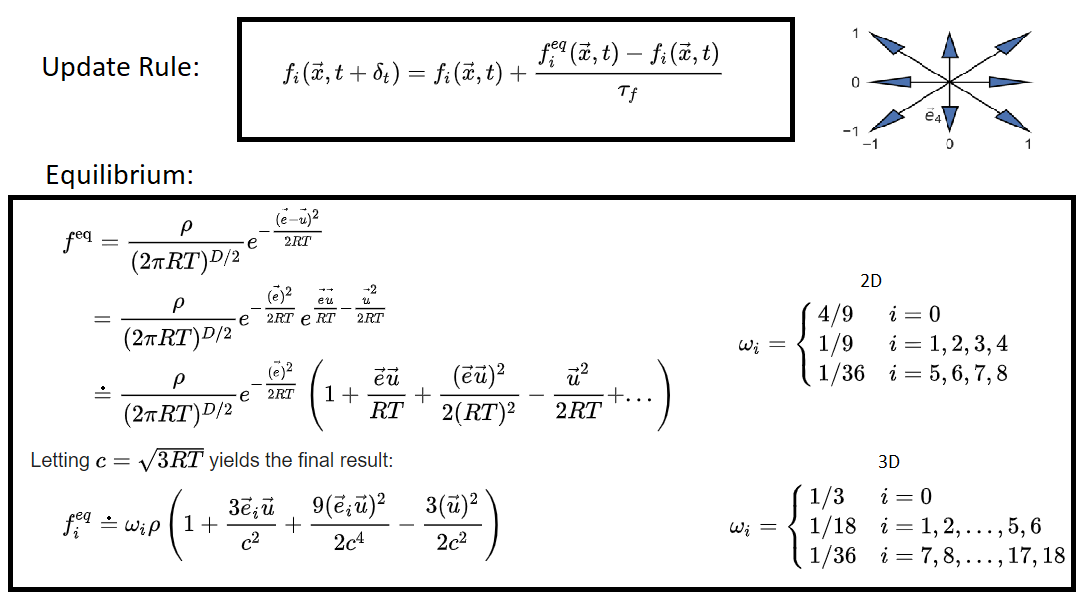

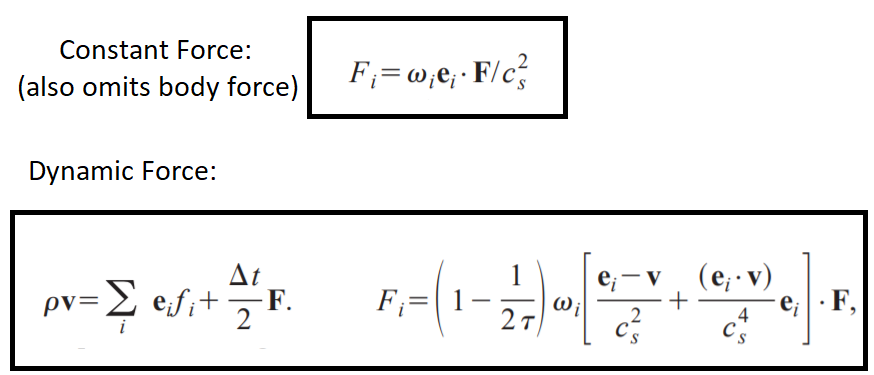

In [112]:
#Constants
W=cuda.to_device(np.array(
    [1/3]+[1/18]*6+[1/36]*12
,dtype=np.float32))

E =cuda.to_device(np.array([
    [0,0,0],[1,0,0],[-1,0,0],[0,1,0],
    [0,-1,0],[0,0,1],[0,0,-1],
    [1,1,0],[-1,-1,0],[1,-1,0],
    [-1,1,0],[1,0,1],[-1,0,-1],
    [-1,0,1],[1,0,-1],[0,1,1],
    [0,-1,-1],[0,1,-1],[0,-1,1],
],dtype=np.int32))

print(W.copy_to_host())
print(E.copy_to_host())

@cuda.jit(device=True)
def feq(e,ux,uy,uz,w,p,c2):
    #feq=wi*rho*(1+3ei.u/c^2+9(ei.u)^2/2c^4-3u^2/2c^2)
    eu=(e[0]*ux+e[1]*uy+e[2]*uz)*3/c2
    uu=(ux*ux+uy*uy+uz*uz)
    return w*p*(1+eu+eu**2/2-3*uu/(2*c2))

@cuda.jit
def collision3D(grid,viscosity,c,W,E,fx,fy,fz):
    
    sx,sy,sz,_=grid.shape
    i,j,k=cuda.grid(3)
    if i>=sx or j>=sy or k>=sz:return
    #the grid represents our velocity density function
    cell=grid[i][j][k]
    itau = 1/(3*viscosity + 0.5)  #reciprocal of relaxation time
    c2=c**2
    #rho is the total density given by the sum of the velocity density function
    rho=0.0
    ux=0.0
    uy=0.0
    uz=0.0
    numvec=E.shape[0]
    #E is our set of direction vectors
    for x in range(numvec):
        #add whatever density to our total density
        rho+=cell[x]
        #add the density to the appropriate direction
        ux+=cell[x]*E[x][0]
        uy+=cell[x]*E[x][1]
        uz+=cell[x]*E[x][2]
    
    
    if rho<=0:return
    ux=ux/rho
    uy=uy/rho
    uz=uz/rho
    
    for x in range(numvec):
        #Update move each velocity-density towards equilibrium
        Fi=3*W[x]*(E[x][0]*fx+E[x][1]*fy+E[x][2]*fz)/c2
        cell[x]+=(feq(E[x],ux,uy,uz,W[x],rho,c2)-cell[x])*itau+Fi
        #feq uses an approximation so it may give scary values like stuff below zero
        #cell[x] represents a form of density so it should never be less than zero
        if cell[x]<0:
            cell[x]=0

            

[0.33333334 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778]
[[ 0  0  0]
 [ 1  0  0]
 [-1  0  0]
 [ 0  1  0]
 [ 0 -1  0]
 [ 0  0  1]
 [ 0  0 -1]
 [ 1  1  0]
 [-1 -1  0]
 [ 1 -1  0]
 [-1  1  0]
 [ 1  0  1]
 [-1  0 -1]
 [-1  0  1]
 [ 1  0 -1]
 [ 0  1  1]
 [ 0 -1 -1]
 [ 0  1 -1]
 [ 0 -1  1]]


# Streaming Step

The streaming step represents the movement of particles.
It adheres to the following updates:
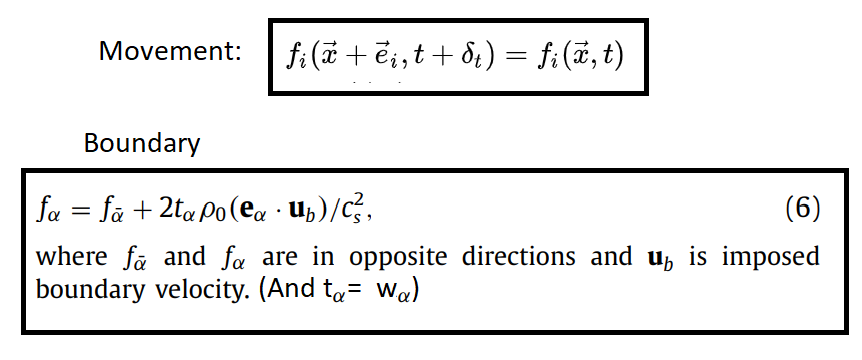

In [113]:
@cuda.jit
def stream3D(grid,nextgrid,boundaries,c,W,E,Ub):
    sx,sy,sz,_=grid.shape
    i,j,k=cuda.grid(3)
    if i>=sx or j>=sy or k>=sz:return
    #the grid represents our velocity density function
    
    if boundaries[i][j][k]>0:return
    
    
    nextgrid[i][j][k][0]=grid[i][j][k][0]
    
    rho=0
    for x in range(E.shape[0]):
        #add whatever density to our total density
        rho+=grid[i][j][k][x]
        
    #if rho<=0:return
    
    #no direction
    
    axis=int((E.shape[0]-1)/2)
    #E is our set of direction vectors
    for x in range(axis):
        #directions are set up so the reverse direction is always one after the forward direction
        e1=2*x+1
        e2=2*x+2
        i1=(i+E[e1][0])%sx
        j1=(j+E[e1][1])%sy
        k1=(k+E[e1][2])%sz
        i2=(i+E[e2][0])%sx
        j2=(j+E[e2][1])%sy
        k2=(k+E[e2][2])%sz
        #forwards
        if boundaries[i1][j1][k1]<=0:
            #move density to next cell
            nextgrid[i1][j1][k1][e1]=grid[i][j][k][e1]
        else:
            #Extra term from boundary speed
            ub = Ub[i1][j1][k1]
            uadd=2*W[e2]*rho*(E[e2][0]*ub[0]+E[e2][1]*ub[1]+E[e2][2]*ub[2])/c**2
            #bounce density off of boundary
            nextgrid[i][j][k][e2]=grid[i][j][k][e1]+uadd
        #backwards
        if boundaries[i2][j2][k2]<=0:
            #move density to next cell
            nextgrid[i2][j2][k2][e2]=grid[i][j][k][e2]
        else:
            #Extra term from boundary speed
            ub = Ub[i2][j2][k2]
            uadd=2*W[e1]*rho*(E[e1][0]*ub[0]+E[e1][1]*ub[1]+E[e1][2]*ub[2])/c**2
            #bounce density off of boundary
            nextgrid[i][j][k][e1]=grid[i][j][k][e2]+uadd


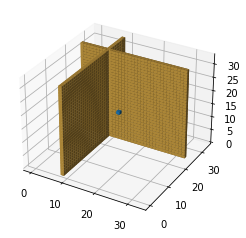

19.0 19.0


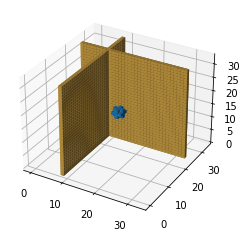

19.0 19.0


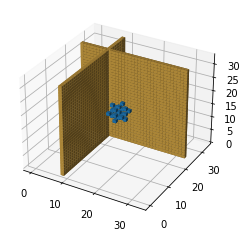

19.0 19.0


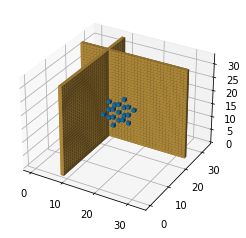

19.0 19.0


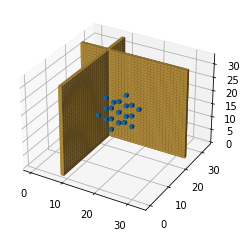

19.0 19.0


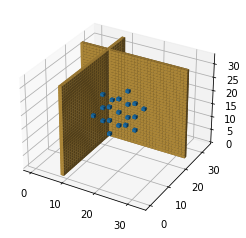

19.0 19.0


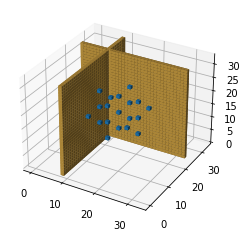

19.0 19.0


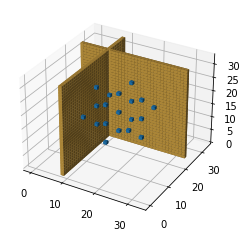

19.0 19.0


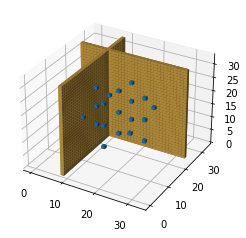

19.0 19.0


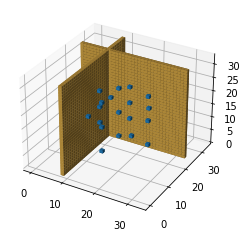

19.0 19.0


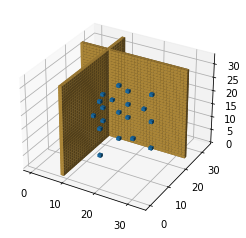

19.0 19.0


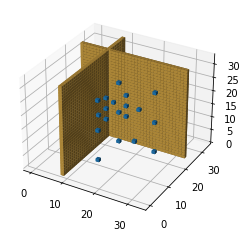

19.0 19.0


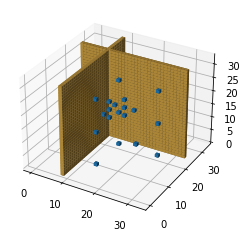

19.0 19.0


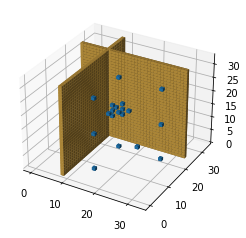

19.0 19.0


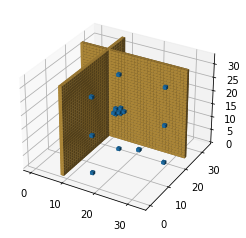

19.0 19.0


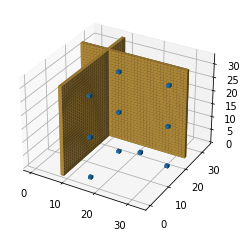

19.0 19.0


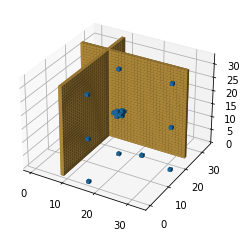

19.0 19.0


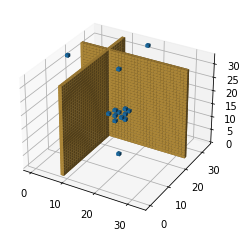

19.0 19.0


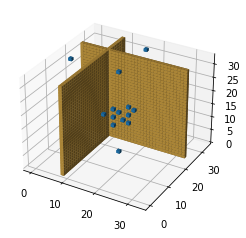

19.0 19.0


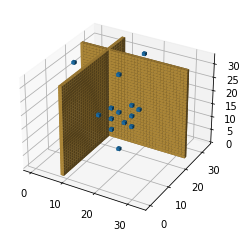

19.0 19.0


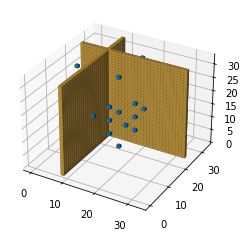

19.0 19.0


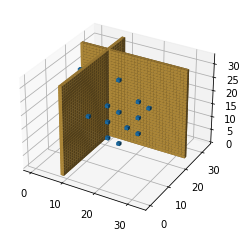

19.0 19.0


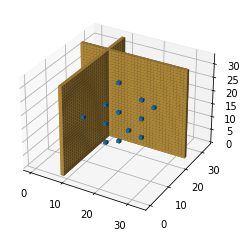

19.0 19.0


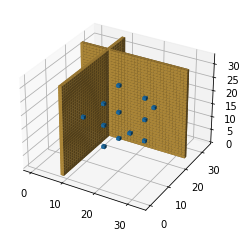

19.0 19.0


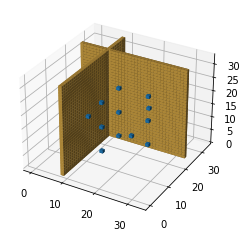

19.0 19.0


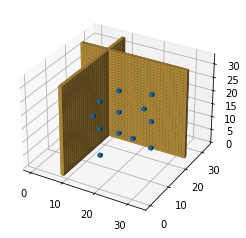

19.0 19.0


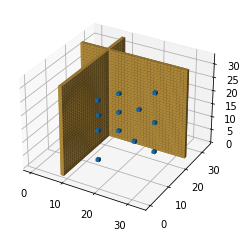

In [76]:
import glob
from PIL import Image
import io 

def pull_img(fig):
    with io.BytesIO() as buff:
        fig.savefig(buff, format='raw')
        #fig.clf()
        #plt.close()
        data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
        w, h = fig.bbox.bounds[2:]
        data = data.reshape((int(h), int(w), -1))
        image_data = data.astype('uint8')
        return Image.fromarray(image_data)
def gifify(allframes,fp_out = "image.gif",speed=20):
    # filepaths
    img, *imgs = allframes
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=speed, loop=0)
    
    
    
#ax.voxels(bounds,facecolors=colors)
frames=[]

S1=33

grid1=np.zeros([S1,S1,S1,19])
grid2=grid1.copy()
bounds = np.zeros([S1,S1,S1])
bconds=np.zeros([S1,S1,S1,3])
grid1[(S1-1)//2,(S1-1)//2,(S1-1)//2,:]=1.0
c=1.0


bounds[S1//4]=1
bounds[:,-S1//4]=1
colors2 = np.zeros([S1,S1,S1,4])
colors2[bounds>0]=193/255
colors2[bounds>0,1]=150/255
colors2[bounds>0,2]=62/255
colors2[bounds>0,3]=1




fig = plt.figure()
ax= fig.add_subplot(projection='3d')
ax.voxels(np.sum(grid1,axis=-1)>0)
ax.voxels((bounds>0),facecolors=colors2)
plt.show()
for x in range(13):
    stream3D[(16,16,16),(8,8,4)](grid1,grid2,bounds,c,W,E,bconds)
    #print(grid2)

    #print(grid2[3:5,3:5,3:5,:])
    print(np.sum(grid1),np.sum(grid2))
    fig = plt.figure()
    ax= fig.add_subplot(projection='3d')
    ax.voxels(np.sum(grid2,axis=-1)>0)
    ax.voxels((bounds>0),facecolors=colors2)
    frames+=[pull_img(fig)]
    plt.show()

    print(np.sum(grid1),np.sum(grid2))
    
    stream3D[(16,16,16),(8,8,4)](grid2,grid1,bounds,c,W,E,bconds)
    fig = plt.figure()
    ax= fig.add_subplot(projection='3d')
    ax.voxels(np.sum(grid1,axis=-1)>0)
    ax.voxels((bounds>0),facecolors=colors2)
    frames+=[pull_img(fig)]
    plt.show()
    
gifify(frames,"3DStream.gif")

In [78]:
gifify(frames,"3DStream.gif",120)

# Island Generation

In [79]:


min_height = 0.0 # Minimum height of an individual island (0 = No island, 1 = Ocean level)
max_height = 2.0 # Maximum height of an individual island (0 = No island, 1 = Ocean level)
x_decay_min = 1.5 # Minimum value to determine the decay rate in the x direction (0 = No decay, inf = Immediate decay)
x_decay_max = 3.0 # Maximum value to determine the decay rate in the x direction (0 = No decay, inf = Immediate decay)
y_decay_min = 1.5 # Minimum value to determine the decay rate in the y direction (0 = No decay, inf = Immediate decay)
y_decay_max = 3.0 # Maximum value to determine the decay rate in the y direction (0 = No decay, inf = Immediate decay)
crash_threshold = -0.1 # threshold of height for judging if submarine crash

class islandParameter(object):
    def __init__(self, x_size, y_size, max_h):
        self.height = np.random.uniform(low=min_height, high=max_h) # Height parameter
        self.x0 = np.random.uniform(low=0.0, high=x_size) # x position parameter
        self.y0 = np.random.uniform(low=0.0, high=y_size) # y position parameter
        self.a = np.random.uniform(low=x_decay_min, high=x_decay_max) # x variance parameter
        self.c = np.random.uniform(low=y_decay_min, high=y_decay_max) # y variance parameter
        b_lim = np.sqrt(self.a*self.c) # Maximum absolute value for co-variance parameter
        self.b = np.random.uniform(low=-1.0*b_lim, high=1.0*b_lim) # Co-variance parameter


class IslandMap_v1(object):
    def __init__(
        self,
        x_size = 5.0,
        y_size = 5.0,
        grid_size_x = 10,
        grid_size_y = 10,
        pixel_x = 100,
        pixel_y = 100,
        n_islands = 3,
        sub_size=0.05,
        port_size=0.10,
        island_size=1.0,
        max_vx = 0.5,
        max_vy = 0.5,
        buffer_size=0.1,
        level = 0,
        sub_level = 0.0,
        ):
        self.x_size = x_size # Size of map in x-direction
        self.y_size = y_size # Size of map in y-direction
        self.grid_size_x = grid_size_x # separate the map into X * Y grid, each grid has
        self.grid_size_y = grid_size_y # a water current velocity. these two var are the grid size
        self.pixel_x = pixel_x # Number of pixels in the x-direction of state
        self.pixel_y = pixel_y # Number of pixels in the y-direction of state
        self.n_islands = n_islands # Number of islands to generate
        self.max_vx = max_vx
        self.max_vy = max_vy
        self.sub_size = sub_size # Radius of submarine
        self.port_size = port_size # Radius of port
        self.buffer_size = buffer_size # Buffer region around the map for placing objects (0=objects can be placed against the outer walls)
        self.level = level # Difficulty used for curriculum learning (0 = Manual inputs used, 1 <= increasing difficulty)
        self.sub_level = sub_level # Parameter used to smoothly transition between levels

        # Define placement radius for Level 1
        if self.level == 1:
            self.place_range_sub_x = self.sub_level * ((self.x_size / 2) - (self.buffer_size+self.sub_size))
            self.place_range_sub_y = self.sub_level * ((self.y_size / 2) - (self.buffer_size+self.sub_size))
            self.place_range_port_x = self.sub_level * ((self.x_size / 2) - (self.buffer_size+self.port_size))
            self.place_range_port_y = self.sub_level * ((self.y_size / 2) - (self.buffer_size+self.port_size))
        else:
            self.place_range_sub_x = ((self.x_size / 2) - (self.buffer_size+self.sub_size))
            self.place_range_sub_y = ((self.y_size / 2) - (self.buffer_size+self.sub_size))
            self.place_range_port_x = ((self.x_size / 2) - (self.buffer_size+self.port_size))
            self.place_range_port_y = ((self.y_size / 2) - (self.buffer_size+self.port_size))

        # Define number of islands and their maximum heights for all Levels
        if self.level == 1:
            self.n_islands = 0
            self.max_heights = np.array([])
        elif self.level == 2:
            self.n_islands = 0
            self.max_heights = np.array([])
        elif self.level == 3:
            self.n_islands = 1
            self.max_heights = np.array([self.sub_level * (1.0 + crash_threshold)])
        elif self.level == 4:
            self.n_islands = 5
            self.max_heights = np.array([self.sub_level * (max_height - (1.0 + crash_threshold)) + (1.0 + crash_threshold), self.sub_level * (1.0 + crash_threshold), self.sub_level * (1.0 + crash_threshold), self.sub_level * (1.0 + crash_threshold), self.sub_level * (1.0 + crash_threshold)])
        elif self.level == 5:
            self.n_islands = 5
            self.max_heights = np.array([max_height, self.sub_level * (max_height - (1.0 + crash_threshold)) + (1.0 + crash_threshold), self.sub_level * (max_height - (1.0 + crash_threshold)) + (1.0 + crash_threshold), self.sub_level * (max_height - (1.0 + crash_threshold)) + (1.0 + crash_threshold), self.sub_level * (max_height - (1.0 + crash_threshold)) + (1.0 + crash_threshold)])
        elif self.level == 6:
            self.n_islands = 5
            self.max_heights = np.array([max_height, max_height, max_height, max_height, max_height])
        else:
            self.max_heights = np.zeros(self.n_islands, dtype=np.float32) + max_height

        # Create an array for land at bottom of the ocean
        self.island_list  = []
        for i in range(self.n_islands):
            island = islandParameter(x_size = self.x_size, y_size = self.y_size, max_h = self.max_heights[i])
            self.island_list.append(island)
        # Defining unit circle at (0, 0) for plotting 
        theta = np.linspace(0, 2*np.pi, 51, endpoint=True)
        self.circle = np.zeros((theta.shape[0], 2), dtype=np.float32)
        for i in range(theta.shape[0]):
            self.circle[i, 0] = np.cos(theta[i])
            self.circle[i, 1] = np.sin(theta[i])
        self.set_map()

    def set_map(self):
        # Create an array for land at bottom of the ocean
        self.island_list  = []
        for i in range(self.n_islands):
            island = islandParameter(x_size = self.x_size, y_size = self.y_size, max_h = self.max_heights[i])
            self.island_list.append(island)

        self.heightMap=np.zeros([self.pixel_x,self.pixel_y])

        for i in range(self.pixel_x):
            for j in range(self.pixel_y):
                x_pos = i / self.pixel_x * self.x_size
                y_pos = j / self.pixel_y * self.y_size
                # Creating a land with given get_height_fun within range 0 to 1
                height = self.get_height(x_pos, y_pos)
                self.heightMap[i][j]=height

    def get_height(self, x_pos, y_pos):
        height = -1.0
        for i in range(self.n_islands):
            for j in range(3):
                for k in range(3):
                    A = self.island_list[i].height
                    x0 = self.island_list[i].x0
                    y0 = self.island_list[i].y0
                    a = self.island_list[i].a
                    b = self.island_list[i].b
                    c = self.island_list[i].c
                    height += A * np.exp(
                        -1.0 * (
                            a * ( (x_pos + self.x_size * (j-1)) - x0) ** 2.0
                            + 2.0 * b * ((x_pos + self.x_size * (j-1))  - x0) * ( (y_pos + self.y_size * (k-1)) - y0)
                            + c * ( (y_pos + self.y_size * (k-1)) - y0) ** 2
                        )
                    )
        return height




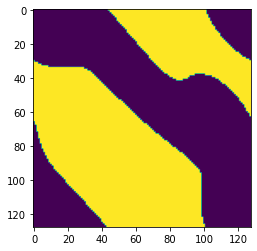

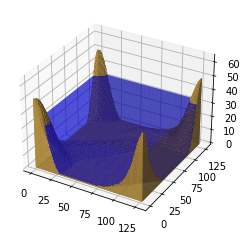

In [21]:
islands=IslandMap_v1(pixel_x=128,pixel_y=128)
heights=np.clip(islands.heightMap*1.1,-1,1)
bounds=np.zeros([128,128,64])
for y in range(64):
    bounds[:,:,y]=heights*32+32>=y
    
grid=np.zeros([128,128,64,19])
for y in range(64):
    grid[:,:,y,0]=((heights*32+32<y)&(y<=32))*1.0

    
    
plt.imshow(heights<=-1)
plt.show()
    
colors = np.zeros([128,128,64,4])
colors[:,:,:,0]=193/255
colors[:,:,:,1]=150/255
colors[:,:,:,2]=62/255
colors[:,:,:,3]=0.8

colors2 = np.zeros([128,128,64,4])
colors2[:,:,:,2]=grid[:,:,:,0]
colors2[:,:,:,3]=grid[:,:,:,0]*0.5


colors2[bounds>0]=193/255
colors2[bounds>0,1]=150/255
colors2[bounds>0,2]=62/255
colors2[bounds>0,3]=1

# and plot everything
ax = plt.figure().add_subplot(projection='3d')
#ax.voxels(bounds,facecolors=colors)


ax.voxels((np.sum(grid,axis=-1)>0),facecolors=colors2)
ax.voxels((bounds>0),facecolors=colors2)
plt.show()

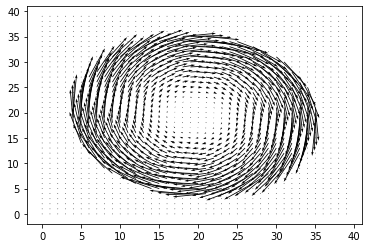

In [153]:
def rotating_disc(x,y,v,r,sx,sy):
    xs=np.linspace(-1,1,sx)
    ys=np.linspace(-1,1,sy)
    xs=np.roll(xs,x)
    ys=np.roll(ys,y)
    X,Y=np.meshgrid(xs,ys)
    M=(X**2+Y**2)**0.5
    vx=Y*M*(M<=r)*v/r
    vy=-X*M*(M<=r)*v/r
    return np.stack([vx,vy],axis=-1)
uv=rotating_disc(0,0,0.5,0.8,40,40)
u,v=uv[...,0],uv[...,1]
plt.quiver(u,v,scale=4)
plt.show()
    

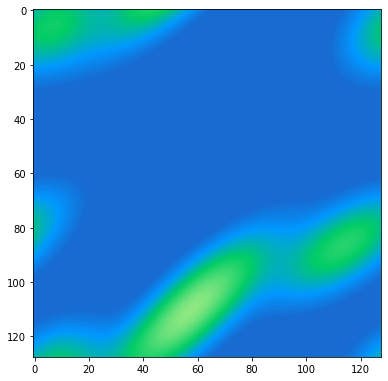

(128, 128, 64) (128, 128, 64, 0)


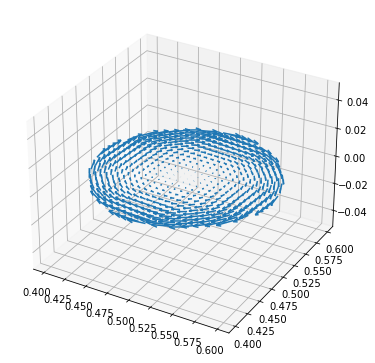

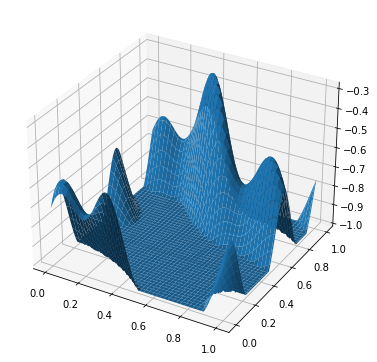

0|10|20|30|40|50|60|70|80|90|100|110|120|130|140|150|160|170|180|190|200|210|220|230|240|250|260|270|280|290|300|310|320|330|340|350|360|370|380|390|400|410|420|430|440|450|460|470|480|490|500|510|520|530|540|550|560|570|580|590|600|610|620|630|640|650|660|670|680|690|700|710|720|730|740|750|760|770|780|790|800|810|820|830|840|850|860|870|880|890|900|910|920|930|940|950|960|970|980|990|1000|1010|1020|1030|1040|1050|1060|1070|1080|1090|1100|1110|1120|1130|1140|1150|1160|1170|1180|1190|1200|1210|1220|1230|1240|1250|1260|1270|1280|1290|1300|1310|1320|1330|1340|1350|1360|1370|1380|1390|1400|1410|1420|1430|1440|1450|1460|1470|1480|1490|1500|1510|1520|1530|1540|1550|1560|1570|1580|1590|1600|1610|1620|1630|1640|1650|1660|1670|1680|1690|1700|1710|1720|1730|1740|1750|1760|1770|1780|1790|1800|1810|1820|1830|1840|1850|1860|1870|1880|1890|1900|1910|1920|1930|1940|1950|1960|1970|1980|1990|

In [195]:
plt.rcParams['figure.figsize'] = [6.4, 6.4]
islands=IslandMap_v1(pixel_x=128,pixel_y=128)
heights=np.clip(islands.heightMap*1.1,-1,1)
bounds=np.zeros([128,128,64])
for y in range(64):
    bounds[:,:,y]=heights*32+32>=y
    
grid=np.zeros([128,128,64,19])
for y in range(64):
    grid[:,:,y,0]=((heights*32+32<y))*1.0

    
    
plt.imshow(heights,cmap='terrain',vmin=-1.2,vmax=1.15)
plt.show()

Boundspeed=np.zeros([128,128,64,3])
Boundspeed[:,:,0,0:2]=rotating_disc(0,0,0.1,0.2,128,128)

ax = plt.figure().add_subplot(projection='3d')
#ax.voxels(bounds,facecolors=colors)

XT,YT,ZT=np.meshgrid(*([np.linspace(0,1,128)]*2+[np.linspace(0,1,64)]))
print(XT.shape,Boundspeed[...,:0].shape)
ax.quiver(XT,YT,ZT,Boundspeed[...,0],Boundspeed[...,1],Boundspeed[...,2])
plt.show()

ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(*np.meshgrid(*([np.linspace(0,1,128)]*2)),heights)
plt.show()

gpugrid=cuda.to_device(grid)
gpubounds=cuda.to_device(bounds)


Ub=cuda.to_device(Boundspeed)
gpugrid2=cuda.to_device(grid.copy())
fx,fy,fz=0,0,-0.01
c=1.0
viscosity=0.5
#collision3D[(16,16,16),(8,8,4)](gpugrid,viscosity,c,W,E,fx,fy,fz)
for x in range(2000):
    collision3D[(16,16,16),(8,8,4)](gpugrid,viscosity,c,W,E,fx,fy,fz)
    stream3D[(16,16,16),(8,8,4)](gpugrid,gpugrid2,gpubounds,c,W,E,Ub)
    collision3D[(16,16,16),(8,8,4)](gpugrid2,viscosity,c,W,E,fx,fy,fz)
    stream3D[(16,16,16),(8,8,4)](gpugrid2,gpugrid,gpubounds,c,W,E,Ub)
    if (x%10==0):
        print(x,end="|")
    


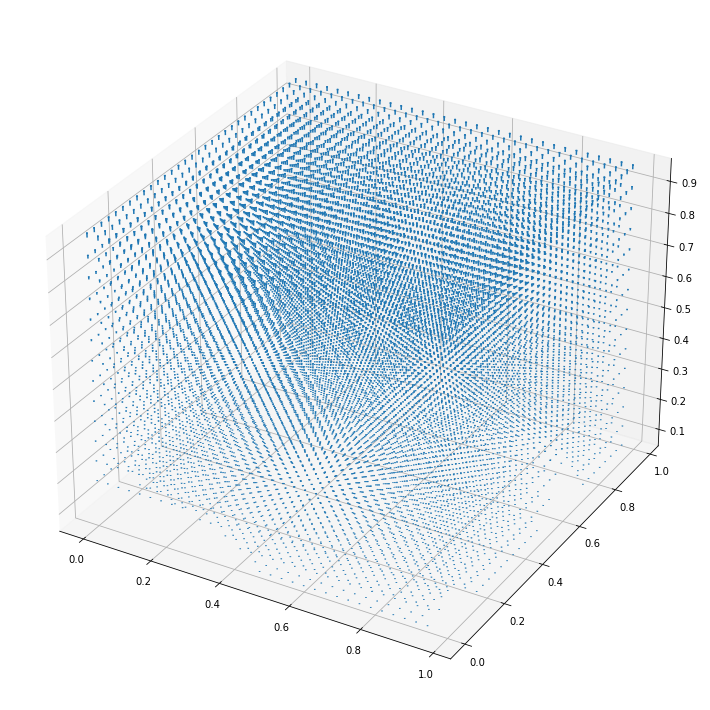

In [196]:
plt.rcParams['figure.figsize'] = [12.8, 12.8]
XT,YT,ZT=np.meshgrid(*([np.linspace(0,1,128)]*2+[np.linspace(0,1,64)]))

gridf=gpugrid.copy_to_host()

rho,ux,uy,uz=np.zeros([4,128,128,64])

for x in range(19):
    #add whatever density to our total density
    rho+=gridf[...,x]
    ux+=gridf[...,x]*E[x][0]
    uy+=gridf[...,x]*E[x][1]
    uz+=gridf[...,x]*E[x][2]

rho=rho+(rho==0)
    
ux=ux/rho
uy=uy/rho
uz=uz/rho

ax = plt.figure().add_subplot(projection='3d')
ax.quiver(XT[::4,::4,::4],YT[::4,::4,::4],ZT[::4,::4,::4],ux[::4,::4,::4],uy[::4,::4,::4],uz[::4,::4,::4])
plt.show()

--------------------------


D:\Ananconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
D:\Ananconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


2.101253105307116 0.003221671601268319


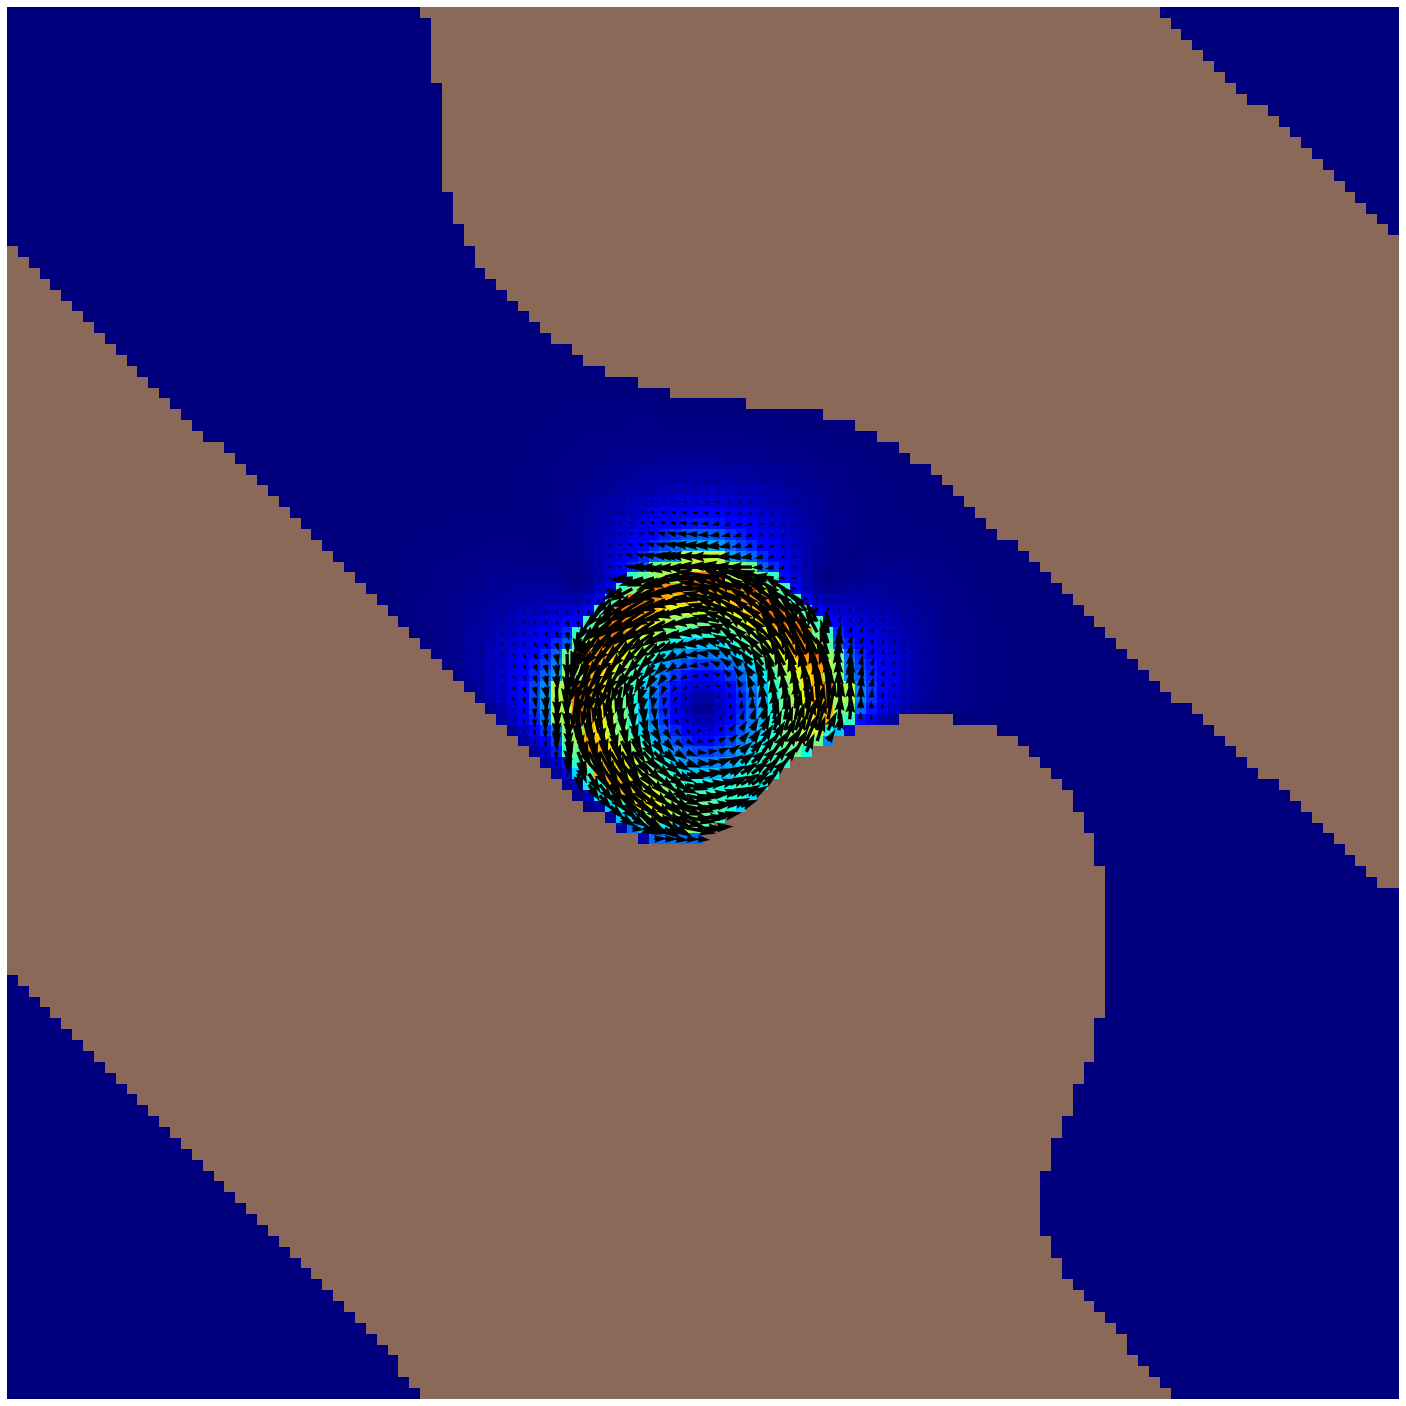

2.065921718527339 0.00216096759948749


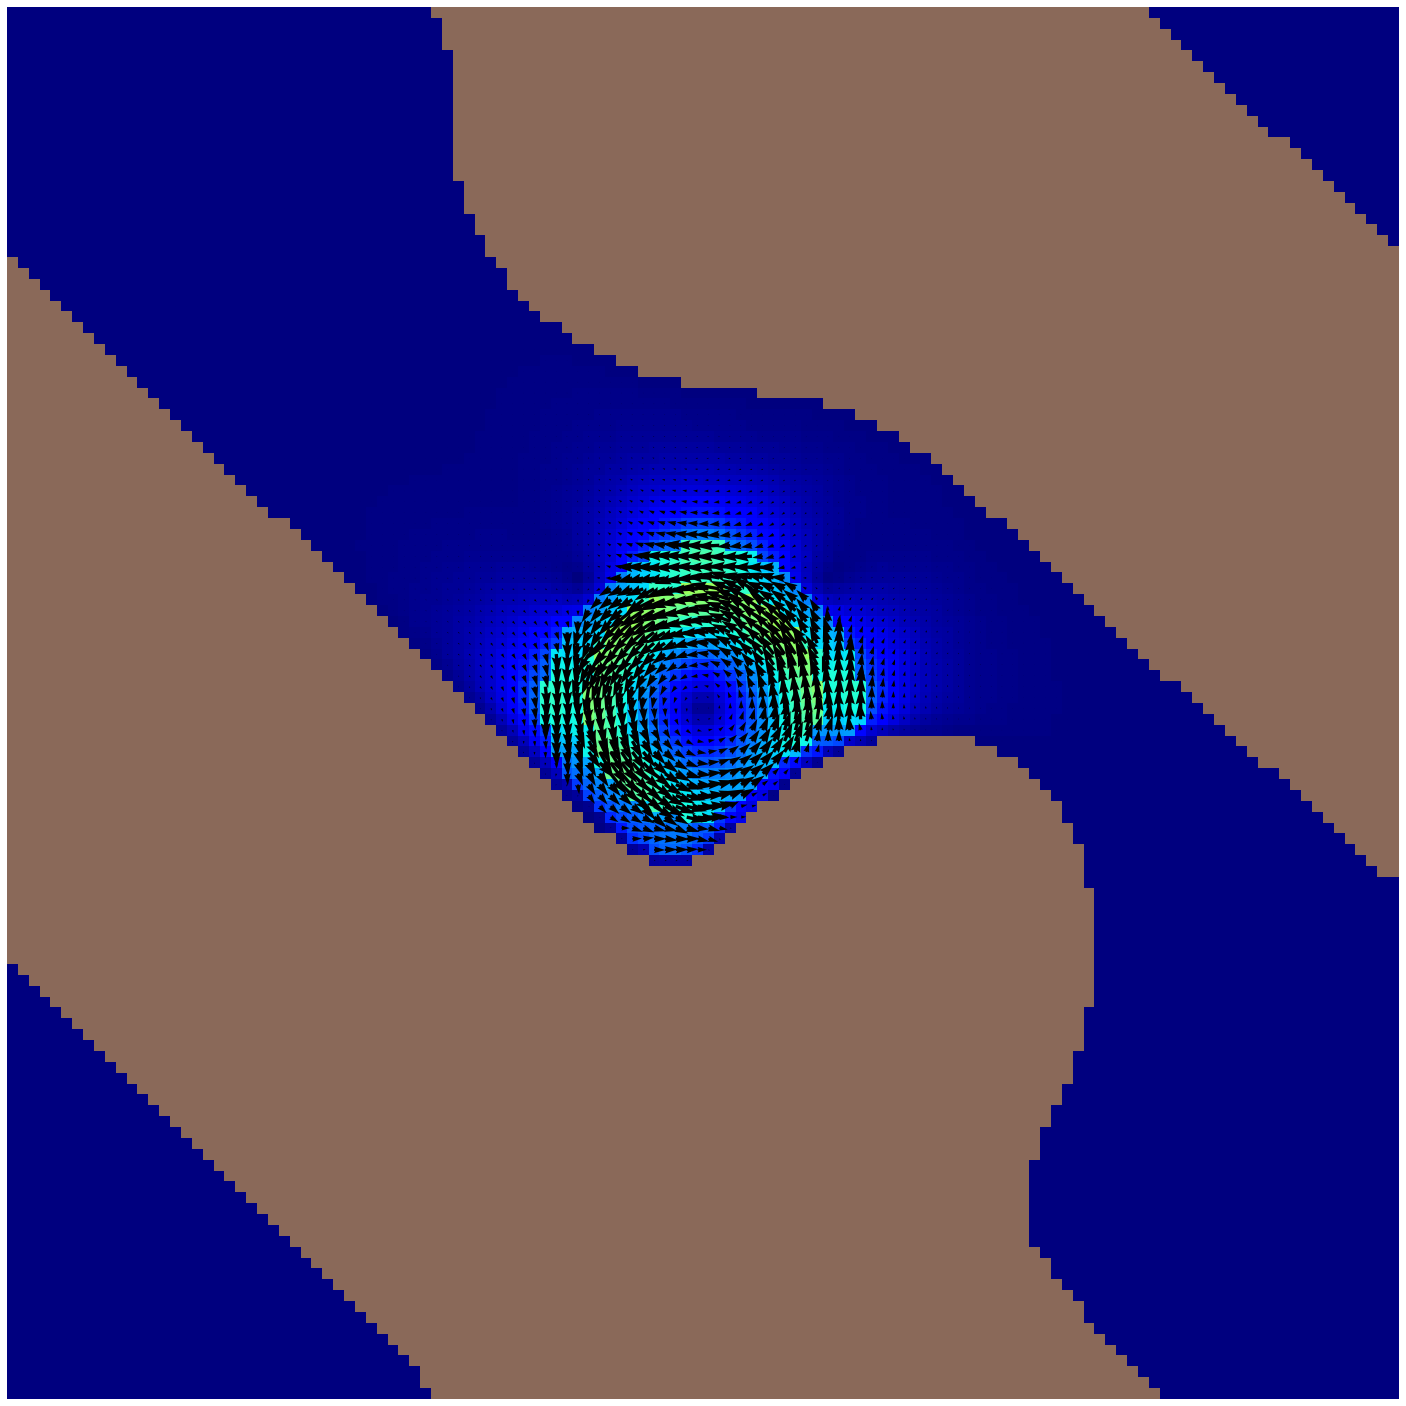

2.0342041741793775 0.0015146792559891408


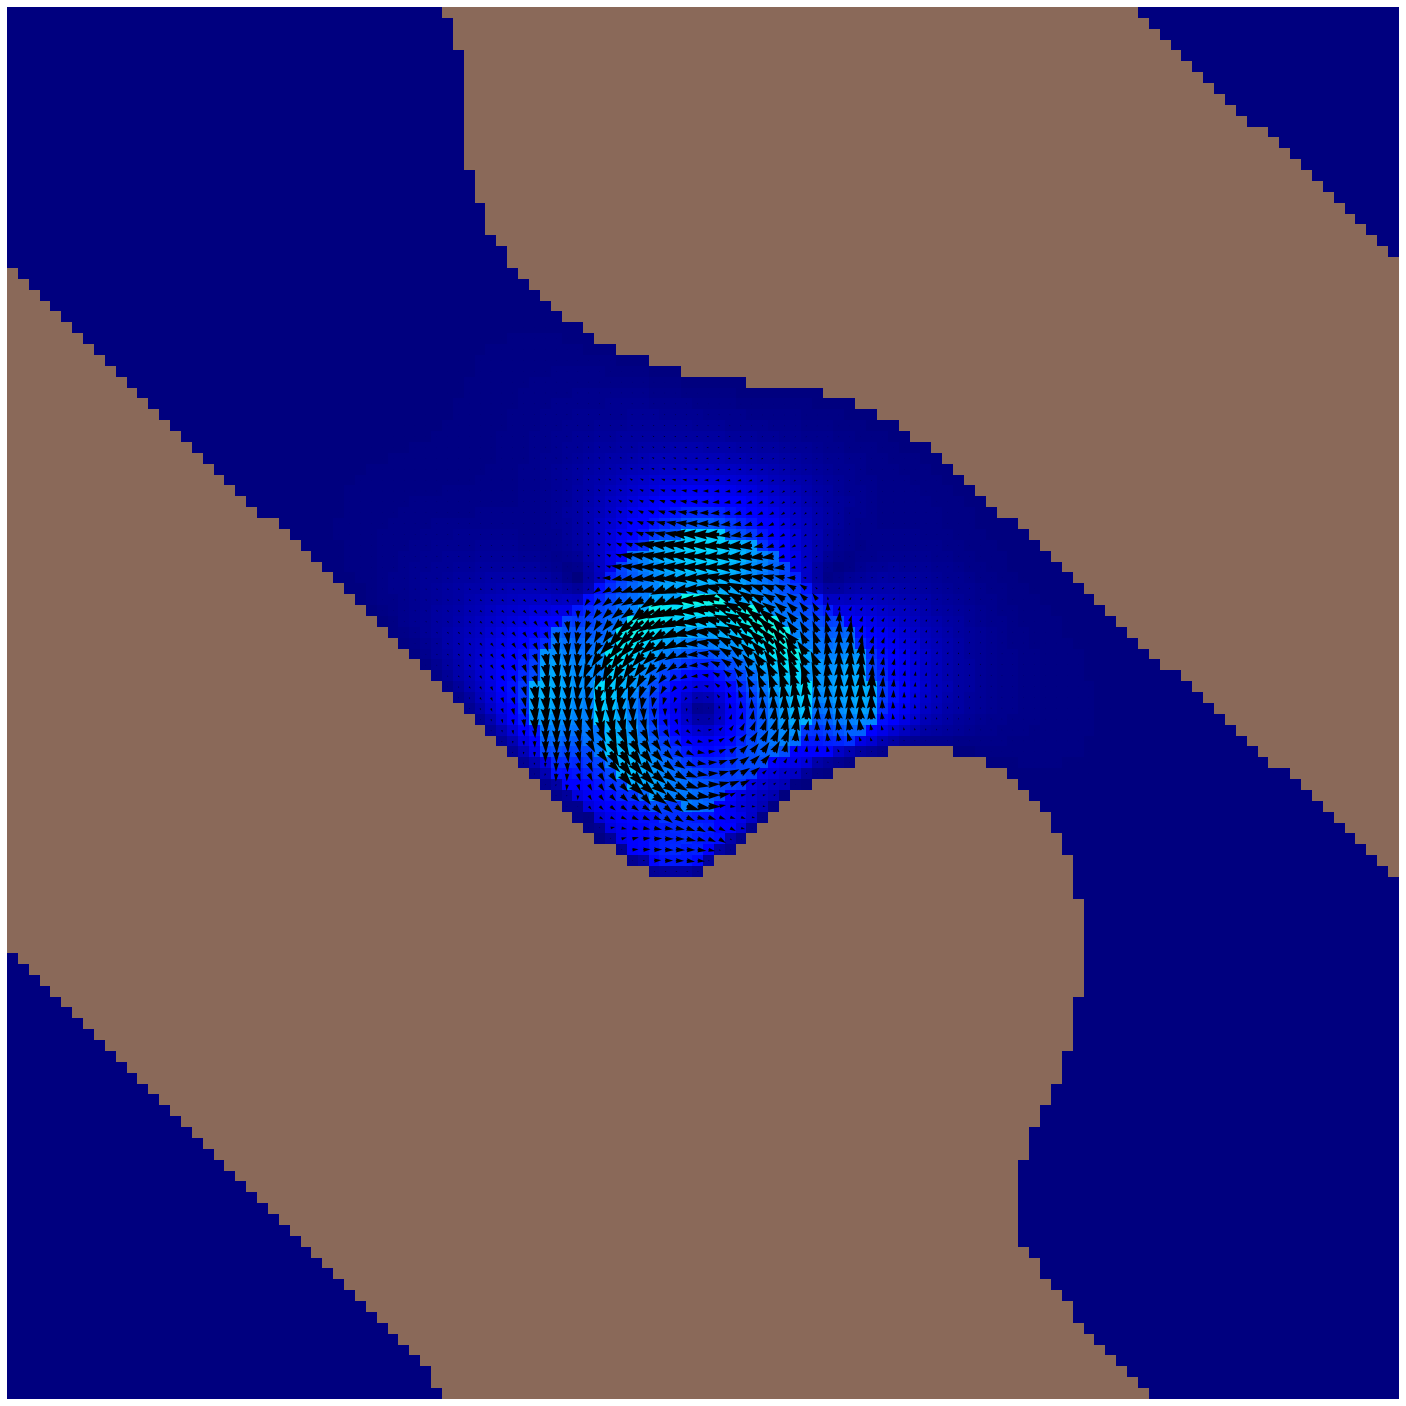

2.003209016695728 0.0010724151653401218


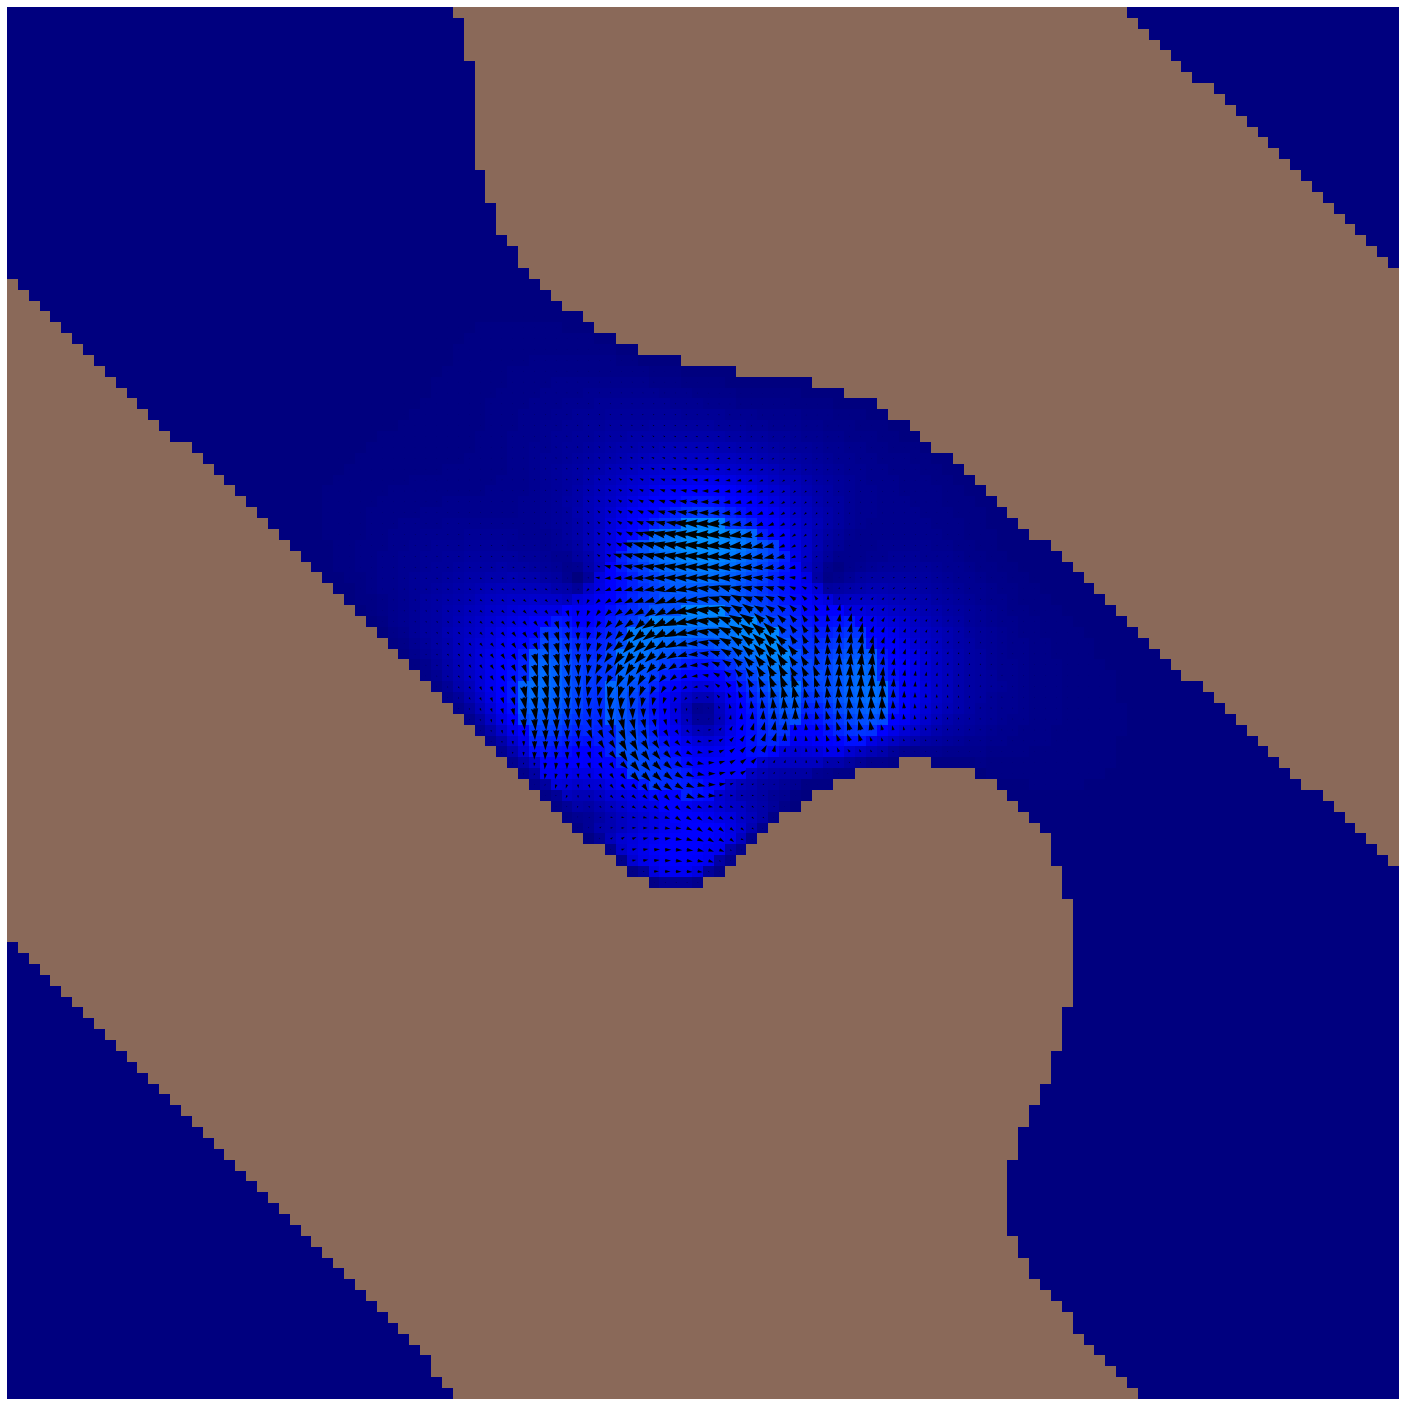

1.9726590279191882 0.0008719184979973383


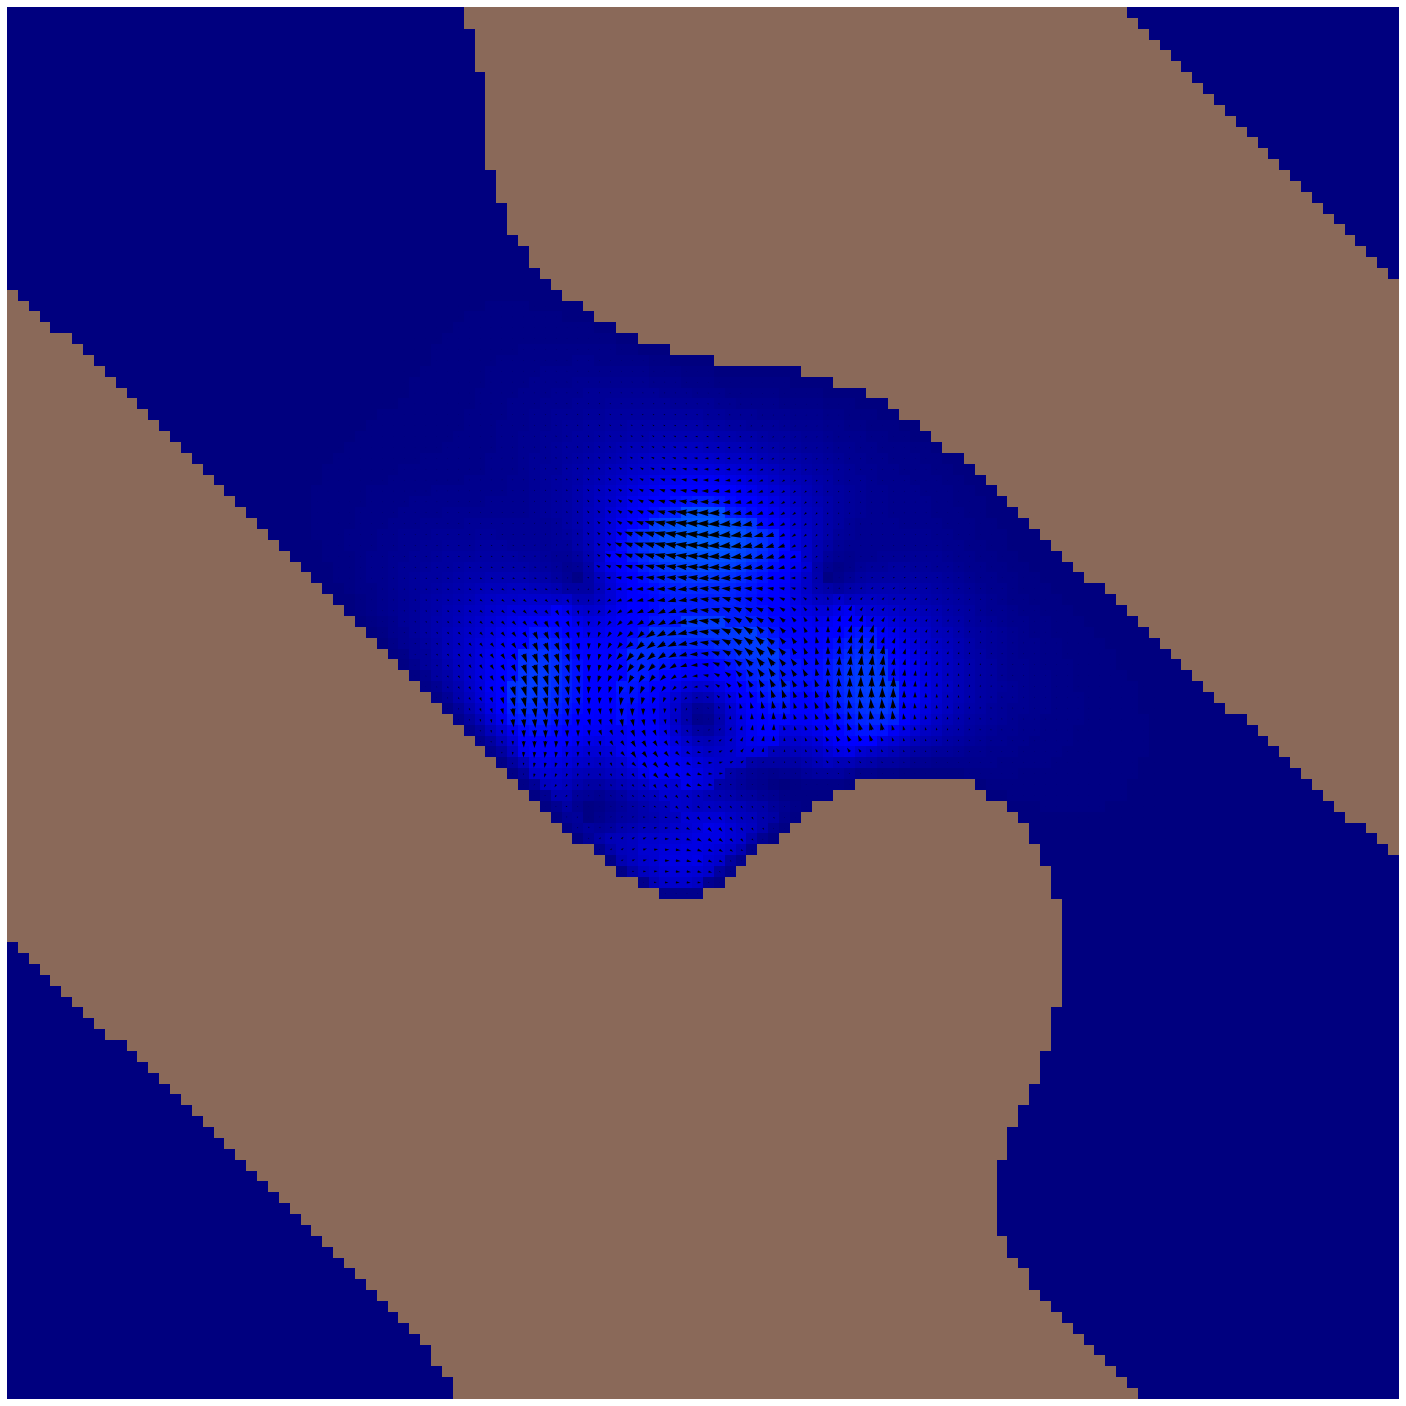

1.9423209762385107 0.00072291973146217


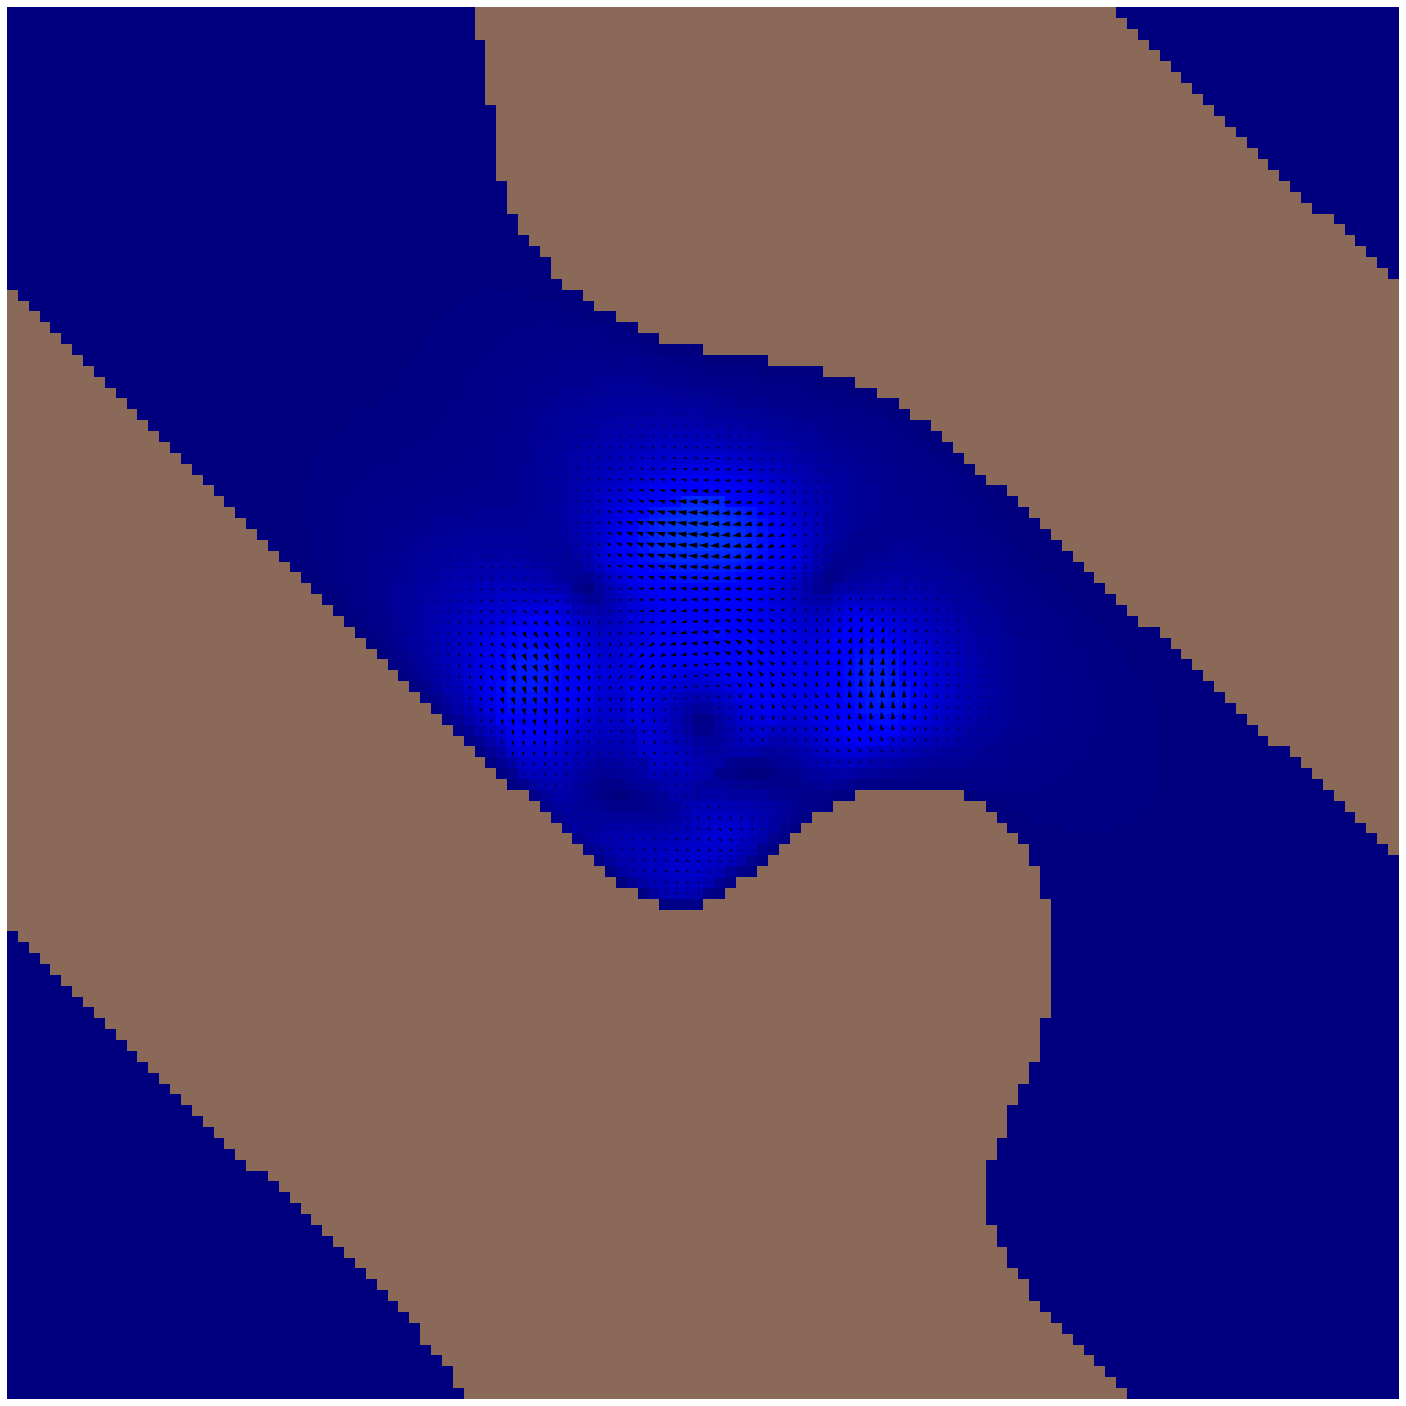

1.9120634420388798 0.0006080907658548315


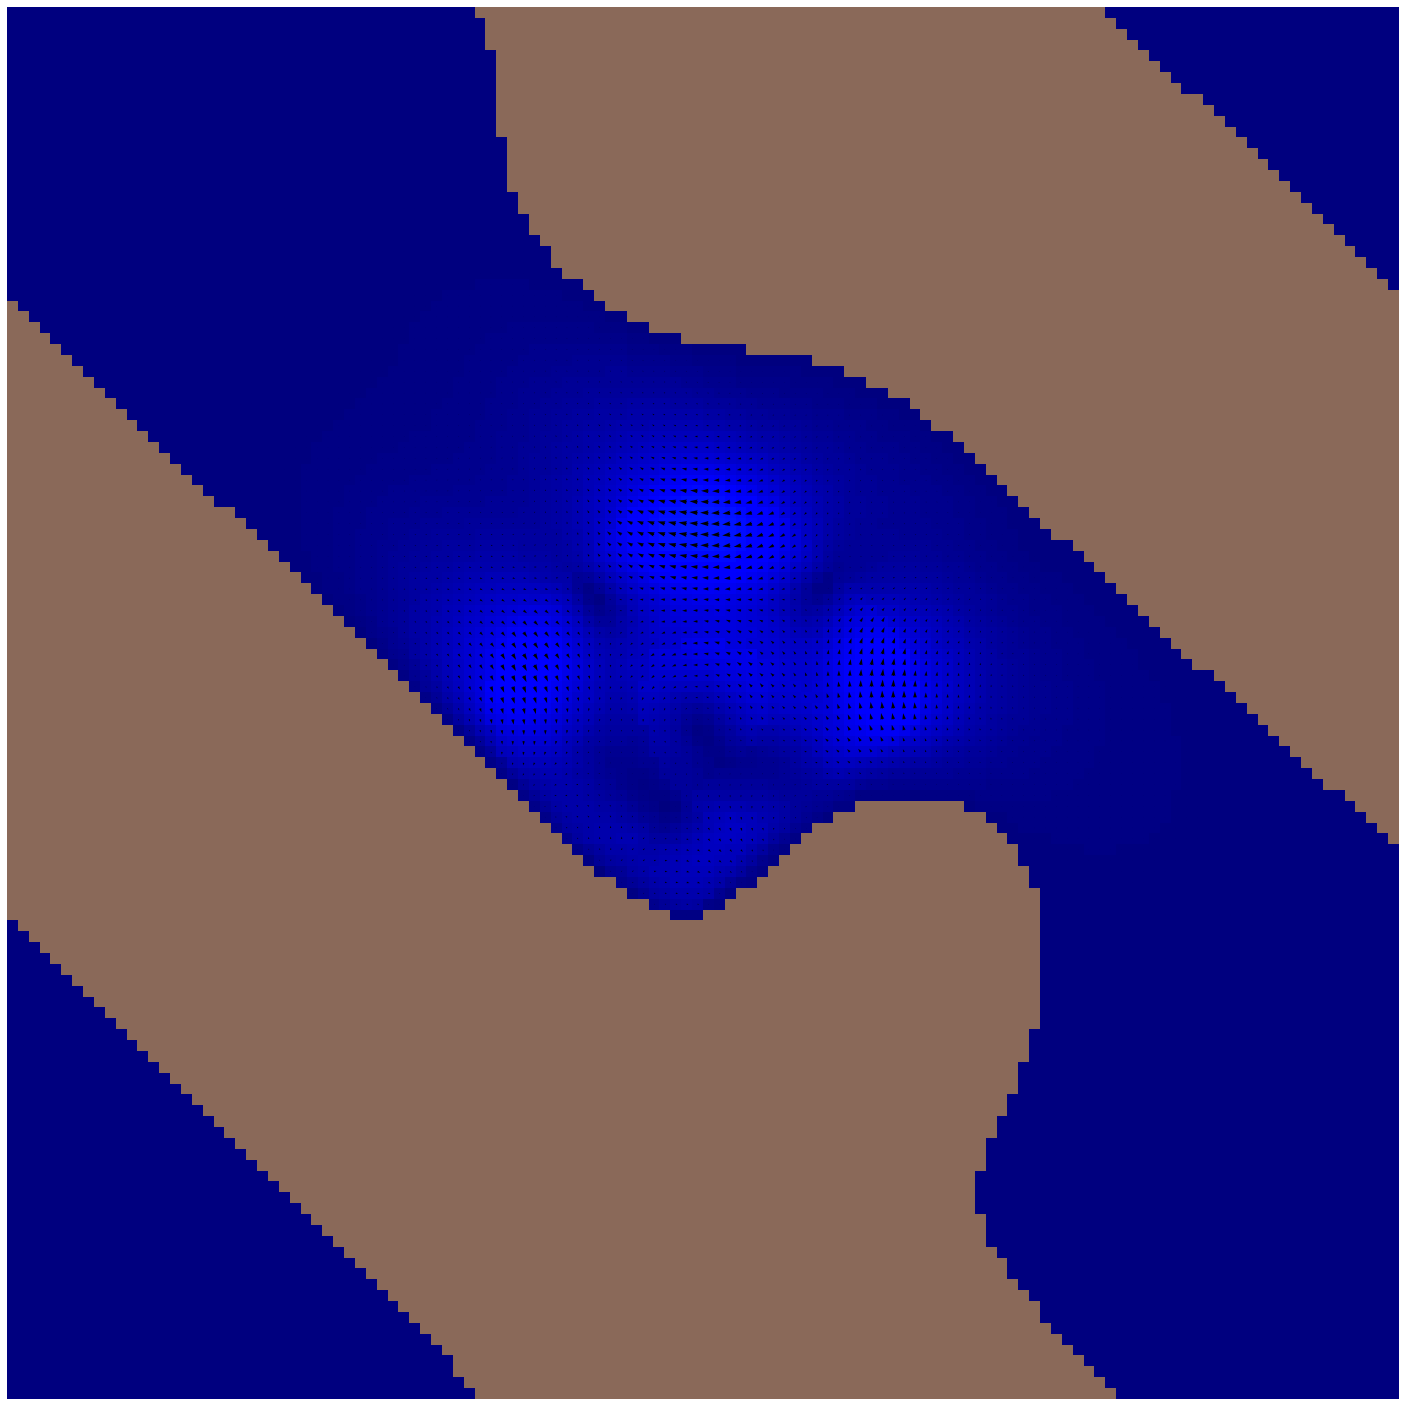

1.8818912705099144 0.0005139666274813594


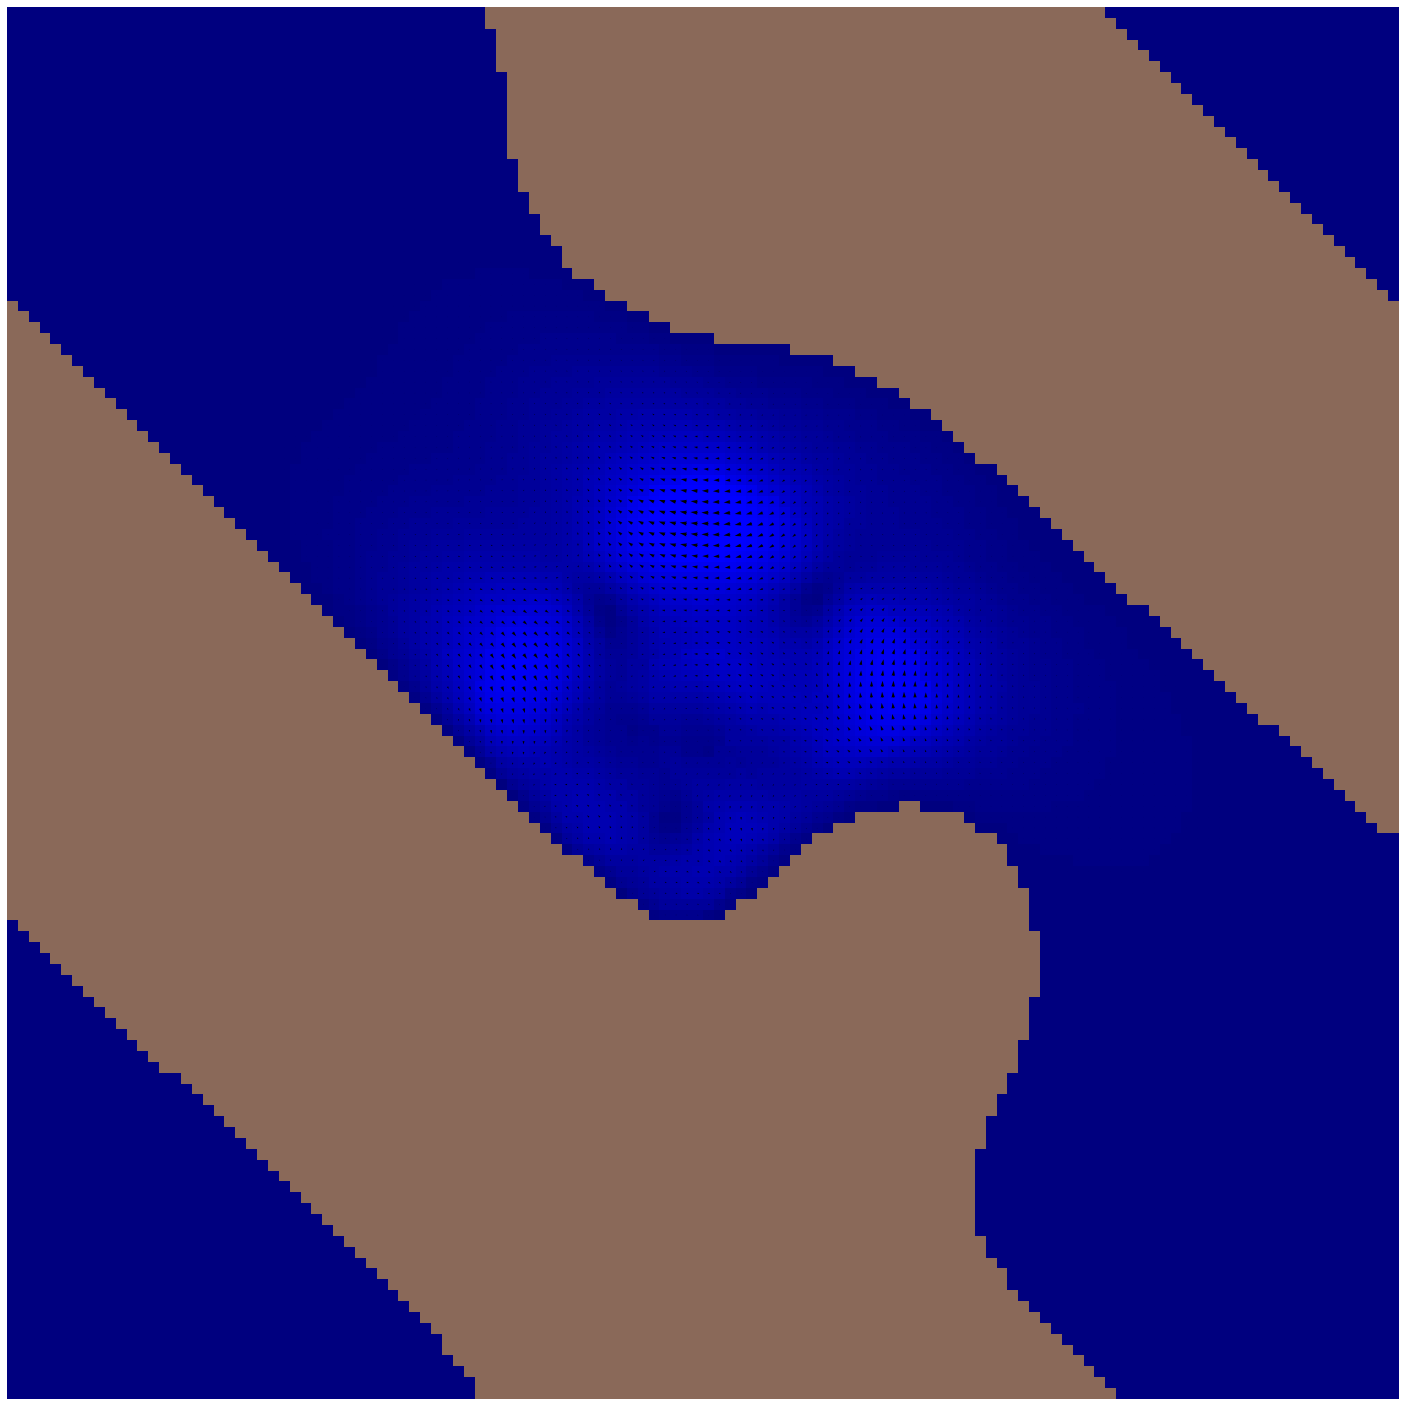

1.8517511052432398 0.00043755473881757796


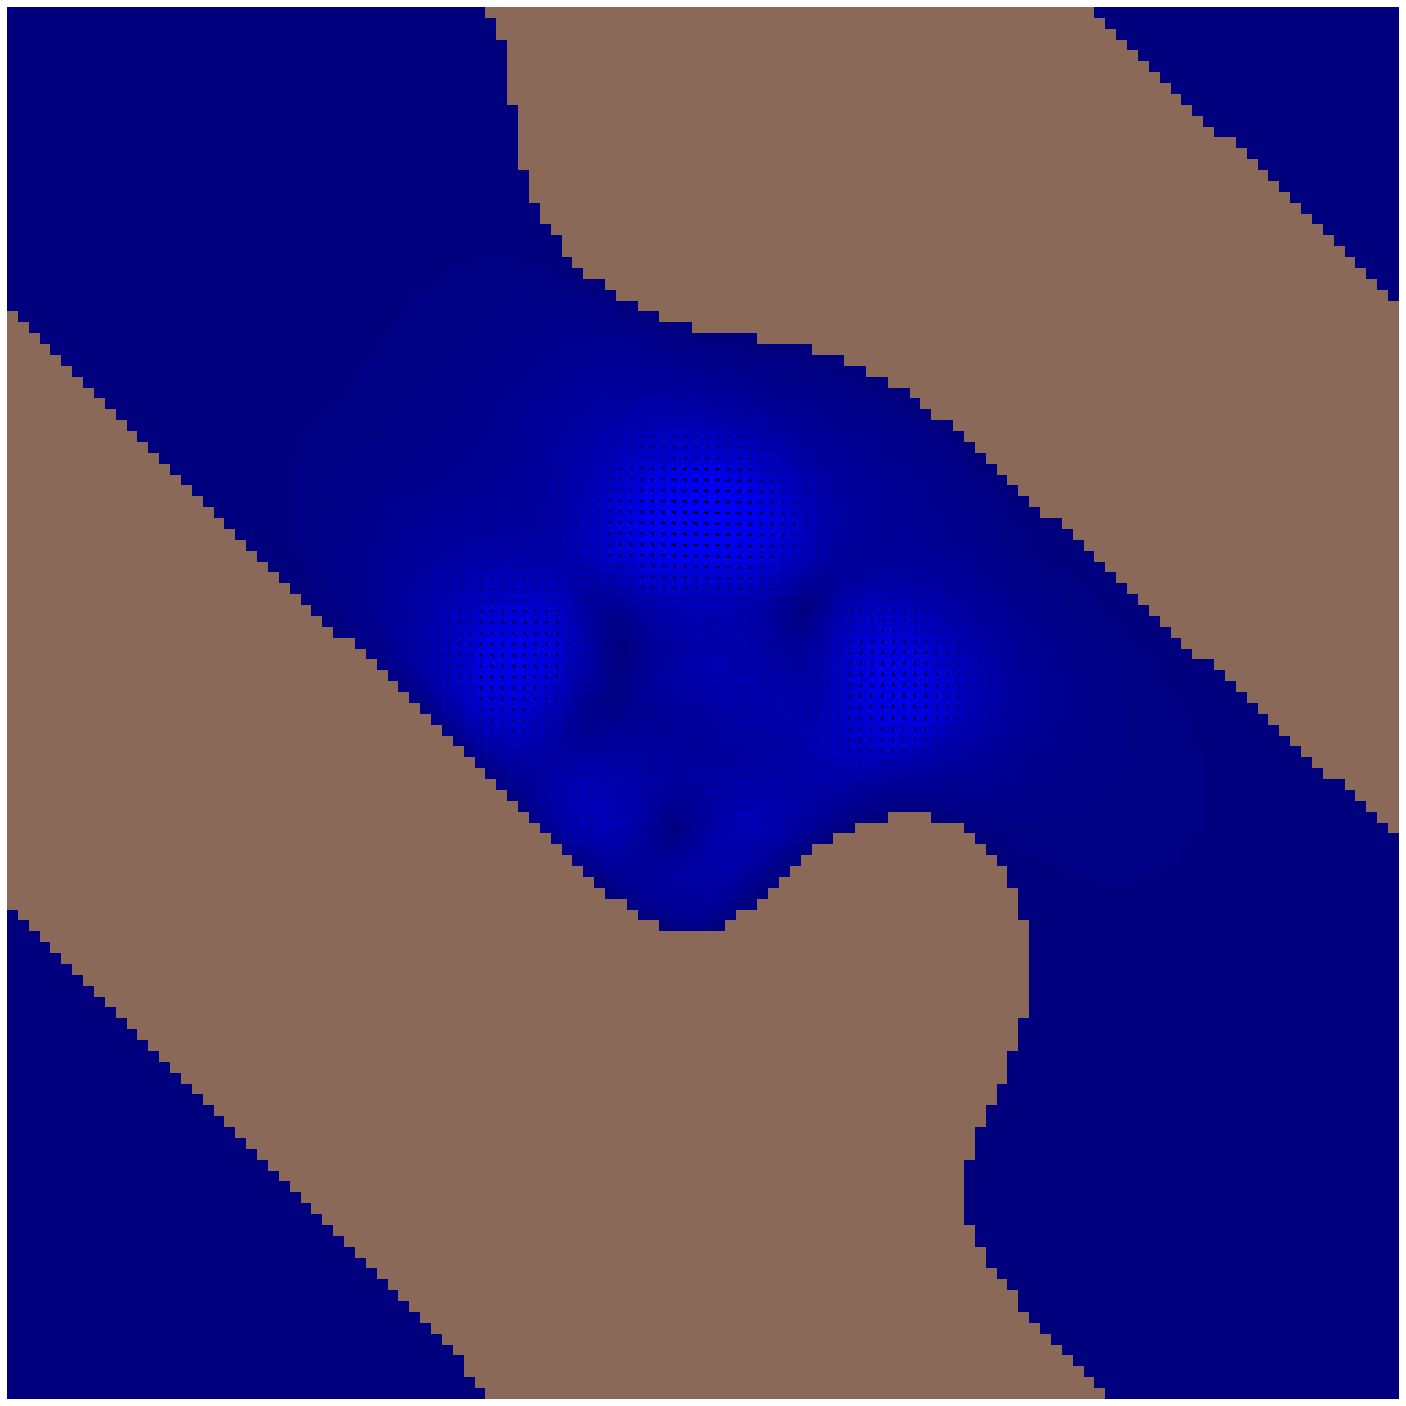

1.8216545683523078 0.0003735650221798333


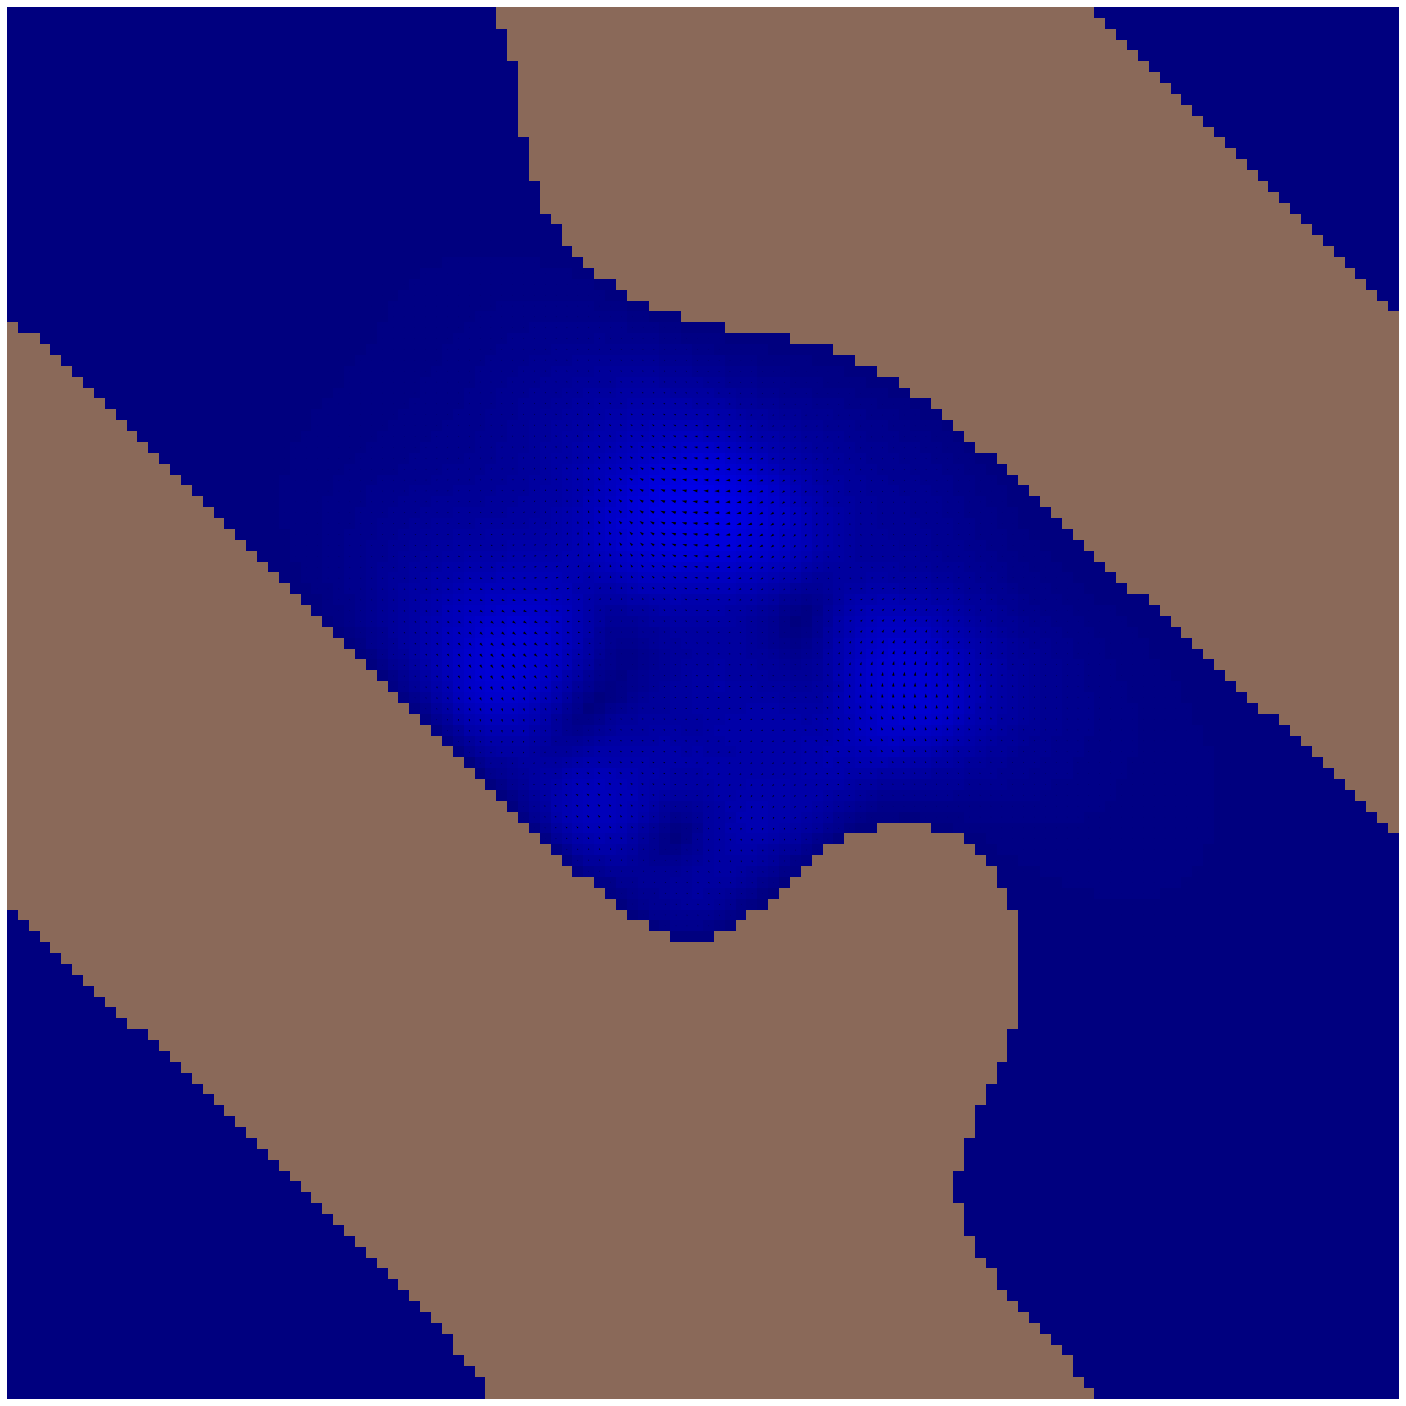

1.791569044096385 0.00031998720818783913


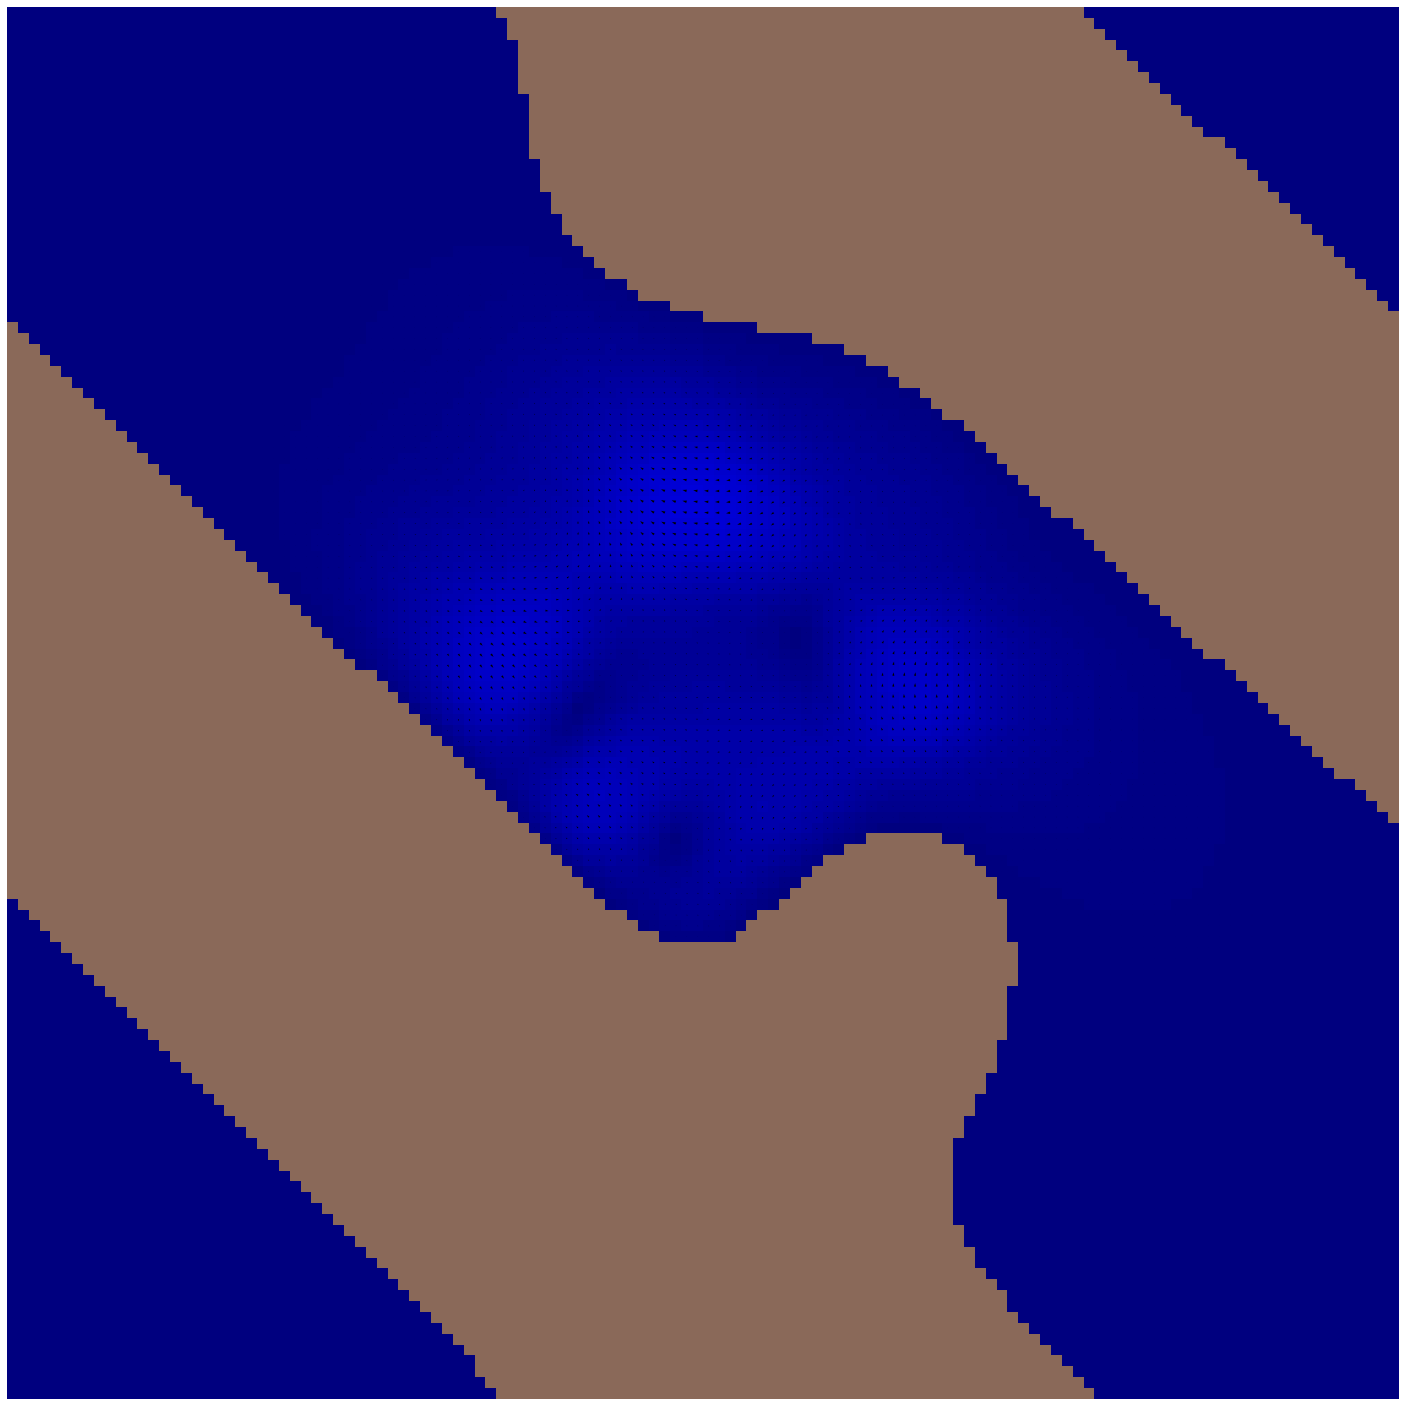

1.7615067205601074 0.00027501260281116024


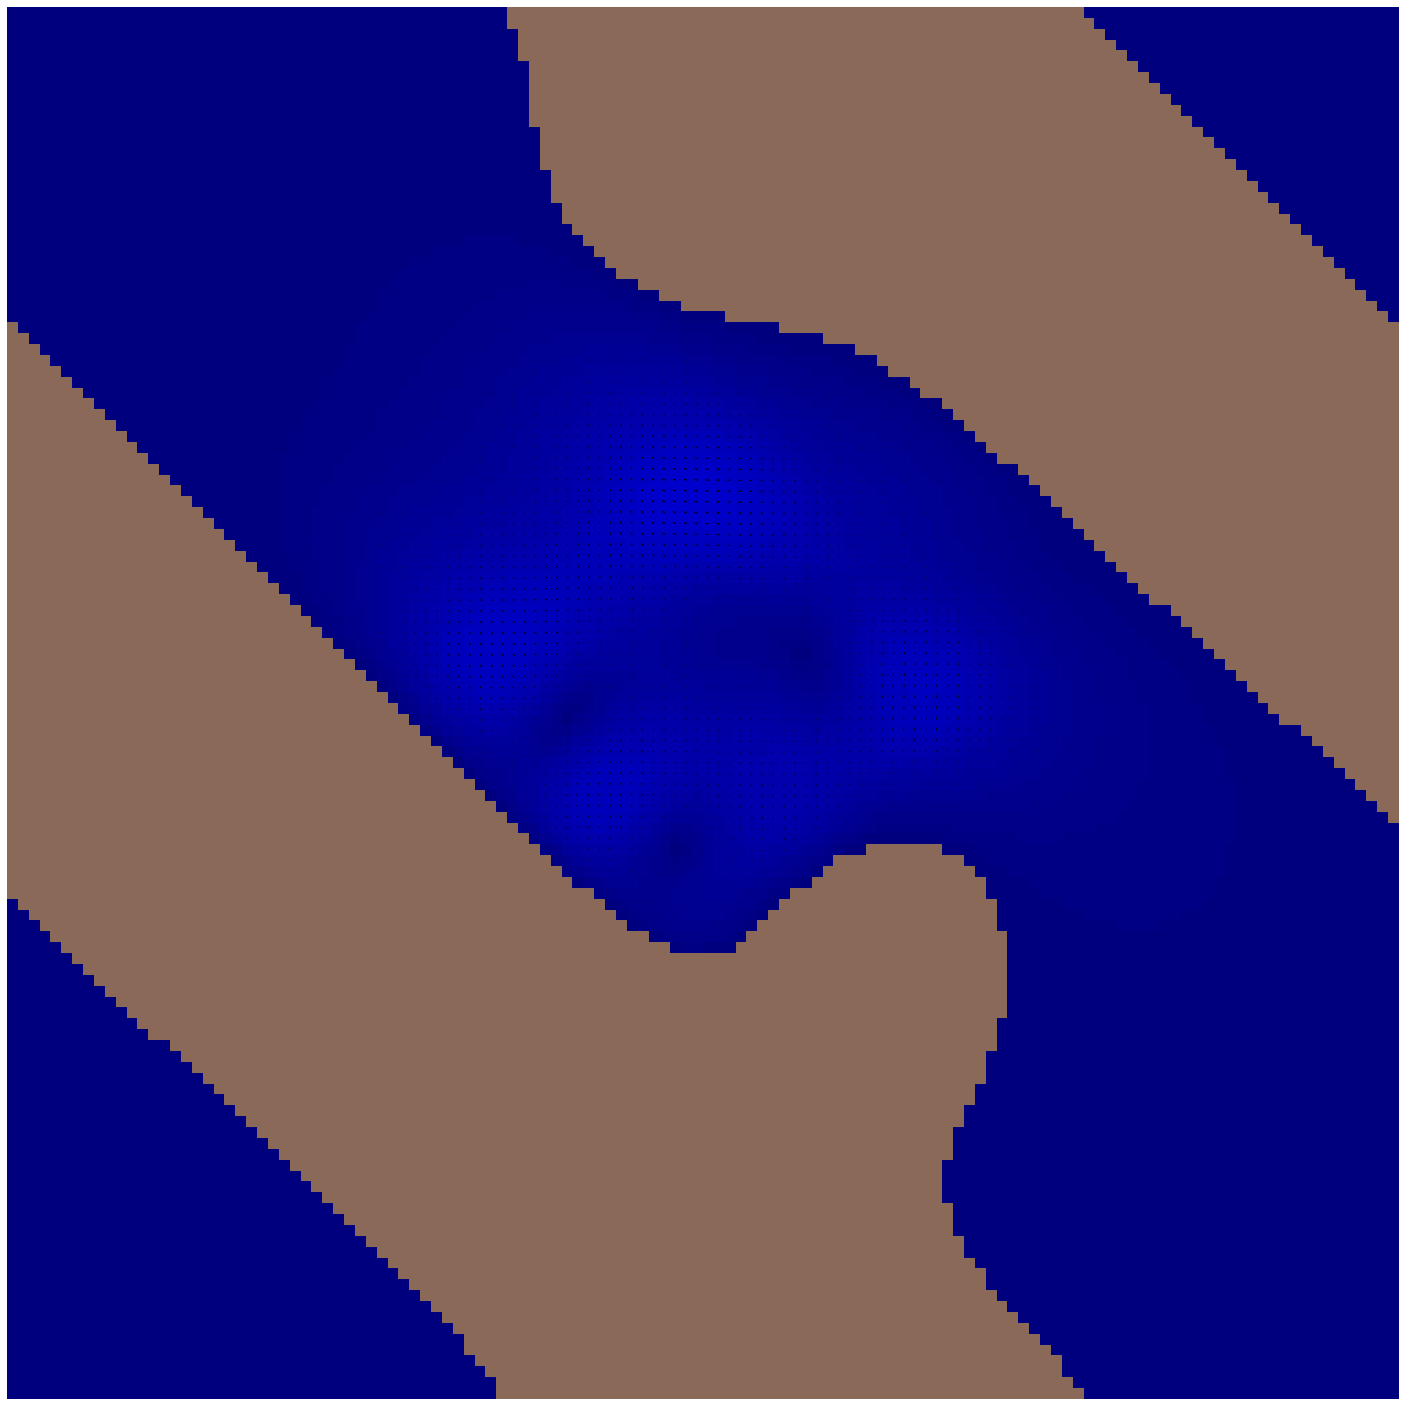

1.7314544523781052 0.00023813145807359255


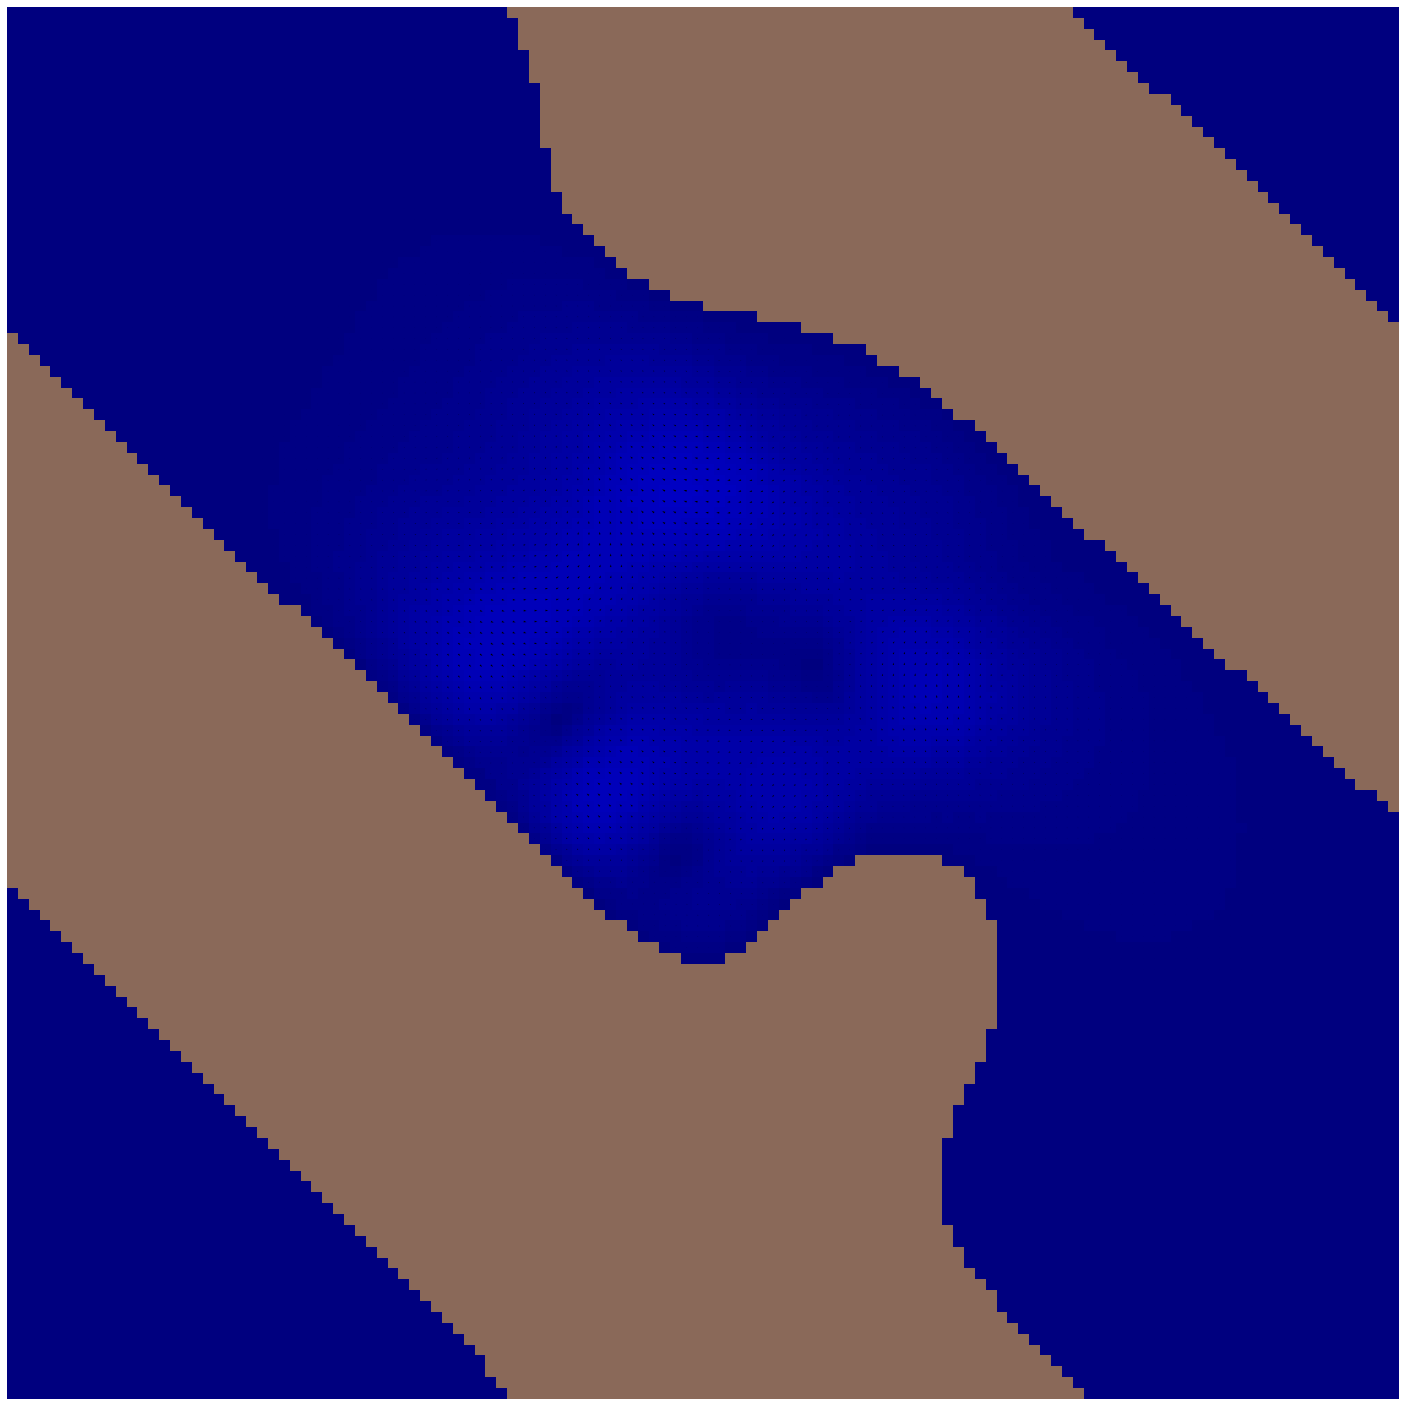

1.7014138486871484 0.00020740629222372987


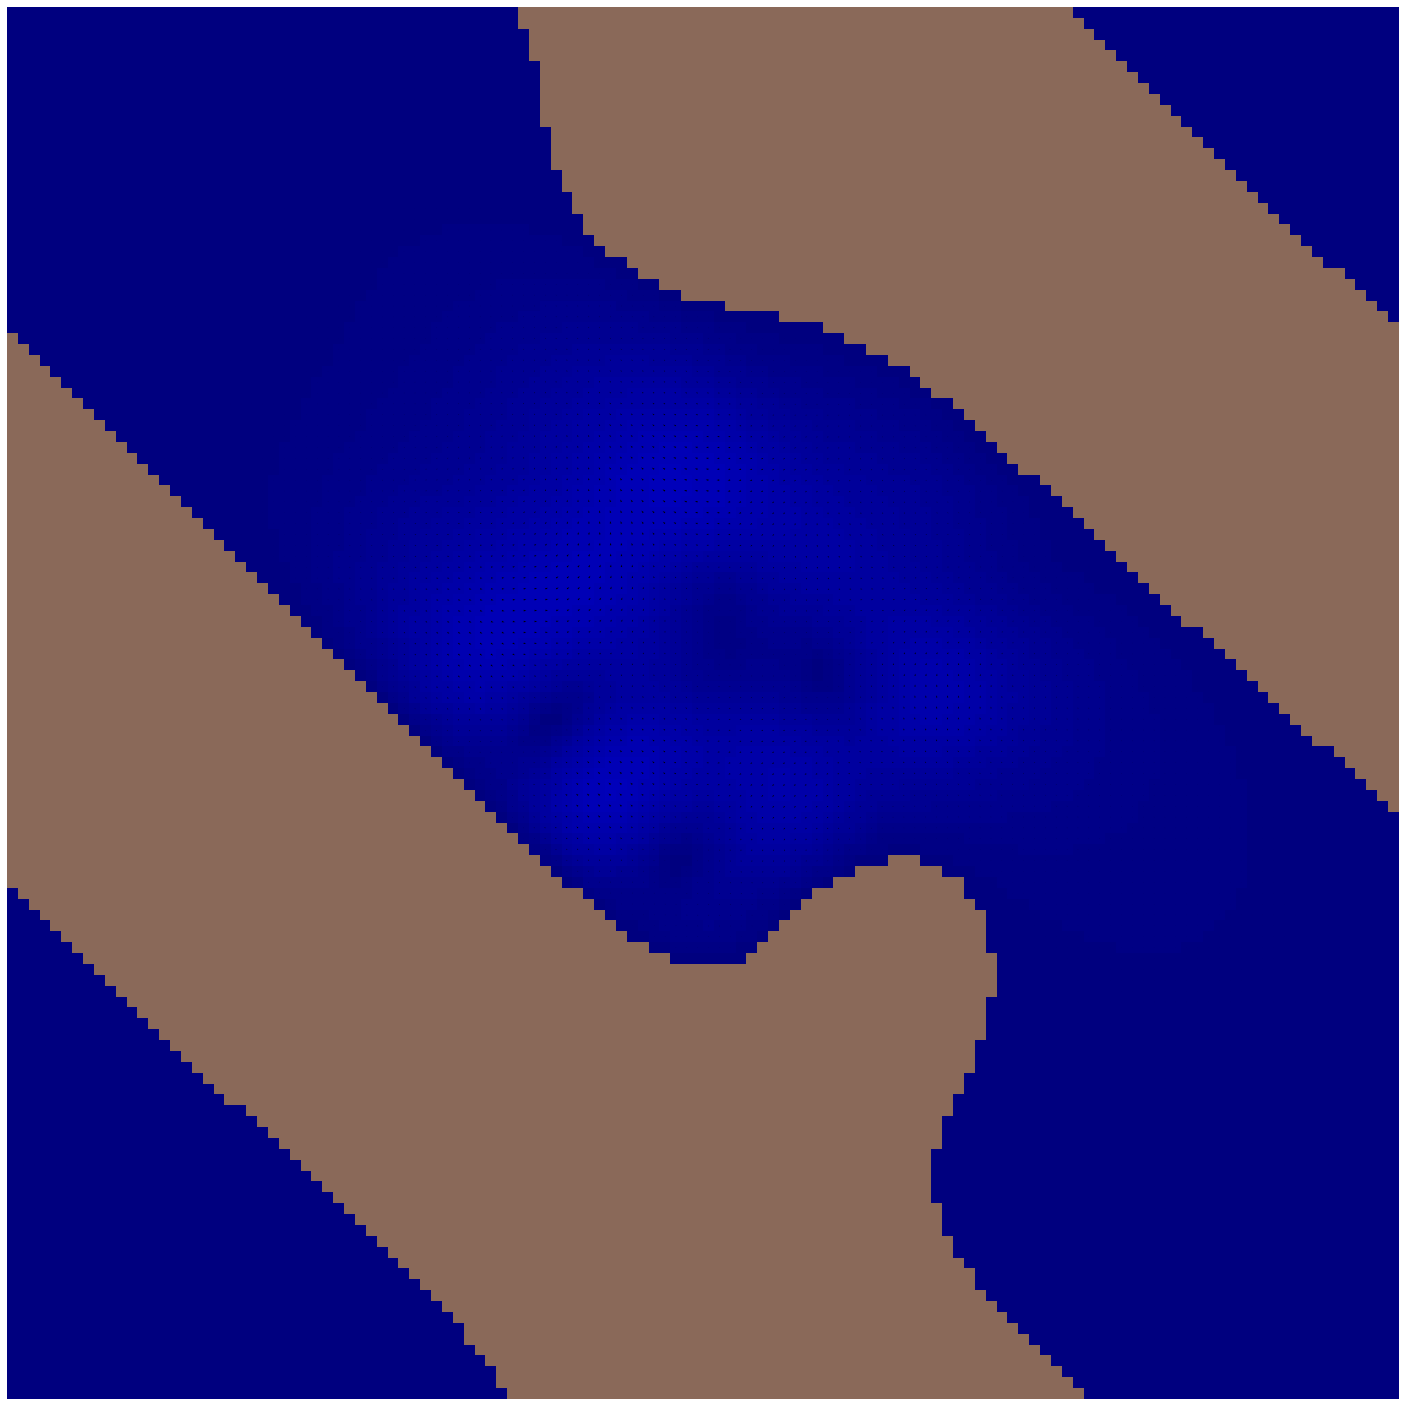

1.6713804570106772 0.0001951837714765948


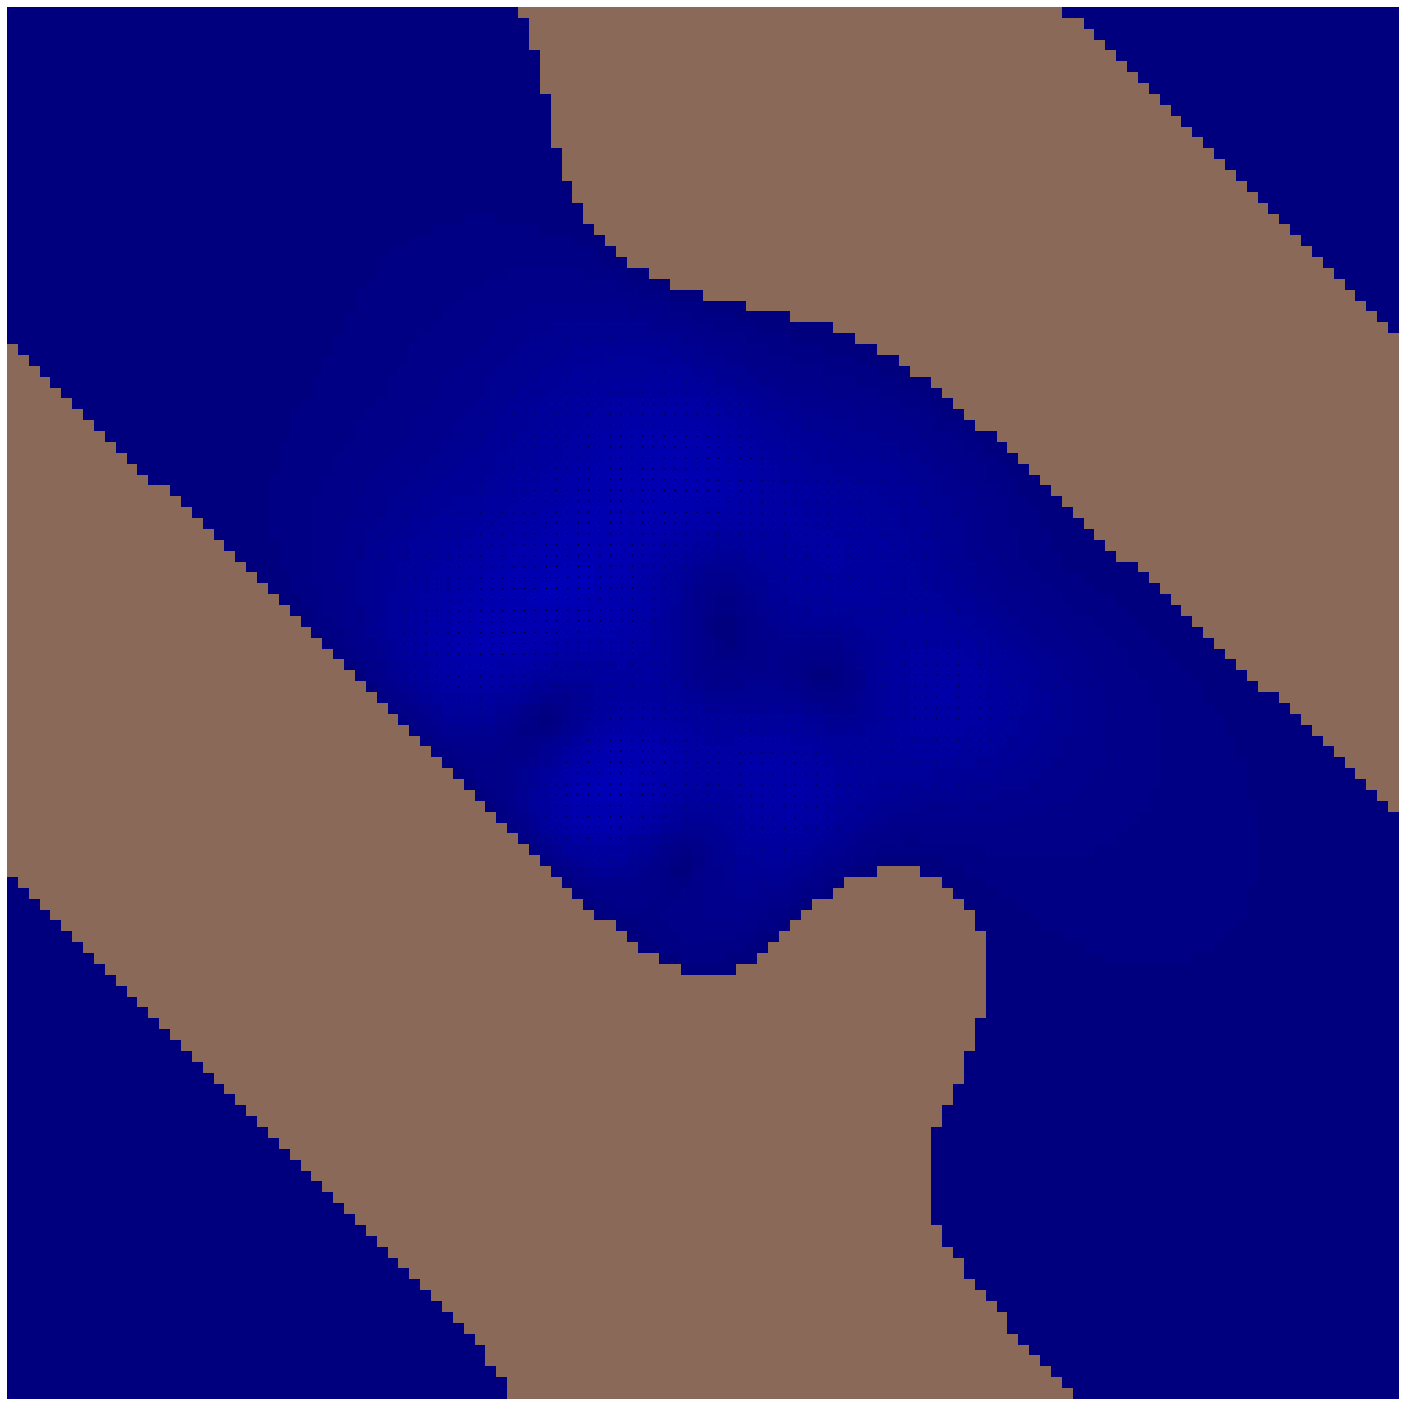

1.6413576057991168 0.00018854636762121601


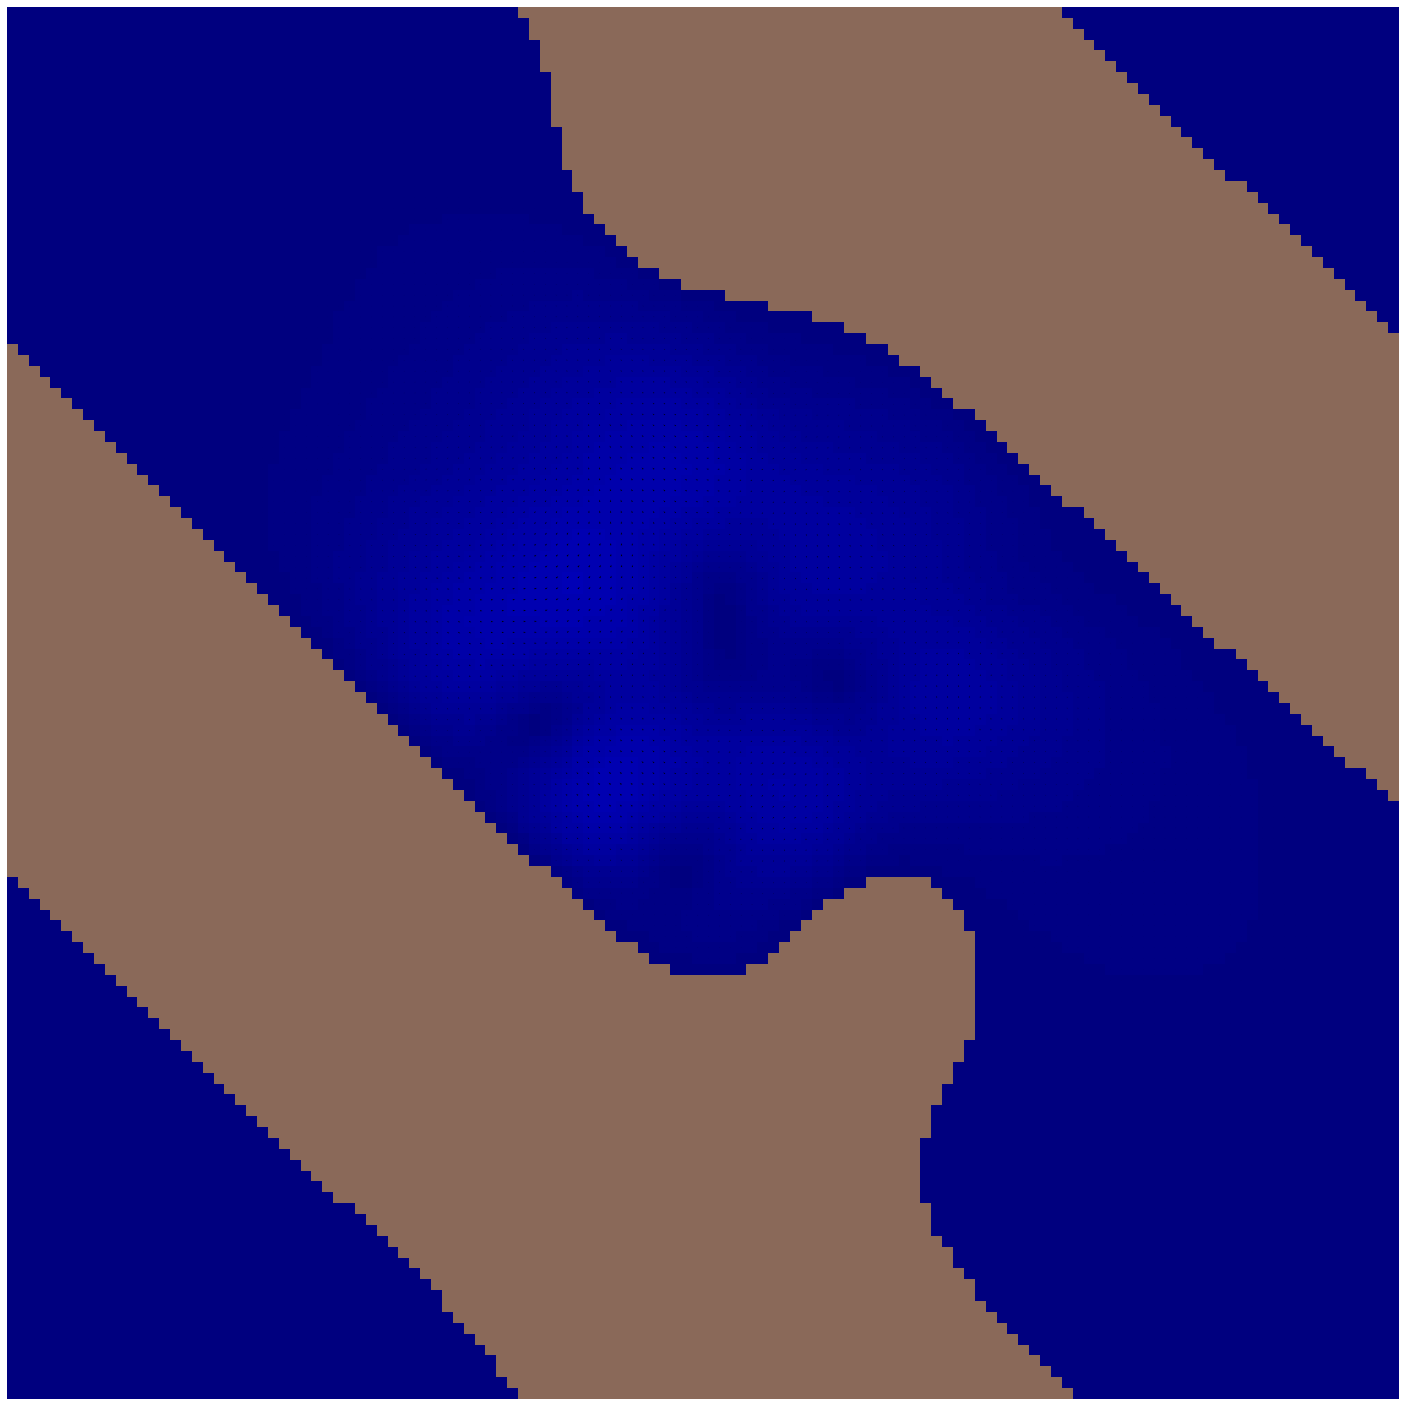

1.6113397702964183 0.0001831705186273479


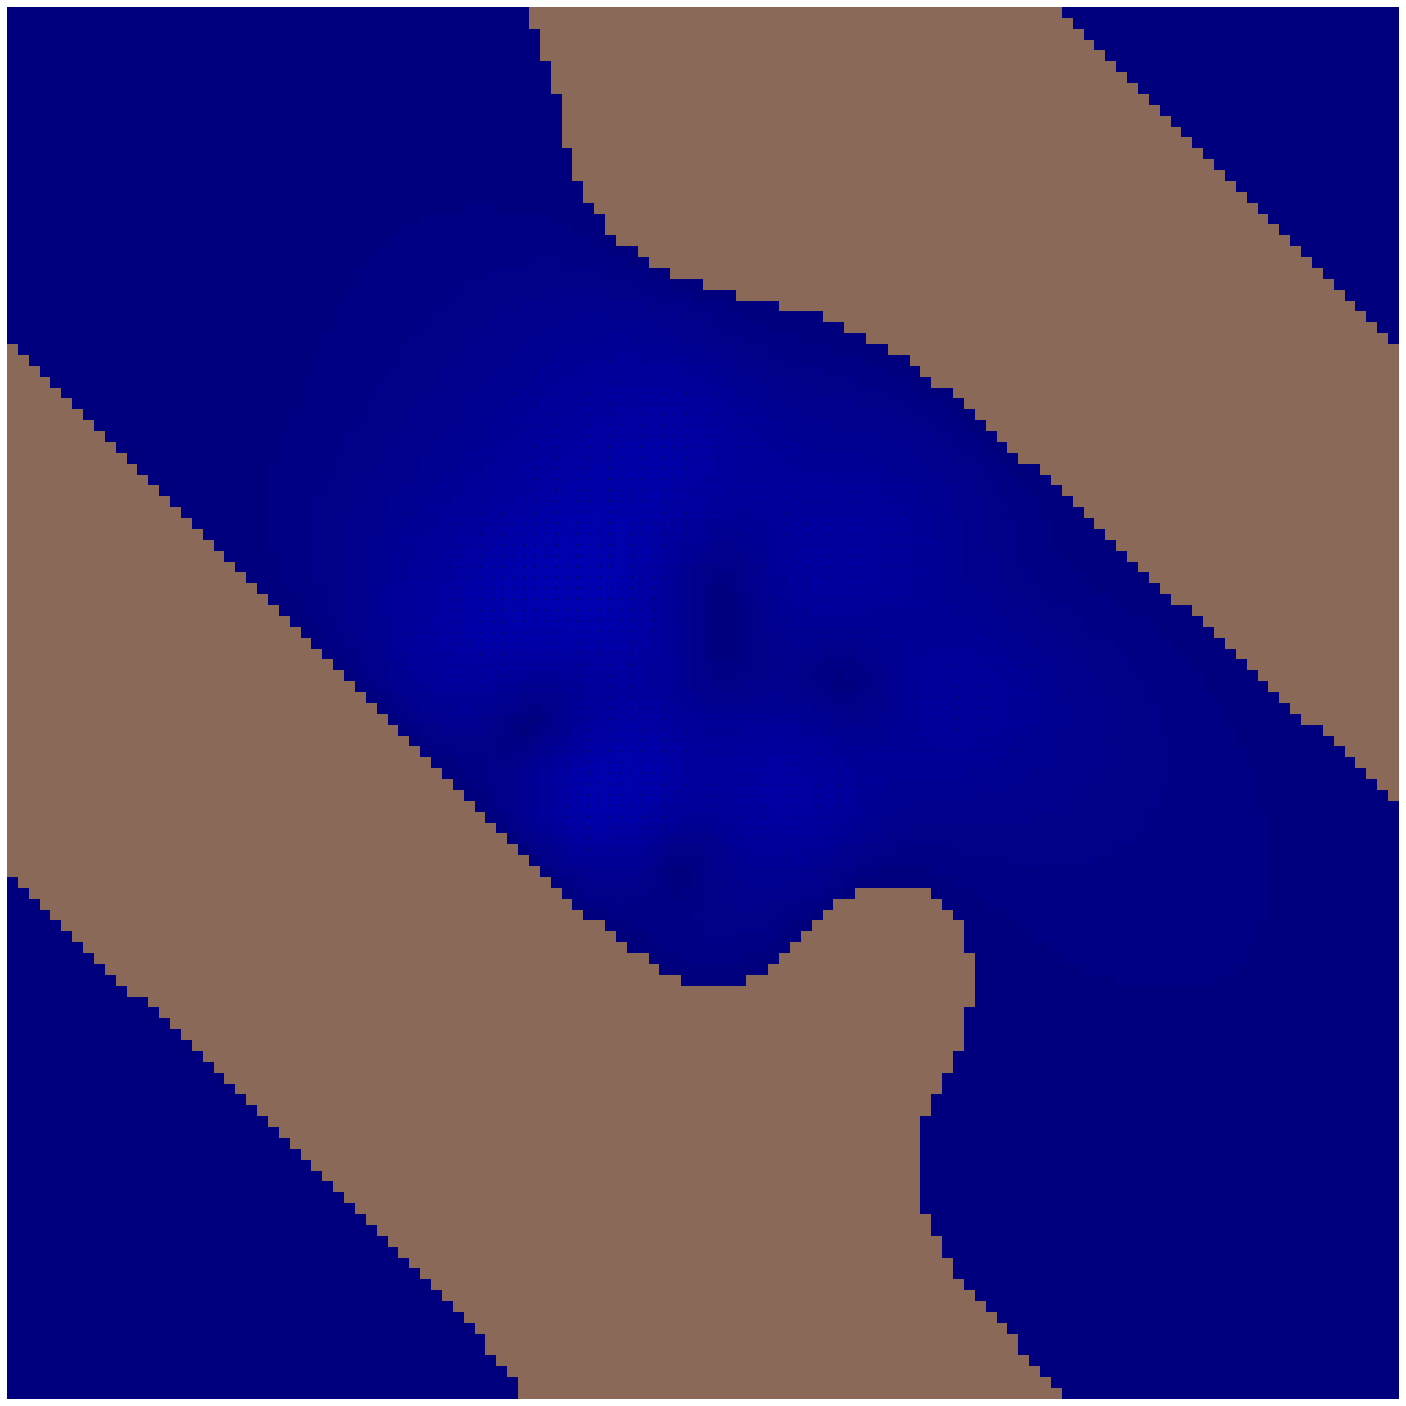

1.5813249467228205 0.0001773544135272411


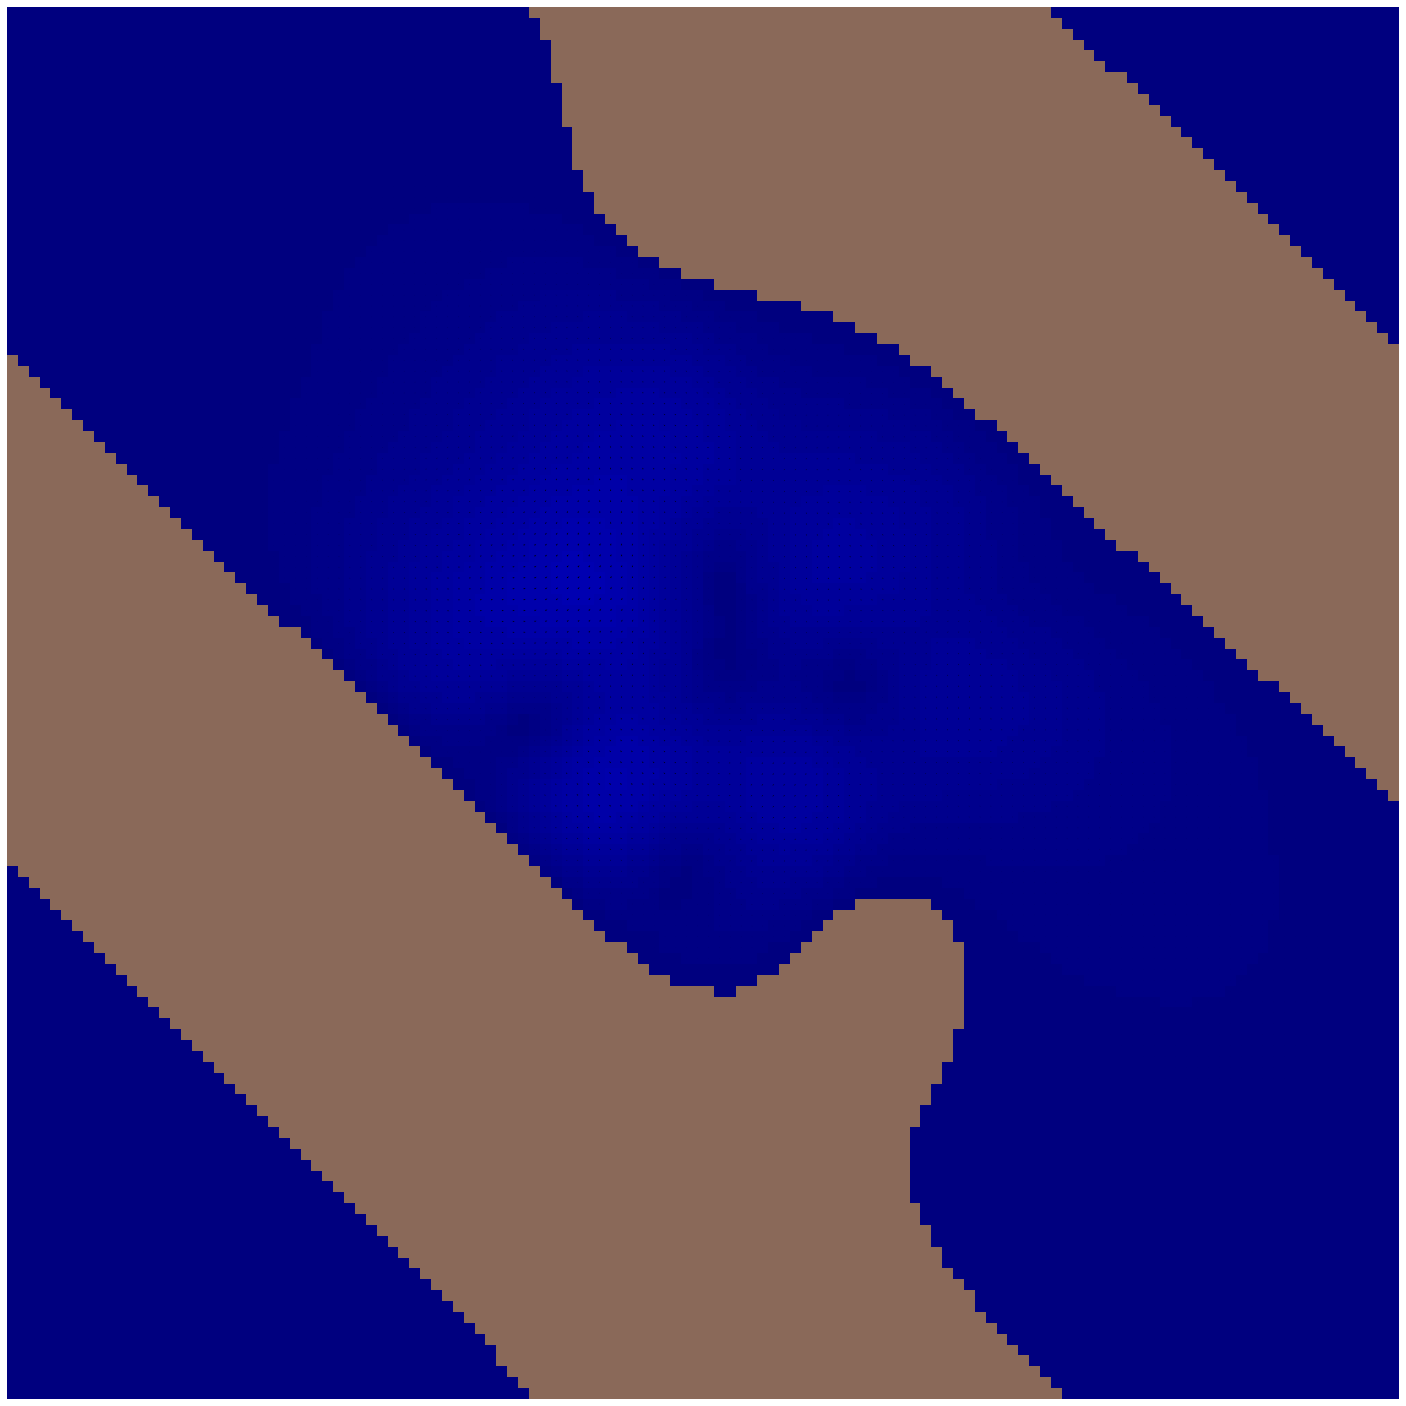

1.5513122792199125 0.0001711651934860189


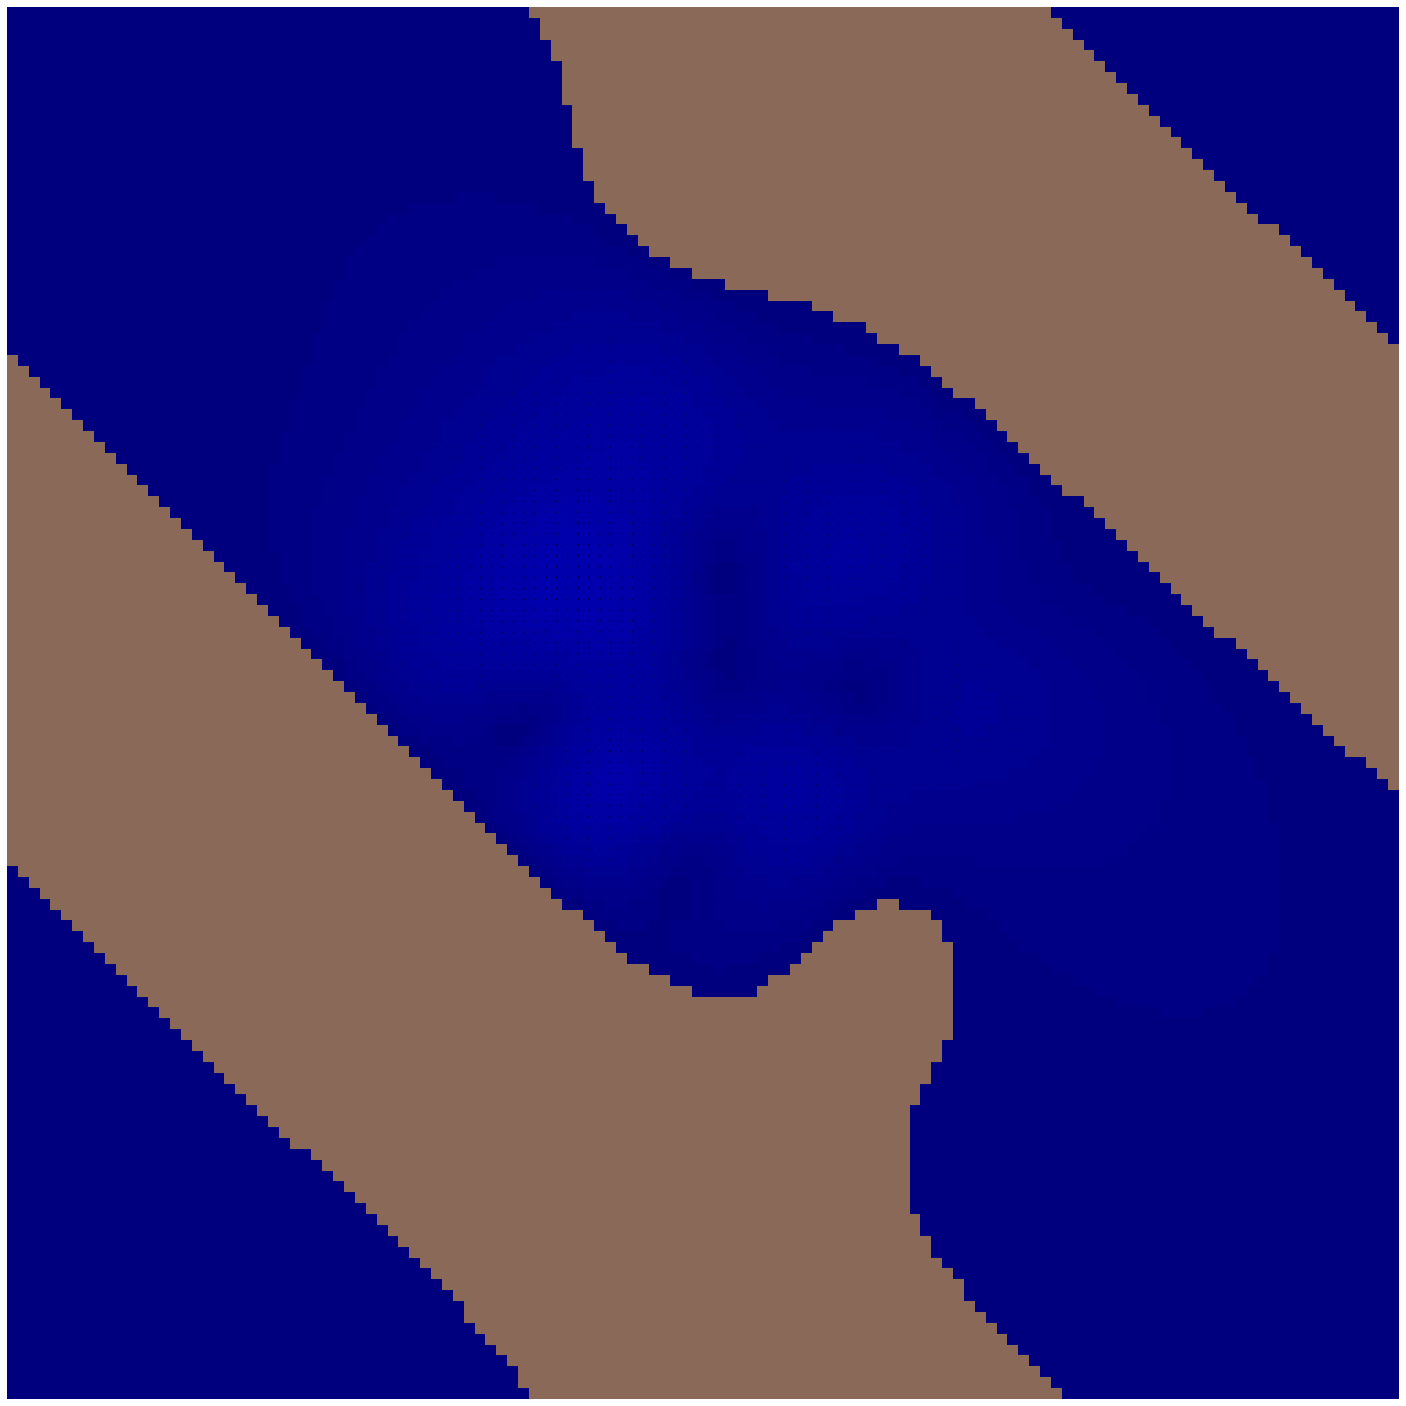

1.5213015725762526 0.00016473038577972355


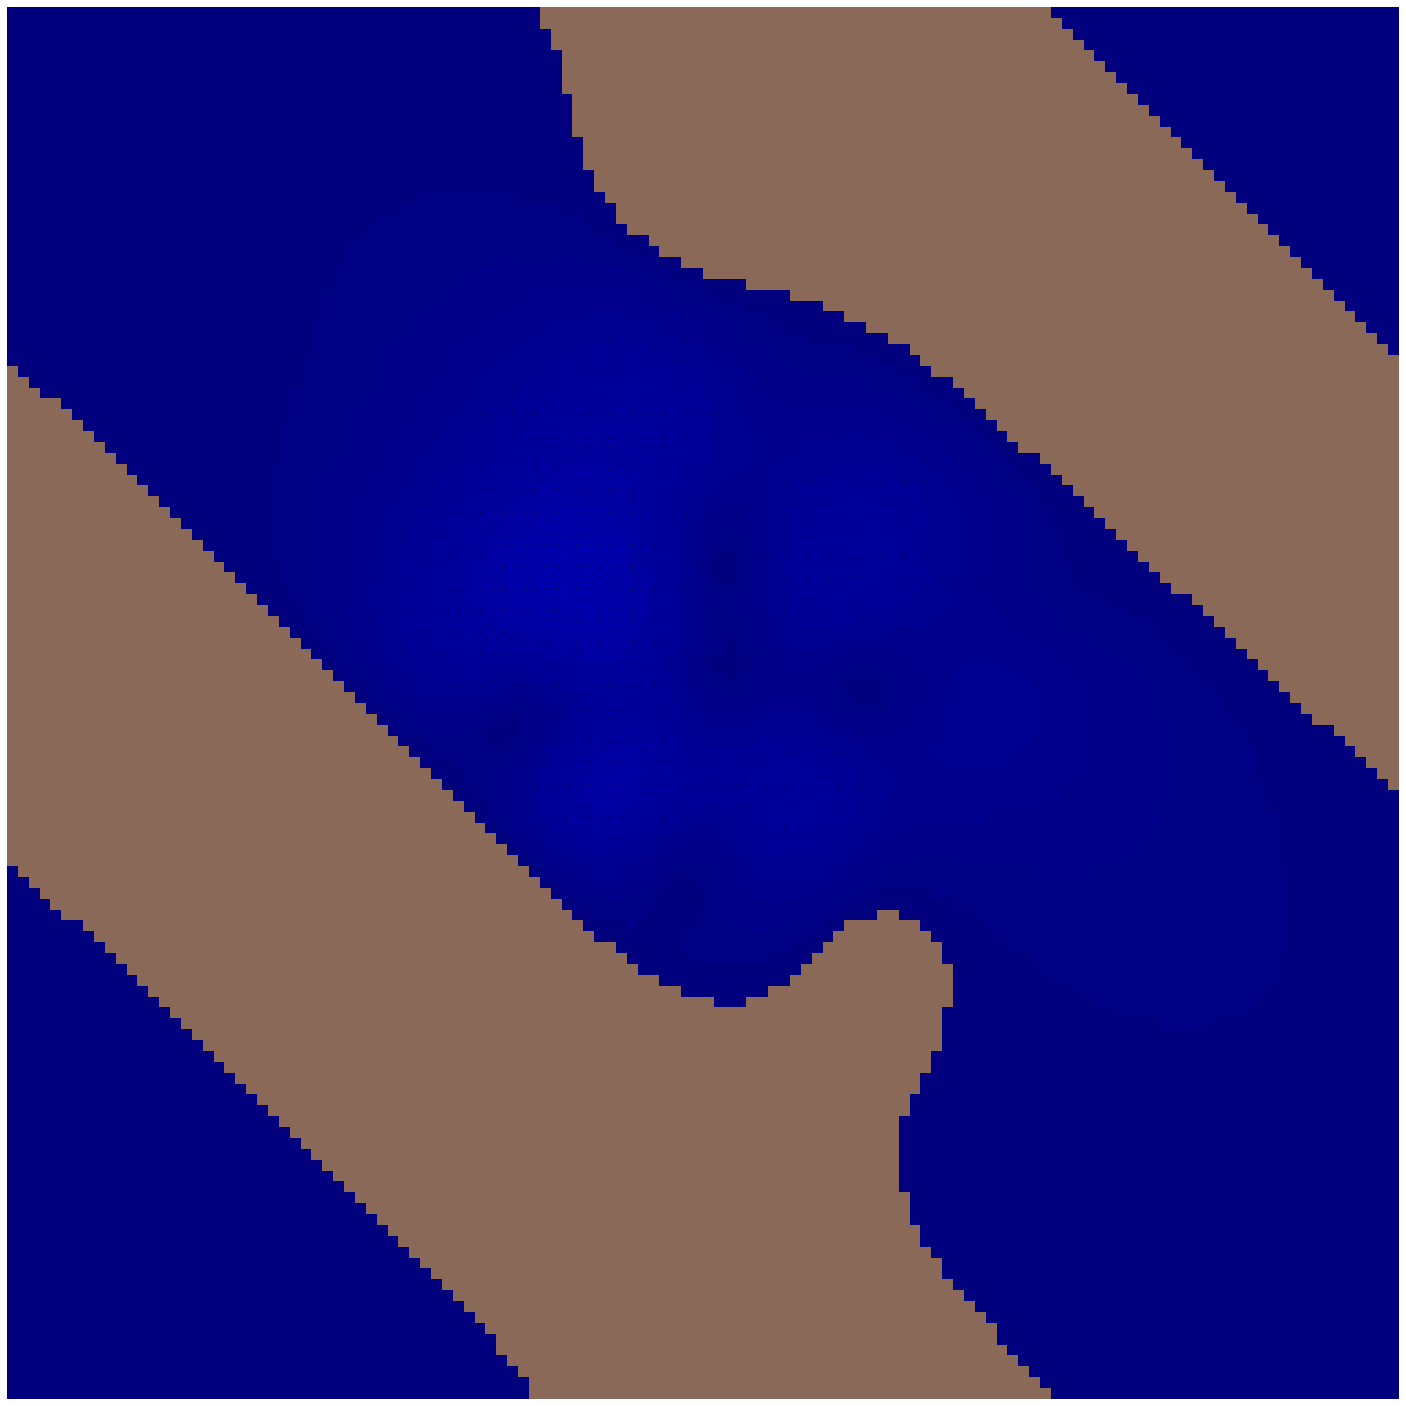

1.4912922264793746 0.00015824214916812724


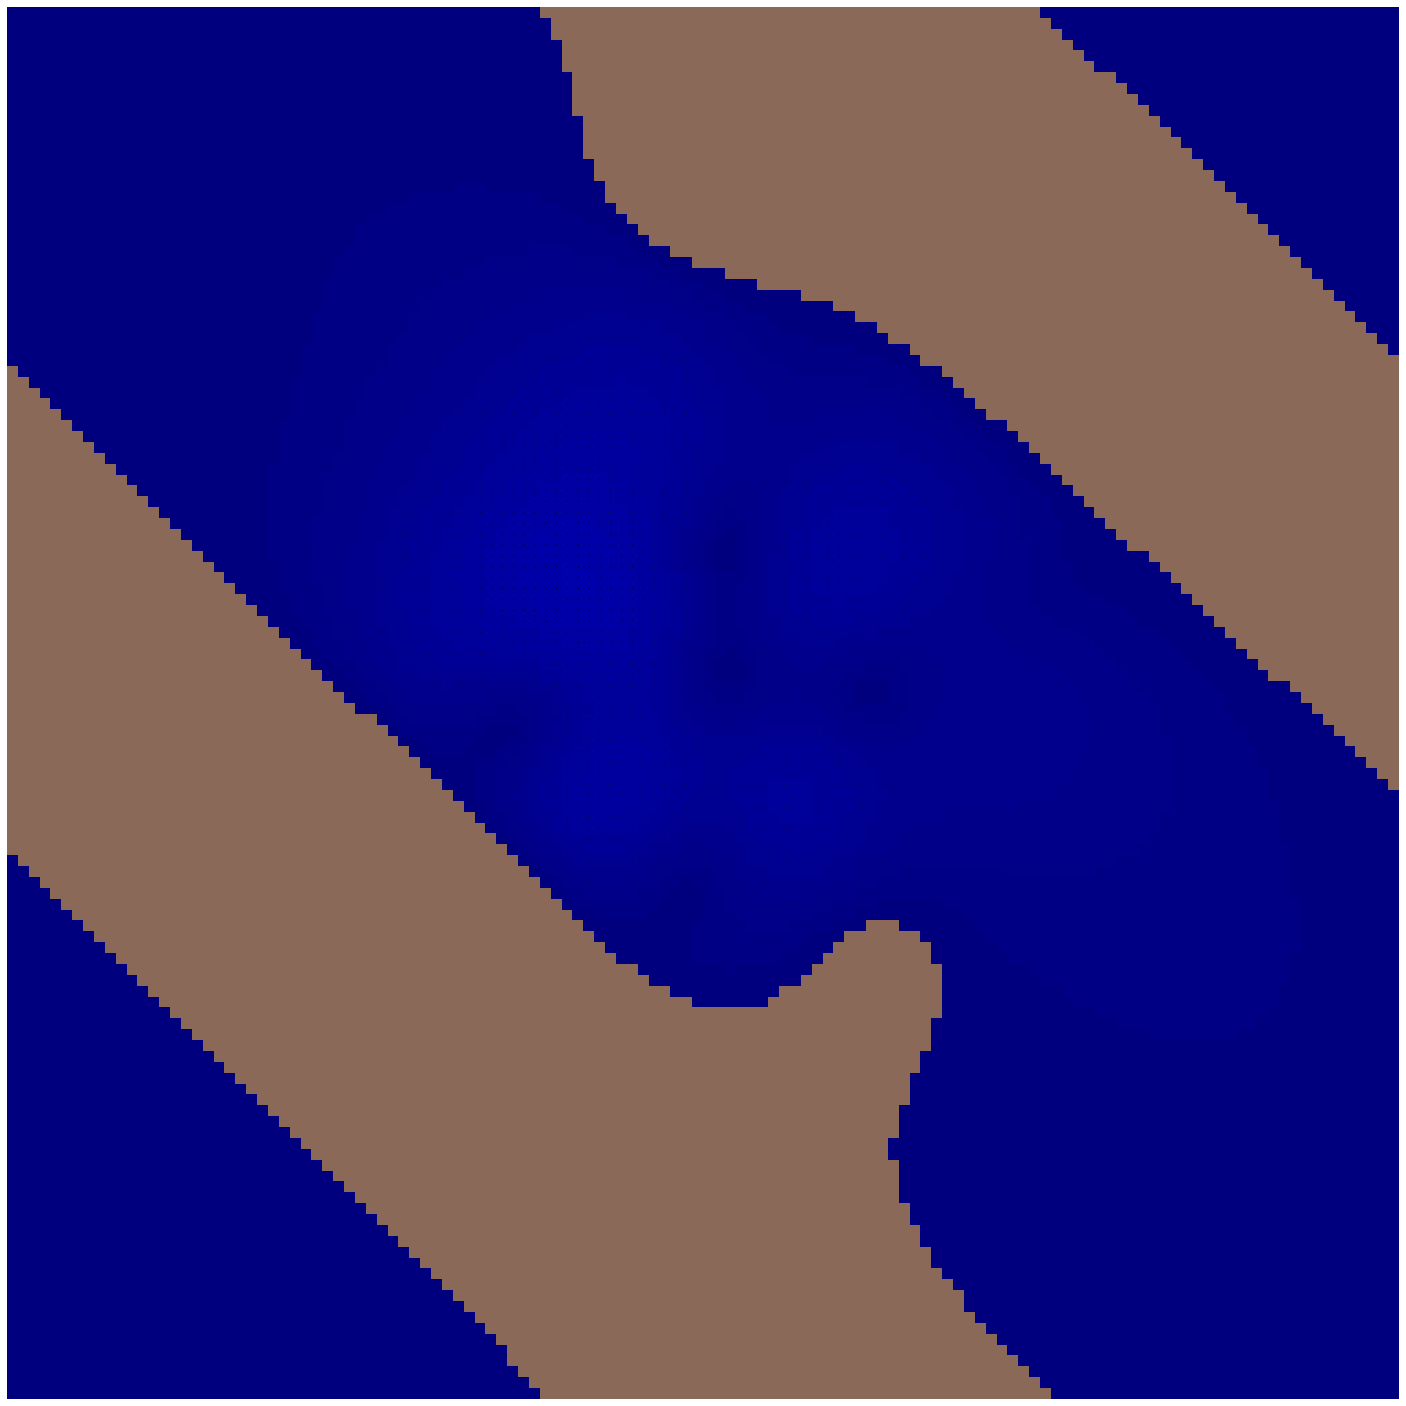

1.4612841416858333 0.00015177437554509708


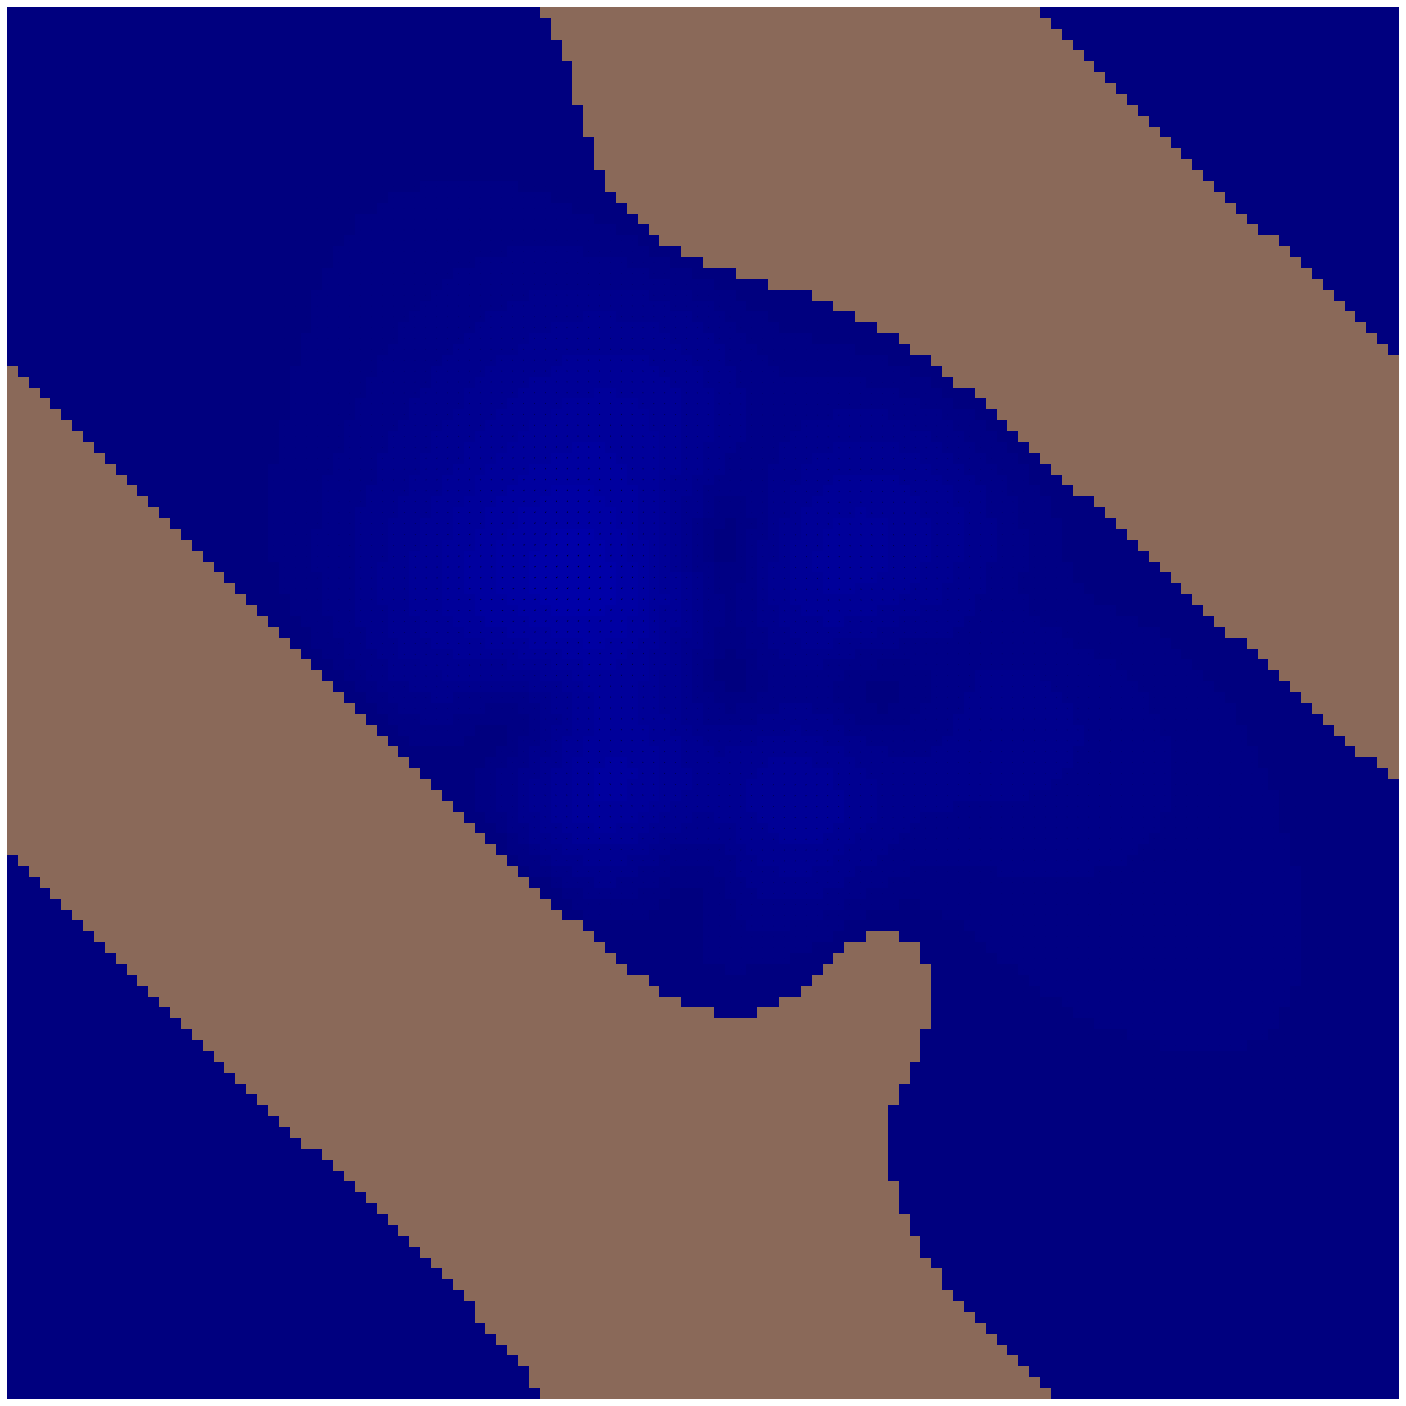

1.4312769226426587 0.00014544821511679404


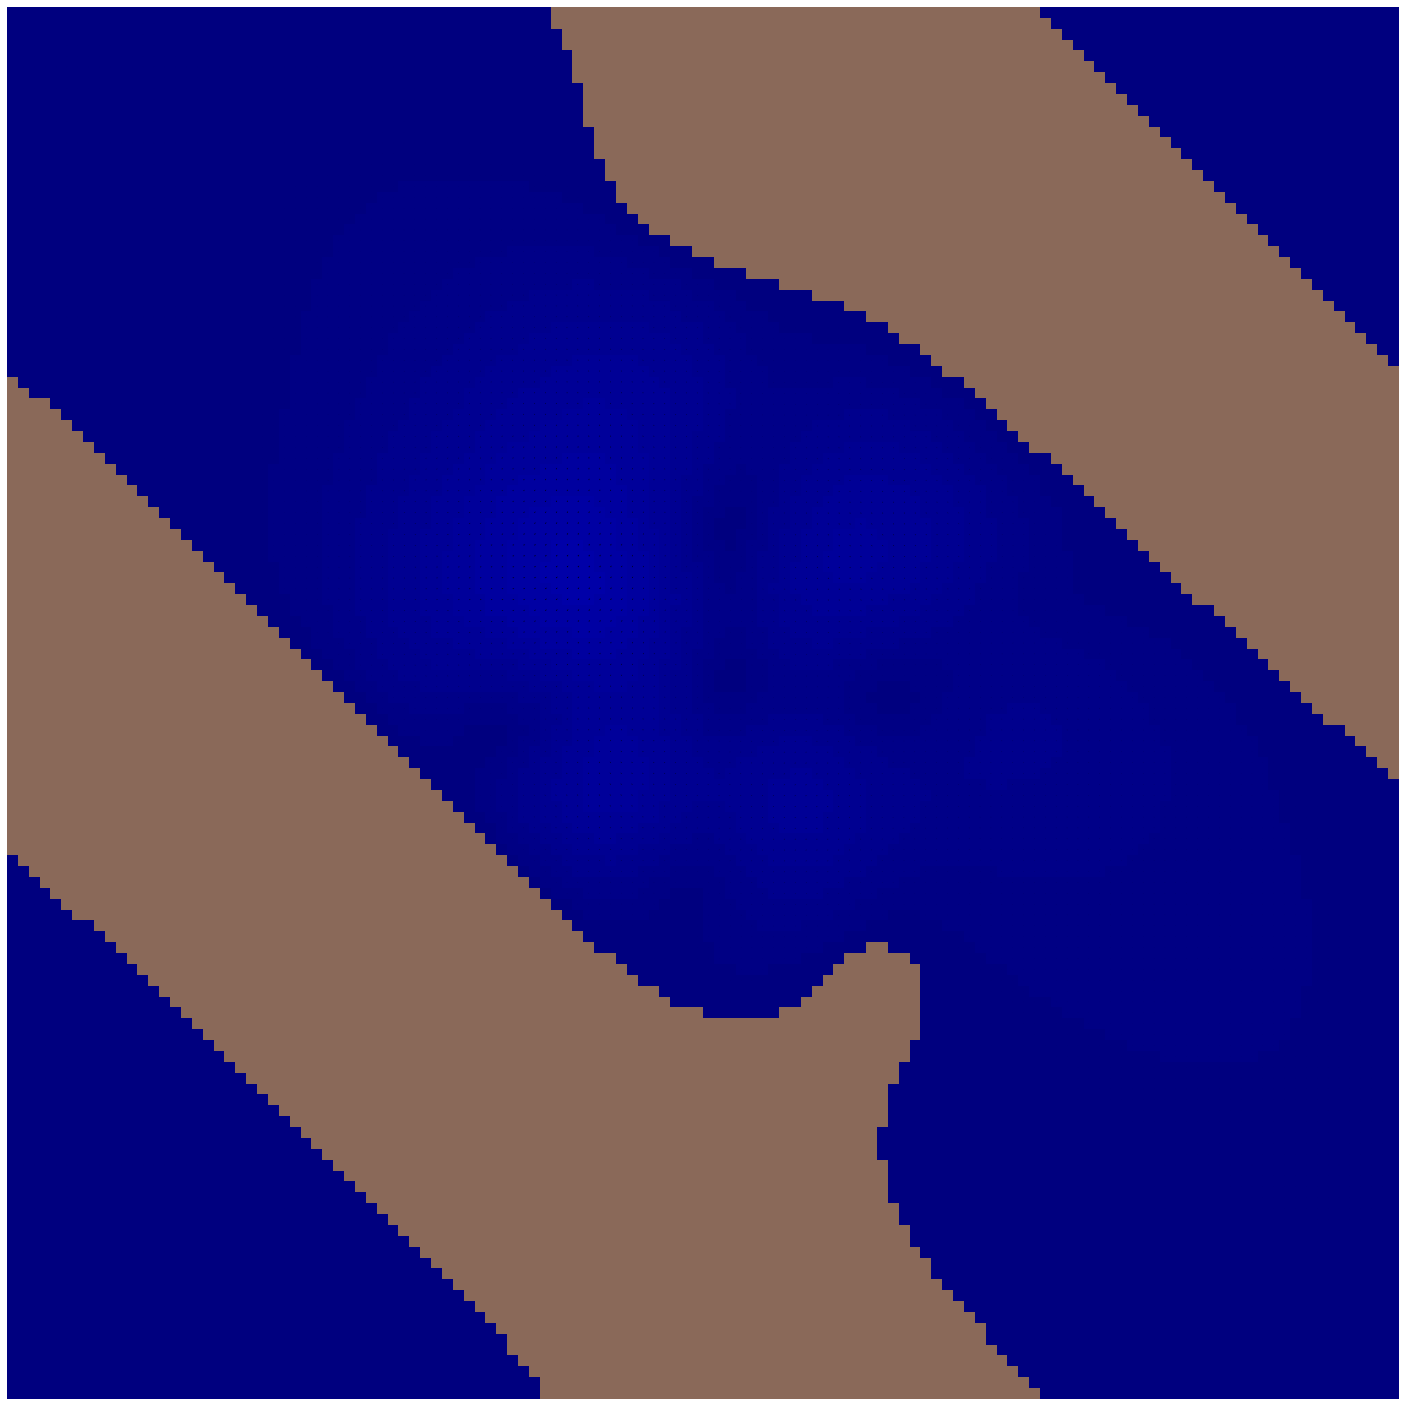

1.401270569282902 0.00013932988147801094


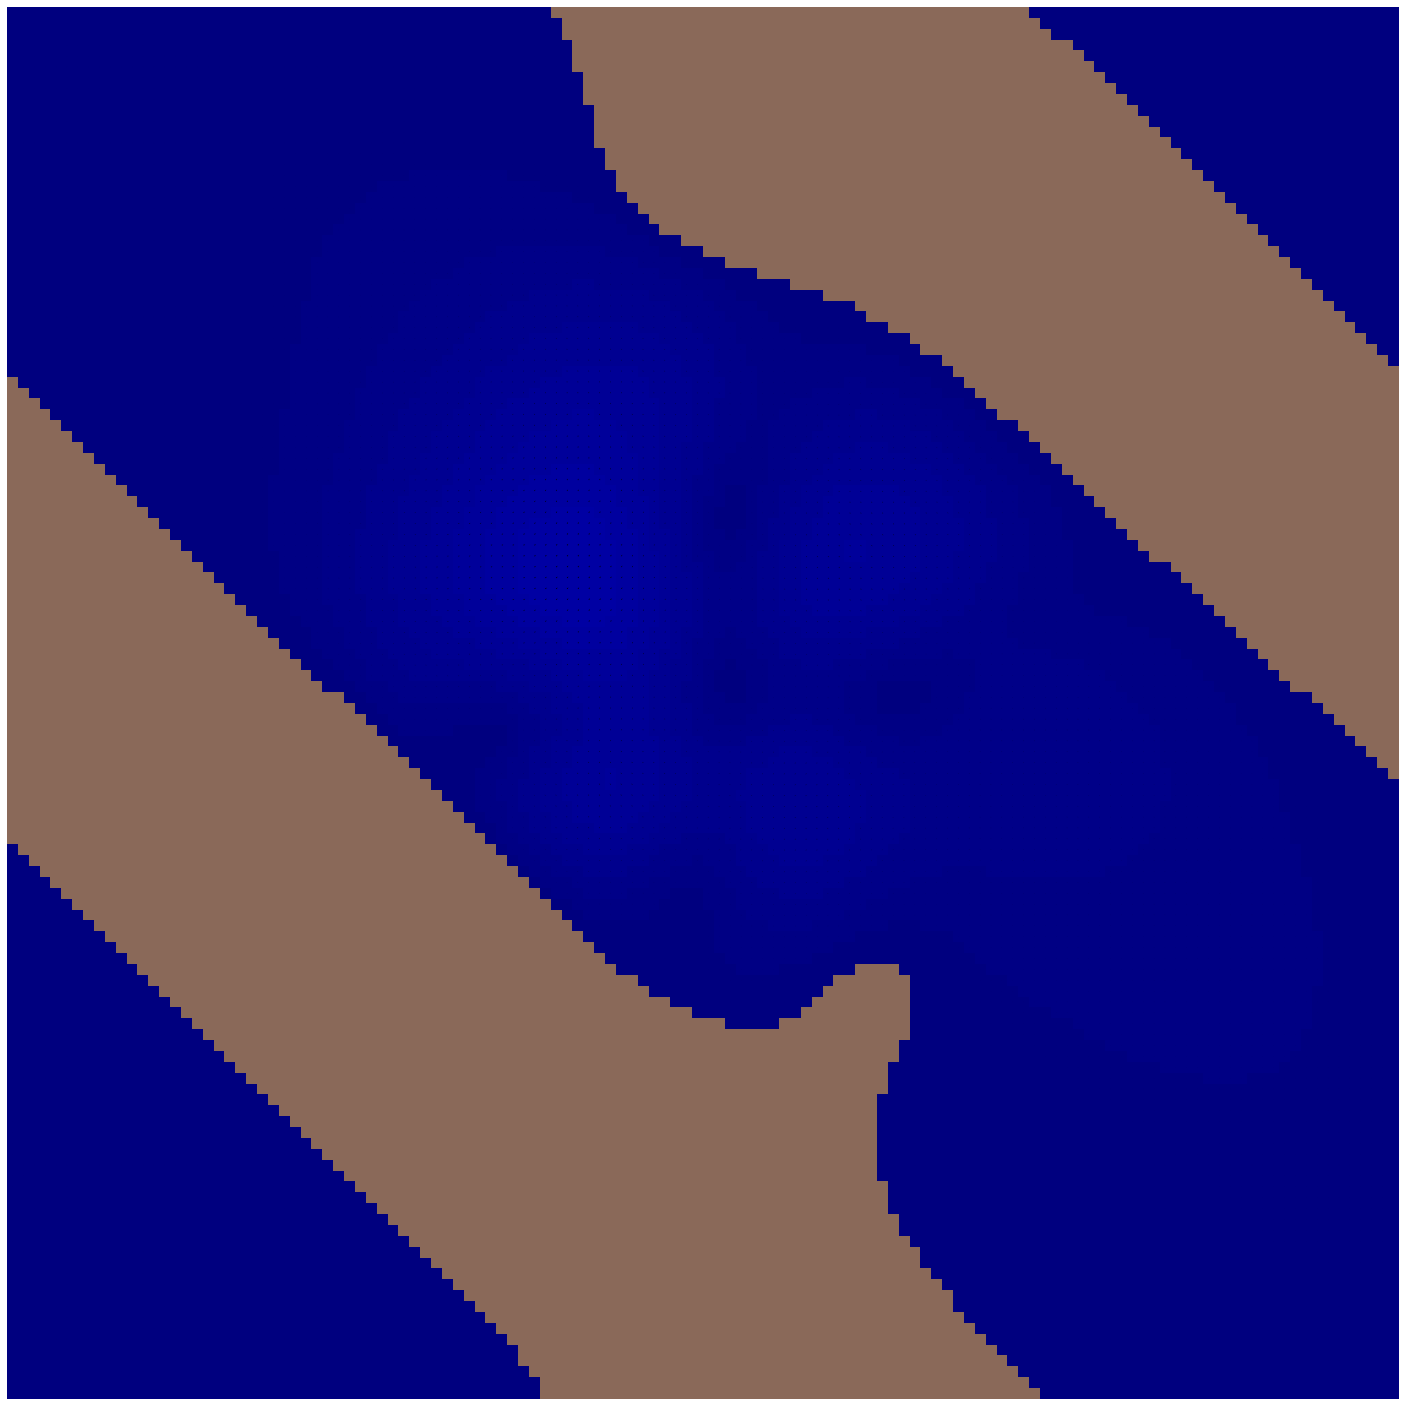

1.3712647998563323 0.00013368191711119476


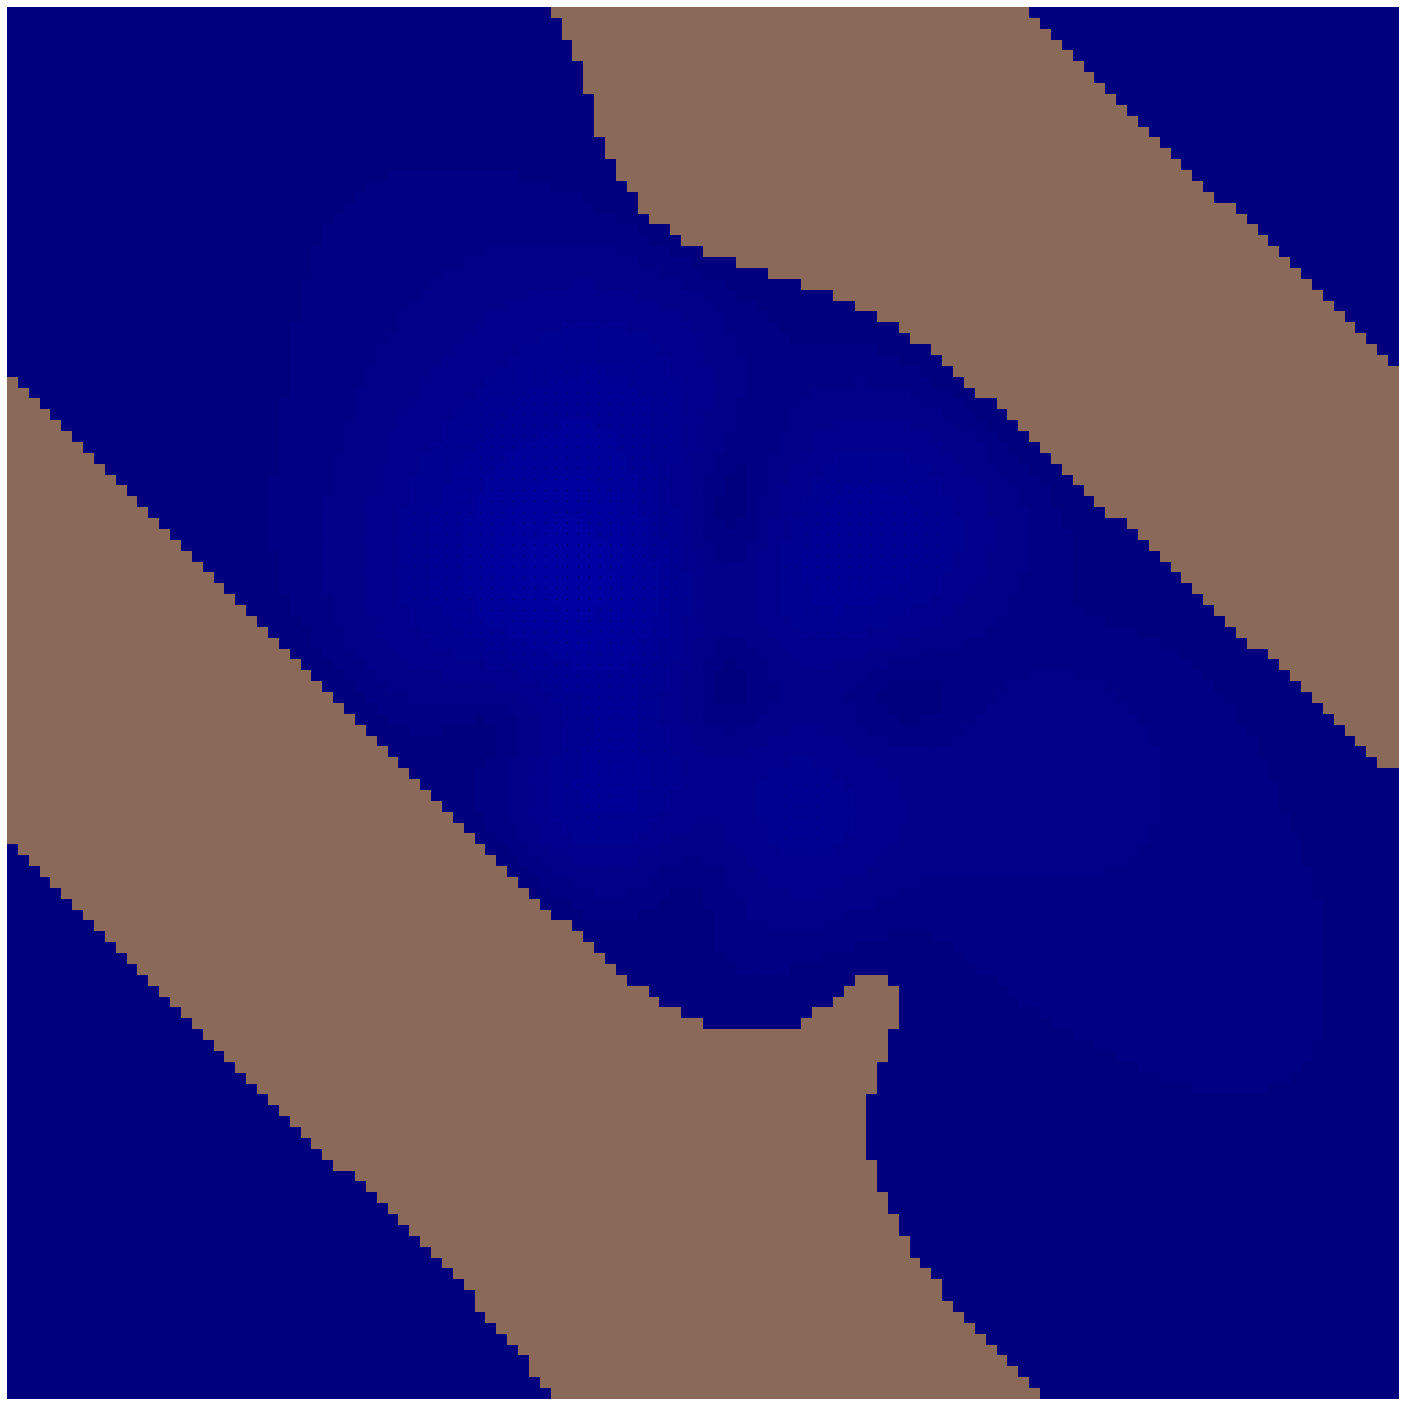

1.3412596268241521 0.00012827279620690452


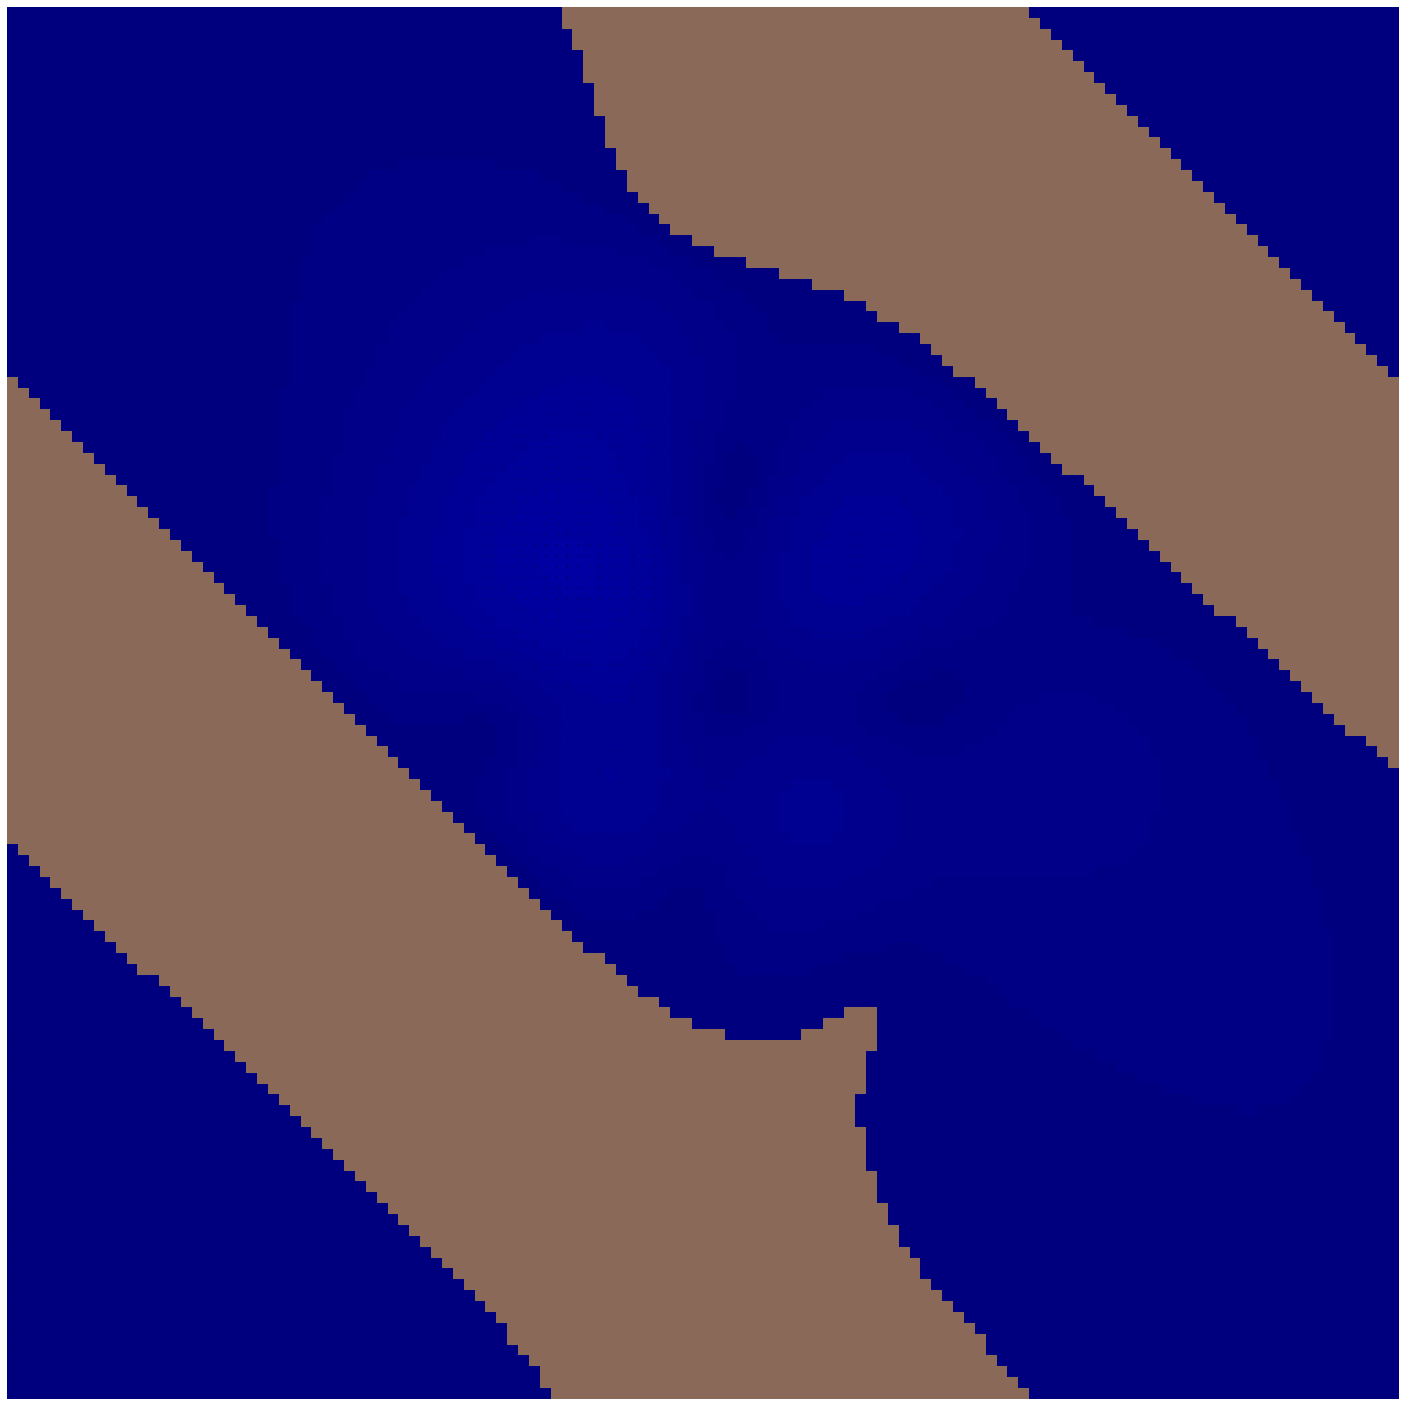

1.3112548079040414 0.00012312571274496477


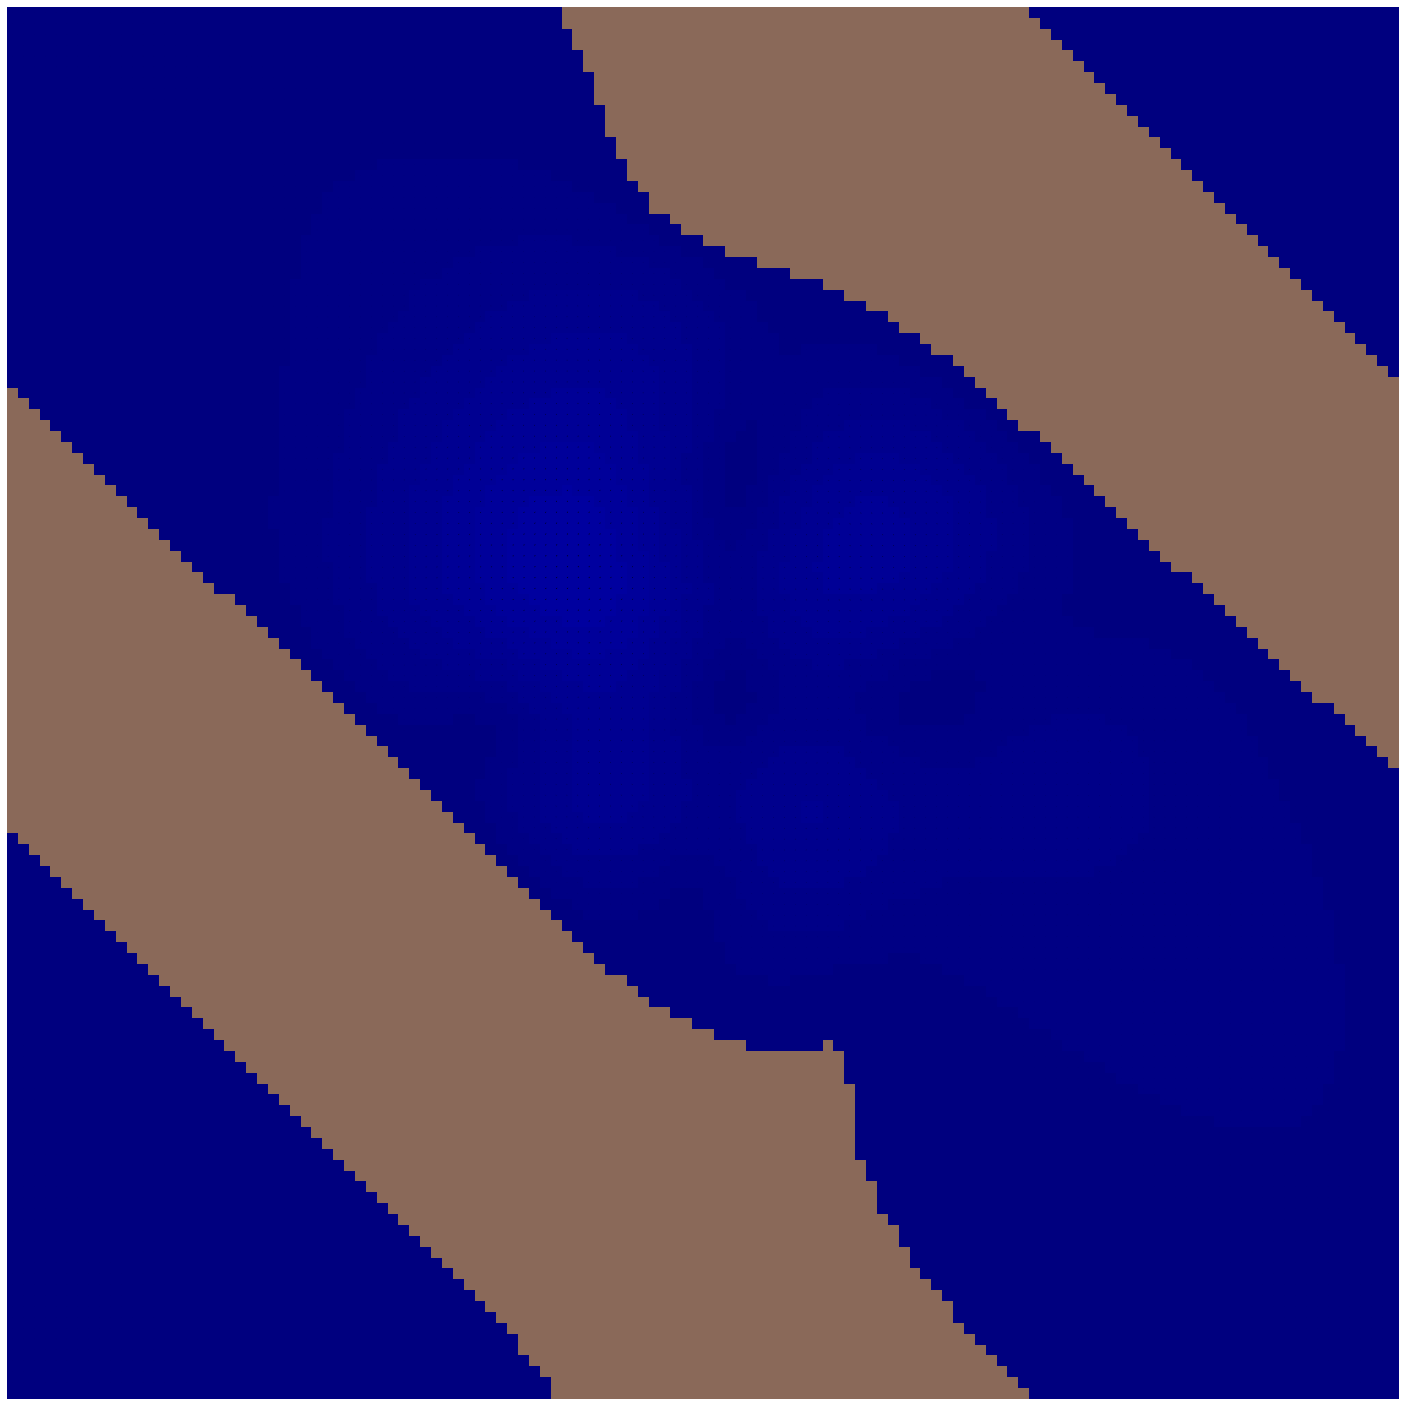

1.2812504379142053 0.00011826262189212779


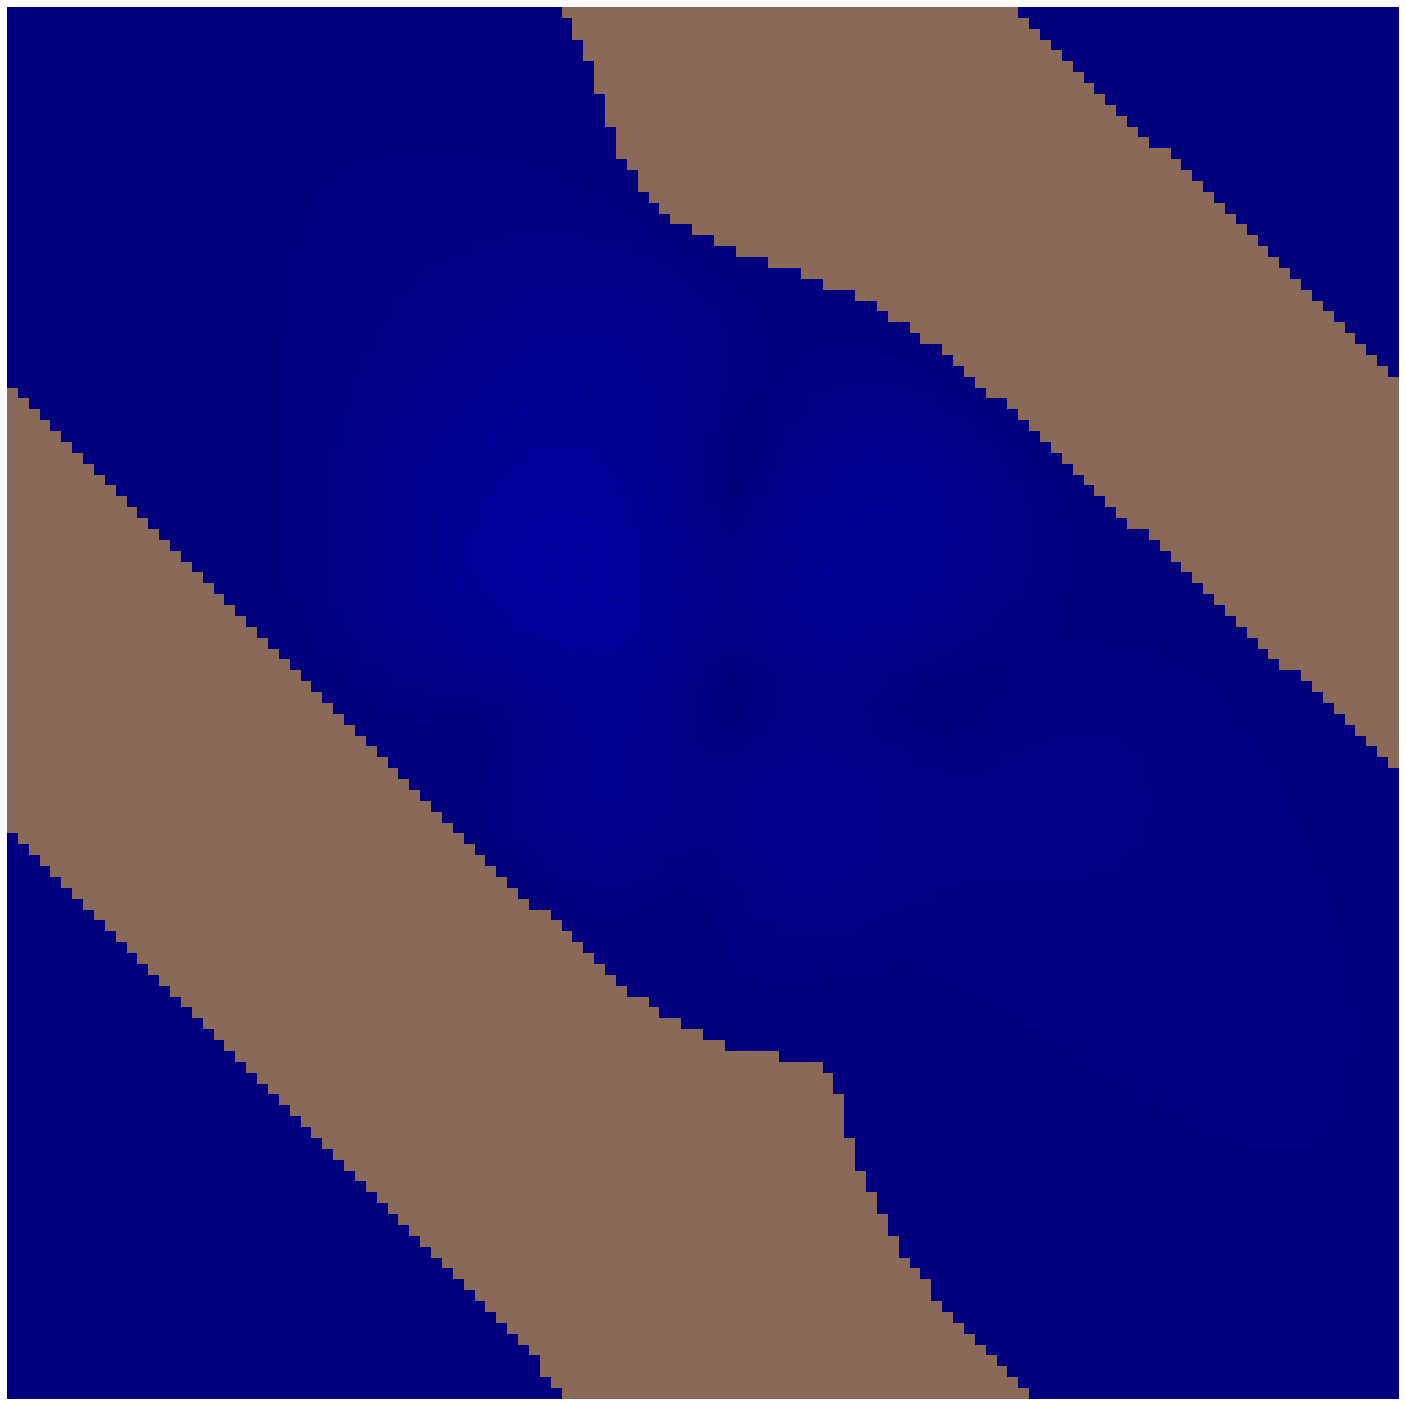

1.2512463006357923 0.00011376759974721798


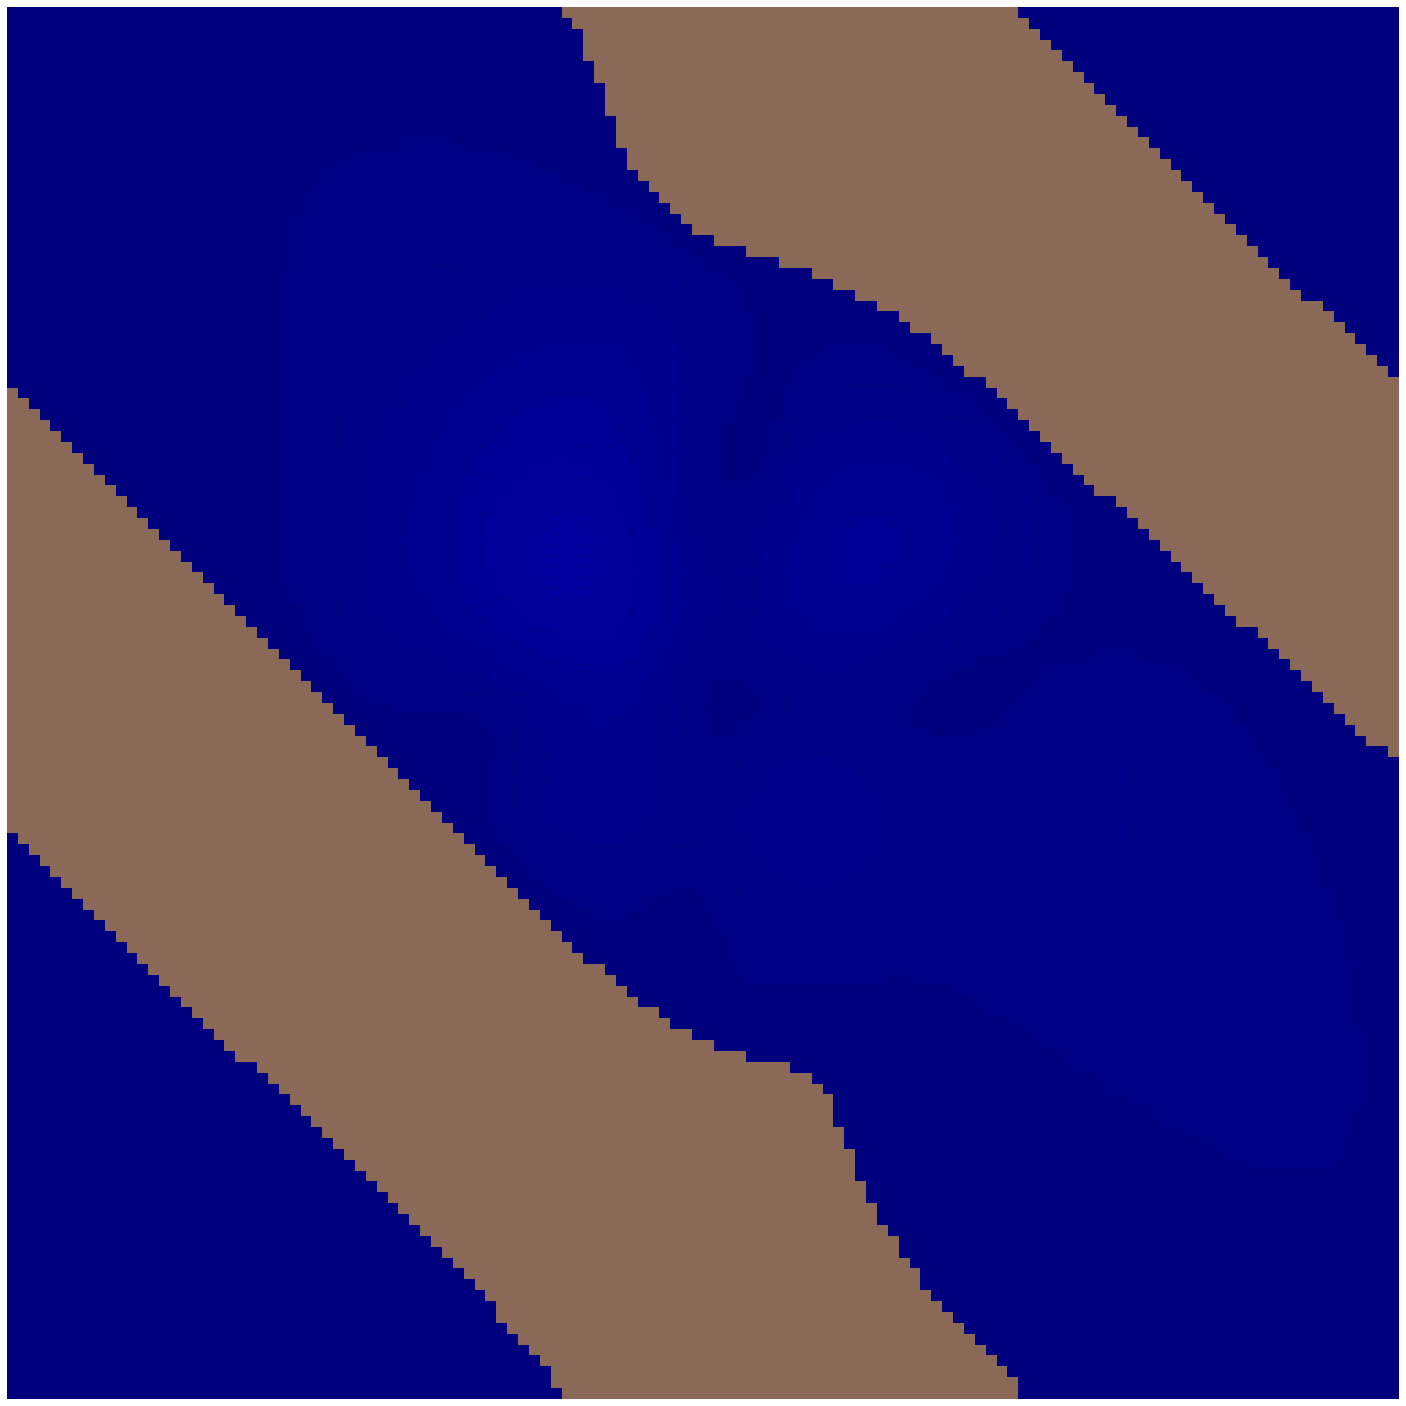

1.221242481916681 0.00010962949386920031


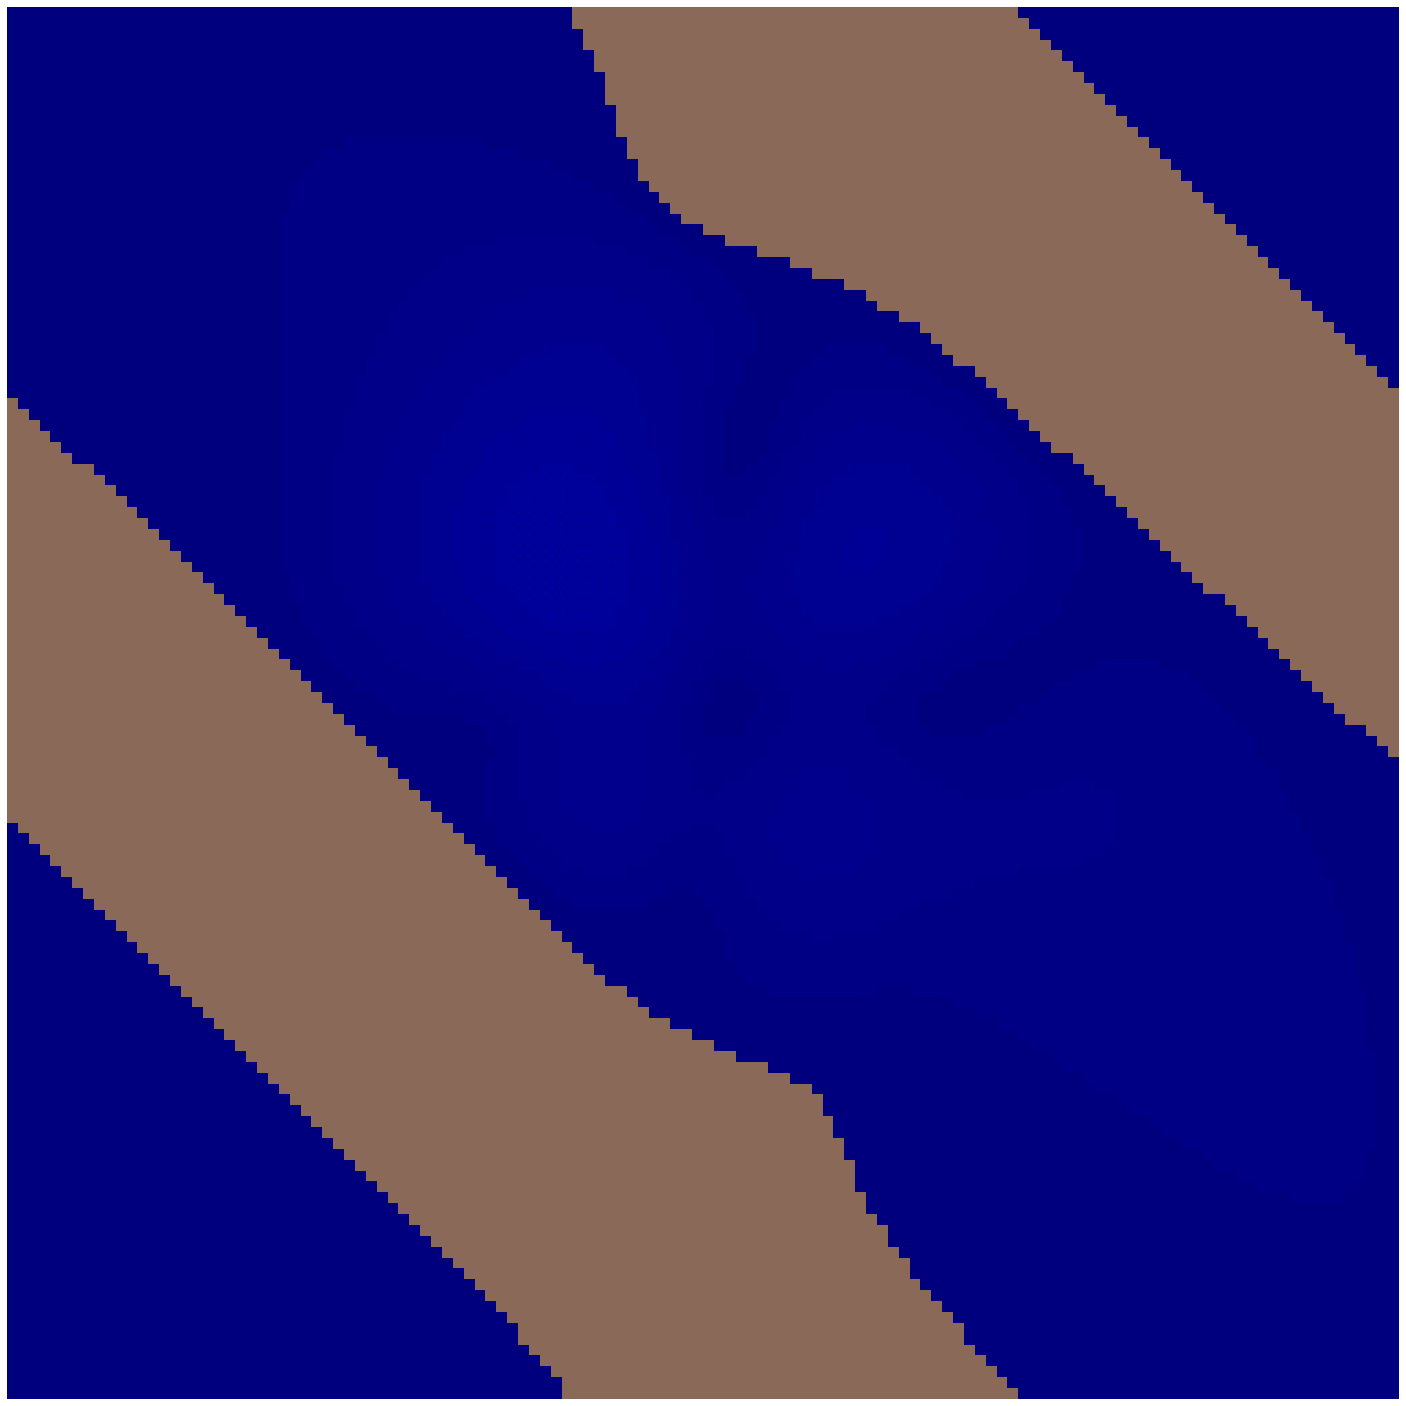

1.1912388175437505 0.0001057764554759103


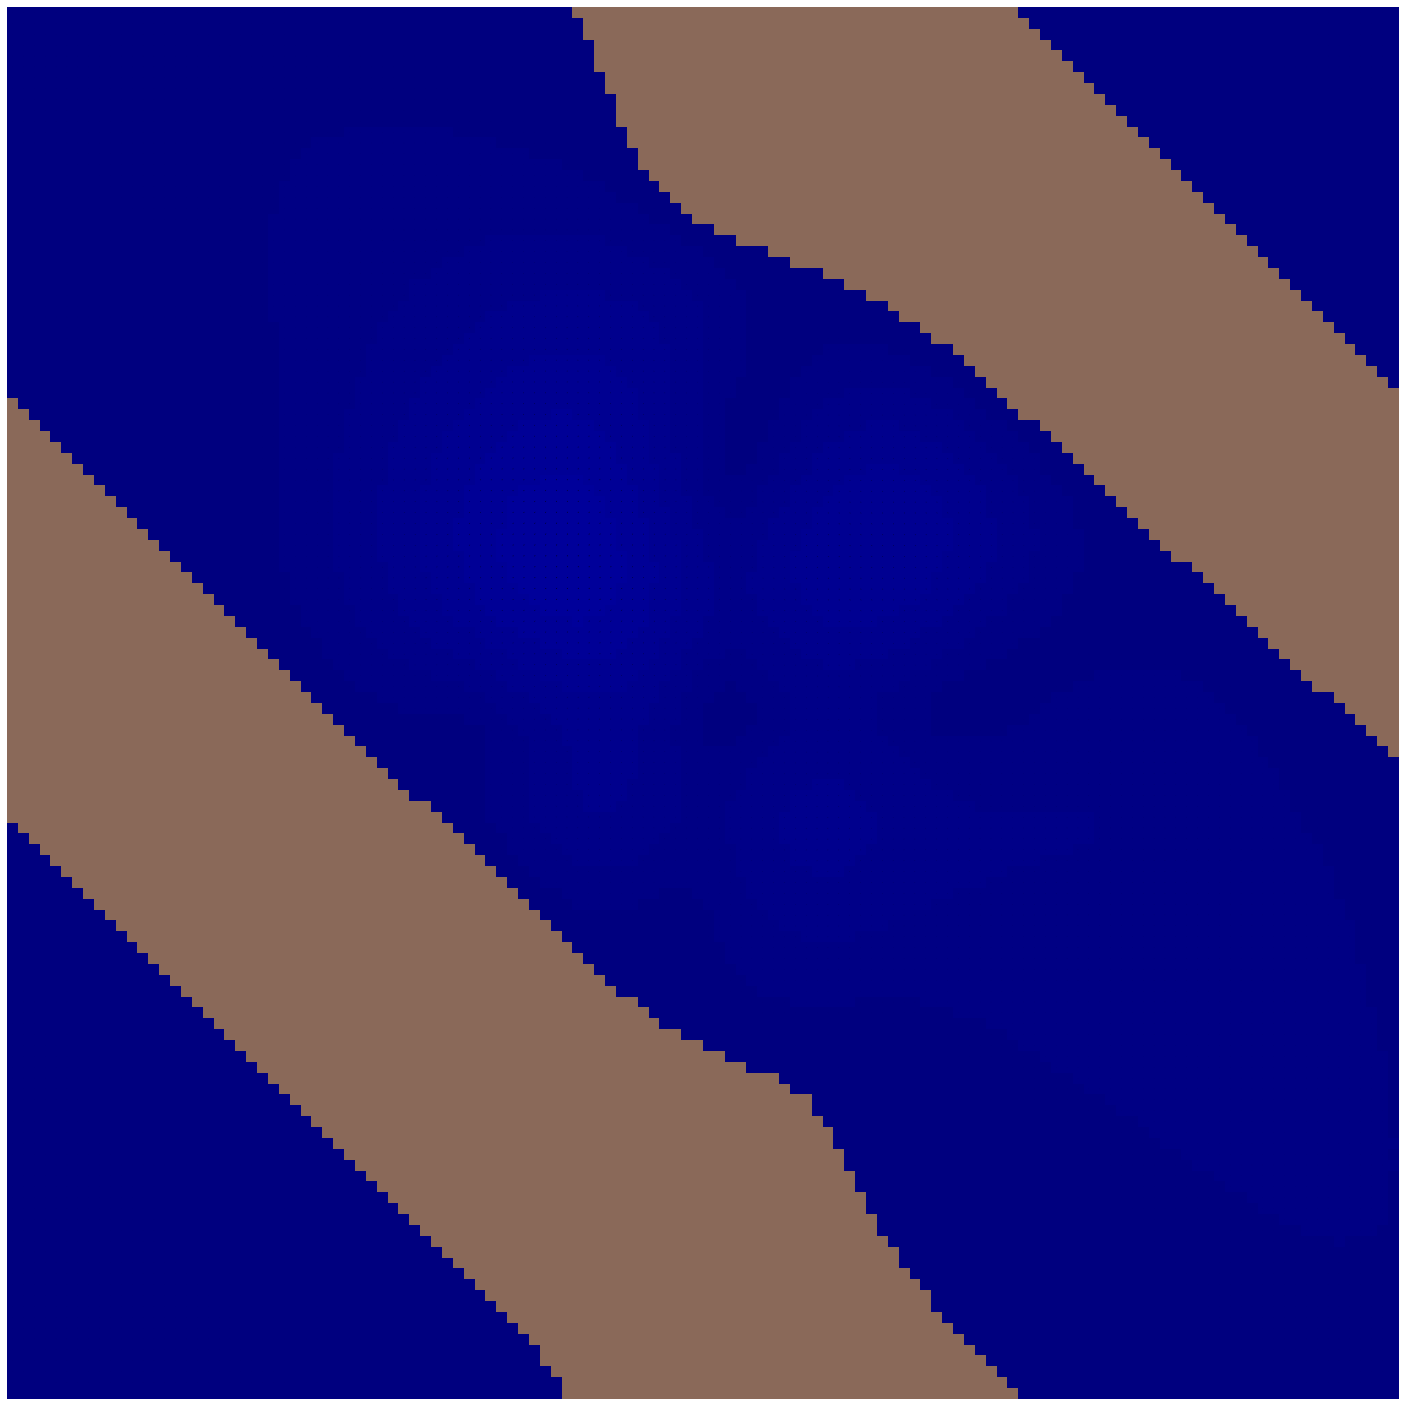

1.1612353869133876 0.00010222315794435754


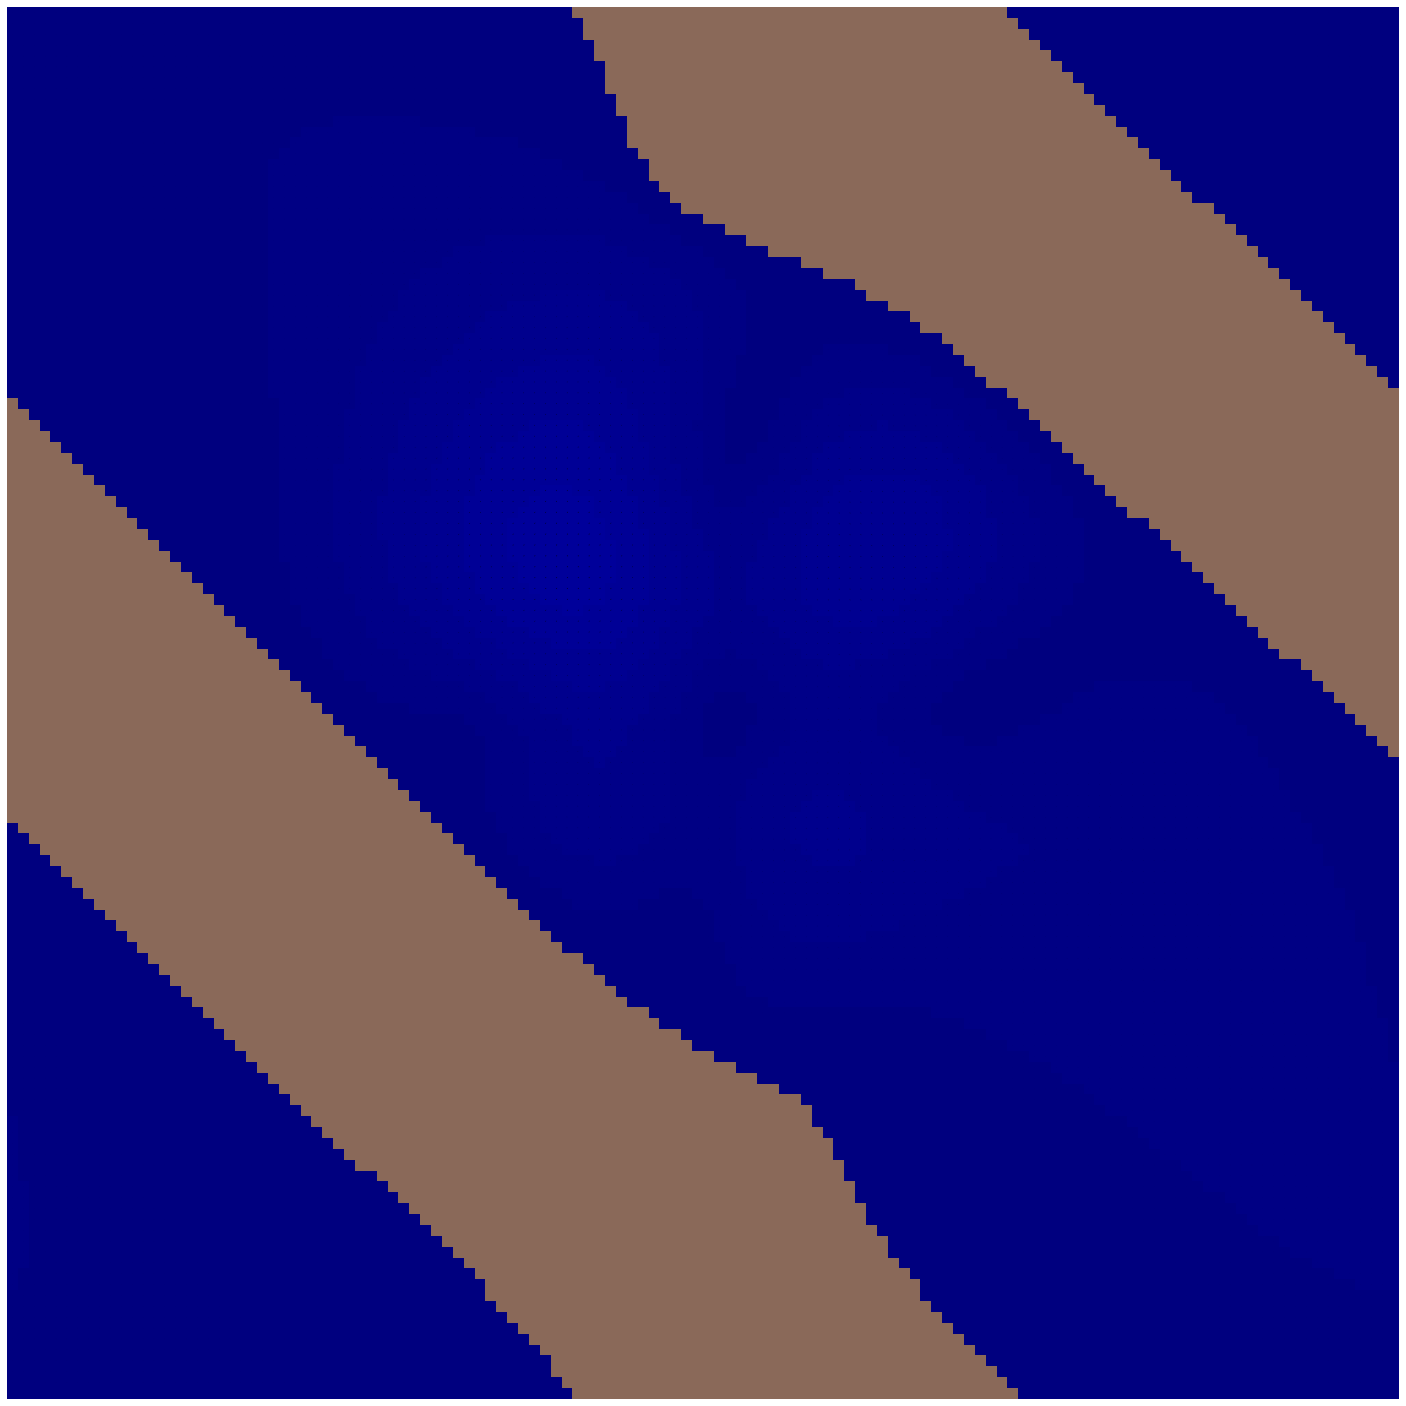

1.131232042715842 9.896645409147125e-05


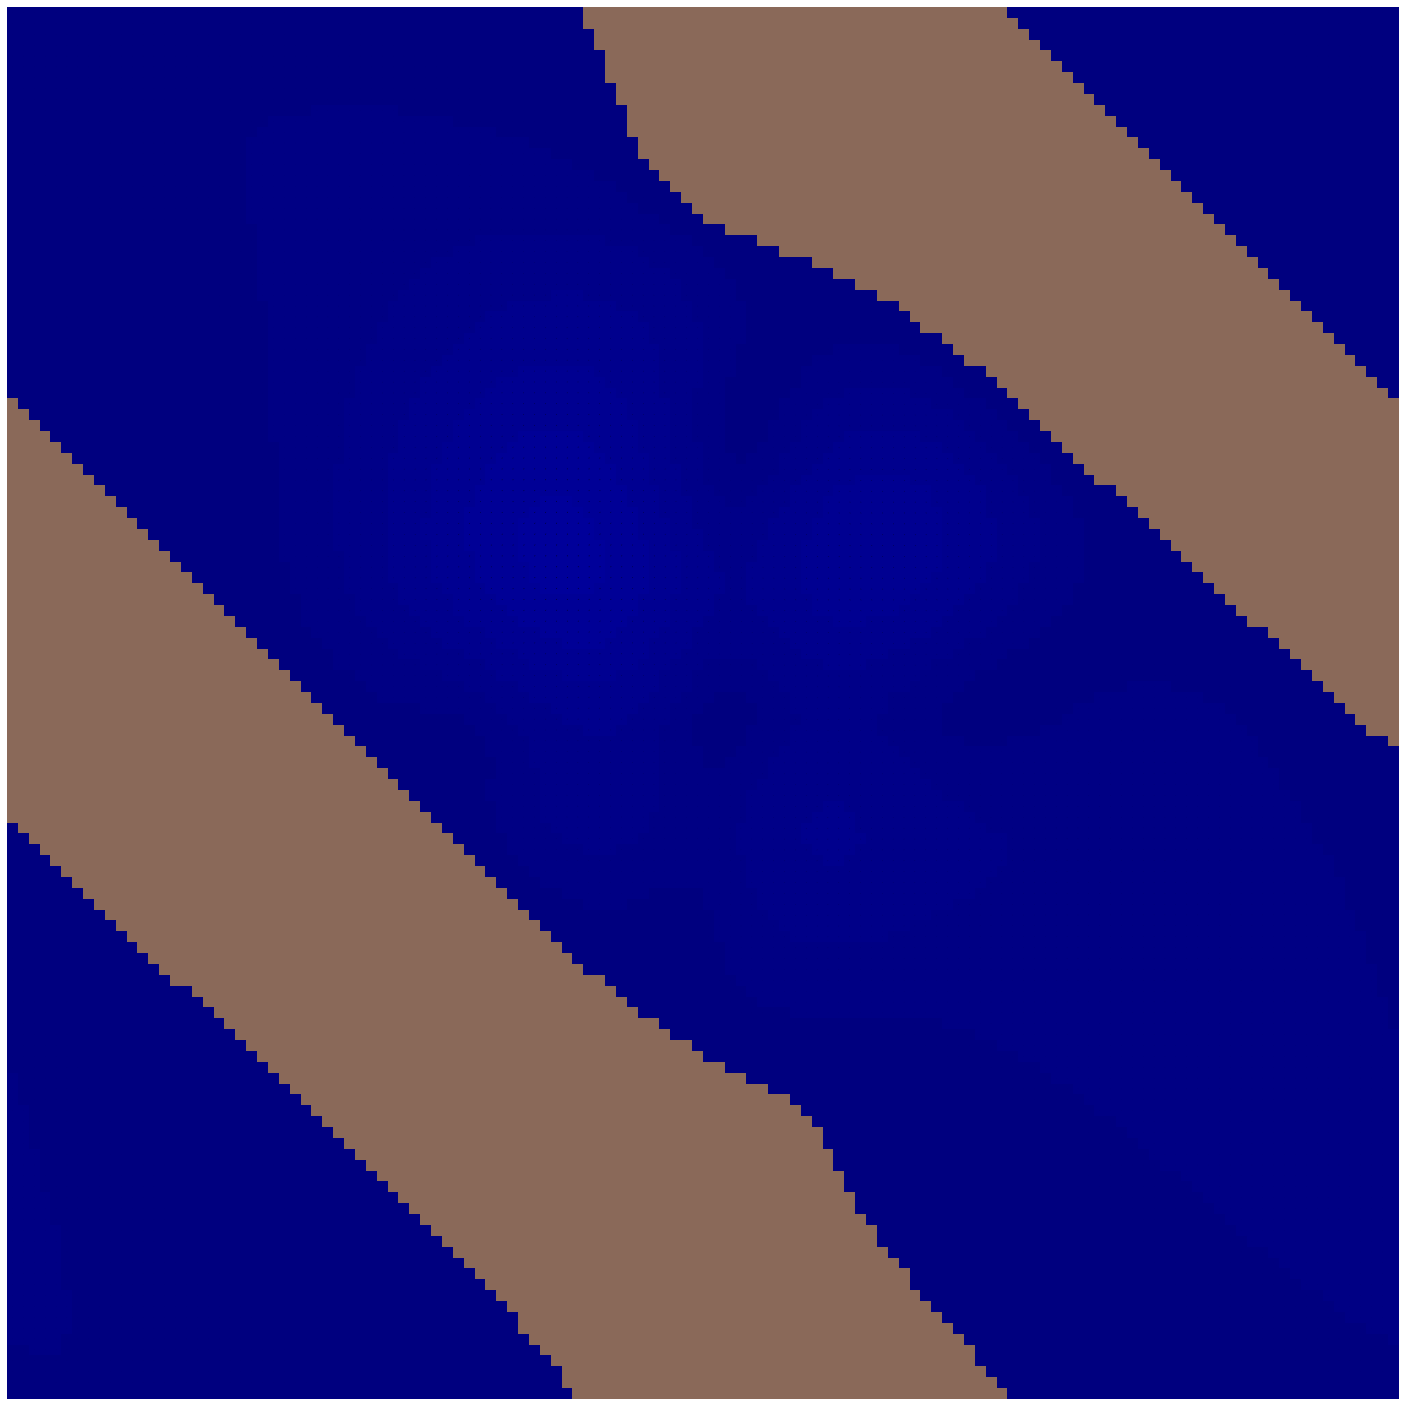

1.101228855365637 9.601593021628781e-05


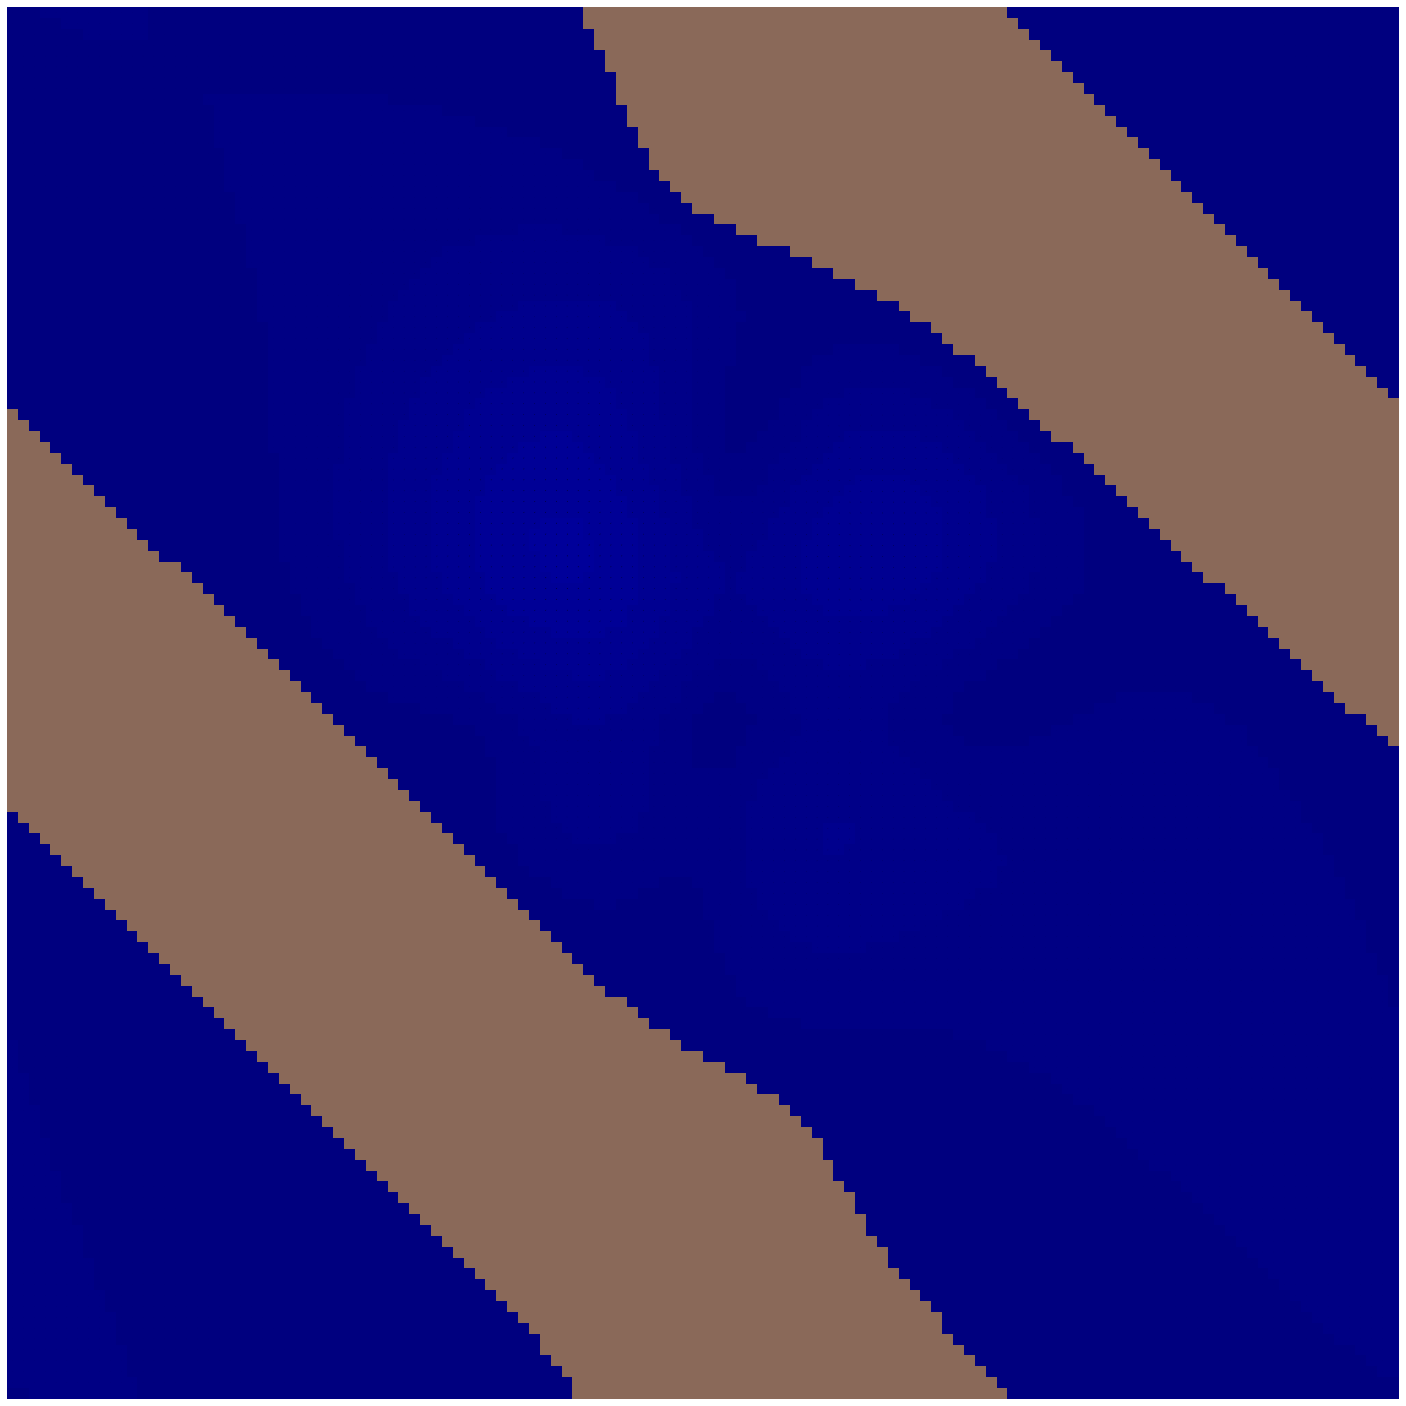

1.0712257213218168 9.343655794834945e-05


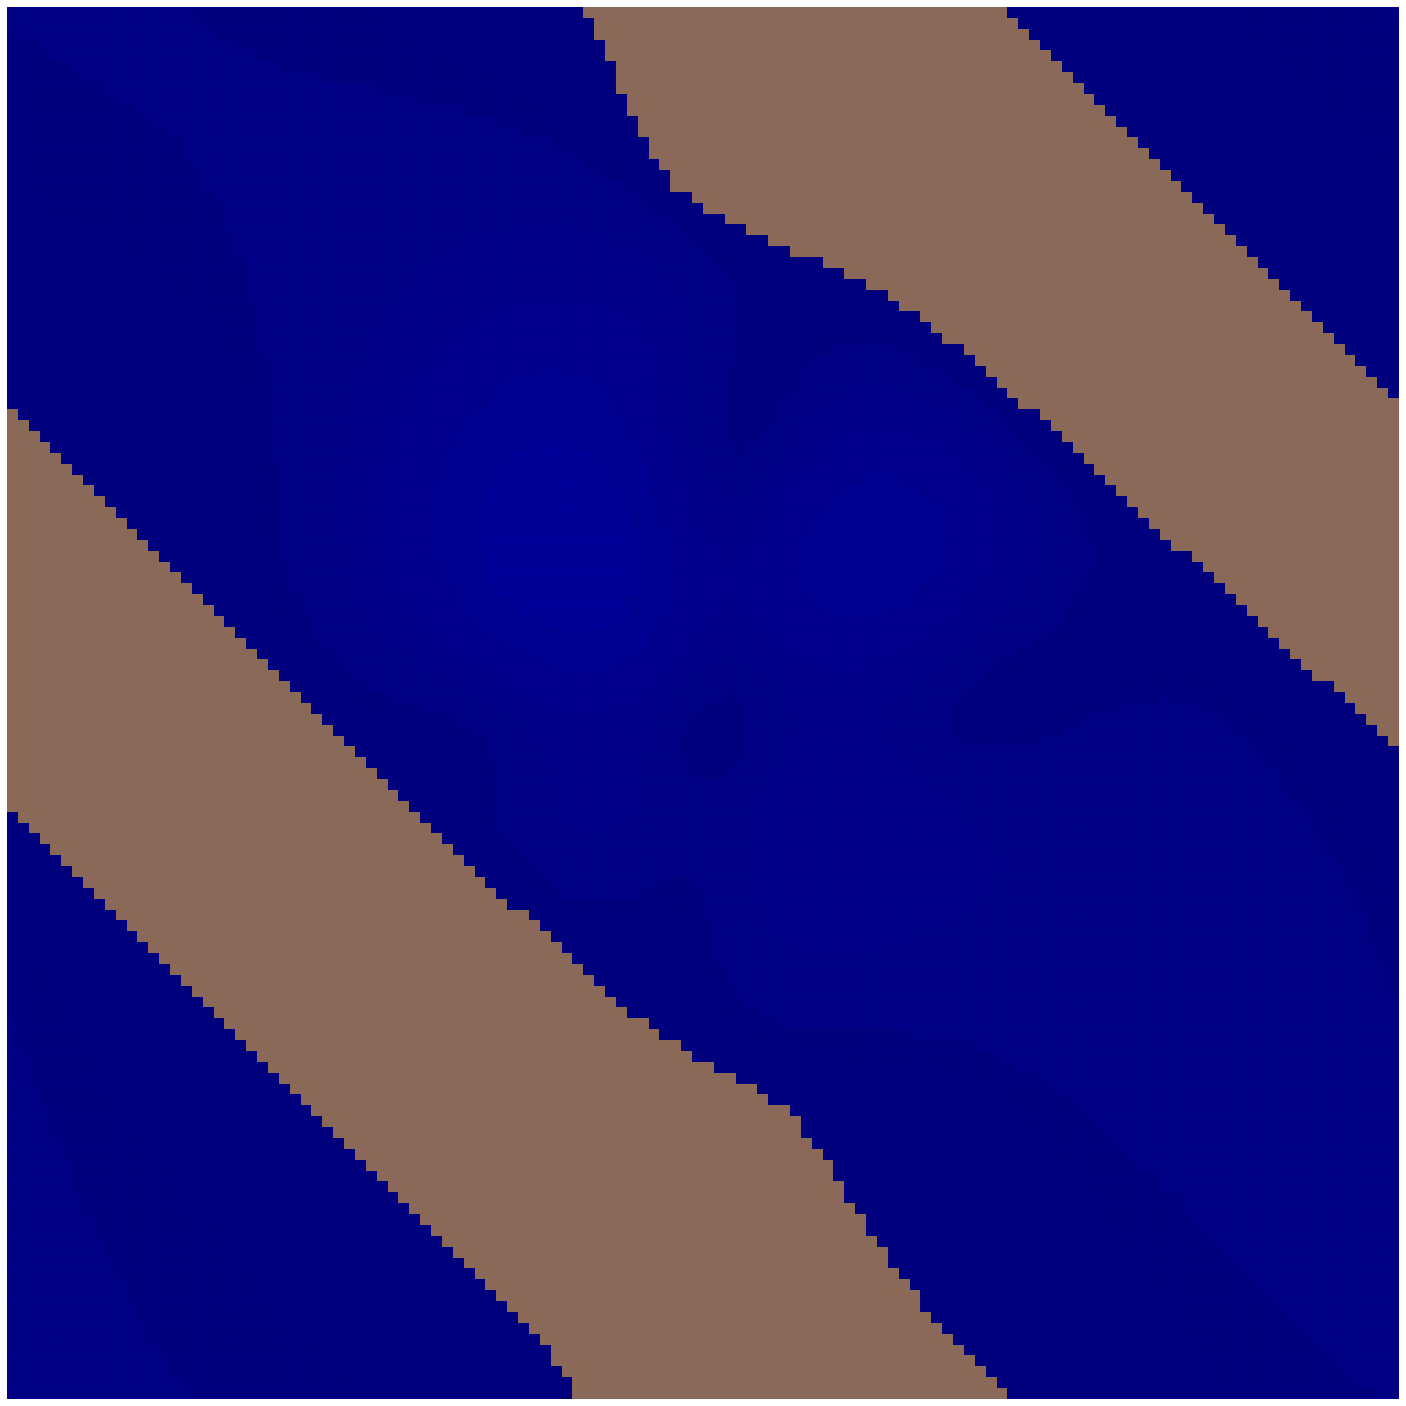

1.0412226711450703 9.116494287686397e-05


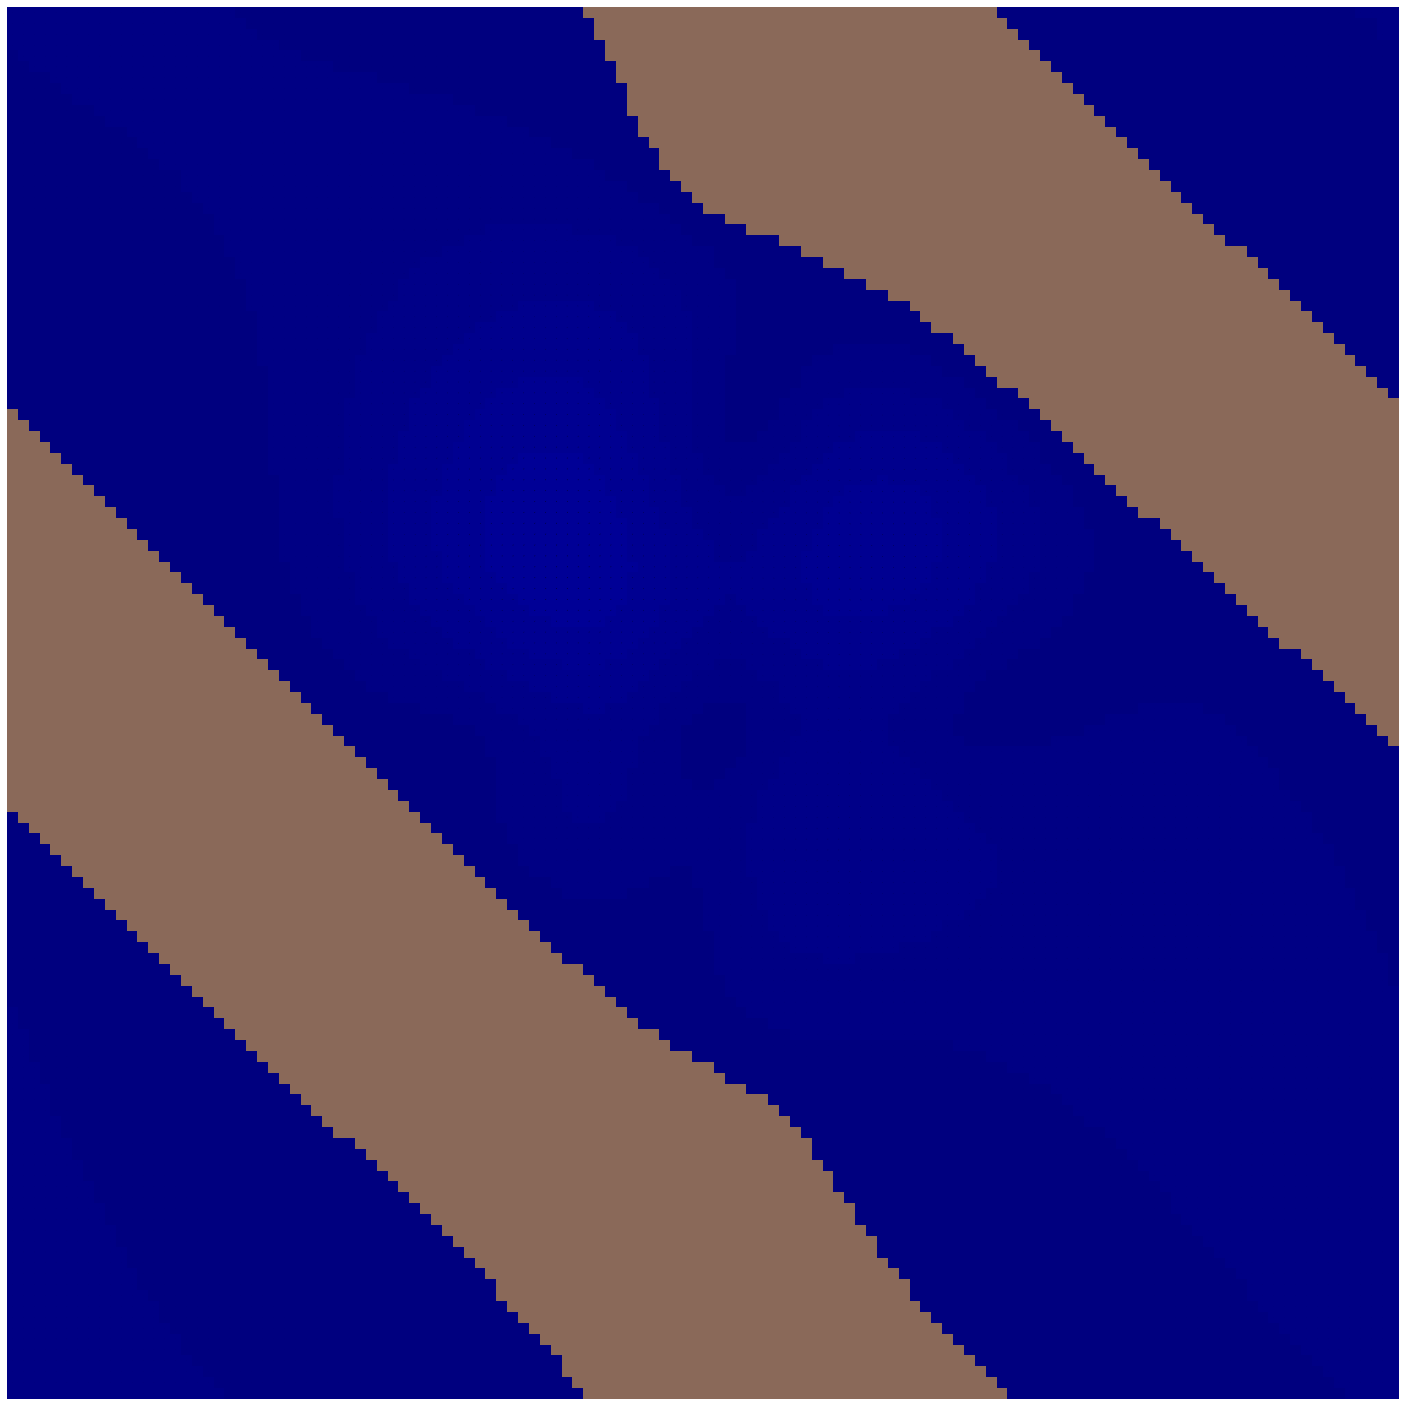

1.0112196299646241 8.917939471021823e-05


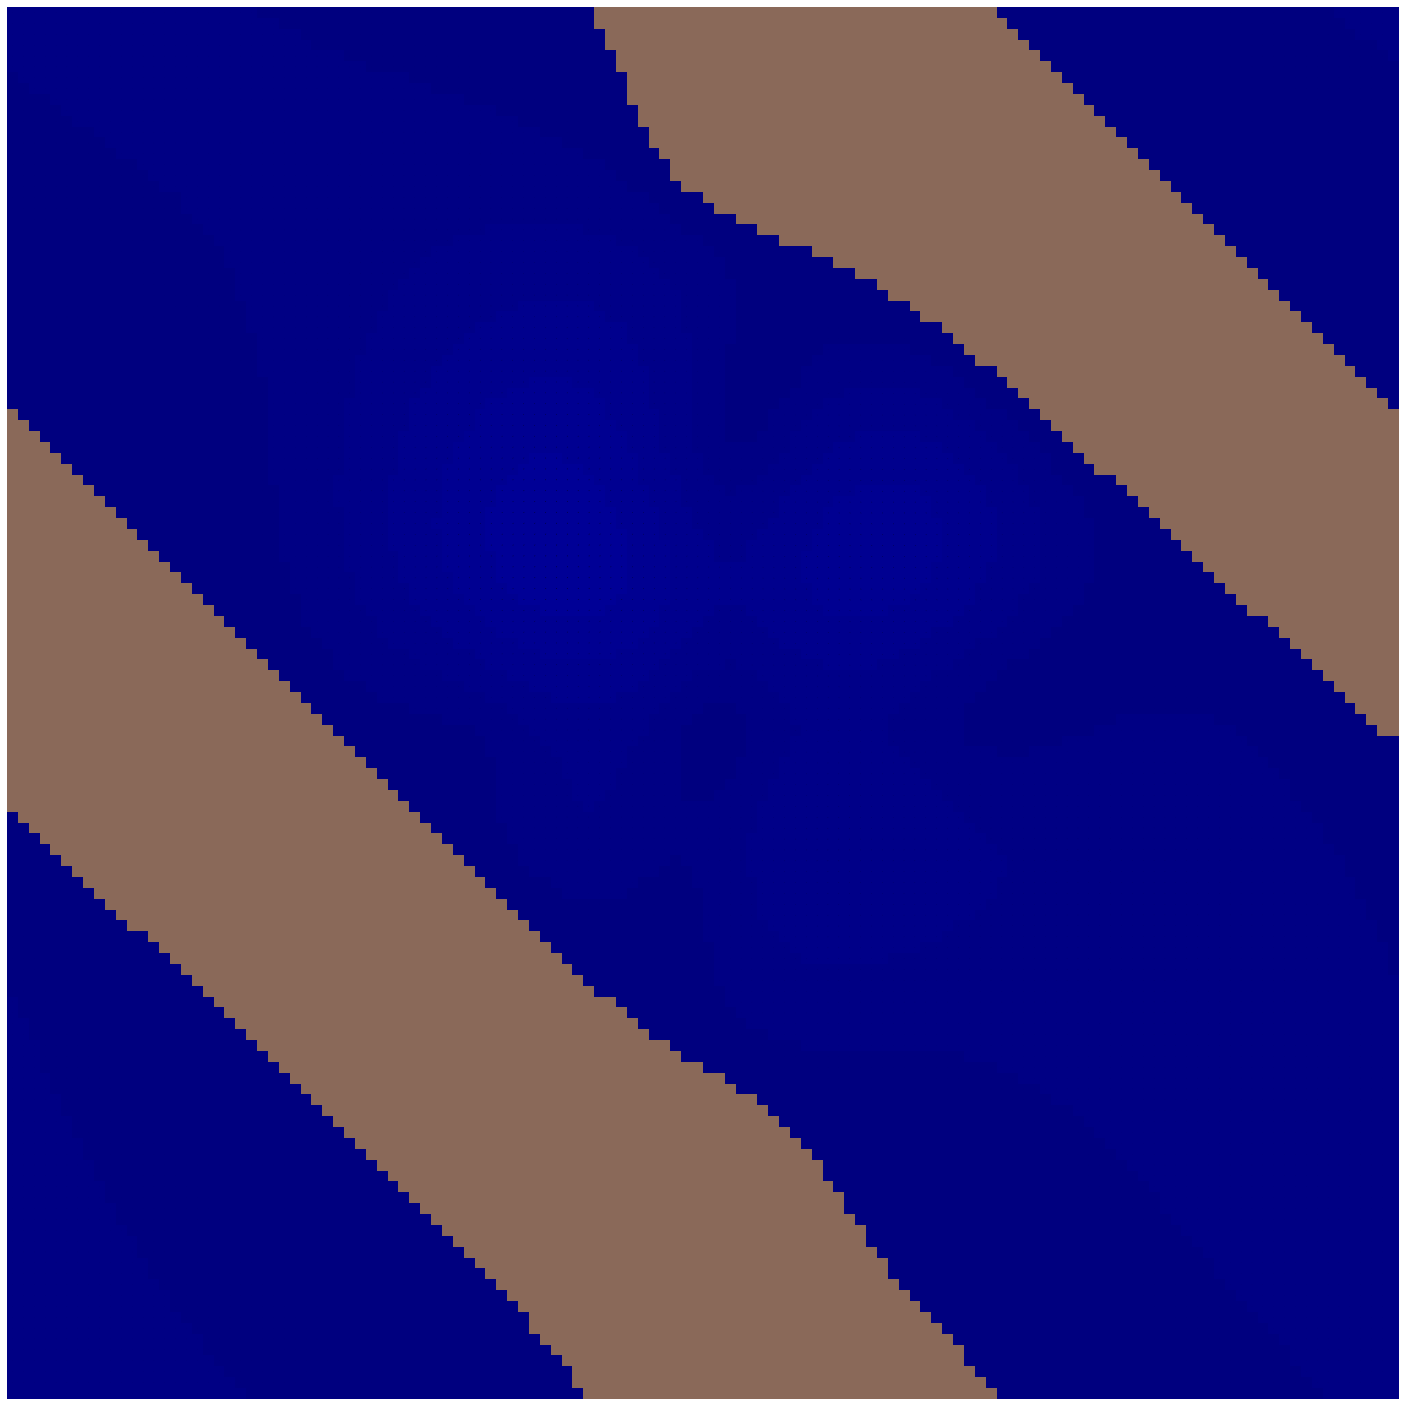

0.98121662098583 8.748638890444131e-05


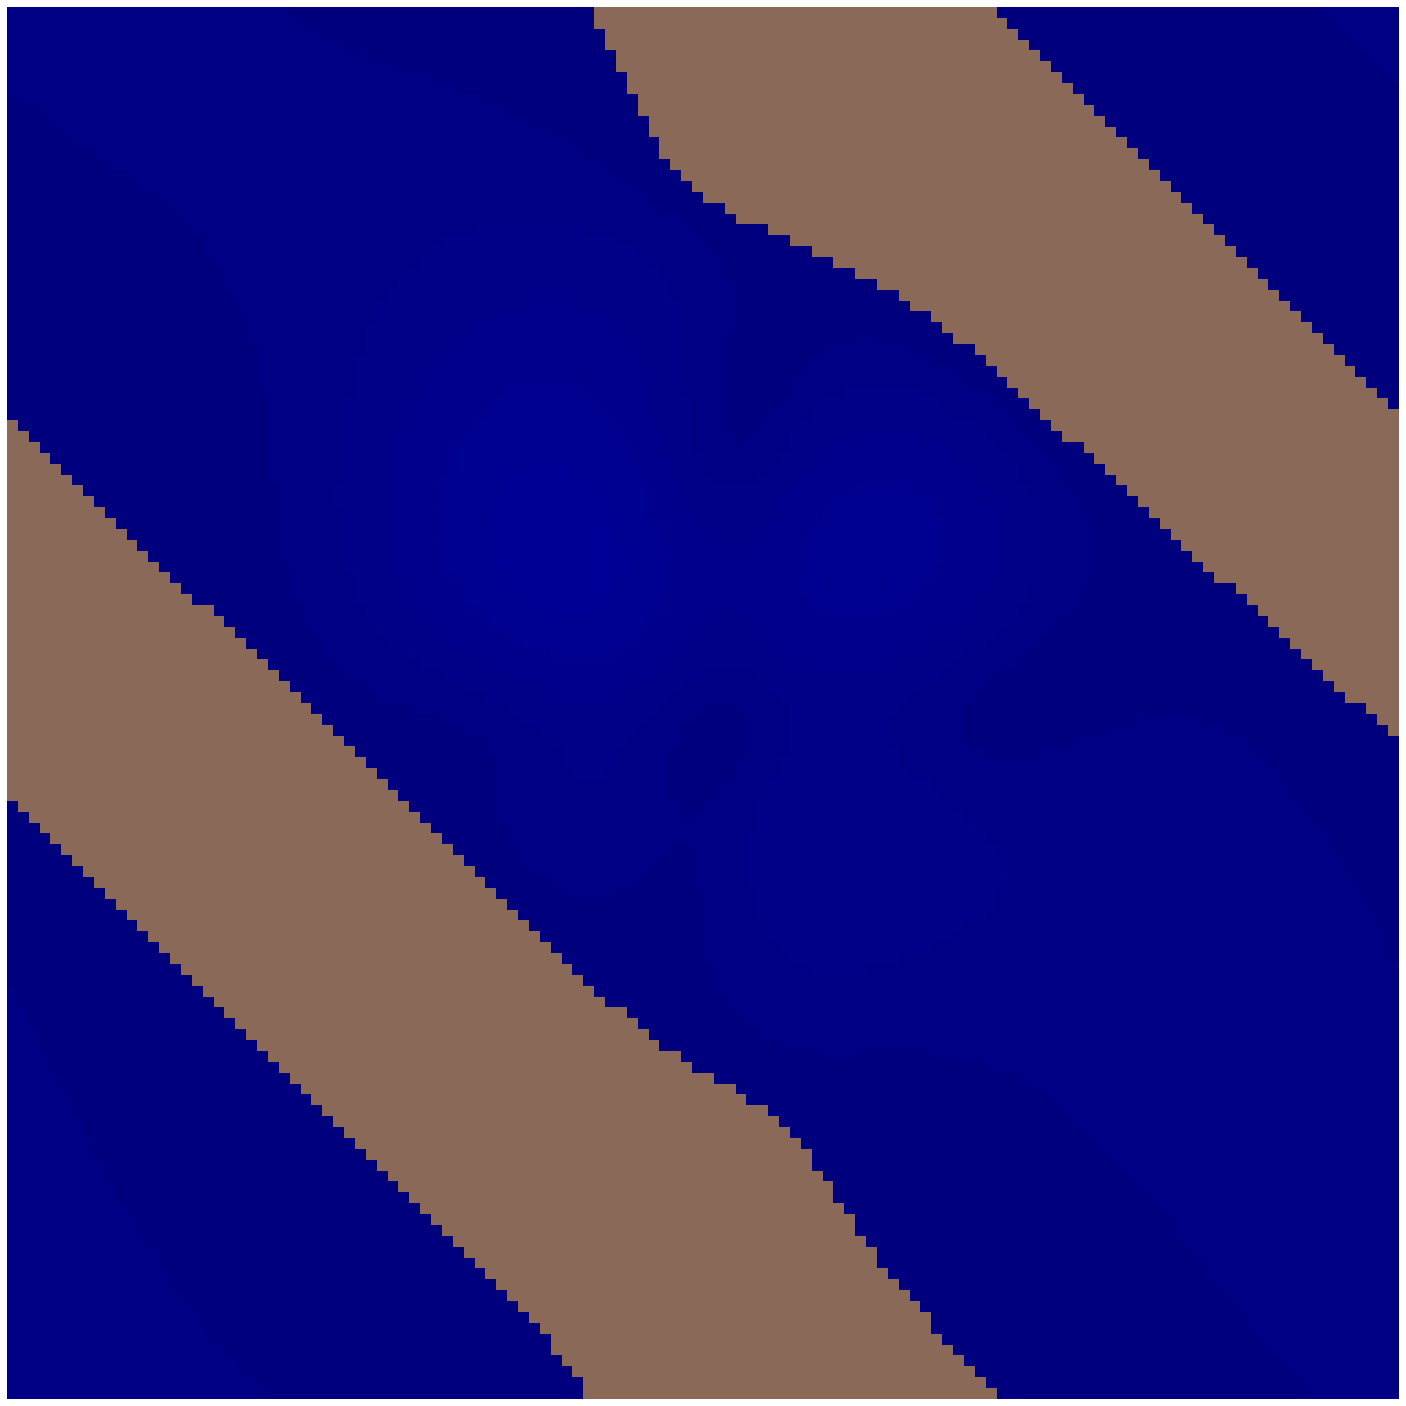

0.9512135789614448 8.608593641100851e-05


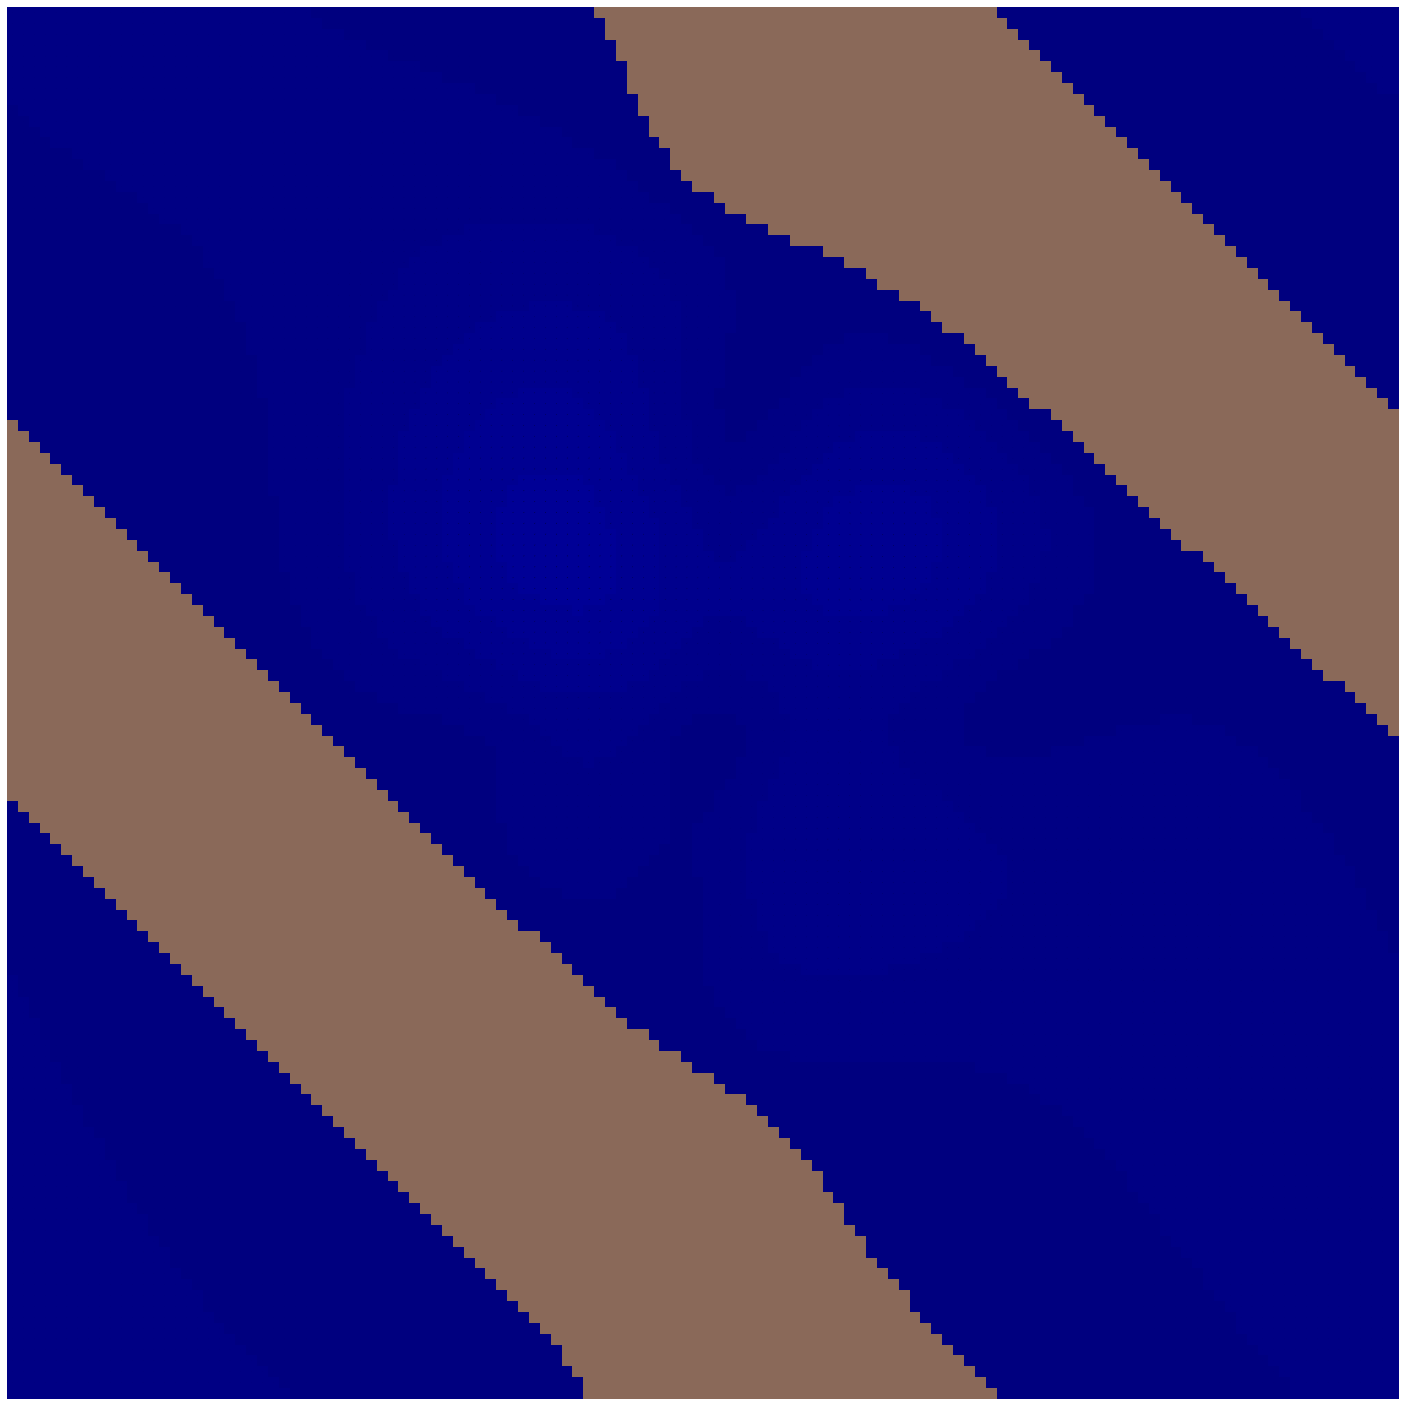

0.9212105237501814 8.498237745659289e-05


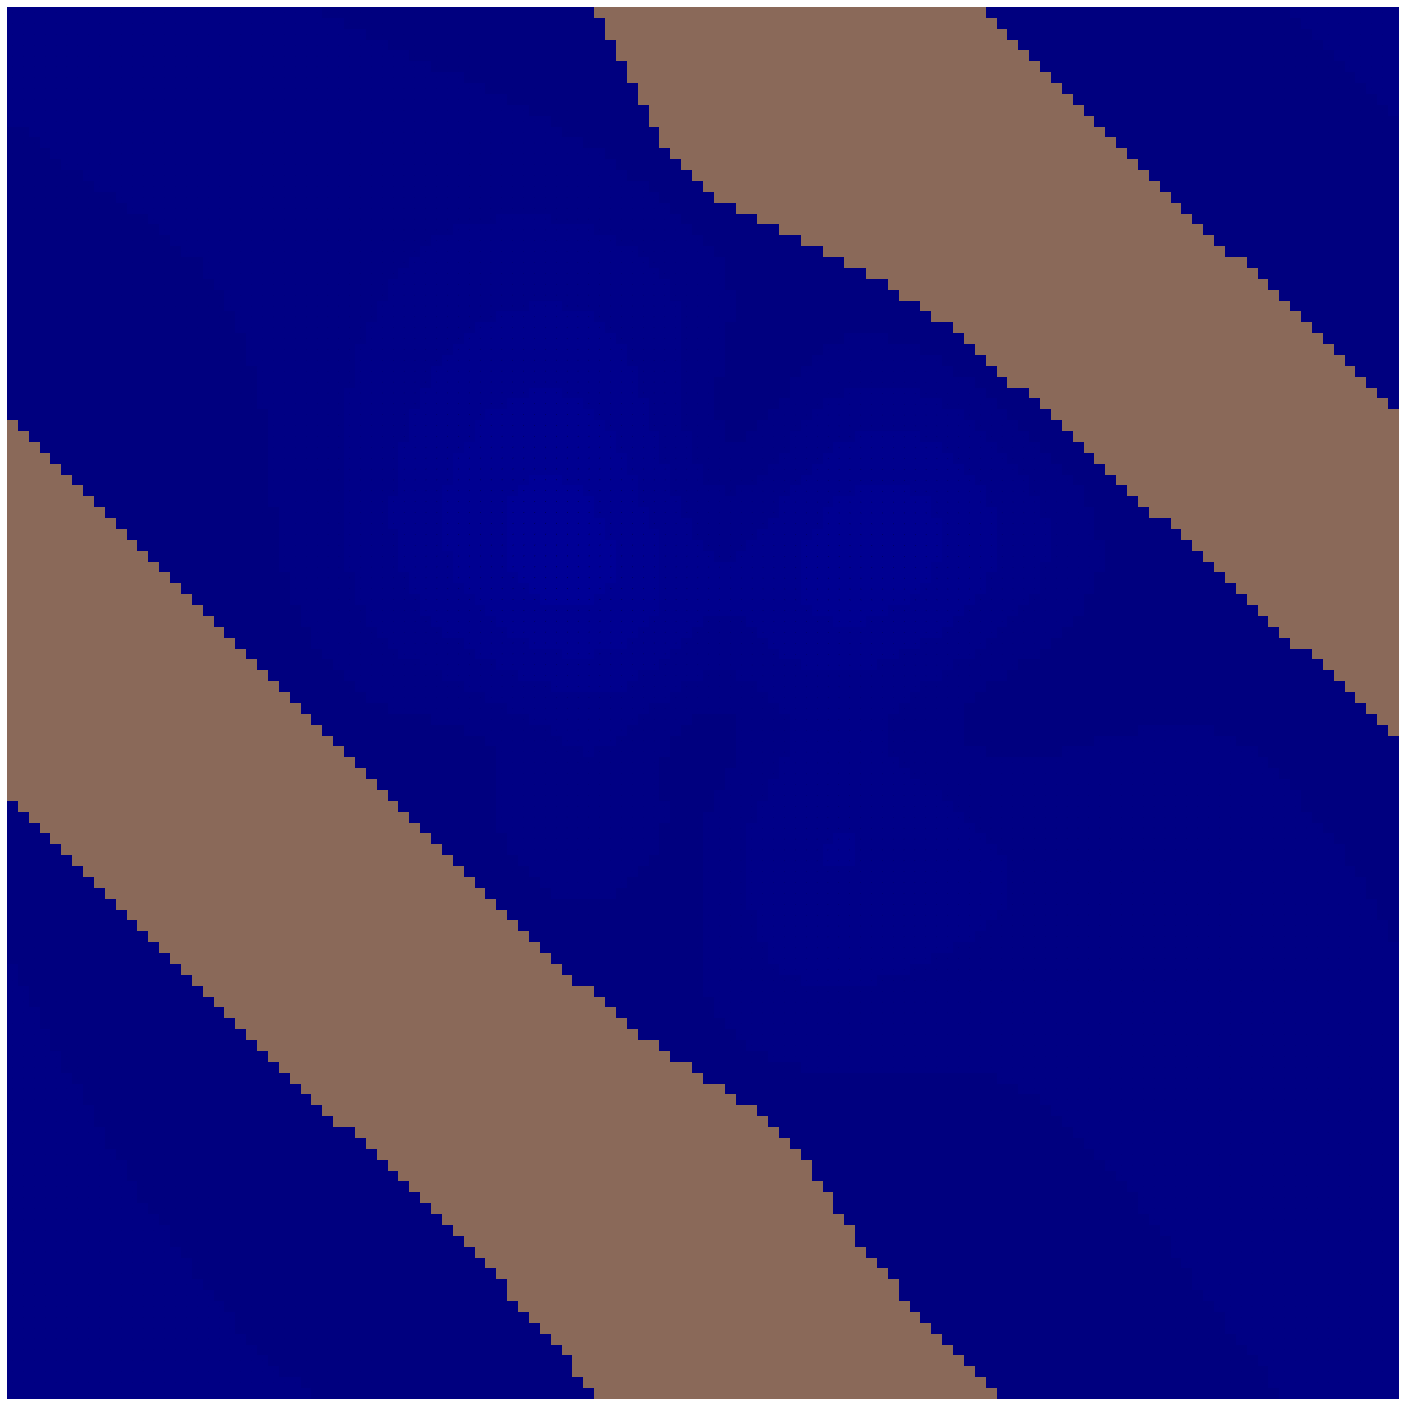

0.8912074070183478 8.417655507351119e-05


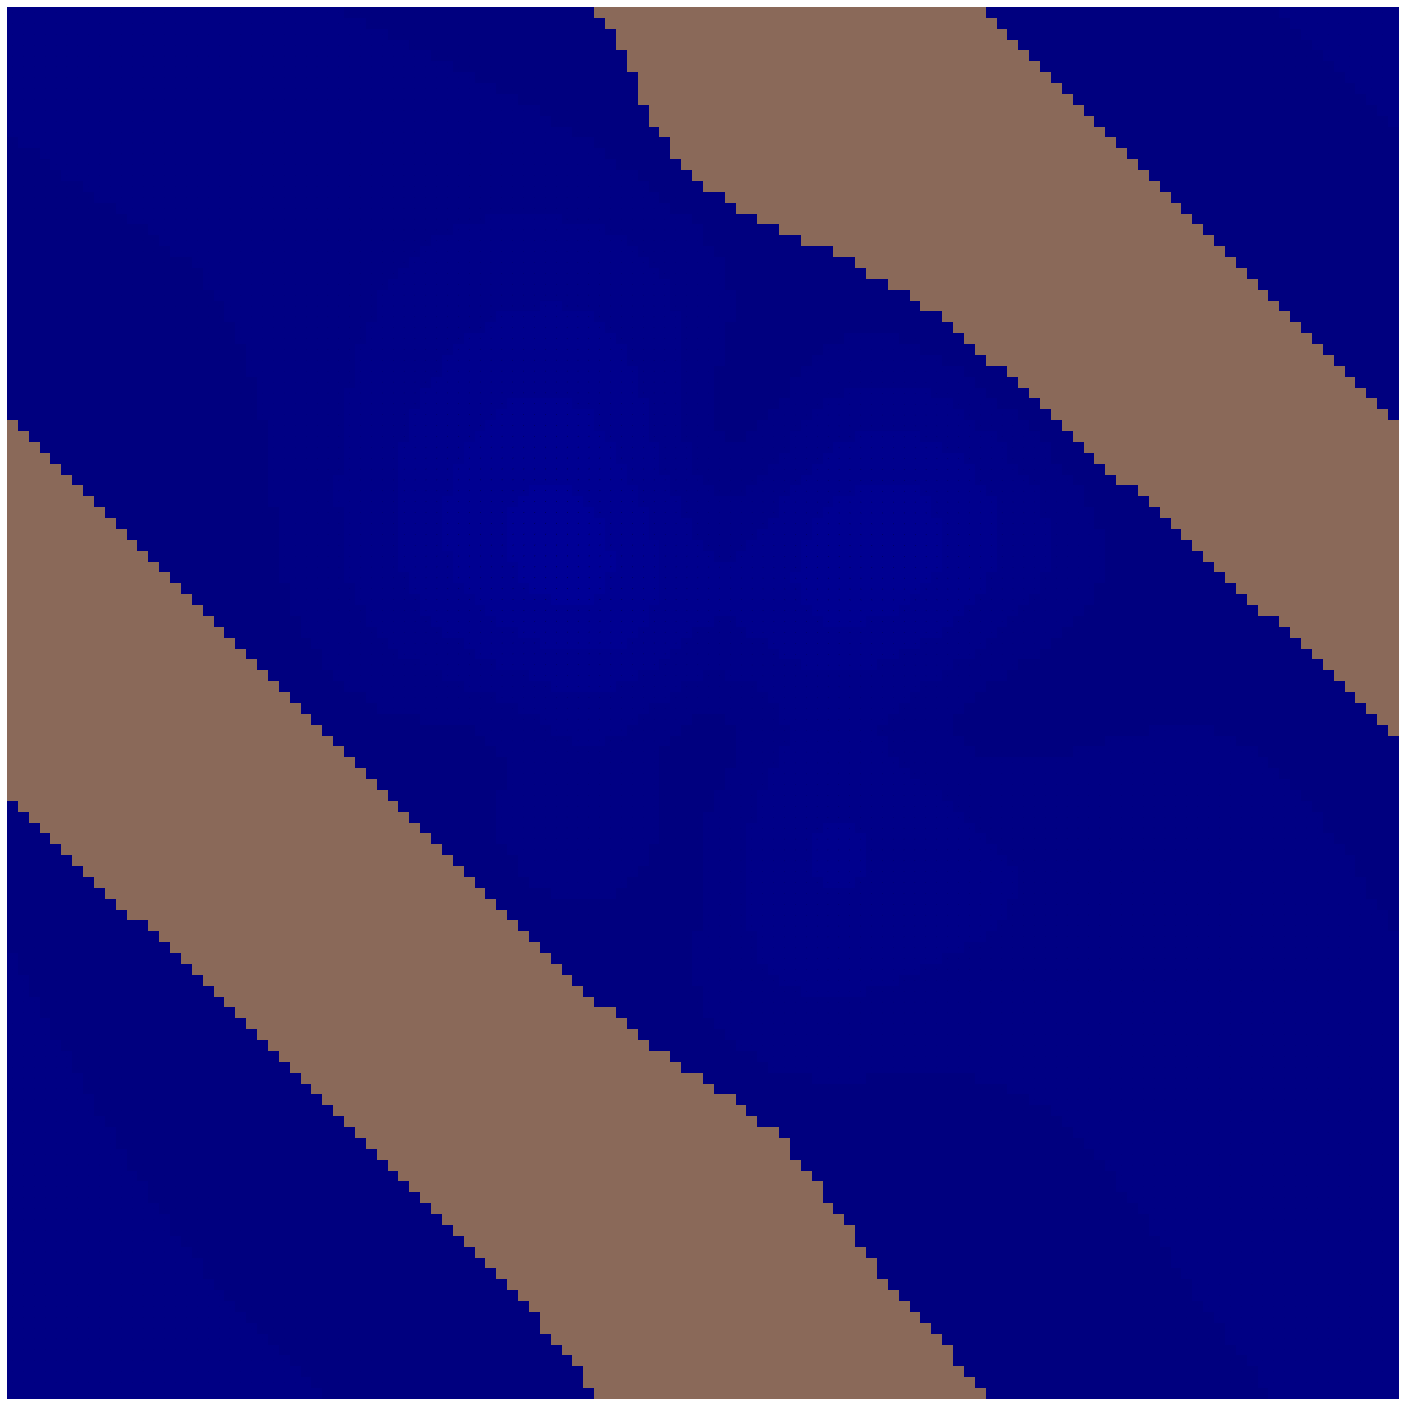

0.8612042530713804 8.36696856307708e-05


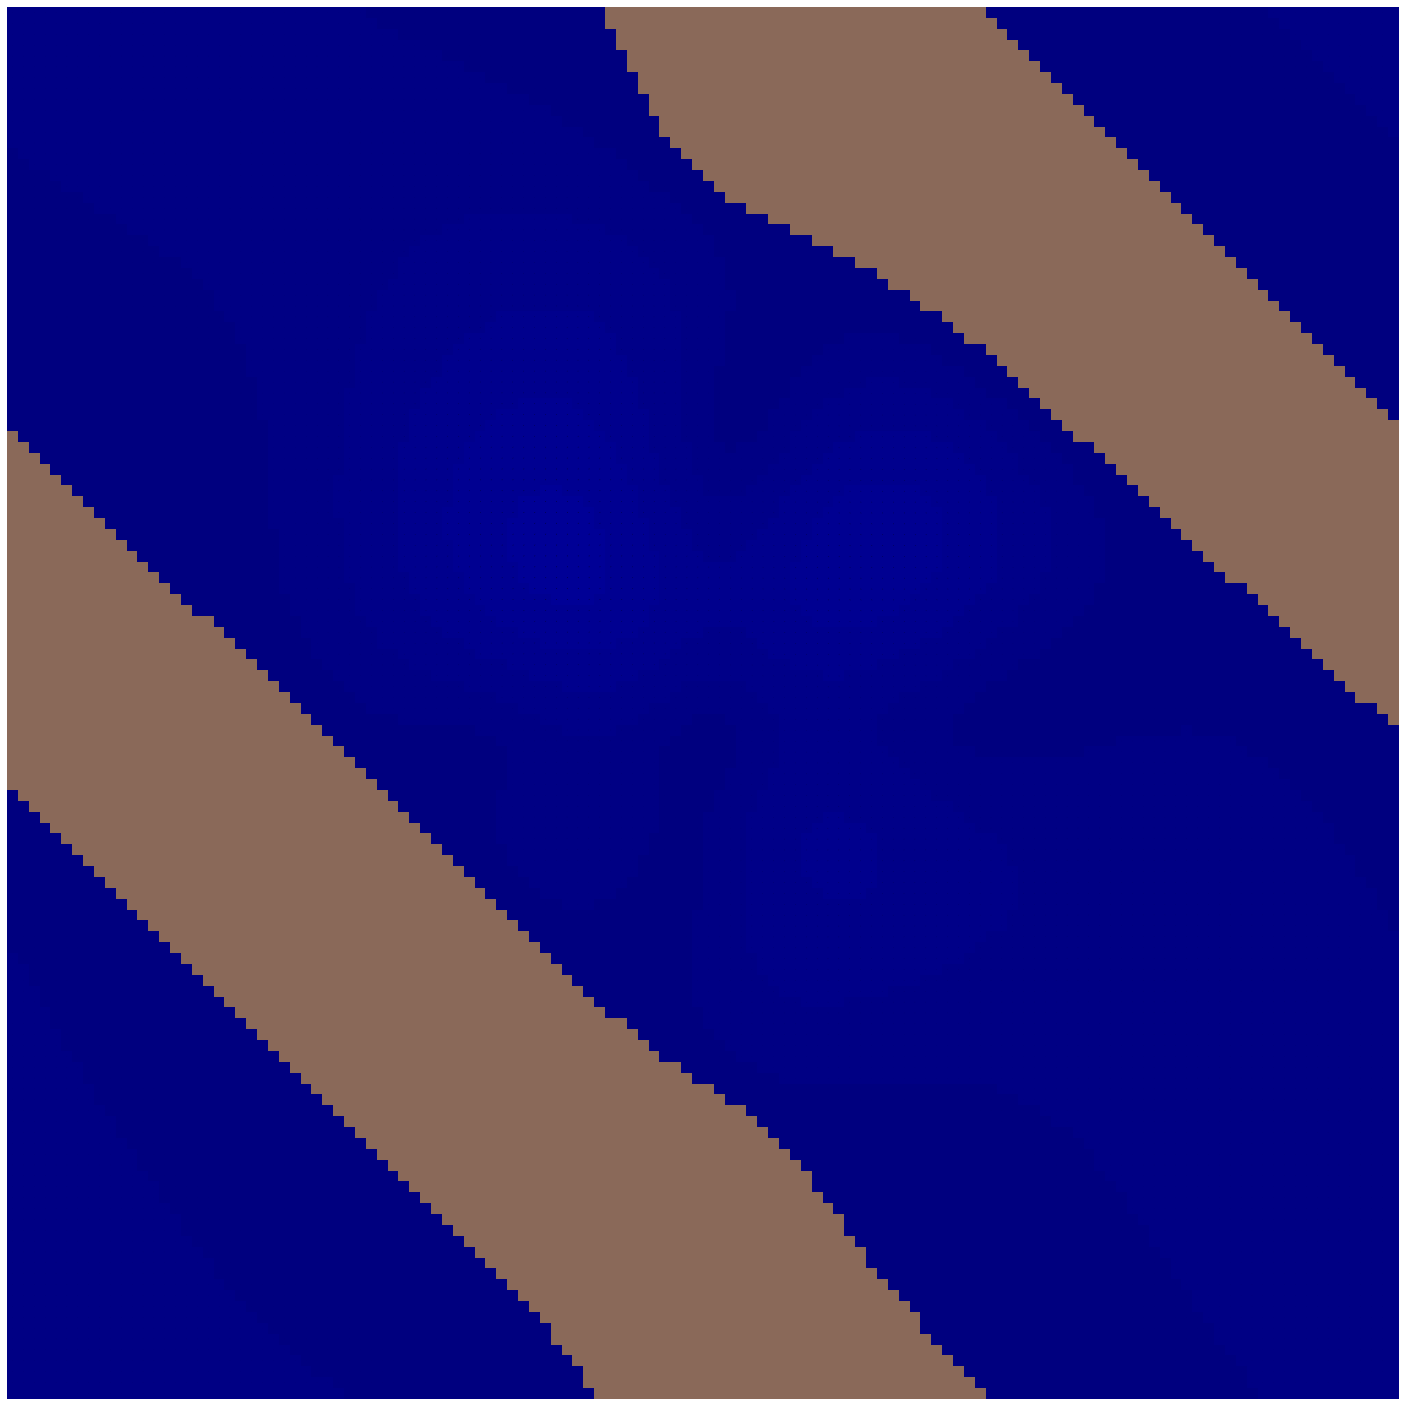

0.8312010265020774 8.352986347413739e-05


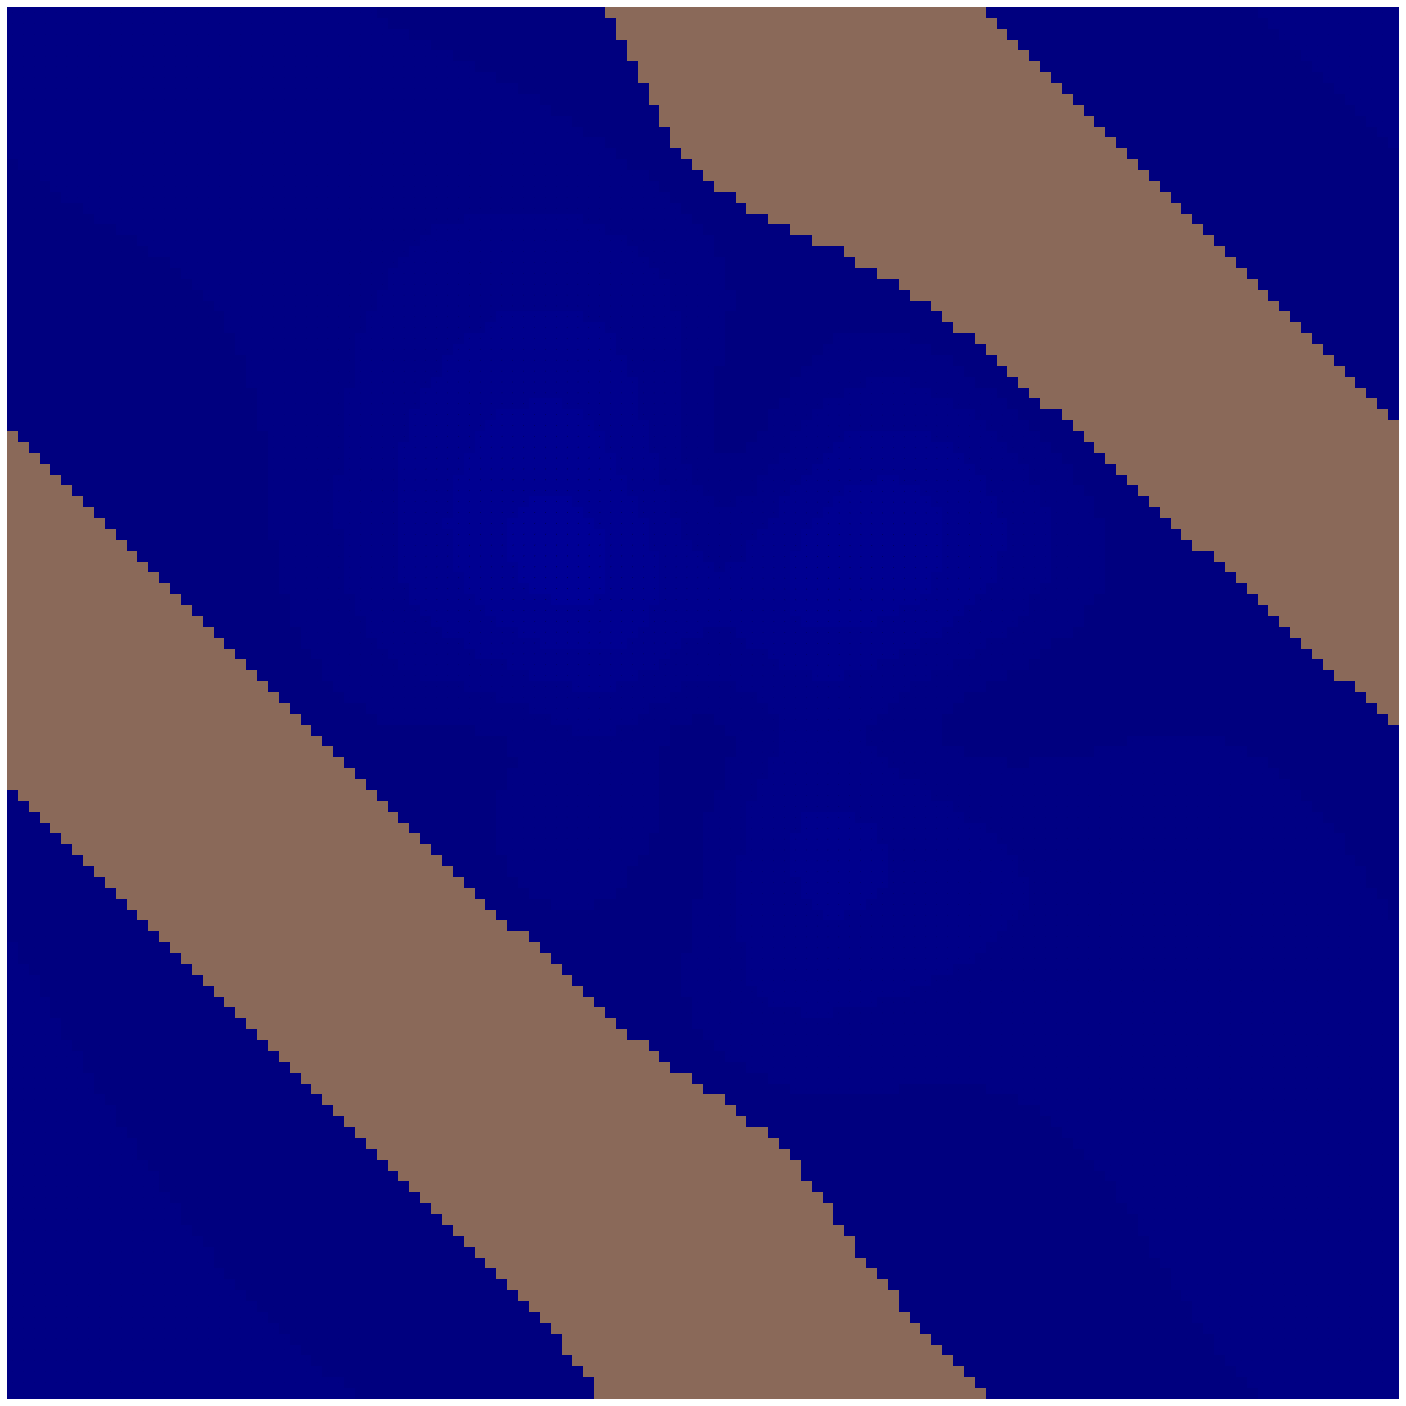

0.8011977559361975 8.375564280744917e-05


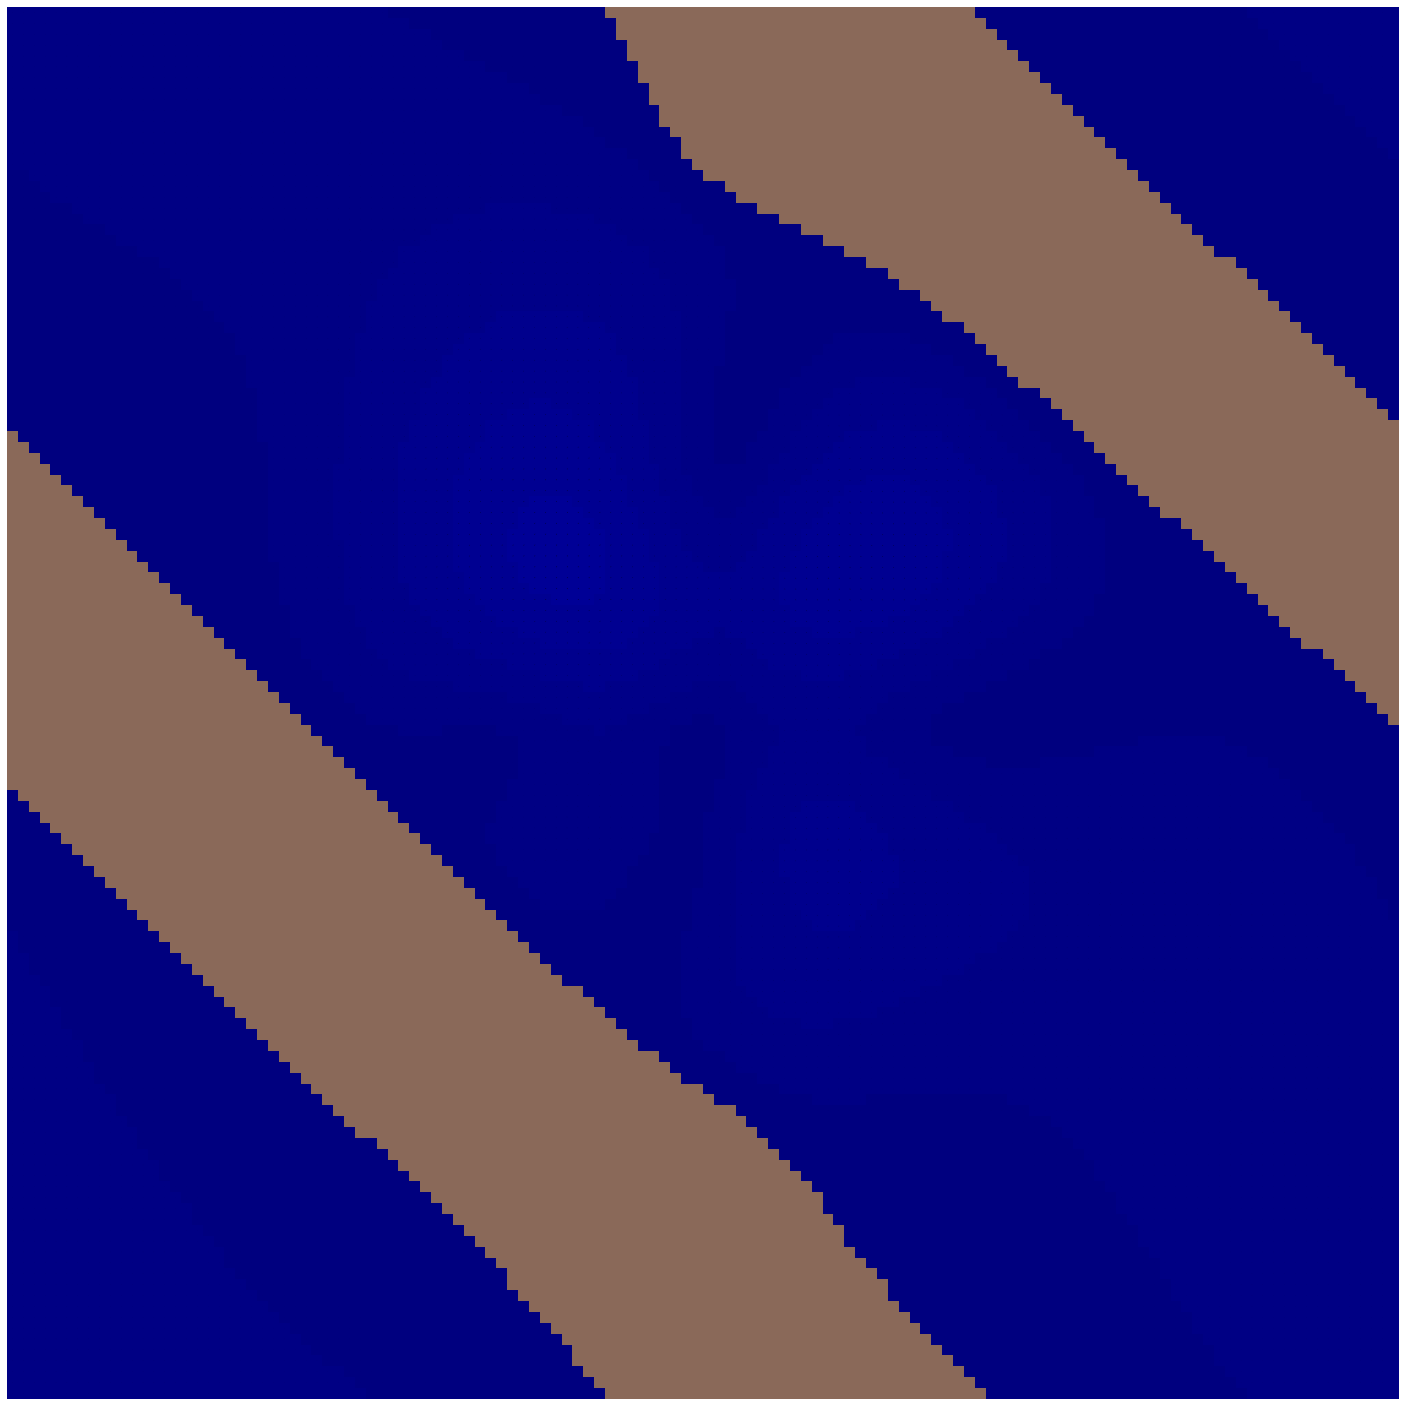

0.7711944248510246 8.431595993064986e-05


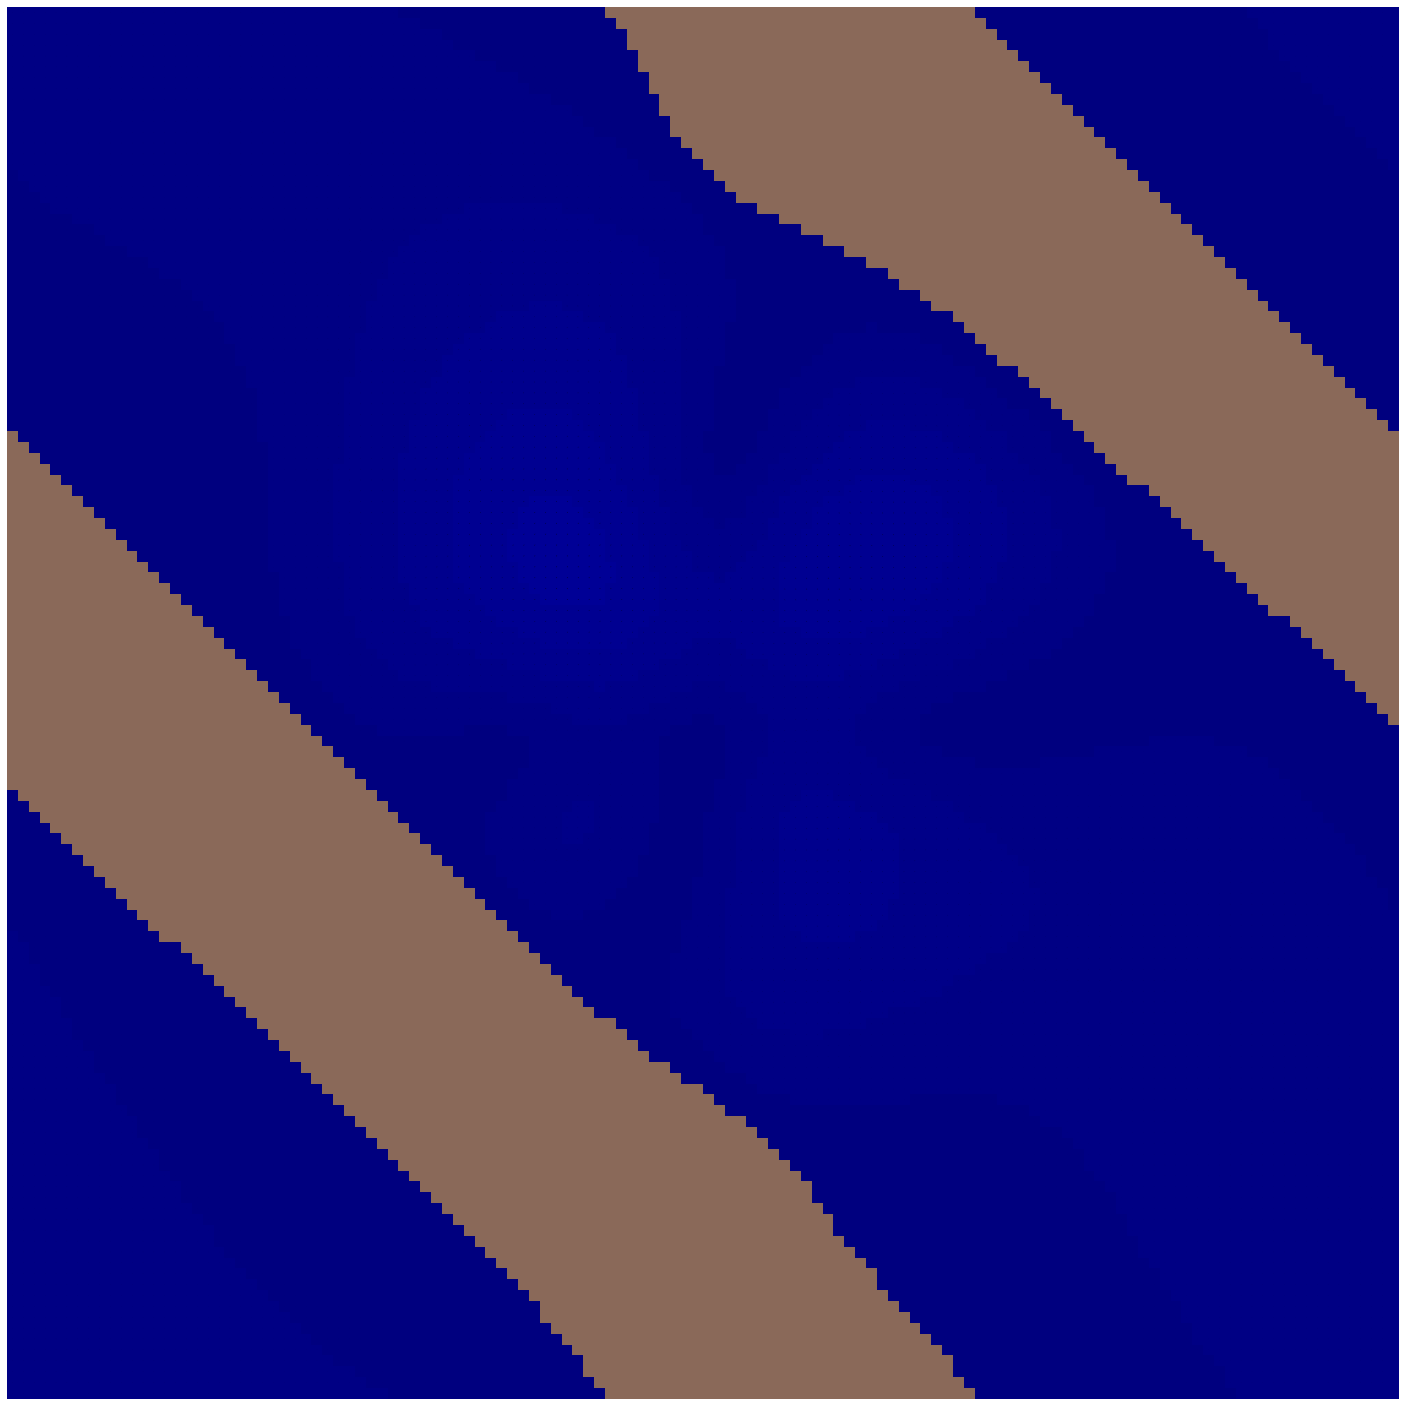

0.7411910659704055 8.532023905102668e-05


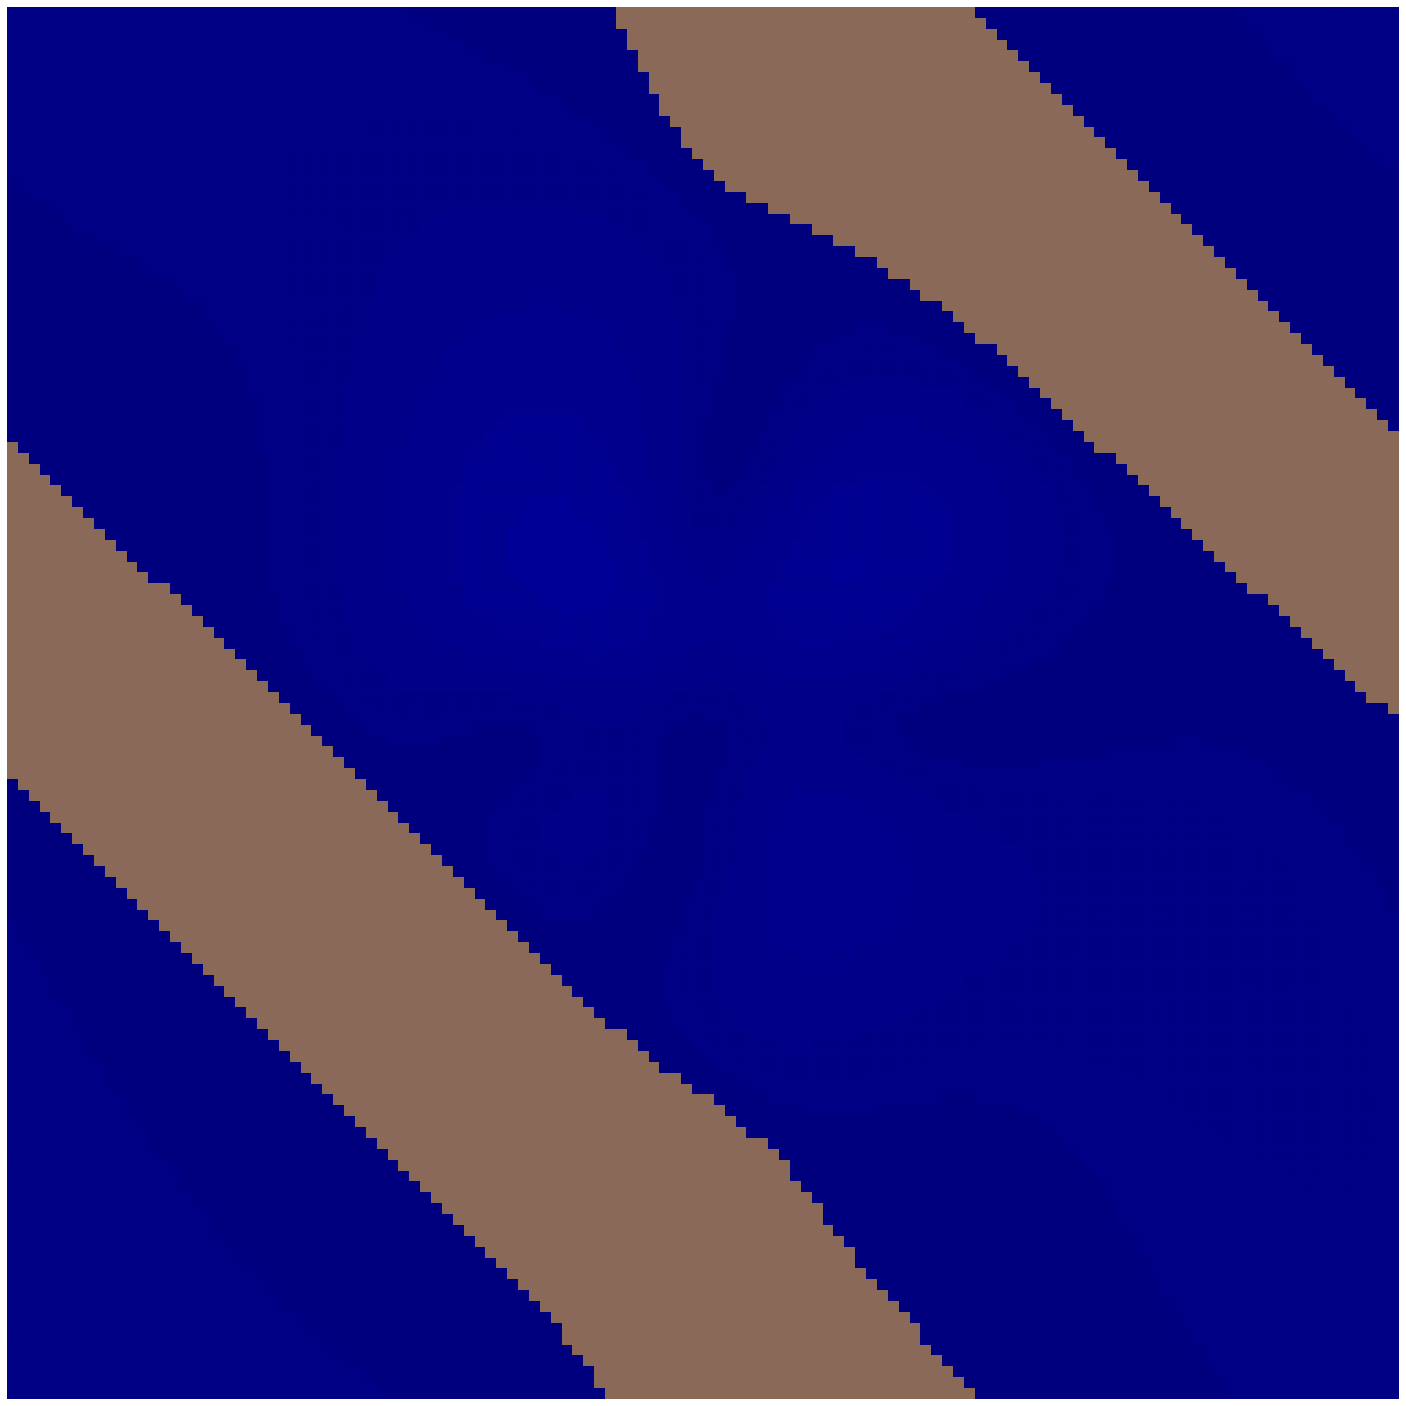

0.7111877076731755 8.669261289851028e-05


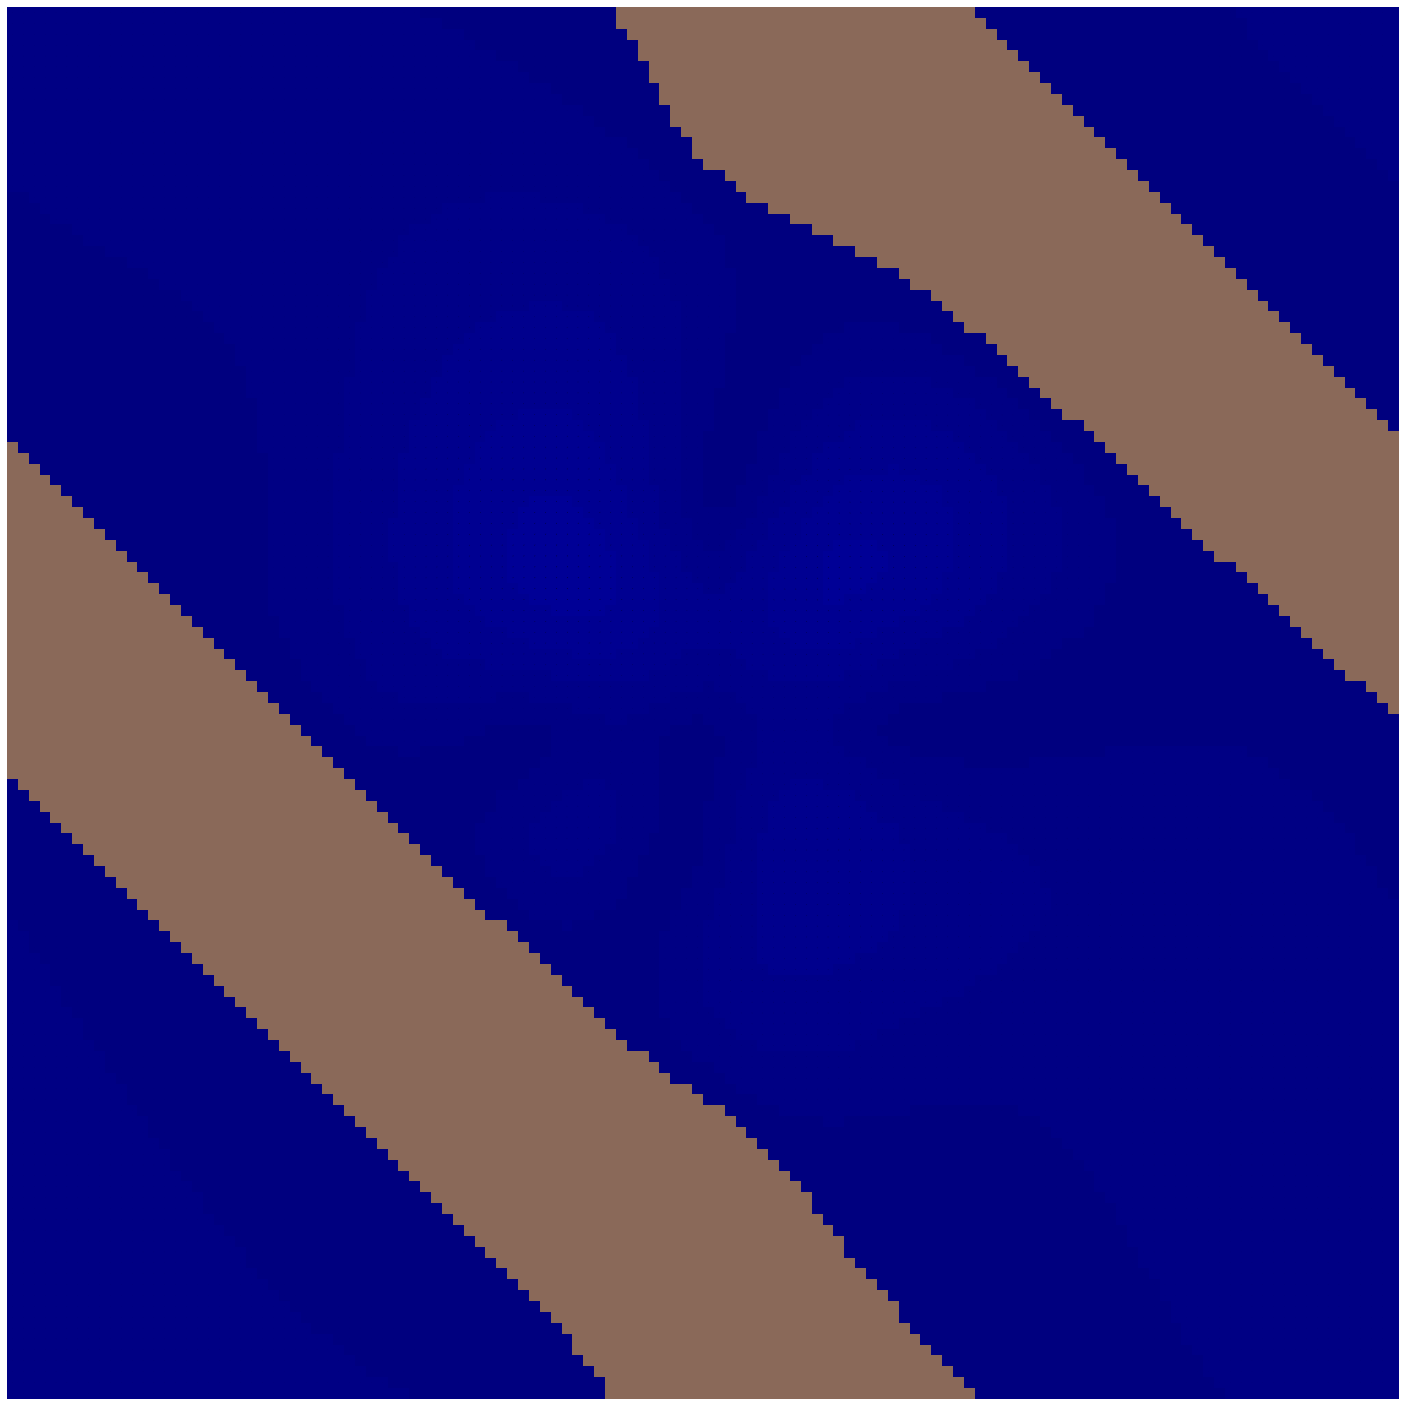

0.681184351300727 8.837239221573155e-05


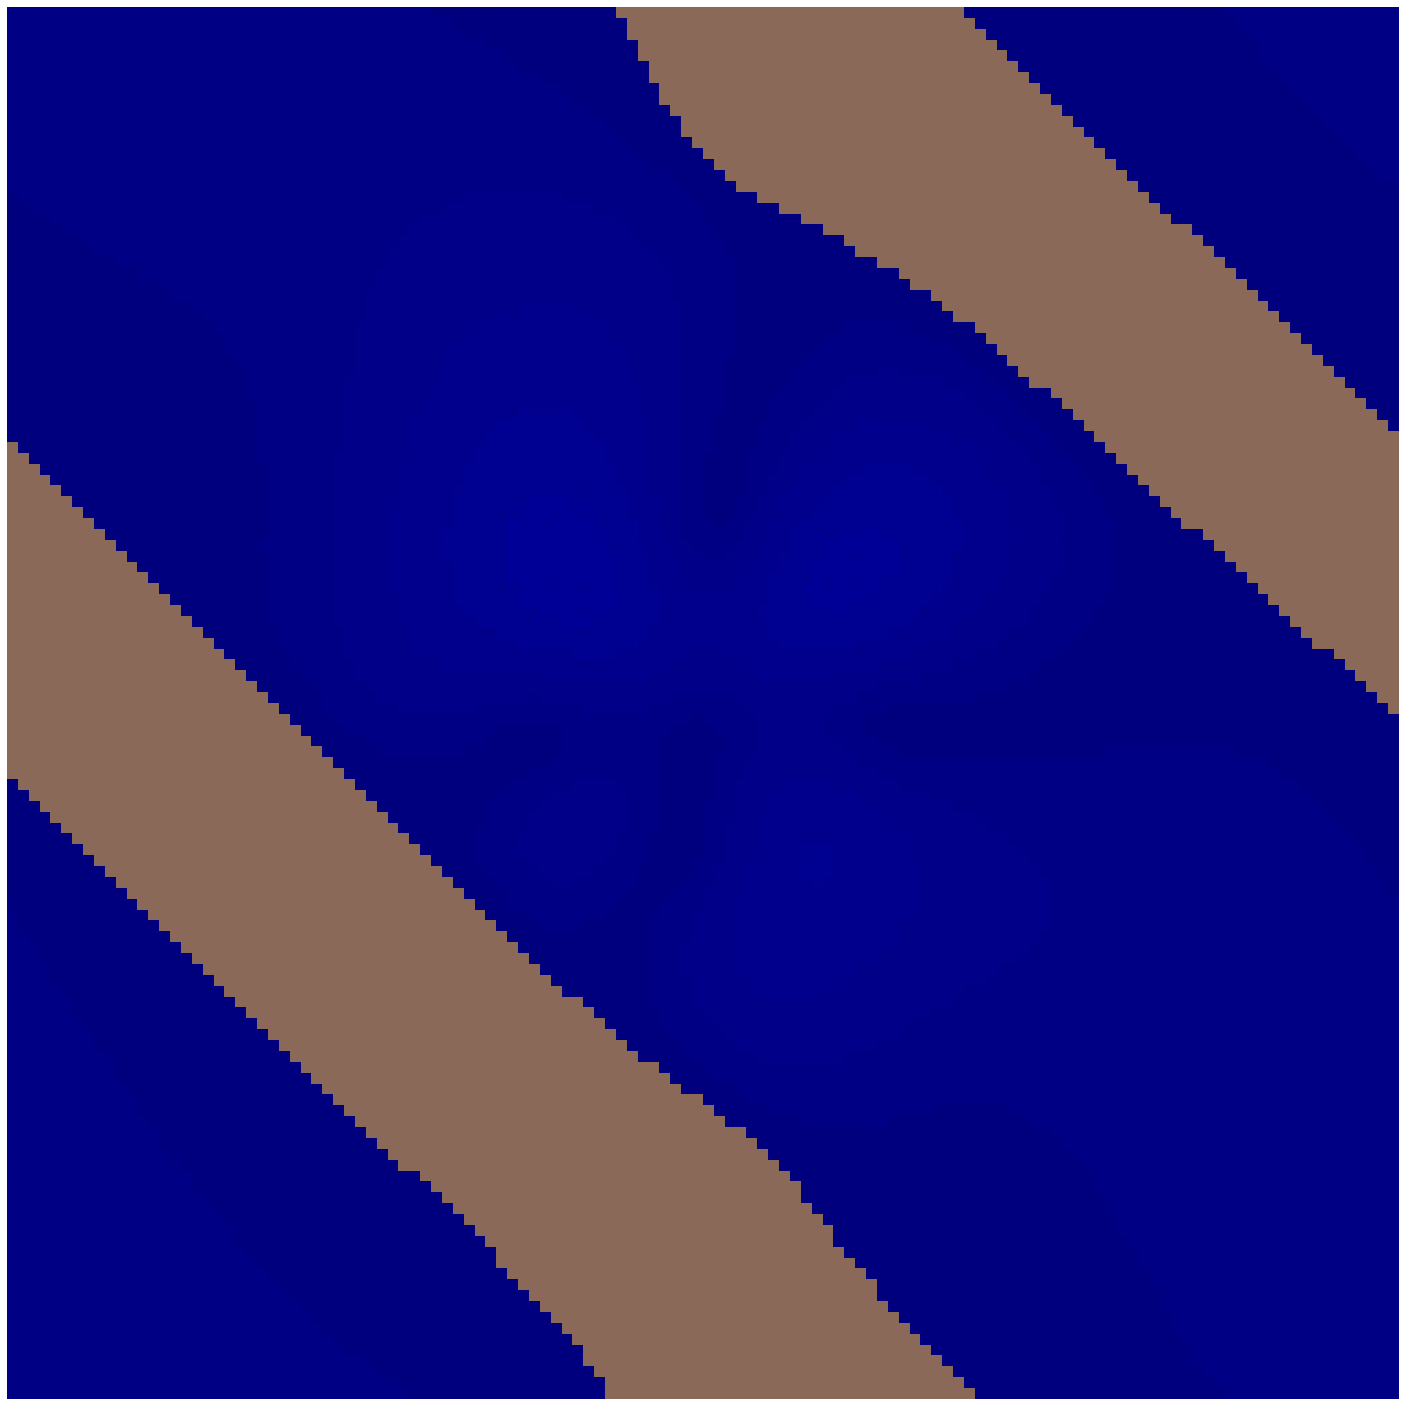

0.6511810949755401 9.029745571744371e-05


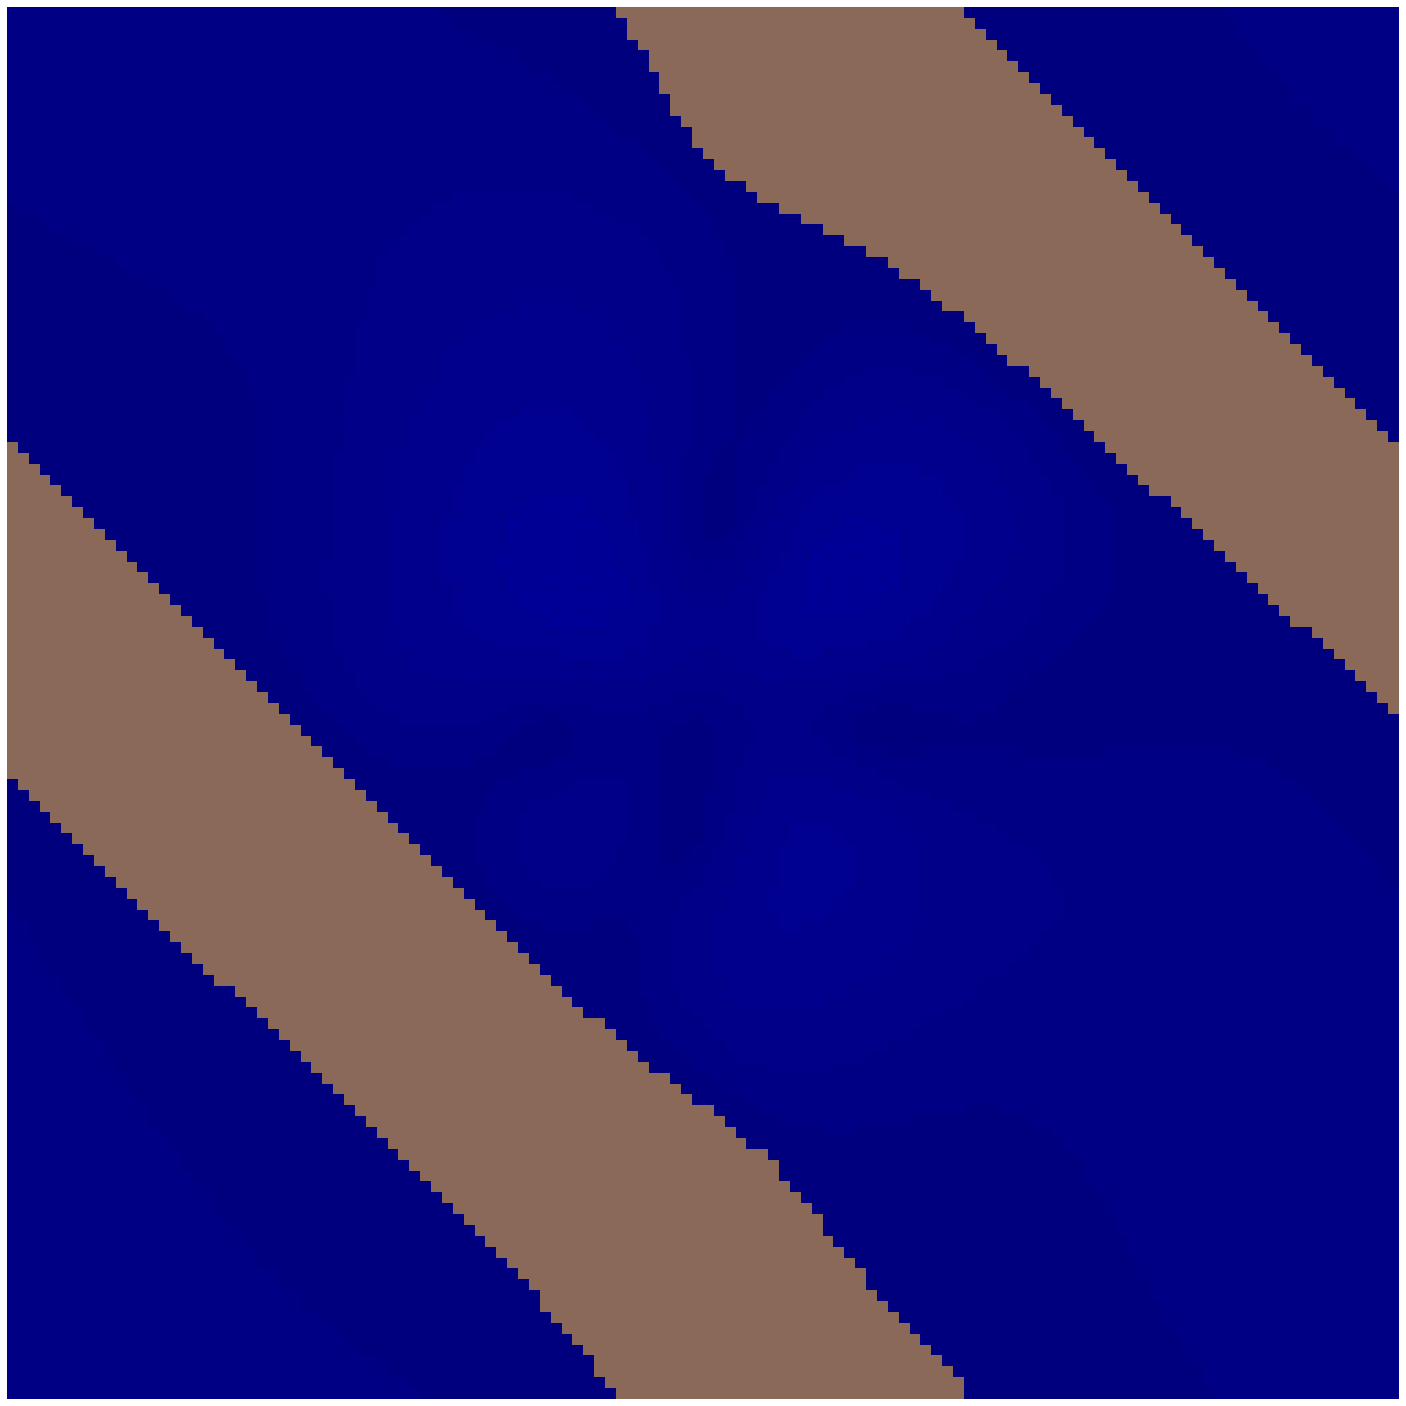

0.62117790099989 9.248164213916351e-05


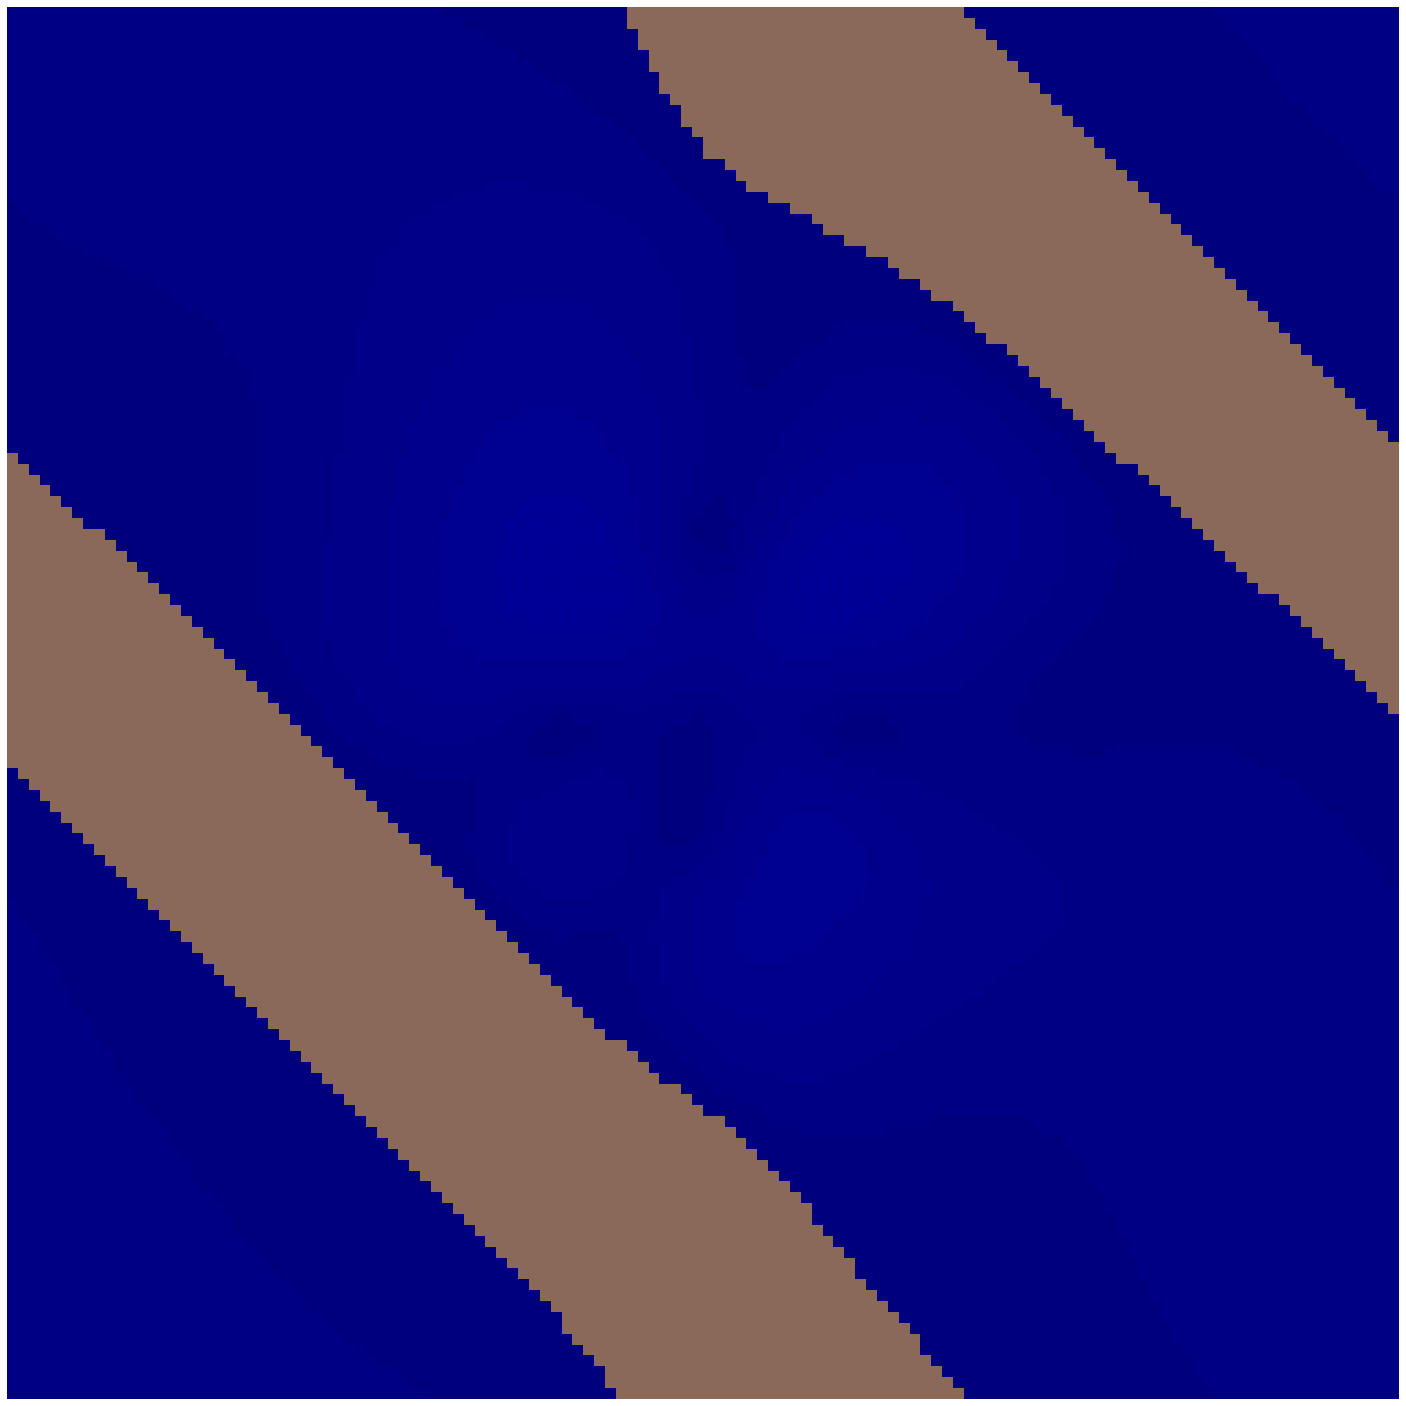

0.5911749129883817 9.485171018396353e-05


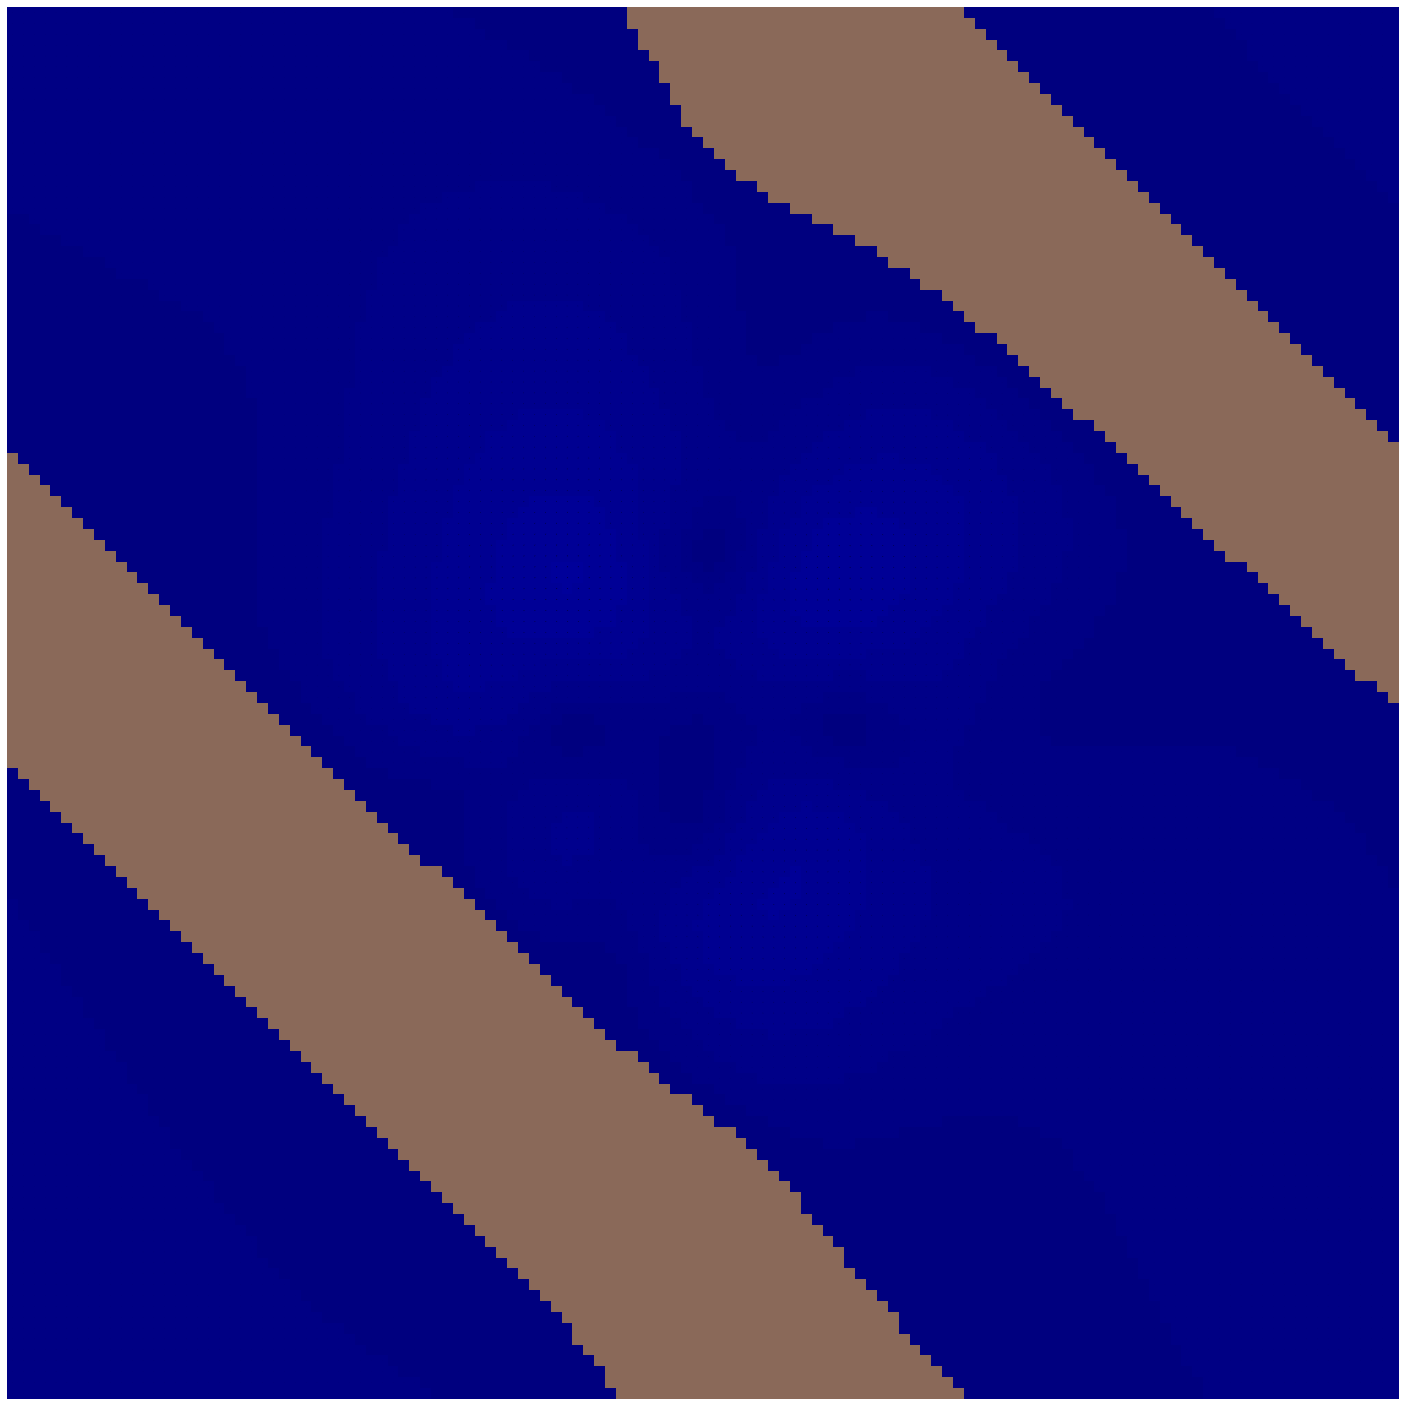

0.5611720186023803 9.686377155914464e-05


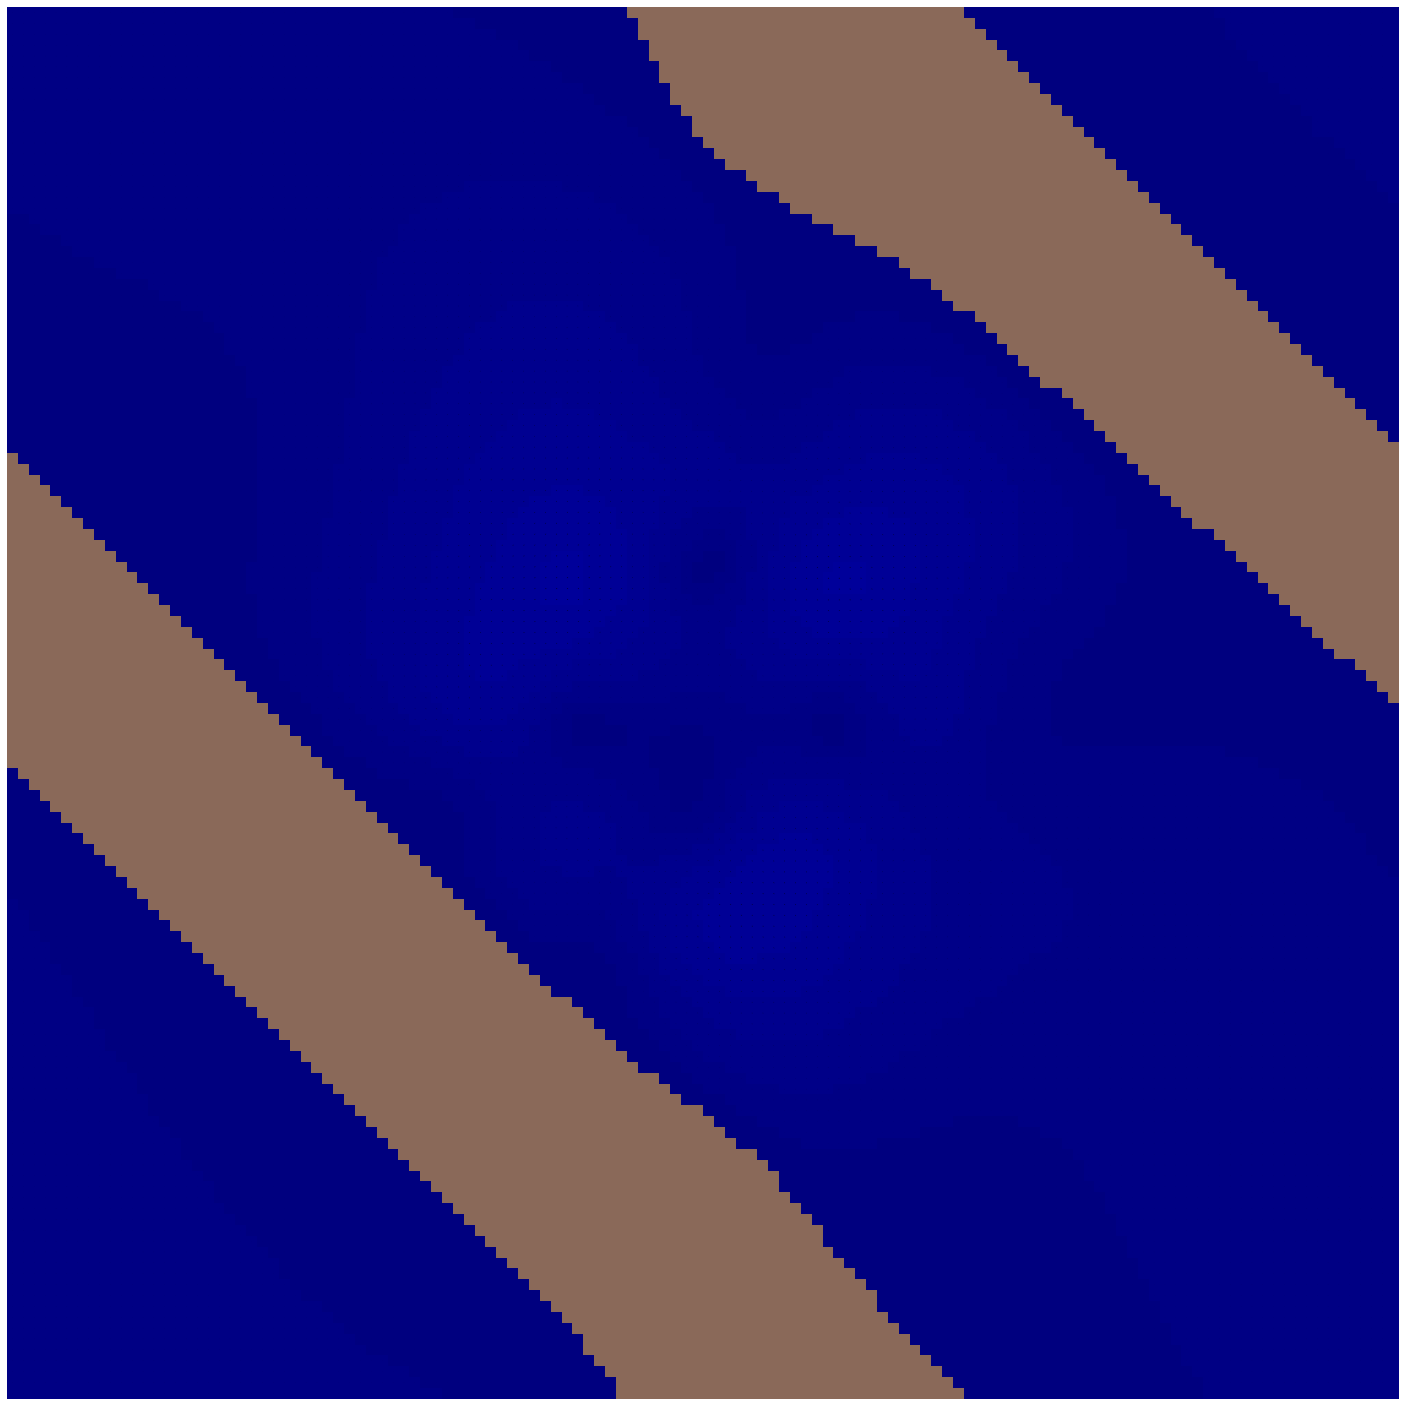

0.5311695772418776 0.00010836290910569521


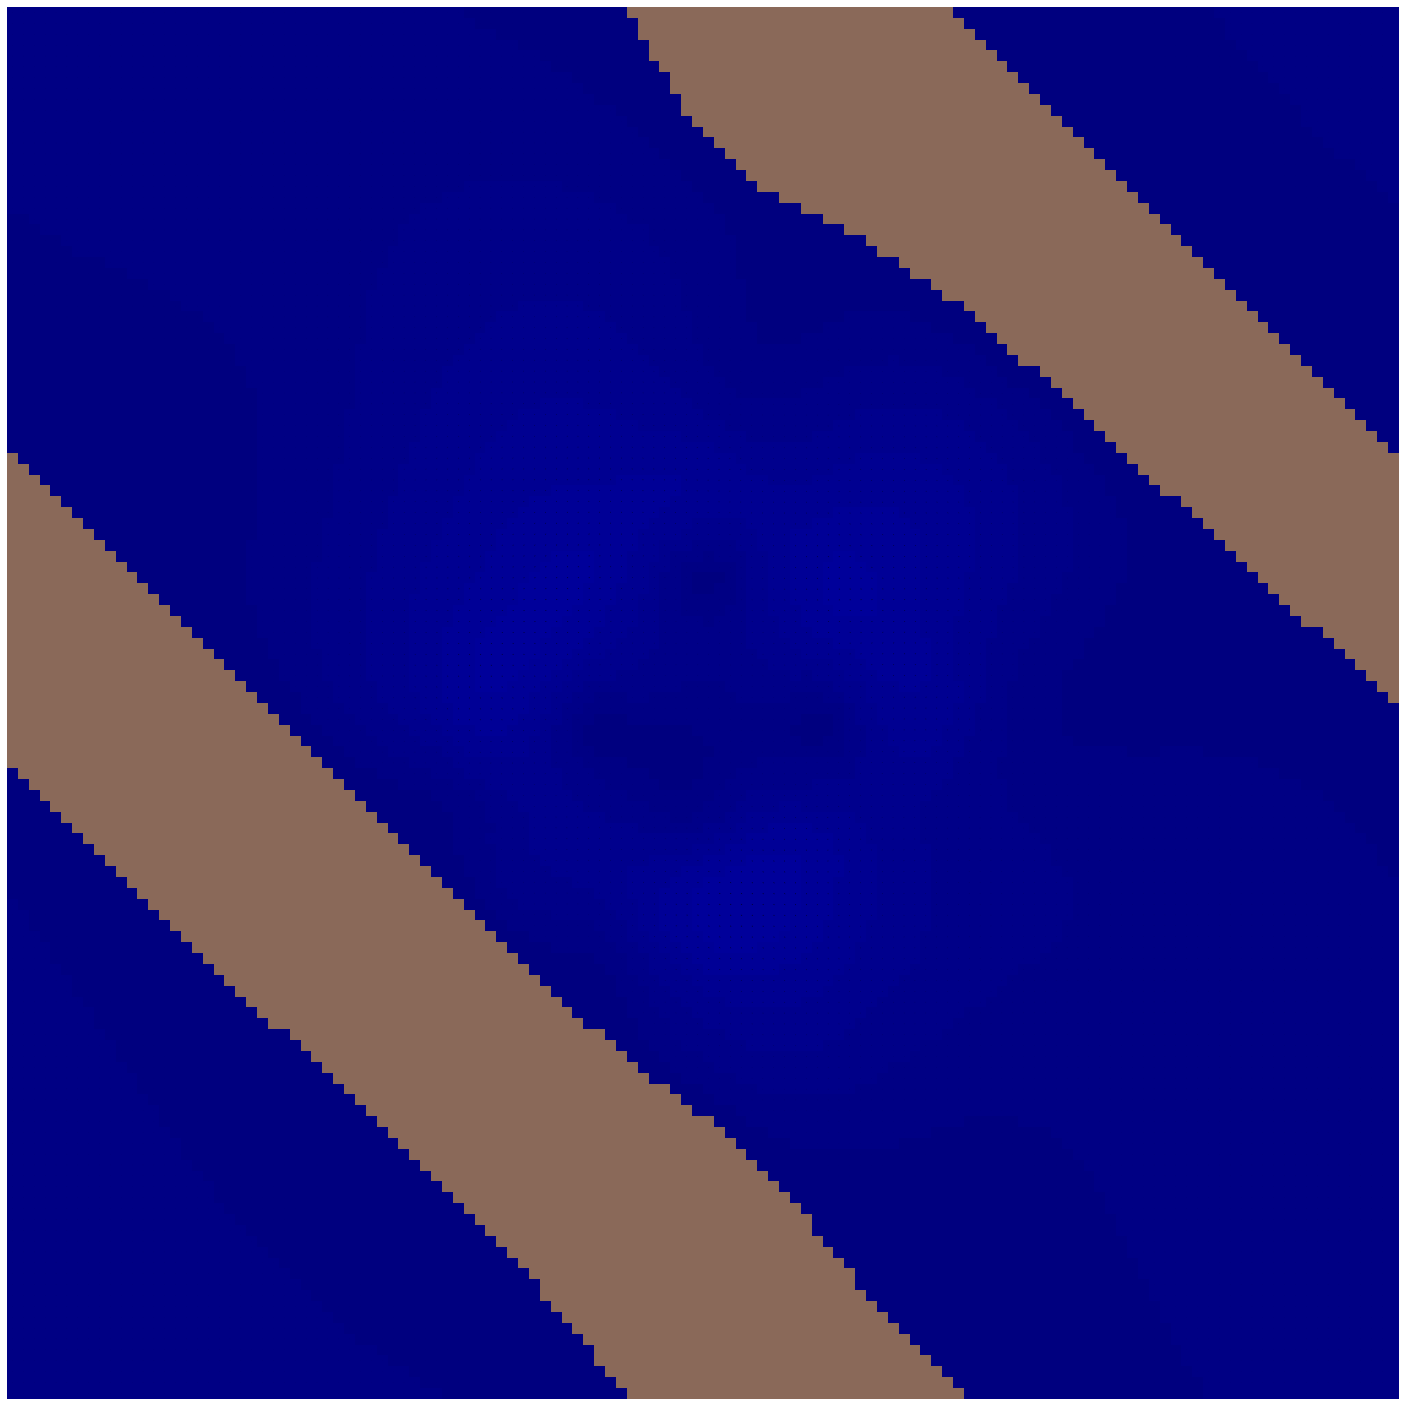

0.501167465816608 0.00013284637075013973


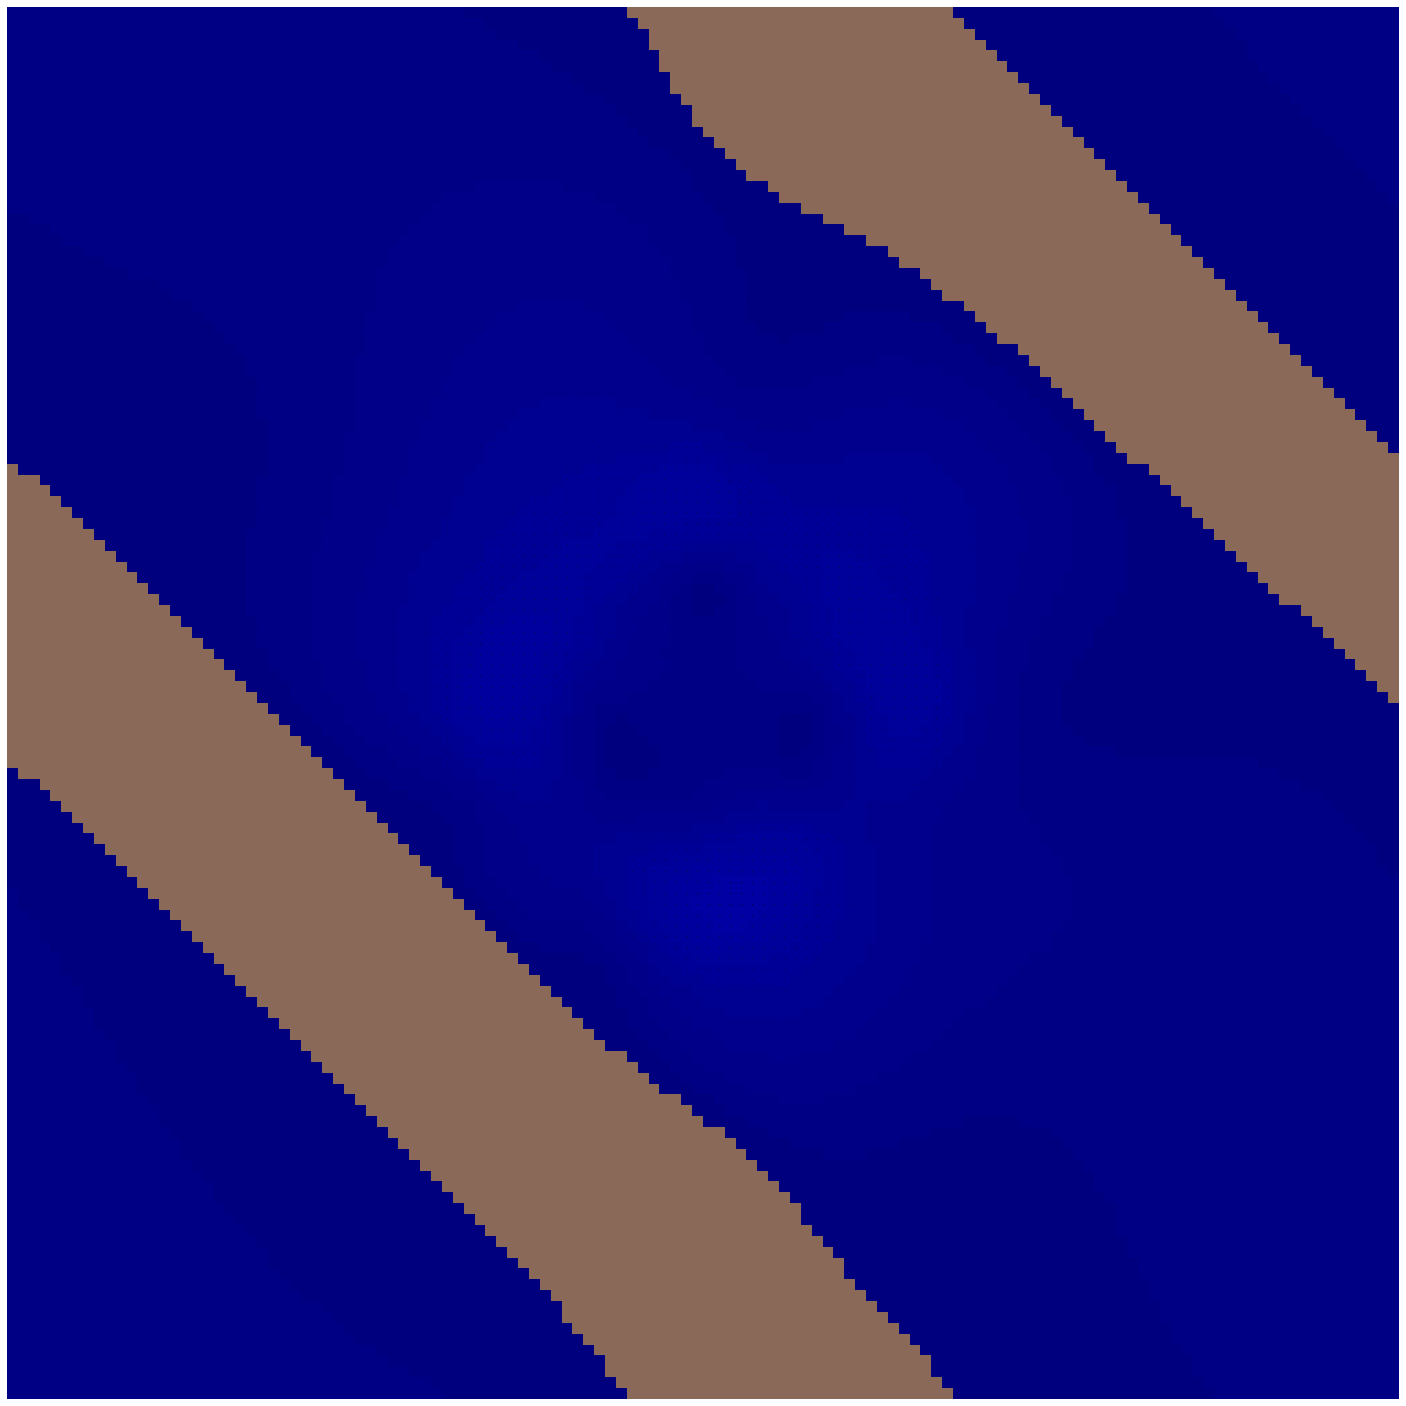

0.4711661326004919 0.0001668329524487702


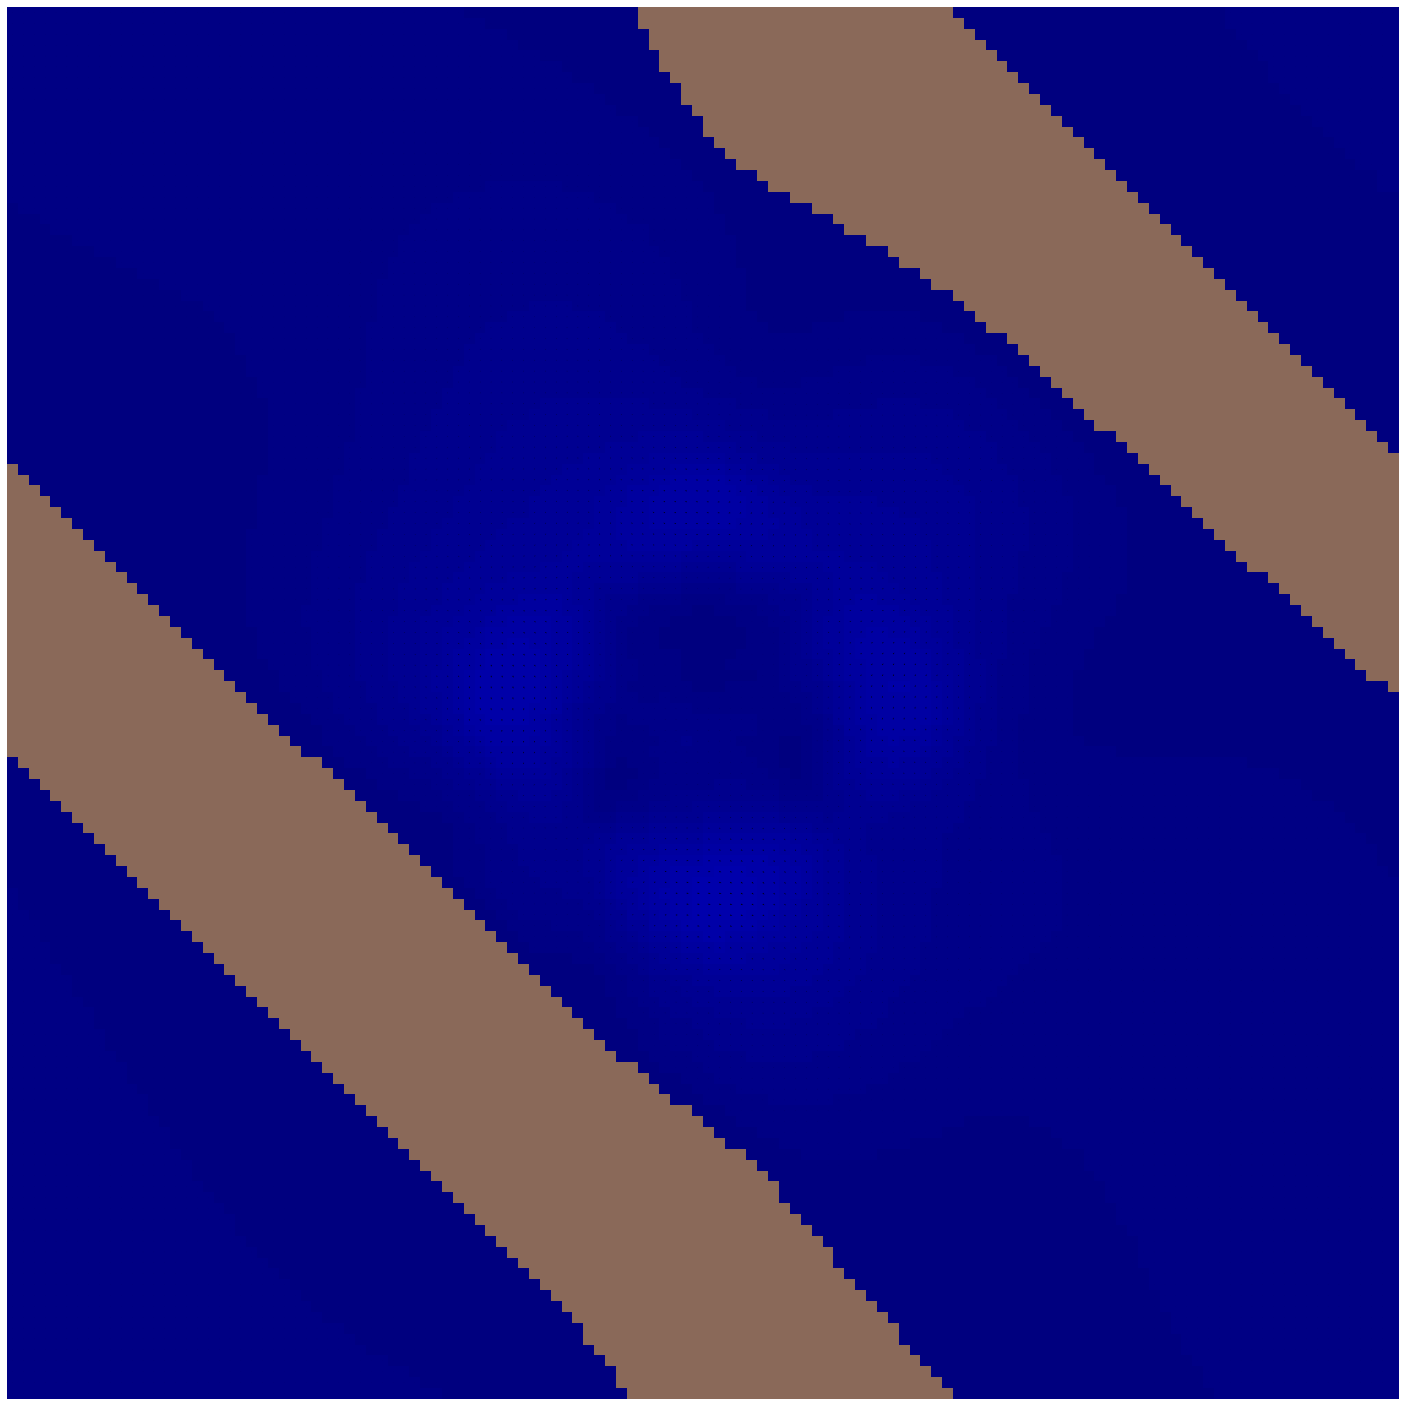

0.4411653758127452 0.000214163622526464


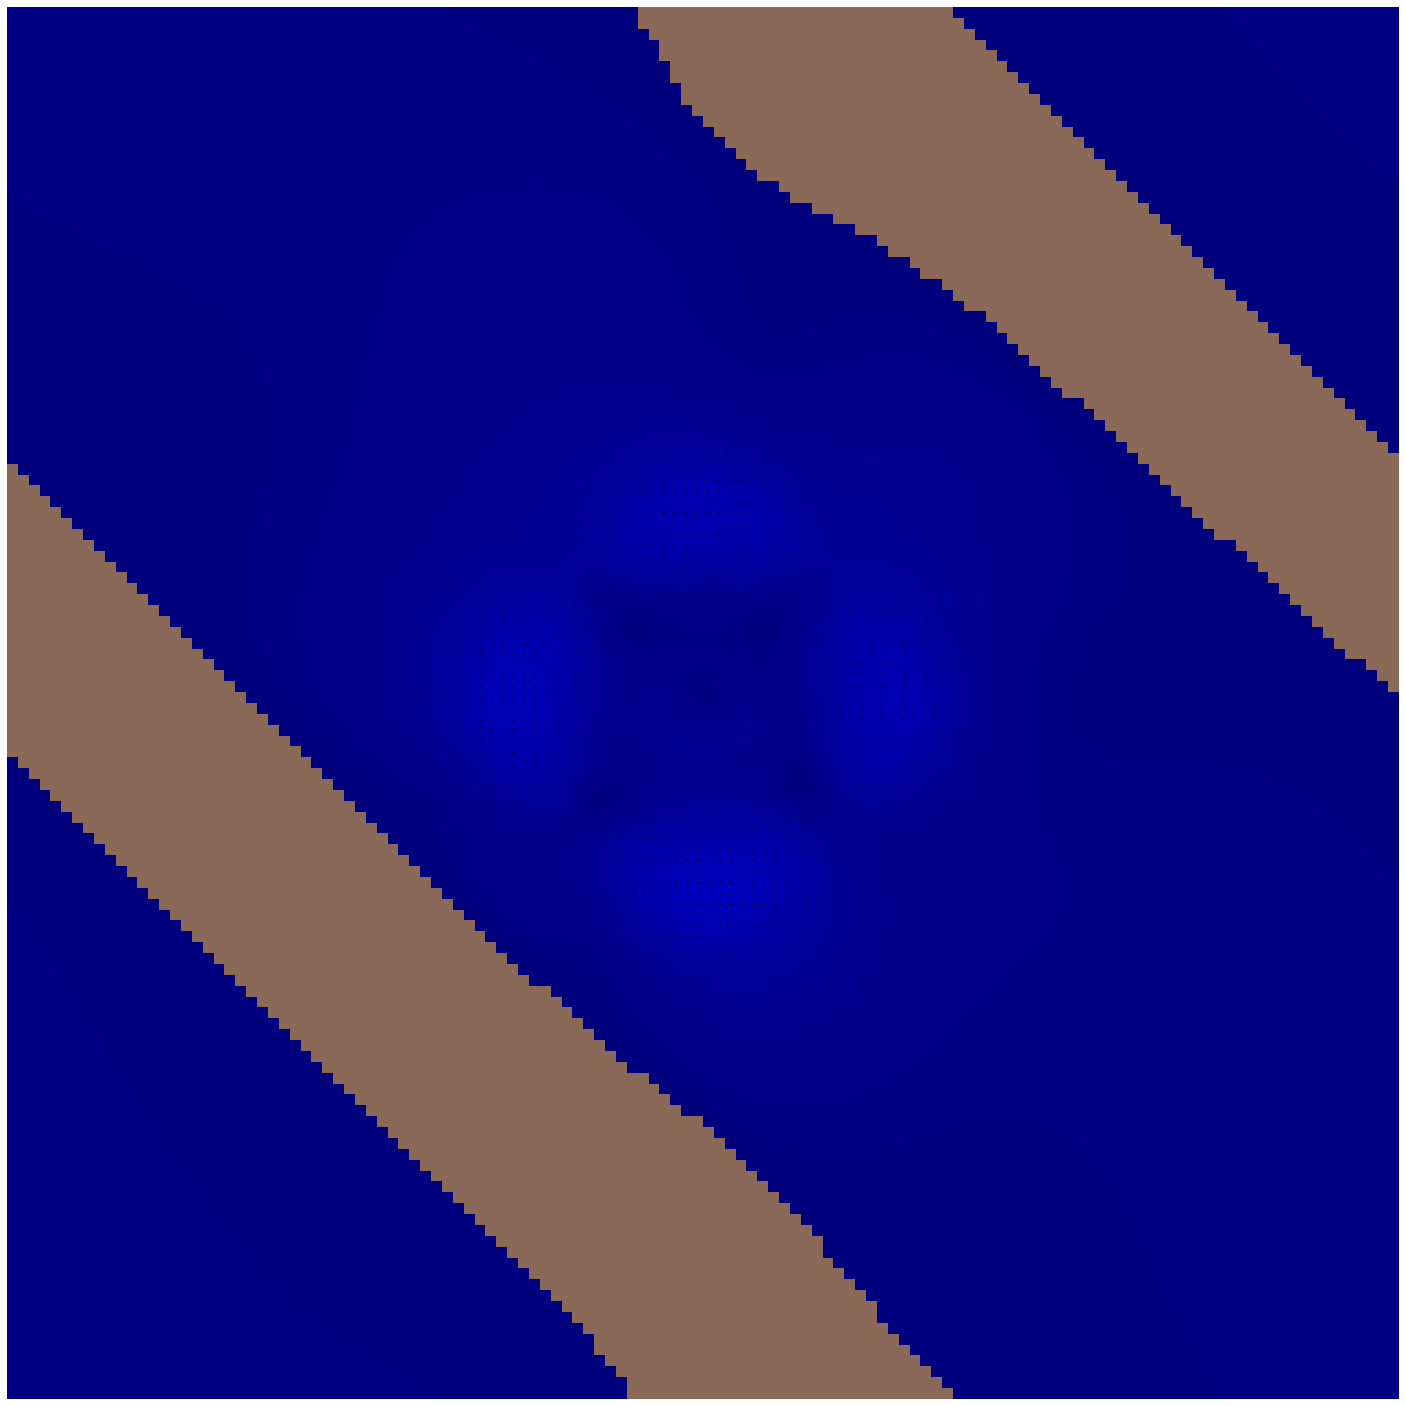

0.41116608132801635 0.00027781943992772663


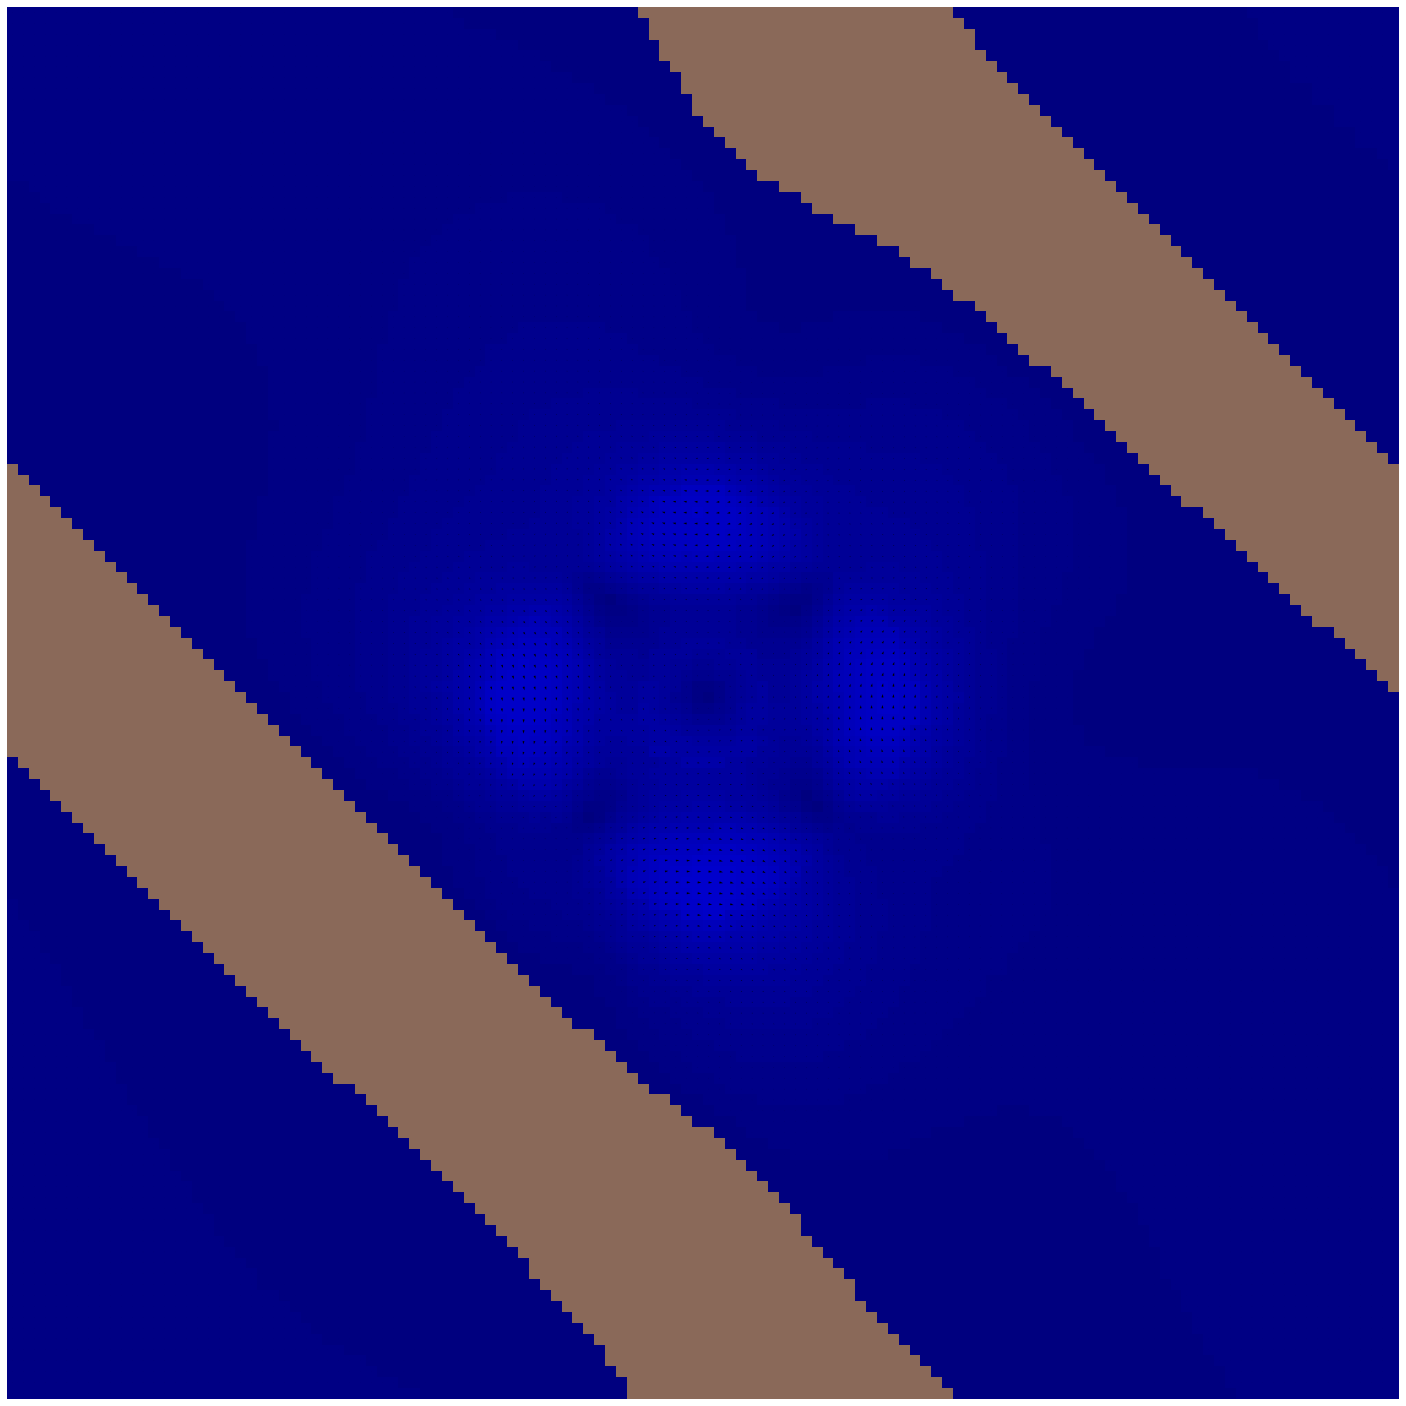

0.3811699614030862 0.00036652402642915597


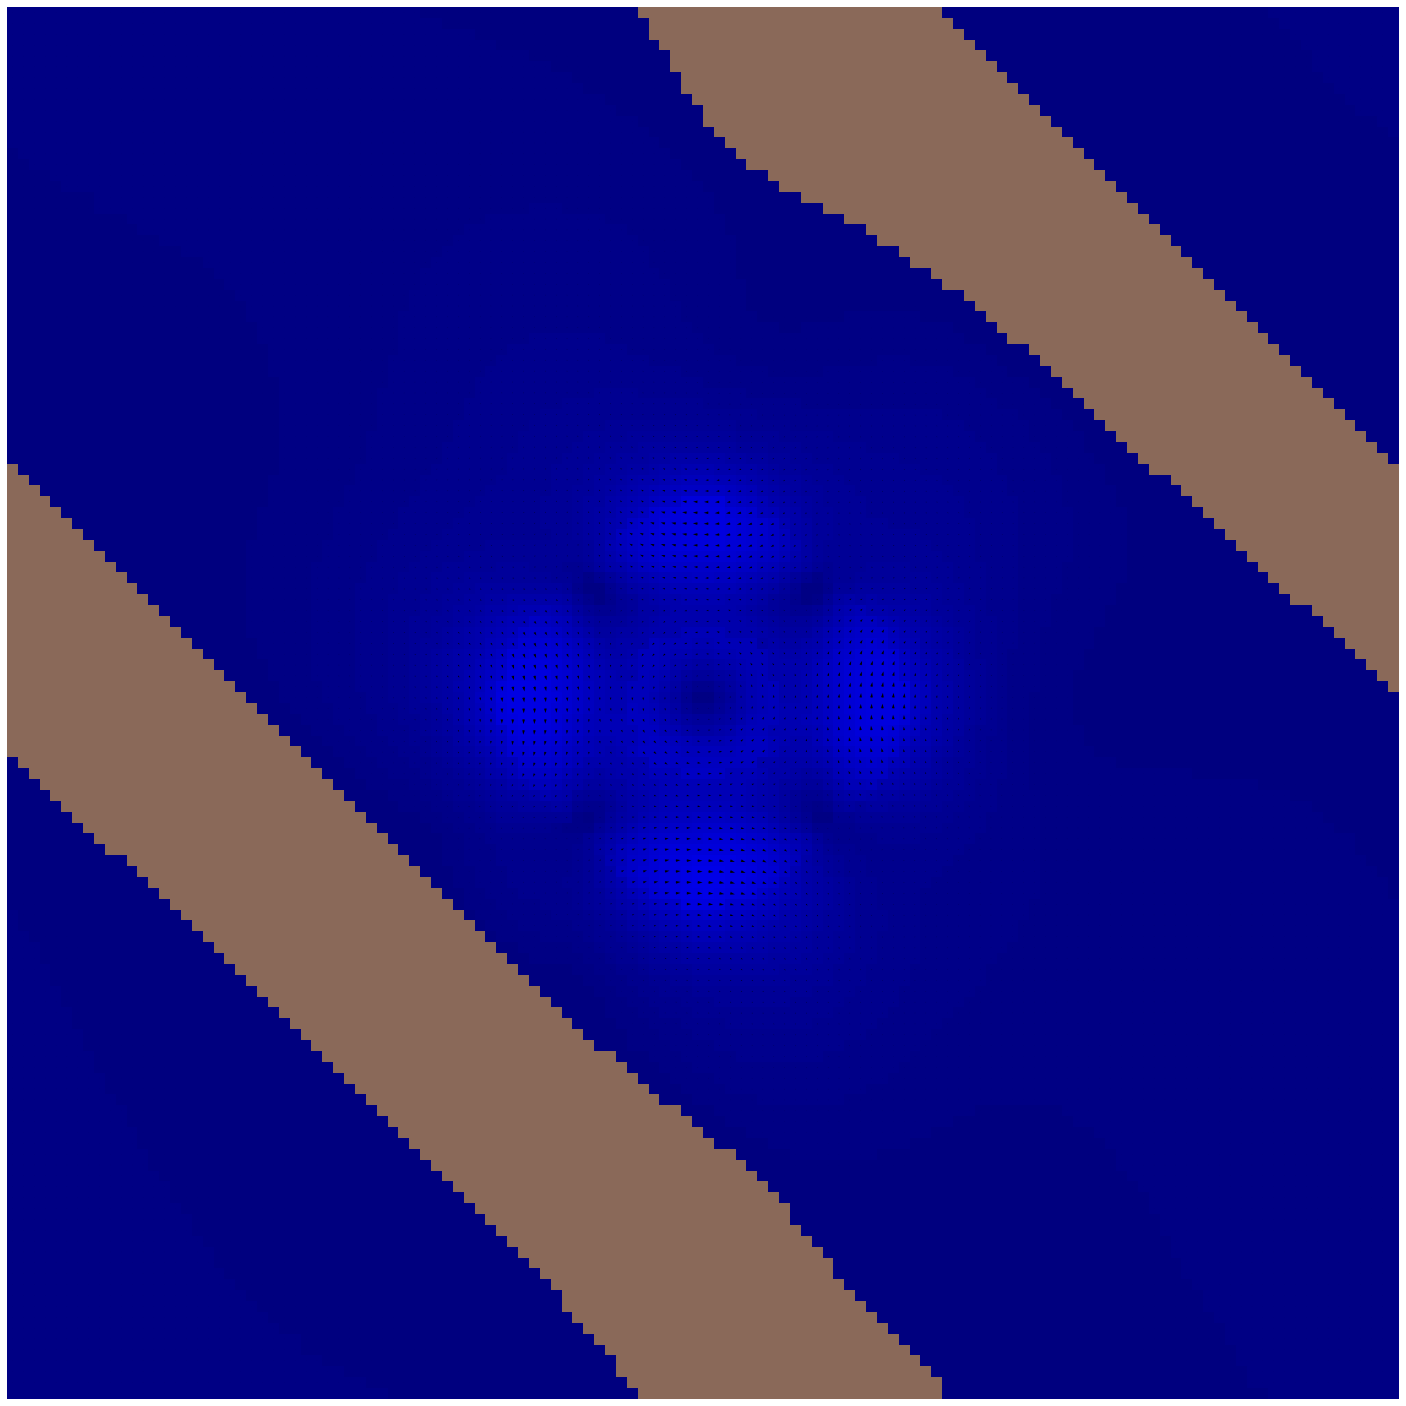

0.3511791872068182 0.0004947938564309741


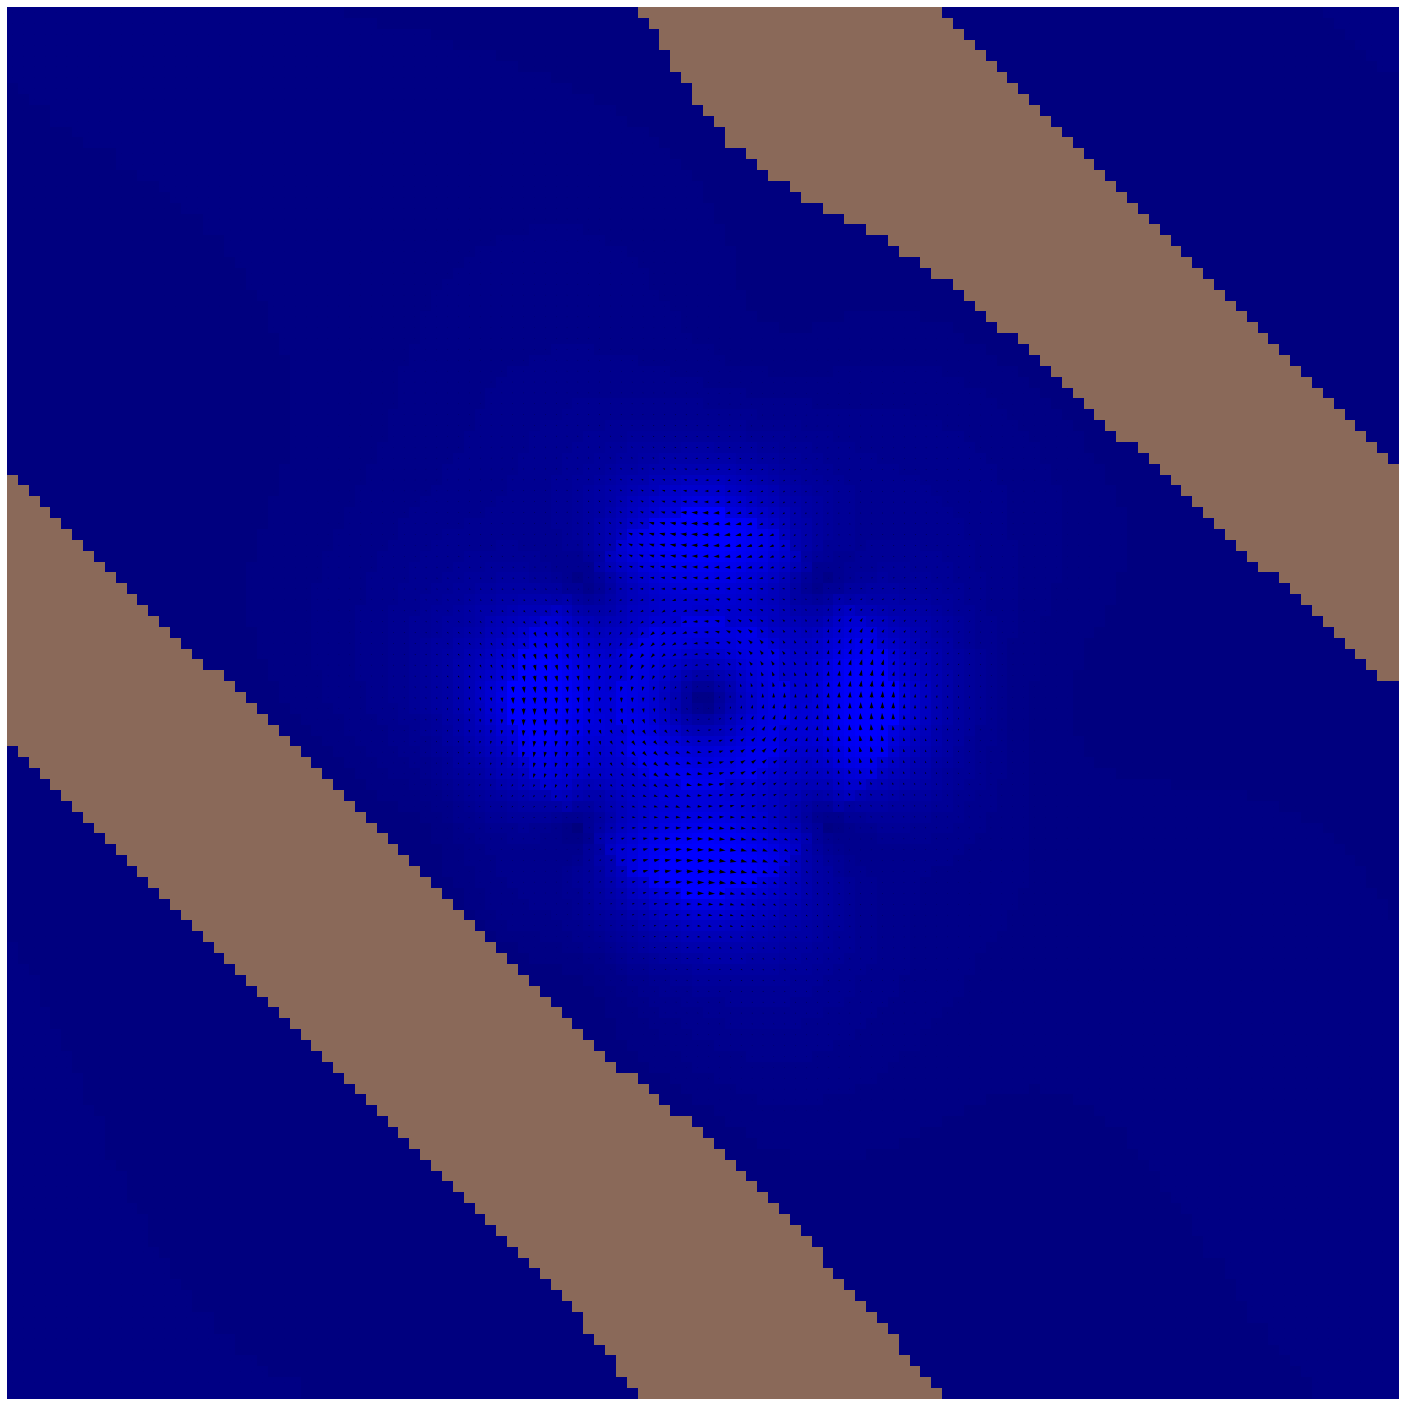

0.32121012571628593 0.0006894845179861131


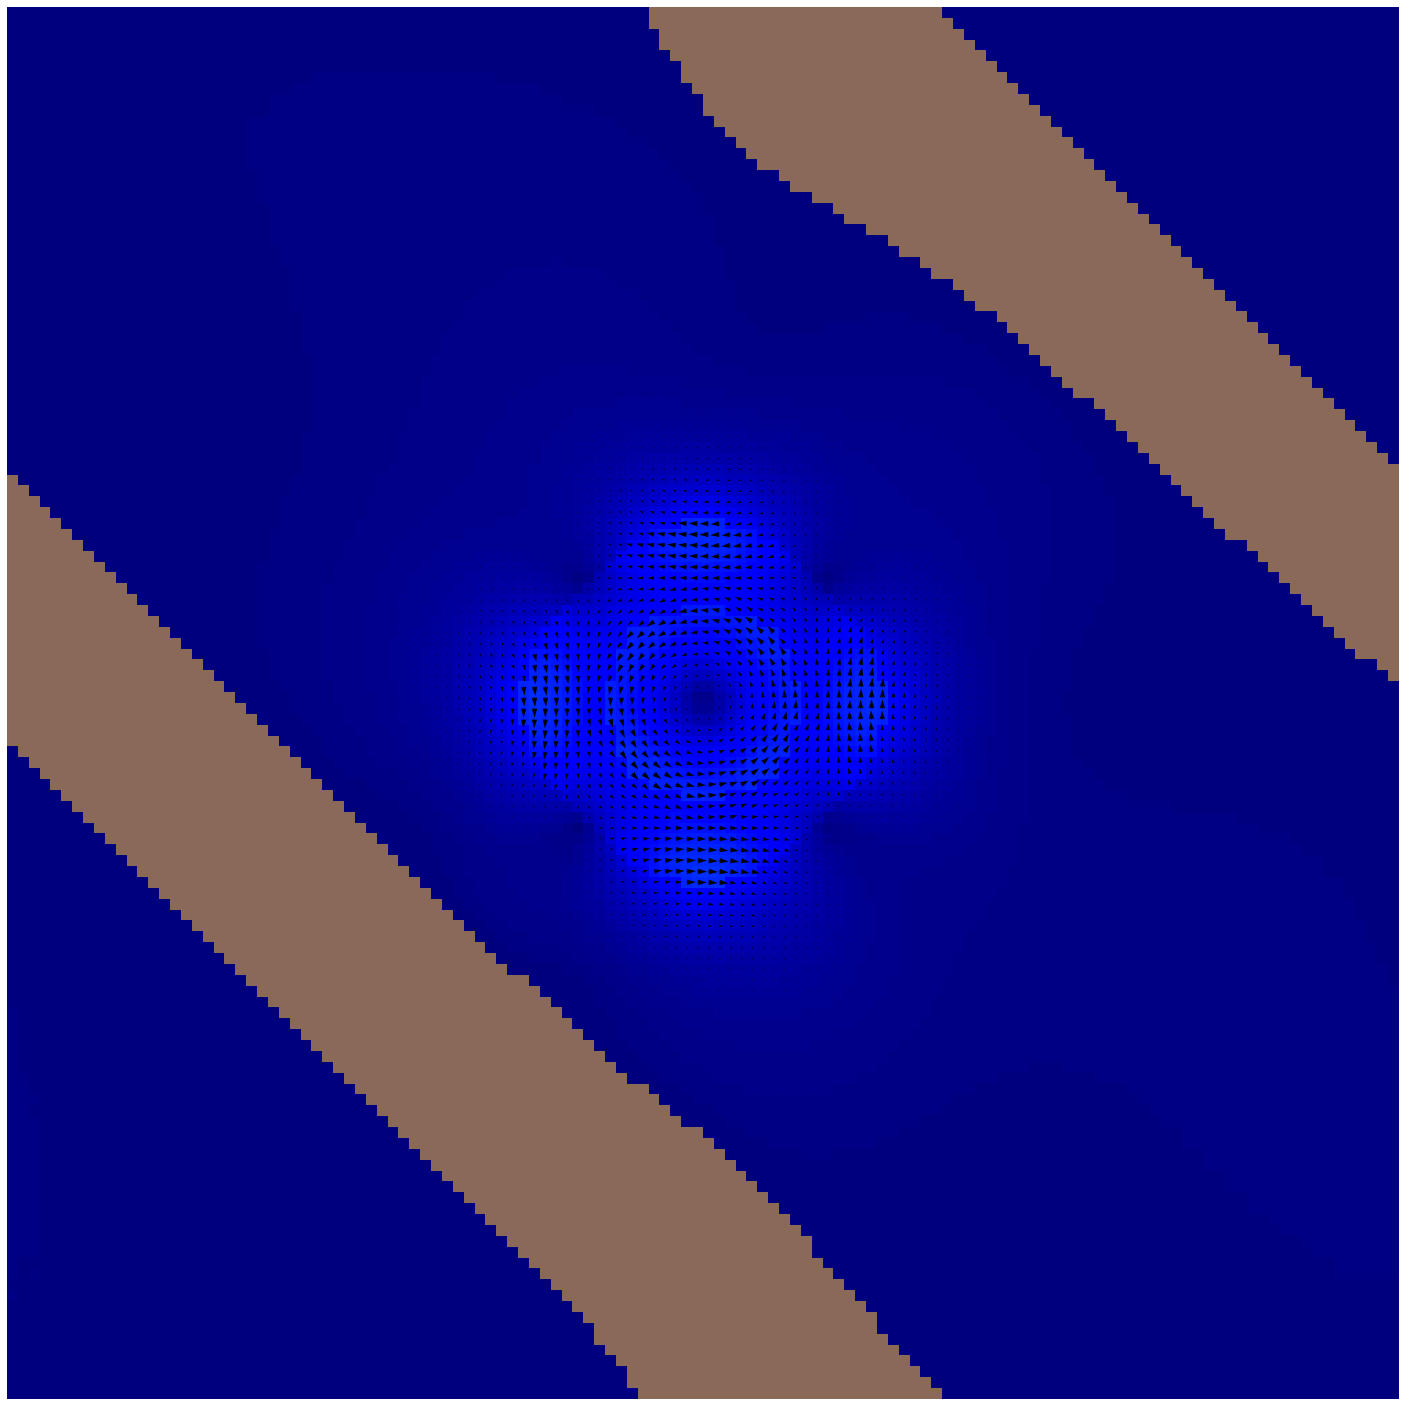

0.2912343543946896 0.0010865472249336598


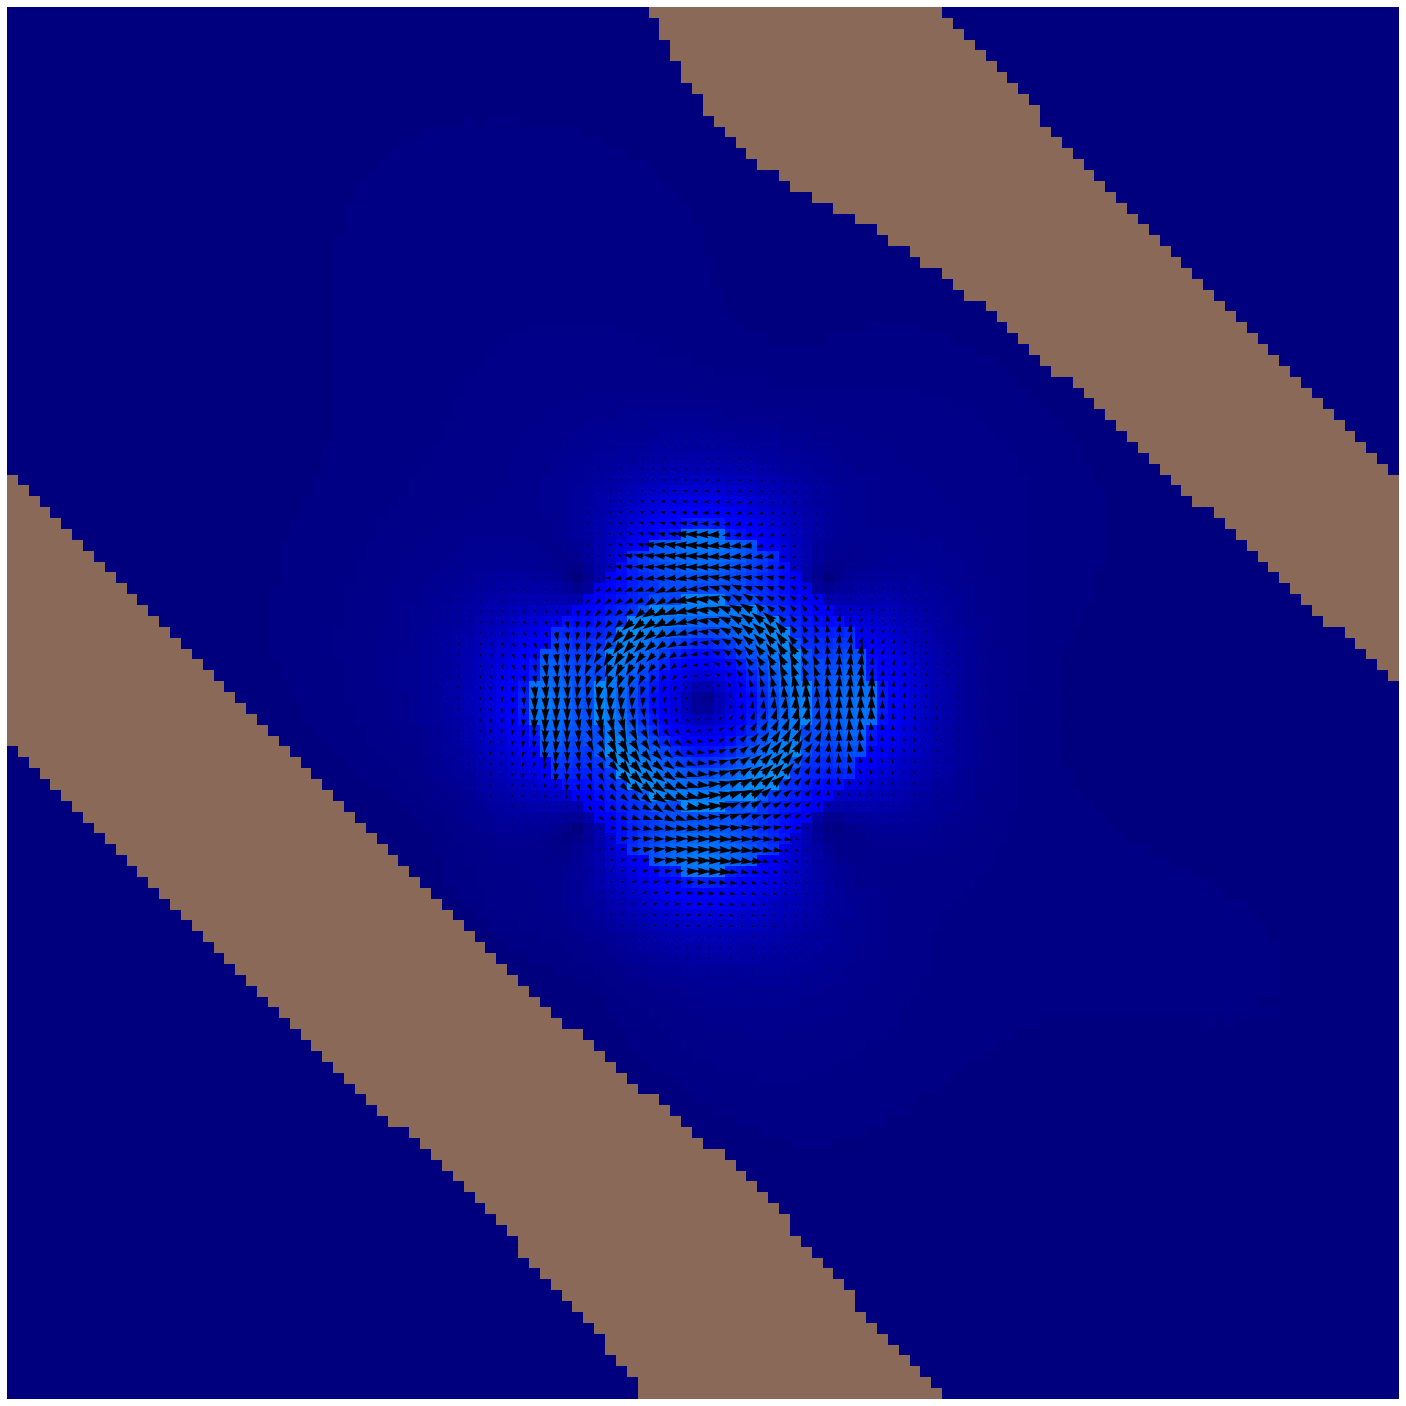

0.261313291818457 0.001808997382622186


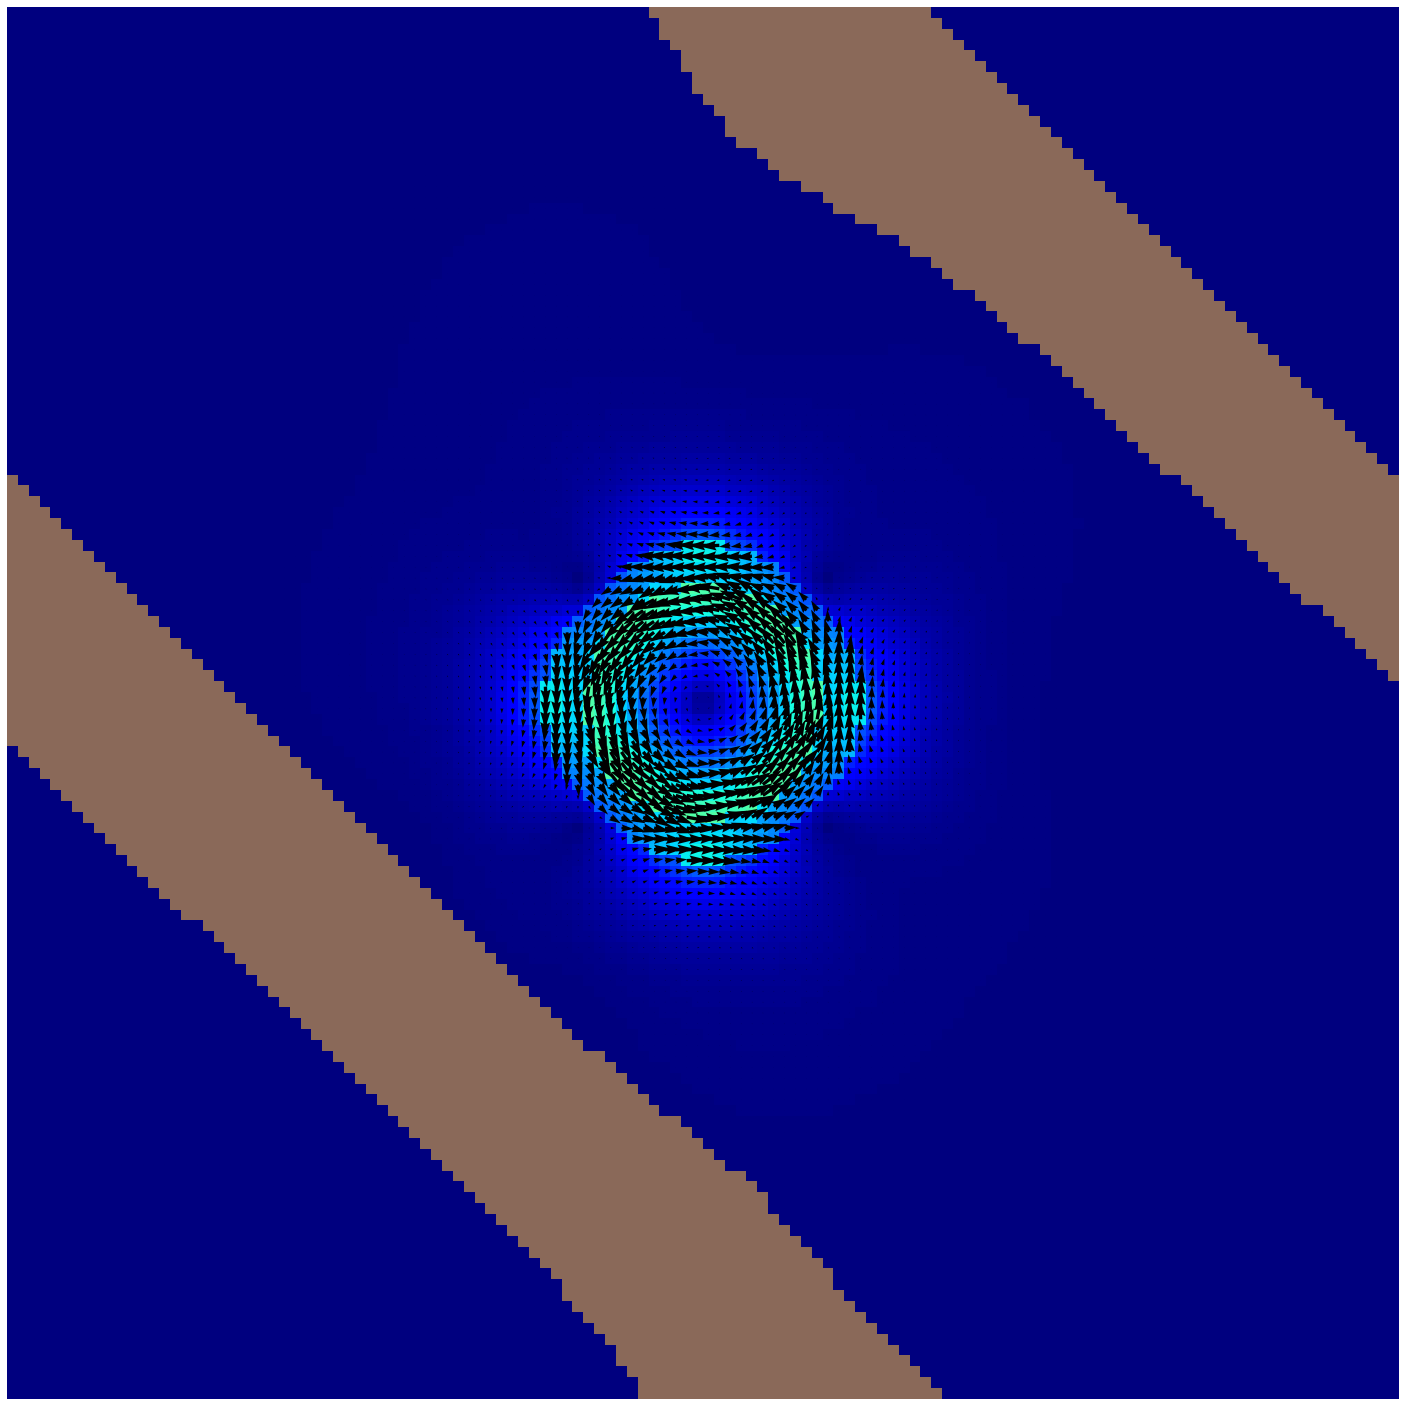

0.23148302974817636 0.003179868420870464


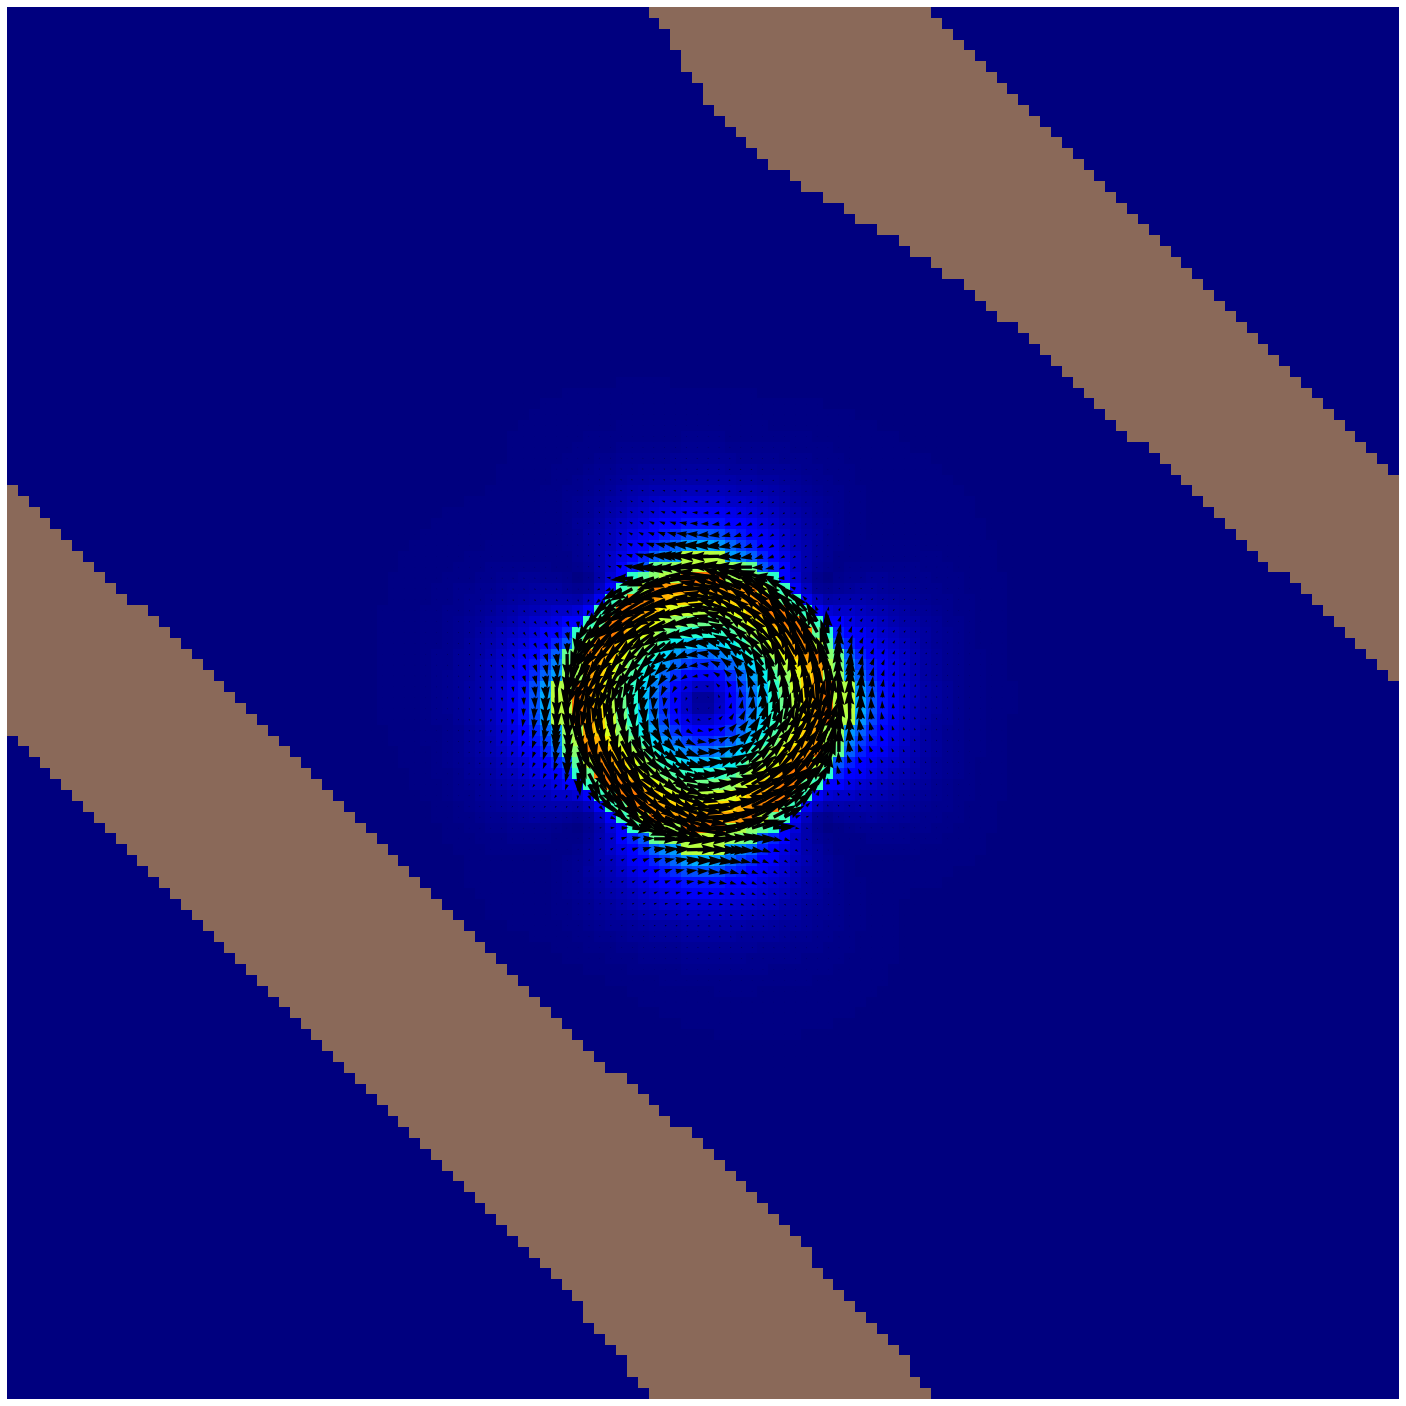

In [191]:
gridf=gpugrid.copy_to_host()


Idx=5

plt.rcParams['figure.figsize'] = [25.6, 25.6]
for H in range(0,64,4):
    
    plt.show()

'''
for H in range(0,64,4):
    plt.imshow(gridf[:,:,H,Idx])
    print(gridf[0,0,H,Idx])
    plt.show()
'''
    
print("--------------------------")
frames=[]
    
rhof=np.sum(gridf,axis=-1)
for H in range(1,64,1):
    fig = plt.figure()
    axs = fig.add_subplot(111)
    axs.imshow((ux[...,H]**2+uy[...,H]**2)**0.5,vmin=0,vmax=0.004,cmap='jet')
    plt.imshow(bounds[...,H]*(1/(bounds[...,H])),cmap='terrain',vmin=0.6,vmax=1.15)
    plt.quiver(ux[...,H],-uy[...,H],scale=0.1,minlength=0)
    axs.axis('off')
    frames+=[pull_img(fig)]
    print(np.max(rhof[:,:,H]),np.max((ux[...,H]**2+uy[...,H]**2)**0.5))
    plt.show()
gifify(frames,"3DStream.gif")

In [ ]:

colors = np.zeros([128,128,64,4])
colors[:,:,:,0]=193/255
colors[:,:,:,1]=150/255
colors[:,:,:,2]=62/255
colors[:,:,:,3]=0.8

colors2 = np.zeros([128,128,64,4])
colors2[:,:,:,2]=grid[:,:,:,0]
colors2[:,:,:,3]=grid[:,:,:,0]*0.5


colors2[bounds>0]=193/255
colors2[bounds>0,1]=150/255
colors2[bounds>0,2]=62/255
colors2[bounds>0,3]=1

# and plot everything
ax = plt.figure().add_subplot(projection='3d')
#ax.voxels(bounds,facecolors=colors)


ax.voxels((np.sum(grid,axis=-1)>0),facecolors=colors2)
ax.voxels((bounds>0),facecolors=colors2)
plt.show()

# Rendering

In [236]:
@cuda.jit
def jetRGBArrow(data,image,min_,max_,V):
    """Turns a [0,1] single channel image into an RGB one using the jet colormap"""
    i,j=cuda.grid(2)
    R=16
    
    gij = (data[i][j]-min_[0])/(max_[0]-min_[0])
    Red=((gij>0.35)&(gij<0.66))*(gij-0.35)/0.31
    Red+=(gij>0.66)&(gij<0.89)
    Red+=(gij>0.89)*(1-0.5*(gij-0.89)/0.11)
    #let R = gij<0.35?0:gij<0.66? (gij-0.35)/0.31:gij<0.89?1:1-0.5*(gij-0.89)/0.11
    Green=((gij>0.125)&(gij<0.375))*(gij-0.125)/0.25
    Green+=(gij>0.375)&(gij<0.64)
    Green+=((gij>0.64)&(gij<0.91))*(1-(gij-0.64)/0.27)
    #let G = gij<0.125?0:gij<0.375?(gij-0.125)/0.25:gij<0.64?1:gij<0.91?1-(gij-0.64)/0.27:0
    Blue=(gij<0.11)*(0.5+gij/0.22)
    Blue+=(gij>0.11)&(gij<0.34)
    Blue+=((gij>0.34)&(gij<0.65))*(1-(gij-0.34)/0.31)
    #let B = gij<0.11?0.5+gij/0.22:gij<0.34?1:gij<0.65?1-(gij-0.34)/0.31:0


    A=1.0;
    R=16
    ri=int(math.floor(i/R/2)*2*R+R)
    rj=int(math.floor(j/R/2)*2*R+R)
    #//coordintates of potential vector arrow this is part of
    
    #//for(let i1=0;i1<9;i1++){
    #//ri=(Math.floor(i/R/2+i1/3-1)*2*R+R)%512
    #//rj=(Math.floor(j/R/2+i1%3-1)*2*R+R)%512
        
    #//vector representing the field arrow
    dx=(R-7)*V[ri][rj][1]/max_[0]**0.5
    dy=(R-7)*V[ri][rj][0]/max_[0]**0.5
    m=(R-7)*((data[ri][rj])/max_[0])**0.5
    #dx=dy=m*0.707
    hs=min(m,3.5)
    #//now we check if our pixel is inside the arrow
    if (m>0):
        x = i-ri
        y=j-rj
        #//arrowhead can be done using inf and 1 norm in rotated coords
        X = dx*(dy-y)/m - dy*(dx-x)/m
        Y = dy*(dy-y)/m + dx*(dx-x)/m
        
        #// A<=0 if its in the arrowhead, 0<A<1 if its on the border A>1 if outside.
        A=min(A,max(-(hs-1.5*abs(X)-0.5*abs(Y)), -(hs-abs(Y+hs))));
        
        #//arrow body done by looking at length of orthogonal (to E field) part of pixel vector
        d=x*dx+y*dy
        X = x-d*dx/m/m
        Y = y-d*dy/m/m       
        if (d<m*m):
            #//Same assignment here but with the arrow body
            A=min(A,max(-3*d/hs,1-(hs/3.2-(X*X+Y*Y)**0.5)/0.4))
        #//clip A between 0 and 1
        A=max(A,0)
        
    image[i][j][0]=Red*255*A
    image[i][j][1]=Green*255*A
    image[i][j][2]=Blue*255*A

In [253]:
import glob
from PIL import Image as PImage

@cuda.jit
def upscale(inarr,outarr):
    """Simple upscaling function."""
    i,j=cuda.grid(2)
    iscale=outarr.shape[0]//inarr.shape[0]
    jscale=outarr.shape[1]//inarr.shape[1]
    outarr[i][j]=inarr[i//iscale][j//jscale][0]
@cuda.jit
def density(inarr,outarr,min_,max_,V):
    """Simple upscaling function."""
    i,j=cuda.grid(2)
    iscale=outarr.shape[0]//inarr.shape[0]
    jscale=outarr.shape[1]//inarr.shape[1]
    cell=inarr[i//iscale][j//jscale]
    rho=(cell[0]+cell[1]+cell[2]+cell[3]+cell[4]+cell[5]+cell[6]+cell[7]+cell[8])
    if rho>0:
        ux=(cell[2]-cell[4]+cell[5]+cell[6]-cell[7]-cell[8])/rho
        #velocity in y so north-south
        uy=(cell[1]-cell[3]+cell[5]+cell[8]-cell[6]-cell[7])/rho
    else:
        ux=uy=0
    outarr[i][j]=(ux*ux+uy*uy)
    V[i][j][0]=ux
    V[i][j][1]=uy
    cuda.atomic.max(max_,0,outarr[i][j])
    cuda.atomic.min(min_,0,outarr[i][j])
@cuda.jit
def jetRGB(data,image,min_,max_):
    """Turns a [0,1] single channel image into an RGB one using the jet colormap"""
    i,j=cuda.grid(2)
    gij = (data[i][j]-min_[0])/(max_[0]-min_[0])
    R=((gij>0.35)&(gij<0.66))*(gij-0.35)/0.31
    R+=(gij>0.66)&(gij<0.89)
    R+=(gij>0.89)*(1-0.5*(gij-0.89)/0.11)
    #let R = gij<0.35?0:gij<0.66? (gij-0.35)/0.31:gij<0.89?1:1-0.5*(gij-0.89)/0.11
    G=((gij>0.125)&(gij<0.375))*(gij-0.125)/0.25
    G+=(gij>0.375)&(gij<0.64)
    G+=((gij>0.64)&(gij<0.91))*(1-(gij-0.64)/0.27)
    #let G = gij<0.125?0:gij<0.375?(gij-0.125)/0.25:gij<0.64?1:gij<0.91?1-(gij-0.64)/0.27:0
    B=(gij<0.11)*(0.5+gij/0.22)
    B+=(gij>0.11)&(gij<0.34)
    B+=((gij>0.34)&(gij<0.65))*(1-(gij-0.34)/0.31)
    #let B = gij<0.11?0.5+gij/0.22:gij<0.34?1:gij<0.65?1-(gij-0.34)/0.31:0
    image[i][j][0]=R*255
    image[i][j][1]=G*255
    image[i][j][2]=B*255
class Render(Thread):
    def __init__(self, globalmem, canvas,dim=[512,512]):
        self.upscaled=cuda.to_device(np.zeros(dim))
        self.img=np.zeros(dim+[3])
        self.threads=(16,16)
        self.blocks=(int(np.ceil(dim[0] / 16)),int(np.ceil(dim[1] / 16)))
        self.grid_global_mem = globalmem
        
        self.V=cuda.to_device(np.zeros(dim+[2],dtype=np.float32))
        
        self.canvas = canvas
        self.isalive=True
        self.min=cuda.to_device(np.ones(1)*9999.9)
        self.max=cuda.to_device(np.ones(1)*-9999.9)
        super(Render, self).__init__()
    def run(self):
        allframes=[]
        while self.isalive:
            density[self.blocks,self.threads](self.grid_global_mem,self.upscaled,self.min,self.max,self.V)
            jetRGBArrow[self.blocks,self.threads](self.upscaled,self.img,self.min,self.max,self.V)
            self.min,self.max=self.max,self.min
            image_data = self.img
            self.canvas.put_image_data(image_data, 0, 0)
            allframes+=[PImage.fromarray(image_data.astype('uint8'))]
            time.sleep(0.01)
            
        fp_out = "Demo.gif"
        img, *imgs = allframes
        img.save(fp=fp_out, format='GIF', append_images=imgs,
                 save_all=True, duration=20, loop=0)
    def debug(self):
            density[self.blocks,self.threads](self.grid_global_mem,self.upscaled,self.min,self.max)
            #jetRGB[self.blocks,self.threads](self.upscaled,self.img,self.min,self.max)
            time.sleep(0.01)
            print(self.max[0],self.min[0])
            self.min,self.max=self.max,self.min
            
            
            
            
class Fluid(Thread):
    def __init__(self, N,maxsteps=1e6):
        #setup the lattice and helper data structures
        self.N=N
        self.maxsteps=maxsteps
        height = N
        width = N*2
        viscosity = 0.2
        omega = 1 / (3*viscosity + 0.5)     # "relaxation" parameter
        self.u0=u0 = 0.1                            # initial and in-flow speed
        four9ths = 4.0/9.0                  # abbreviations for lattice-Boltzmann weight factors
        one9th   = 1.0/9.0
        one36th  = 1.0/36.0

        # Initialize all the arrays to steady rightward flow:
        n0 = four9ths * (np.ones((height,width)) - 1.5*u0**2)	# particle densities along 9 directions
        nN = one9th * (np.ones((height,width)) - 1.5*u0**2)
        nS = one9th * (np.ones((height,width)) - 1.5*u0**2)
        nE = one9th * (np.ones((height,width)) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
        nW = one9th * (np.ones((height,width)) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
        nNE = one36th * (np.ones((height,width)) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
        nSE = one36th * (np.ones((height,width)) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
        nNW = one36th * (np.ones((height,width)) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
        nSW = one36th * (np.ones((height,width)) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)

        GRID=np.zeros([N,2*N,9])
        GRID[:]=np.stack([n0,nN,nE,nS,nW,nNE,nSE,nSW,nNW]).transpose([1,2,0])
        print(GRID.shape)

        barrier = np.zeros((height,width))-1
        barrier[(height//2)-8:(height//2)+8, height//2] = 1
        #barrier[0,:]=1
        #barrier[-1,:]=1
        GRID[barrier>=0]=0
        
        self.threadsperblock = (16, 16)#should end up a multiple of 32 I think
        blockspergrid_x = int(np.ceil(GRID.shape[0] / self.threadsperblock[0]))
        blockspergrid_y = int(np.ceil(GRID.shape[1] / self.threadsperblock[1]))
        self.blockspergrid = (blockspergrid_x, blockspergrid_y)
        self.isalive=True
        self.grid1 = cuda.to_device(GRID)
        self.grid2=cuda.to_device(GRID.copy())
        self.c=1
        self.v=0.2
        self.bounds=cuda.to_device(barrier)
        self.vx=self.vy=0
        self.fakeforce=True
        
        super(Fluid, self).__init__()
    def fps(self):
        """Gives the number of updates performed in one second"""
        iold = self.index
        time.sleep(1)
        return self.index-iold
    def run(self):
        """Run the ising updates on a thread"""
        self.index=0
        #setEquil[self.blockspergrid, self.threadsperblock](self.grid1,self.bounds,0, 0.1, 1)
        while self.isalive and self.index<self.maxsteps:
            
            self.index+=1
            if self.fakeforce:
                streamGPU[self.blockspergrid, self.threadsperblock](self.grid1,self.grid2,self.bounds)
                collision2DFlowSpeed[self.blockspergrid, self.threadsperblock](self.grid2,self.v,self.c,self.vx,self.vy,5e-3)
                streamGPU[self.blockspergrid, self.threadsperblock](self.grid2,self.grid1,self.bounds)
                collision2DFlowSpeed[self.blockspergrid, self.threadsperblock](self.grid1,self.v,self.c,self.vx,self.vy,5e-3)
                
            else:
                streamGPU[self.blockspergrid, self.threadsperblock](self.grid1,self.grid2,self.bounds)
                collision2D[self.blockspergrid, self.threadsperblock](self.grid2,self.v,self.c)
                setwall[1,self.N](self.grid2,self.vx)
                streamGPU[self.blockspergrid, self.threadsperblock](self.grid2,self.grid1,self.bounds)
                collision2D[self.blockspergrid, self.threadsperblock](self.grid1,self.v,self.c)
                setwall[1,self.N](self.grid1,self.vx)
cleaner.hard_reset()    
model = Fluid(128)
print(model.blockspergrid, model.threadsperblock)
canvas = Canvas(width=1024,height=512)
rend = Render(model.grid1,canvas,dim=[512,1024])
cleaner.add(model,rend)
model.start()
rend.start()


def func(Temp,Viscosity,Row,Theta):
    model.c=Temp
    model.v=Viscosity
    model.vx=np.cos(Theta*2*np.pi)*Row
    model.vy=np.sin(Theta*2*np.pi)*Row
    
plswork = widgets.Layout(
    width='50%'
)
    
x = widgets.FloatSlider(min=1,max=2,value=1.0,step=0.001,layout=plswork)
x.style.handle_color = 'lightblue'
y = widgets.FloatSlider(min=0.005,value=0.2,max=0.5,step=0.0001,layout=plswork)
z = widgets.FloatSlider(min=0,value=0.0,max=1,step=0.0001,layout=plswork)
w = widgets.FloatSlider(min=0,value=0.1,max=0.1,step=0.0001,layout=plswork)
widgets.interact(func,Temp=x,Viscosity=y,Row=w,Theta=z)

canvas

(128, 256, 9)
(8, 16) (16, 16)


interactive(children=(FloatSlider(value=1.0, description='Temp', layout=Layout(width='50%'), max=2.0, min=1.0,…

Canvas(height=512, width=1024)

In [249]:
model.fakeforce=True

(2, 2)
(3, 3, 2, 2)


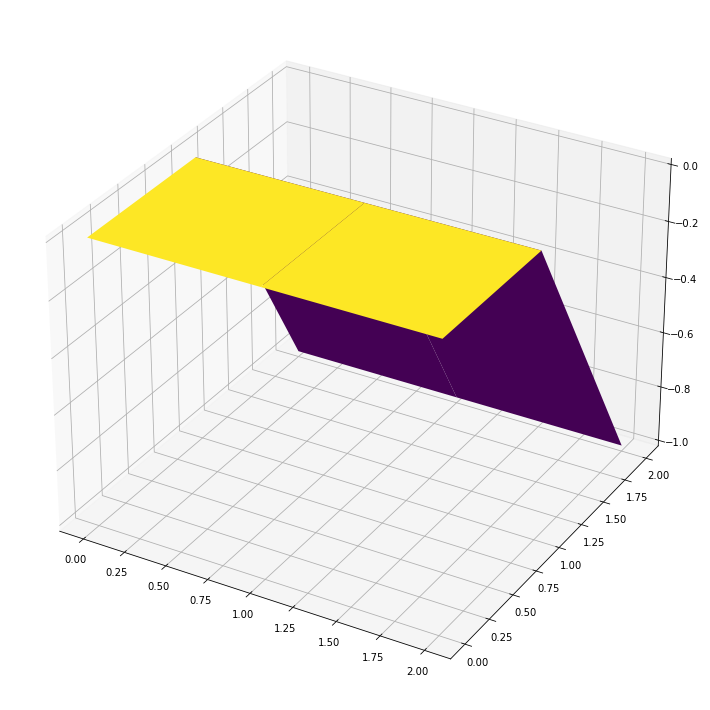

In [205]:
x = np.linspace(1,2,2)

y = np.linspace(1,2,2)
X, Y =np.meshgrid(x,y)
print(X.shape)
def function(x,y):
    A = np.array([[x, x,x], [y, y,y],[x+y,x+y,x+y]])
    A_determinant = np.linalg.det(A)
    print(A.shape)

    return A_determinant

Z = function(X,Y)
fig = plt.figure()
ax = plt.axes(projection='3d')

x2,y2=np.meshgrid(*([np.arange(3)]*2))

ax.plot_surface(x2, y2, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

-9.51619735392994e-16